In [1]:
import os
import random
import shutil
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import brevitas.nn as qnn
from brevitas.nn import QuantLinear, QuantReLU, QuantConv2d
from brevitas.quant.binary import SignedBinaryActPerTensorConst
from brevitas.quant.binary import SignedBinaryWeightPerTensorConst
from brevitas.inject.enum import QuantType

# Network Definition

In [2]:
input_length = 28*28
hidden_0 = 1024
hidden_1 = 1024
hidden_2 = 1024
output_length = 10

In [3]:
class MLP(nn.Module):
    def __init__(self, dropout=0.5):
        super(MLP, self).__init__()
        
        self.input = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=8, min_val=-128.0, max_val=127.0, return_quant_tensor=True)
        
        self.fc0   = qnn.QuantLinear(input_length, hidden_0, weight_bit_width=8, weight_quant_type=QuantType.INT, bias=False)
        self.bn0   = nn.BatchNorm1d(hidden_0)
        self.act0  = nn.SiLU()
        self.quan0 = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=8, min_val=-128.0, max_val=127.0, return_quant_tensor=True)
        self.drop0 = nn.Dropout(dropout)
        
        self.fc1   = qnn.QuantLinear(hidden_0, hidden_1, weight_bit_width=8, weight_quant_type=QuantType.INT, bias=False)
        self.bn1   = nn.BatchNorm1d(hidden_1)
        self.act1  = nn.SiLU()
        self.quan1 = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=8, min_val=-128.0, max_val=127.0, return_quant_tensor=True)
        self.drop1 = nn.Dropout(dropout)
        
        self.fc2   = qnn.QuantLinear(hidden_1, hidden_2, weight_bit_width=8, weight_quant_type=QuantType.INT, bias=False)
        self.bn2   = nn.BatchNorm1d(hidden_2)
        self.act2  = nn.SiLU()
        self.quan2 = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=8, min_val=-128.0, max_val=127.0, return_quant_tensor=True)
        self.drop2 = nn.Dropout(dropout)
        
        self.out   = qnn.QuantLinear(hidden_2, output_length, weight_bit_width=8, weight_quant_type=QuantType.INT, bias=False)

    def forward(self, x):
        
        out = x.reshape(x.shape[0], -1)
        out = self.input(out)
        out = self.drop0(self.quan0(self.act0(self.bn0(self.fc0(out)))))
        out = self.drop1(self.quan1(self.act1(self.bn1(self.fc1(out)))))
        out = self.drop2(self.quan2(self.act2(self.bn2(self.fc2(out)))))
        out = self.out(out)
        
        return out

# Random Seed Utility

In [4]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define Dataloader

In [5]:
def get_dataloaders(batch_size):
    transform = transforms.ToTensor()
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_dataset, batch_size=batch_size),
    )

# Training Pipeline

In [6]:
def train_validate_test(config, save_dir):
    set_random_seed()
    os.makedirs(save_dir, exist_ok=True)
    log_file = os.path.join(save_dir, "training_log.txt")
    resume_path = os.path.join(save_dir, "checkpoint.pth")

    epochs, batch_size, lr1, lr2, lr3, dropout = config
    train_loader, val_loader, test_loader = get_dataloaders(batch_size)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = MLP(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr1)

    start_epoch = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if os.path.exists(resume_path):
        ckpt = torch.load(resume_path)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        history = ckpt["history"]
        start_epoch = ckpt["epoch"] + 1
        print(f"🔄 Resuming from epoch {start_epoch}")
    else:
        with open(log_file, "w") as f:
            f.write("Training started\n")

    def evaluate(loader):
        model.eval()
        loss_total, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                loss_total += loss.item() * x.size(0)
                _, pred = out.max(1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return loss_total / total, correct / total

    for epoch in range(start_epoch, epochs):
        model.train()
        lr = lr1 if epoch < 0.5 * epochs else lr2 if epoch < 0.8 * epochs else lr3
        for g in optimizer.param_groups:
            g["lr"] = lr

        train_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        val_loss, val_acc = evaluate(val_loader)
        train_loss /= total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        log_line = (f"Epoch {epoch+1}/{epochs} - LR: {lr:.5f} | "
                    f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(log_line)
        with open(log_file, "a") as f:
            f.write(log_line + "\n")

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history
        }, resume_path)

    # Final Test
    test_loss, test_acc = evaluate(test_loader)
    final_line = f"Final Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}"
    print(final_line)
    with open(log_file, "a") as f:
        f.write(final_line + "\n")
        f.write("Training completed\n")

    torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))

    # Plot and show
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plot.png"))
    plt.show()

    return test_acc

# Exploring Best Hyperparameter

In [7]:
def Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates):
    output_root = root_path
    os.makedirs(output_root, exist_ok=True)
    
    epochs = epochs
    batch_sizes = batch_sizes
    lr_pool = lr_pool
    
    # Generate descending LR combinations
    lr_combos = [combo for combo in itertools.product(lr_pool, repeat=3)
                 if (combo[0] > combo[1] > combo[2]) or (combo[0] == combo[1] == combo[2])]
    
    all_runs = [
        f"batch{bs}_lr{lr1}_{lr2}_{lr3}"
        for bs, (lr1, lr2, lr3) in itertools.product(batch_sizes, lr_combos)
    ]
    
    completed_runs = []
    for run in all_runs:
        log_path = os.path.join(output_root, run, "training_log.txt")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                if any("Training completed" in line for line in f):
                    completed_runs.append(run)
    
    if len(completed_runs) == len(all_runs):
        print("✅ All combinations completed. Restarting from scratch...")
        for run in all_runs:
            shutil.rmtree(os.path.join(output_root, run), ignore_errors=True)
        if os.path.exists(os.path.join(output_root, "summary.csv")):
            os.remove(os.path.join(output_root, "summary.csv"))
        completed_runs = []
    
    results = []
    for batch_size, (lr1, lr2, lr3), dropout in itertools.product(batch_sizes, lr_combos, dropout_rates):
        run_name = f"batch{batch_size}_lr{lr1}_{lr2}_{lr3}_dp{dropout}"
        save_dir = os.path.join(output_root, run_name)
    
        if run_name in completed_runs:
            print(f"✅ Skipping {run_name}")
            with open(os.path.join(save_dir, "training_log.txt")) as f:
                for line in f:
                    if "Final Test Loss" in line:
                        acc = float(line.strip().split()[-1])
                        results.append((run_name, acc))
            continue
    
        print(f"🚀 Running: {run_name}")
        acc = train_validate_test([epochs, batch_size, lr1, lr2, lr3, dropout], save_dir)
        results.append((run_name, acc))
    
    results.sort(key=lambda x: x[1], reverse=True)
    best_config, best_acc = results[0]
    print(f"🏆 Best Config: {best_config} Accuracy: {best_acc:.4f}")
    
    with open(os.path.join(output_root, "summary.csv"), "w") as f:
        f.write("Config,Accuracy\n")
        for name, acc in results:
            f.write(f"{name},{acc:.4f}\n")

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.0


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/torch/_tensor.py:1362: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/c10/core/TensorImpl.h:1900.)
  return super().rename(names)


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/torch/csrc/utils/python_arg_parser.cpp:368.)
  output_tensor = linear(x, quant_weight, quant_bias)


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3159, Acc: 0.9109 | Val Loss: 0.1996, Acc: 0.9416


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1611, Acc: 0.9542 | Val Loss: 0.1363, Acc: 0.9623


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1162, Acc: 0.9655 | Val Loss: 0.1227, Acc: 0.9661


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0906, Acc: 0.9737 | Val Loss: 0.1200, Acc: 0.9674


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0767, Acc: 0.9772 | Val Loss: 0.1146, Acc: 0.9718


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9825 | Val Loss: 0.1301, Acc: 0.9699


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9845 | Val Loss: 0.1231, Acc: 0.9712


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9861 | Val Loss: 0.1202, Acc: 0.9719


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9869 | Val Loss: 0.1186, Acc: 0.9729


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9894 | Val Loss: 0.1106, Acc: 0.9748


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9909 | Val Loss: 0.1429, Acc: 0.9705


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9908 | Val Loss: 0.1326, Acc: 0.9728


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9911 | Val Loss: 0.1304, Acc: 0.9746


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9913 | Val Loss: 0.1535, Acc: 0.9722


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9931 | Val Loss: 0.1409, Acc: 0.9734


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9916 | Val Loss: 0.1295, Acc: 0.9766


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9939 | Val Loss: 0.1386, Acc: 0.9735


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9936 | Val Loss: 0.1479, Acc: 0.9738


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9937 | Val Loss: 0.1761, Acc: 0.9702


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9946 | Val Loss: 0.1344, Acc: 0.9762


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9954 | Val Loss: 0.1369, Acc: 0.9757


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9957 | Val Loss: 0.1387, Acc: 0.9771


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9954 | Val Loss: 0.1701, Acc: 0.9739


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9944 | Val Loss: 0.1529, Acc: 0.9748


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9953 | Val Loss: 0.1506, Acc: 0.9768


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9957 | Val Loss: 0.1469, Acc: 0.9764


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9958 | Val Loss: 0.1844, Acc: 0.9741


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9950 | Val Loss: 0.1516, Acc: 0.9753


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9960 | Val Loss: 0.1485, Acc: 0.9761


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9970 | Val Loss: 0.1423, Acc: 0.9774


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9959 | Val Loss: 0.1656, Acc: 0.9757


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9962 | Val Loss: 0.1919, Acc: 0.9742


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9962 | Val Loss: 0.1680, Acc: 0.9766


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9960 | Val Loss: 0.1695, Acc: 0.9750


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9962 | Val Loss: 0.1885, Acc: 0.9746


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9969 | Val Loss: 0.1820, Acc: 0.9744


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.2159, Acc: 0.9750


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9959 | Val Loss: 0.1636, Acc: 0.9759


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9966 | Val Loss: 0.1673, Acc: 0.9776


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9971 | Val Loss: 0.1993, Acc: 0.9777


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9973 | Val Loss: 0.1673, Acc: 0.9752


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.1965, Acc: 0.9763


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9968 | Val Loss: 0.1633, Acc: 0.9777


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9971 | Val Loss: 0.2025, Acc: 0.9755


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9971 | Val Loss: 0.2070, Acc: 0.9764


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9970 | Val Loss: 0.1974, Acc: 0.9764


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9971 | Val Loss: 0.1921, Acc: 0.9783


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.2035, Acc: 0.9773


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9980 | Val Loss: 0.2319, Acc: 0.9752


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9970 | Val Loss: 0.2027, Acc: 0.9770


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9975 | Val Loss: 0.2146, Acc: 0.9758


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9975 | Val Loss: 0.1889, Acc: 0.9784


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9976 | Val Loss: 0.2102, Acc: 0.9781


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9967 | Val Loss: 0.2214, Acc: 0.9772


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9982 | Val Loss: 0.2427, Acc: 0.9777


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9969 | Val Loss: 0.2302, Acc: 0.9760


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9976 | Val Loss: 0.2298, Acc: 0.9752


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9981 | Val Loss: 0.2157, Acc: 0.9778


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9976 | Val Loss: 0.2195, Acc: 0.9763


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9976 | Val Loss: 0.2309, Acc: 0.9770


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9973 | Val Loss: 0.2046, Acc: 0.9771


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9980 | Val Loss: 0.2075, Acc: 0.9783


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.2394, Acc: 0.9758


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9977 | Val Loss: 0.2480, Acc: 0.9742


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9980 | Val Loss: 0.2444, Acc: 0.9770


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9976 | Val Loss: 0.2382, Acc: 0.9762


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9984 | Val Loss: 0.2437, Acc: 0.9759


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9979 | Val Loss: 0.2173, Acc: 0.9782


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9976 | Val Loss: 0.2726, Acc: 0.9752


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9981 | Val Loss: 0.2365, Acc: 0.9771


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9983 | Val Loss: 0.2348, Acc: 0.9768


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9981 | Val Loss: 0.2642, Acc: 0.9758


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9976 | Val Loss: 0.2470, Acc: 0.9766


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9983 | Val Loss: 0.3033, Acc: 0.9747


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9984 | Val Loss: 0.2362, Acc: 0.9791


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9985 | Val Loss: 0.2293, Acc: 0.9779


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9981 | Val Loss: 0.2079, Acc: 0.9777


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9982 | Val Loss: 0.2192, Acc: 0.9783


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9978 | Val Loss: 0.2559, Acc: 0.9753


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9980 | Val Loss: 0.2187, Acc: 0.9792


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9985 | Val Loss: 0.2193, Acc: 0.9799


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9982 | Val Loss: 0.2191, Acc: 0.9770


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9981 | Val Loss: 0.2357, Acc: 0.9773


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9981 | Val Loss: 0.2109, Acc: 0.9778


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9987 | Val Loss: 0.2269, Acc: 0.9782


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9988 | Val Loss: 0.2653, Acc: 0.9762


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9983 | Val Loss: 0.2273, Acc: 0.9789


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9985 | Val Loss: 0.2208, Acc: 0.9778


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9981 | Val Loss: 0.2204, Acc: 0.9777


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9986 | Val Loss: 0.2325, Acc: 0.9782


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9985 | Val Loss: 0.2099, Acc: 0.9786


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9983 | Val Loss: 0.2385, Acc: 0.9776


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9986 | Val Loss: 0.2317, Acc: 0.9794


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9986 | Val Loss: 0.2613, Acc: 0.9782


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9981 | Val Loss: 0.2306, Acc: 0.9776


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9984 | Val Loss: 0.2473, Acc: 0.9778


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9988 | Val Loss: 0.2118, Acc: 0.9788


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9985 | Val Loss: 0.2283, Acc: 0.9780


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9989 | Val Loss: 0.2189, Acc: 0.9787


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9989 | Val Loss: 0.2339, Acc: 0.9781


Final Test Loss: 0.2293 Accuracy: 0.9788


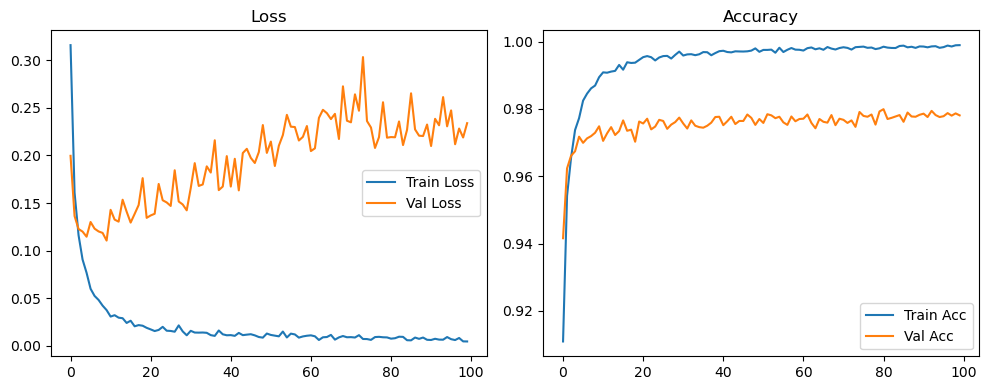

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3399, Acc: 0.9046 | Val Loss: 0.1895, Acc: 0.9455


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1940, Acc: 0.9449 | Val Loss: 0.1554, Acc: 0.9563


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1542, Acc: 0.9564 | Val Loss: 0.1177, Acc: 0.9664


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1274, Acc: 0.9633 | Val Loss: 0.1405, Acc: 0.9659


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1142, Acc: 0.9676 | Val Loss: 0.1185, Acc: 0.9698


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1021, Acc: 0.9718 | Val Loss: 0.1385, Acc: 0.9688


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0911, Acc: 0.9744 | Val Loss: 0.1349, Acc: 0.9706


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0799, Acc: 0.9774 | Val Loss: 0.1422, Acc: 0.9720


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0866, Acc: 0.9770 | Val Loss: 0.1478, Acc: 0.9706


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0734, Acc: 0.9812 | Val Loss: 0.1432, Acc: 0.9716


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0645, Acc: 0.9837 | Val Loss: 0.1693, Acc: 0.9695


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9834 | Val Loss: 0.1749, Acc: 0.9699


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0628, Acc: 0.9843 | Val Loss: 0.1625, Acc: 0.9732


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9855 | Val Loss: 0.1727, Acc: 0.9743


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9858 | Val Loss: 0.1573, Acc: 0.9778


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0550, Acc: 0.9867 | Val Loss: 0.1663, Acc: 0.9745


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0571, Acc: 0.9868 | Val Loss: 0.1881, Acc: 0.9741


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9868 | Val Loss: 0.1881, Acc: 0.9739


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9882 | Val Loss: 0.1980, Acc: 0.9733


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9892 | Val Loss: 0.2011, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0553, Acc: 0.9886 | Val Loss: 0.1973, Acc: 0.9714


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9898 | Val Loss: 0.2140, Acc: 0.9743


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9903 | Val Loss: 0.2208, Acc: 0.9752


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9898 | Val Loss: 0.2309, Acc: 0.9762


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9914 | Val Loss: 0.2754, Acc: 0.9758


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9902 | Val Loss: 0.2071, Acc: 0.9754


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9909 | Val Loss: 0.2349, Acc: 0.9770


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9917 | Val Loss: 0.2699, Acc: 0.9751


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9917 | Val Loss: 0.2702, Acc: 0.9730


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9925 | Val Loss: 0.2618, Acc: 0.9759


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9917 | Val Loss: 0.2521, Acc: 0.9775


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9932 | Val Loss: 0.2584, Acc: 0.9768


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9924 | Val Loss: 0.2392, Acc: 0.9764


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9933 | Val Loss: 0.2680, Acc: 0.9774


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9930 | Val Loss: 0.2416, Acc: 0.9763


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9927 | Val Loss: 0.2784, Acc: 0.9732


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9924 | Val Loss: 0.2500, Acc: 0.9771


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9938 | Val Loss: 0.2760, Acc: 0.9773


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9938 | Val Loss: 0.2479, Acc: 0.9765


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9935 | Val Loss: 0.3004, Acc: 0.9788


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9934 | Val Loss: 0.3053, Acc: 0.9768


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9937 | Val Loss: 0.3190, Acc: 0.9758


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9936 | Val Loss: 0.2914, Acc: 0.9782


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9929 | Val Loss: 0.3177, Acc: 0.9787


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9948 | Val Loss: 0.2859, Acc: 0.9772


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9947 | Val Loss: 0.3232, Acc: 0.9771


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9938 | Val Loss: 0.2797, Acc: 0.9777


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9942 | Val Loss: 0.3104, Acc: 0.9763


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9945 | Val Loss: 0.3379, Acc: 0.9774


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9942 | Val Loss: 0.3369, Acc: 0.9785


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9948 | Val Loss: 0.3327, Acc: 0.9768


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9947 | Val Loss: 0.2938, Acc: 0.9759


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9948 | Val Loss: 0.3526, Acc: 0.9768


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9945 | Val Loss: 0.3219, Acc: 0.9782


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9958 | Val Loss: 0.3313, Acc: 0.9771


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9948 | Val Loss: 0.3146, Acc: 0.9779


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9955 | Val Loss: 0.3216, Acc: 0.9768


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9949 | Val Loss: 0.3070, Acc: 0.9773


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9956 | Val Loss: 0.3903, Acc: 0.9792


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9950 | Val Loss: 0.3967, Acc: 0.9772


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9950 | Val Loss: 0.4109, Acc: 0.9777


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9954 | Val Loss: 0.3541, Acc: 0.9785


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9958 | Val Loss: 0.3457, Acc: 0.9776


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9949 | Val Loss: 0.3386, Acc: 0.9792


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9958 | Val Loss: 0.3655, Acc: 0.9789


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9952 | Val Loss: 0.4185, Acc: 0.9771


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9964 | Val Loss: 0.3971, Acc: 0.9765


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9961 | Val Loss: 0.3867, Acc: 0.9778


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9953 | Val Loss: 0.3443, Acc: 0.9789


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9960 | Val Loss: 0.4109, Acc: 0.9765


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9961 | Val Loss: 0.3914, Acc: 0.9791


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9961 | Val Loss: 0.3757, Acc: 0.9790


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9955 | Val Loss: 0.3031, Acc: 0.9785


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9965 | Val Loss: 0.3286, Acc: 0.9776


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9964 | Val Loss: 0.3563, Acc: 0.9783


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9962 | Val Loss: 0.3687, Acc: 0.9772


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9962 | Val Loss: 0.4201, Acc: 0.9768


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9955 | Val Loss: 0.3977, Acc: 0.9784


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9965 | Val Loss: 0.3931, Acc: 0.9782


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9970 | Val Loss: 0.3514, Acc: 0.9782


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9961 | Val Loss: 0.3953, Acc: 0.9772


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9960 | Val Loss: 0.3769, Acc: 0.9788


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9963 | Val Loss: 0.3809, Acc: 0.9805


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9965 | Val Loss: 0.4041, Acc: 0.9772


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9966 | Val Loss: 0.3861, Acc: 0.9782


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9961 | Val Loss: 0.4223, Acc: 0.9781


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9964 | Val Loss: 0.4055, Acc: 0.9780


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9965 | Val Loss: 0.4267, Acc: 0.9767


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9959 | Val Loss: 0.4743, Acc: 0.9777


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9969 | Val Loss: 0.5134, Acc: 0.9783


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9970 | Val Loss: 0.4671, Acc: 0.9768


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9967 | Val Loss: 0.4329, Acc: 0.9776


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9960 | Val Loss: 0.3744, Acc: 0.9785


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9969 | Val Loss: 0.3797, Acc: 0.9786


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9970 | Val Loss: 0.4101, Acc: 0.9788


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9975 | Val Loss: 0.4141, Acc: 0.9804


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9967 | Val Loss: 0.4016, Acc: 0.9790


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9968 | Val Loss: 0.4164, Acc: 0.9789


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9971 | Val Loss: 0.4121, Acc: 0.9788


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9970 | Val Loss: 0.4294, Acc: 0.9784


Final Test Loss: 0.3856 Accuracy: 0.9801


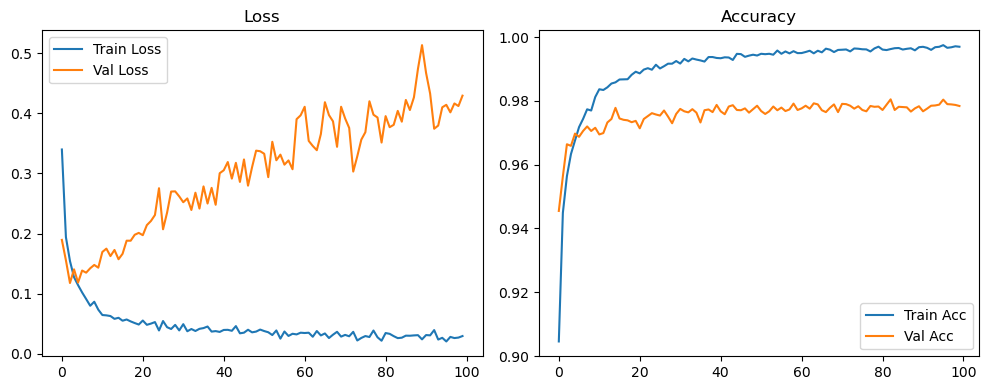

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4464, Acc: 0.8792 | Val Loss: 0.2048, Acc: 0.9421


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2969, Acc: 0.9189 | Val Loss: 0.1675, Acc: 0.9550


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2589, Acc: 0.9309 | Val Loss: 0.1440, Acc: 0.9626


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2401, Acc: 0.9373 | Val Loss: 0.1543, Acc: 0.9645


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2185, Acc: 0.9442 | Val Loss: 0.1395, Acc: 0.9669


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2099, Acc: 0.9485 | Val Loss: 0.1382, Acc: 0.9672


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1983, Acc: 0.9511 | Val Loss: 0.1428, Acc: 0.9663


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1930, Acc: 0.9547 | Val Loss: 0.1524, Acc: 0.9691


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1761, Acc: 0.9581 | Val Loss: 0.1375, Acc: 0.9742


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1825, Acc: 0.9593 | Val Loss: 0.1505, Acc: 0.9708


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1637, Acc: 0.9640 | Val Loss: 0.1478, Acc: 0.9703


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1563, Acc: 0.9650 | Val Loss: 0.1671, Acc: 0.9711


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1666, Acc: 0.9649 | Val Loss: 0.1619, Acc: 0.9722


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1553, Acc: 0.9676 | Val Loss: 0.1640, Acc: 0.9759


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1529, Acc: 0.9693 | Val Loss: 0.1741, Acc: 0.9748


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1555, Acc: 0.9689 | Val Loss: 0.1429, Acc: 0.9754


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1460, Acc: 0.9713 | Val Loss: 0.1691, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1460, Acc: 0.9719 | Val Loss: 0.1699, Acc: 0.9758


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1394, Acc: 0.9737 | Val Loss: 0.1892, Acc: 0.9752


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1430, Acc: 0.9749 | Val Loss: 0.2022, Acc: 0.9772


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1385, Acc: 0.9757 | Val Loss: 0.1810, Acc: 0.9745


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1351, Acc: 0.9755 | Val Loss: 0.1925, Acc: 0.9762


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1296, Acc: 0.9781 | Val Loss: 0.1828, Acc: 0.9770


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1409, Acc: 0.9764 | Val Loss: 0.2120, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1300, Acc: 0.9780 | Val Loss: 0.2163, Acc: 0.9781


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1360, Acc: 0.9785 | Val Loss: 0.2495, Acc: 0.9759


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1450, Acc: 0.9774 | Val Loss: 0.2343, Acc: 0.9781


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1172, Acc: 0.9804 | Val Loss: 0.2310, Acc: 0.9765


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1329, Acc: 0.9800 | Val Loss: 0.2294, Acc: 0.9775


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1261, Acc: 0.9810 | Val Loss: 0.2349, Acc: 0.9757


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1240, Acc: 0.9811 | Val Loss: 0.2481, Acc: 0.9792


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1233, Acc: 0.9820 | Val Loss: 0.2779, Acc: 0.9746


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1181, Acc: 0.9830 | Val Loss: 0.2665, Acc: 0.9760


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1237, Acc: 0.9824 | Val Loss: 0.2401, Acc: 0.9796


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.1198, Acc: 0.9824 | Val Loss: 0.2430, Acc: 0.9790


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.1155, Acc: 0.9831 | Val Loss: 0.2276, Acc: 0.9778


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.1138, Acc: 0.9835 | Val Loss: 0.2363, Acc: 0.9779


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1049, Acc: 0.9849 | Val Loss: 0.2226, Acc: 0.9797


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.1216, Acc: 0.9834 | Val Loss: 0.2413, Acc: 0.9797


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.1127, Acc: 0.9846 | Val Loss: 0.2587, Acc: 0.9808


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.1209, Acc: 0.9842 | Val Loss: 0.2701, Acc: 0.9788


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.1133, Acc: 0.9842 | Val Loss: 0.2913, Acc: 0.9788


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.1131, Acc: 0.9854 | Val Loss: 0.3085, Acc: 0.9776


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.1195, Acc: 0.9850 | Val Loss: 0.2860, Acc: 0.9777


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.1163, Acc: 0.9845 | Val Loss: 0.2967, Acc: 0.9778


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.1227, Acc: 0.9851 | Val Loss: 0.2998, Acc: 0.9792


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.1146, Acc: 0.9853 | Val Loss: 0.3425, Acc: 0.9770


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.1102, Acc: 0.9860 | Val Loss: 0.2737, Acc: 0.9799


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.1032, Acc: 0.9869 | Val Loss: 0.2847, Acc: 0.9802


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0942, Acc: 0.9877 | Val Loss: 0.3386, Acc: 0.9786


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.1163, Acc: 0.9865 | Val Loss: 0.3259, Acc: 0.9765


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.1160, Acc: 0.9866 | Val Loss: 0.2747, Acc: 0.9799


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.1024, Acc: 0.9880 | Val Loss: 0.3196, Acc: 0.9788


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.1130, Acc: 0.9869 | Val Loss: 0.3336, Acc: 0.9793


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.1072, Acc: 0.9879 | Val Loss: 0.3258, Acc: 0.9806


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.1072, Acc: 0.9879 | Val Loss: 0.3046, Acc: 0.9790


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.1203, Acc: 0.9862 | Val Loss: 0.3279, Acc: 0.9782


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0994, Acc: 0.9884 | Val Loss: 0.2911, Acc: 0.9788


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.1021, Acc: 0.9884 | Val Loss: 0.3195, Acc: 0.9812


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.1054, Acc: 0.9889 | Val Loss: 0.3331, Acc: 0.9792


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.1128, Acc: 0.9872 | Val Loss: 0.3279, Acc: 0.9802


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.1178, Acc: 0.9881 | Val Loss: 0.3364, Acc: 0.9809


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0962, Acc: 0.9884 | Val Loss: 0.3340, Acc: 0.9778


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0884, Acc: 0.9894 | Val Loss: 0.3628, Acc: 0.9782


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.1019, Acc: 0.9888 | Val Loss: 0.3468, Acc: 0.9798


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.1069, Acc: 0.9886 | Val Loss: 0.3793, Acc: 0.9799


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0995, Acc: 0.9892 | Val Loss: 0.3454, Acc: 0.9794


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.1067, Acc: 0.9889 | Val Loss: 0.3471, Acc: 0.9800


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.1005, Acc: 0.9894 | Val Loss: 0.3654, Acc: 0.9781


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.1120, Acc: 0.9888 | Val Loss: 0.4035, Acc: 0.9790


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.1044, Acc: 0.9887 | Val Loss: 0.3497, Acc: 0.9788


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0956, Acc: 0.9897 | Val Loss: 0.3648, Acc: 0.9791


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.1107, Acc: 0.9893 | Val Loss: 0.4050, Acc: 0.9806


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0943, Acc: 0.9902 | Val Loss: 0.3760, Acc: 0.9798


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0860, Acc: 0.9903 | Val Loss: 0.3736, Acc: 0.9800


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.1042, Acc: 0.9898 | Val Loss: 0.4152, Acc: 0.9776


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0951, Acc: 0.9907 | Val Loss: 0.4336, Acc: 0.9795


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.1077, Acc: 0.9897 | Val Loss: 0.4113, Acc: 0.9776


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0990, Acc: 0.9903 | Val Loss: 0.3941, Acc: 0.9805


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.1017, Acc: 0.9896 | Val Loss: 0.4052, Acc: 0.9783


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.1025, Acc: 0.9904 | Val Loss: 0.3855, Acc: 0.9811


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.1124, Acc: 0.9895 | Val Loss: 0.4059, Acc: 0.9792


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0975, Acc: 0.9909 | Val Loss: 0.4117, Acc: 0.9797


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0973, Acc: 0.9904 | Val Loss: 0.4271, Acc: 0.9788


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.1044, Acc: 0.9905 | Val Loss: 0.3295, Acc: 0.9811


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0870, Acc: 0.9907 | Val Loss: 0.3879, Acc: 0.9810


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.1035, Acc: 0.9906 | Val Loss: 0.4555, Acc: 0.9798


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0899, Acc: 0.9913 | Val Loss: 0.3932, Acc: 0.9804


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.1004, Acc: 0.9911 | Val Loss: 0.4072, Acc: 0.9805


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0894, Acc: 0.9912 | Val Loss: 0.4362, Acc: 0.9790


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0961, Acc: 0.9915 | Val Loss: 0.4005, Acc: 0.9808


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0952, Acc: 0.9910 | Val Loss: 0.3953, Acc: 0.9800


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0959, Acc: 0.9914 | Val Loss: 0.4312, Acc: 0.9802


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.1023, Acc: 0.9913 | Val Loss: 0.4231, Acc: 0.9794


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0945, Acc: 0.9916 | Val Loss: 0.4599, Acc: 0.9799


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0913, Acc: 0.9914 | Val Loss: 0.4337, Acc: 0.9802


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0989, Acc: 0.9911 | Val Loss: 0.4813, Acc: 0.9780


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0938, Acc: 0.9918 | Val Loss: 0.4631, Acc: 0.9788


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.1014, Acc: 0.9914 | Val Loss: 0.4335, Acc: 0.9799


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0925, Acc: 0.9920 | Val Loss: 0.4913, Acc: 0.9790


Final Test Loss: 0.4562 Accuracy: 0.9803


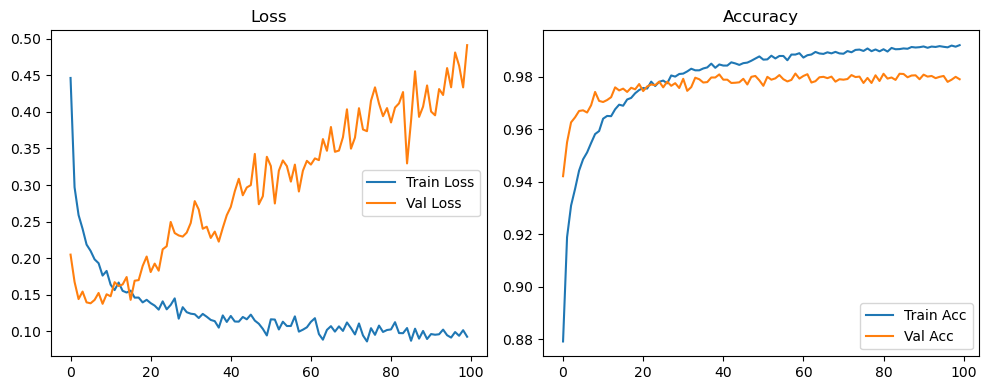

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3159, Acc: 0.9109 | Val Loss: 0.1996, Acc: 0.9416


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1611, Acc: 0.9542 | Val Loss: 0.1363, Acc: 0.9623


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1162, Acc: 0.9655 | Val Loss: 0.1227, Acc: 0.9661


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0906, Acc: 0.9737 | Val Loss: 0.1200, Acc: 0.9674


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0767, Acc: 0.9772 | Val Loss: 0.1146, Acc: 0.9718


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9825 | Val Loss: 0.1301, Acc: 0.9699


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9845 | Val Loss: 0.1231, Acc: 0.9712


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9861 | Val Loss: 0.1202, Acc: 0.9719


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9869 | Val Loss: 0.1186, Acc: 0.9729


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9894 | Val Loss: 0.1106, Acc: 0.9748


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9909 | Val Loss: 0.1429, Acc: 0.9705


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9908 | Val Loss: 0.1326, Acc: 0.9728


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9911 | Val Loss: 0.1304, Acc: 0.9746


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9913 | Val Loss: 0.1535, Acc: 0.9722


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9931 | Val Loss: 0.1409, Acc: 0.9734


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9916 | Val Loss: 0.1295, Acc: 0.9766


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9939 | Val Loss: 0.1386, Acc: 0.9735


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9936 | Val Loss: 0.1479, Acc: 0.9738


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9937 | Val Loss: 0.1761, Acc: 0.9702


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9946 | Val Loss: 0.1344, Acc: 0.9762


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9954 | Val Loss: 0.1369, Acc: 0.9757


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9957 | Val Loss: 0.1387, Acc: 0.9771


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9954 | Val Loss: 0.1701, Acc: 0.9739


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9944 | Val Loss: 0.1529, Acc: 0.9748


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9953 | Val Loss: 0.1506, Acc: 0.9768


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9957 | Val Loss: 0.1469, Acc: 0.9764


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9958 | Val Loss: 0.1844, Acc: 0.9741


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9950 | Val Loss: 0.1516, Acc: 0.9753


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9960 | Val Loss: 0.1485, Acc: 0.9761


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9970 | Val Loss: 0.1423, Acc: 0.9774


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9959 | Val Loss: 0.1656, Acc: 0.9757


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9962 | Val Loss: 0.1919, Acc: 0.9742


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9962 | Val Loss: 0.1680, Acc: 0.9766


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9960 | Val Loss: 0.1695, Acc: 0.9750


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9962 | Val Loss: 0.1885, Acc: 0.9746


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9969 | Val Loss: 0.1820, Acc: 0.9744


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.2159, Acc: 0.9750


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9959 | Val Loss: 0.1636, Acc: 0.9759


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9966 | Val Loss: 0.1673, Acc: 0.9776


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9971 | Val Loss: 0.1993, Acc: 0.9777


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9973 | Val Loss: 0.1673, Acc: 0.9752


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.1965, Acc: 0.9763


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9968 | Val Loss: 0.1633, Acc: 0.9777


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9971 | Val Loss: 0.2025, Acc: 0.9755


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9971 | Val Loss: 0.2070, Acc: 0.9764


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9970 | Val Loss: 0.1974, Acc: 0.9764


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9971 | Val Loss: 0.1921, Acc: 0.9783


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.2035, Acc: 0.9773


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9980 | Val Loss: 0.2319, Acc: 0.9752


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9970 | Val Loss: 0.2027, Acc: 0.9770


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9988 | Val Loss: 0.1815, Acc: 0.9798


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.1825, Acc: 0.9792


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1987, Acc: 0.9798


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1914, Acc: 0.9792


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9991 | Val Loss: 0.2281, Acc: 0.9772


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.2104, Acc: 0.9788


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.2095, Acc: 0.9780


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1942, Acc: 0.9792


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.2188, Acc: 0.9791


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9989 | Val Loss: 0.2365, Acc: 0.9778


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9991 | Val Loss: 0.2135, Acc: 0.9790


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.2089, Acc: 0.9797


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.2142, Acc: 0.9810


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9990 | Val Loss: 0.1966, Acc: 0.9807


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.2177, Acc: 0.9806


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9993 | Val Loss: 0.2392, Acc: 0.9792


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.2576, Acc: 0.9793


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.2204, Acc: 0.9805


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9996 | Val Loss: 0.2340, Acc: 0.9802


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.2603, Acc: 0.9775


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9992 | Val Loss: 0.2386, Acc: 0.9787


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.2369, Acc: 0.9803


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9994 | Val Loss: 0.2364, Acc: 0.9803


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9992 | Val Loss: 0.2266, Acc: 0.9800


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9996 | Val Loss: 0.2475, Acc: 0.9789


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.2307, Acc: 0.9797


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9992 | Val Loss: 0.2361, Acc: 0.9794


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.2382, Acc: 0.9795


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.2316, Acc: 0.9801


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9994 | Val Loss: 0.2520, Acc: 0.9772


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.2197, Acc: 0.9808


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.2232, Acc: 0.9807


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2253, Acc: 0.9809


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9998 | Val Loss: 0.2237, Acc: 0.9813


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2374, Acc: 0.9798


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2296, Acc: 0.9810


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2350, Acc: 0.9814


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2434, Acc: 0.9807


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2499, Acc: 0.9809


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.2541, Acc: 0.9806


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2502, Acc: 0.9815


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.2398, Acc: 0.9822


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2314, Acc: 0.9818


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.2408, Acc: 0.9818


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2554, Acc: 0.9818


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2528, Acc: 0.9810


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.2475, Acc: 0.9811


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2563, Acc: 0.9822


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2579, Acc: 0.9818


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9999 | Val Loss: 0.2600, Acc: 0.9810


Final Test Loss: 0.2492 Accuracy: 0.9812


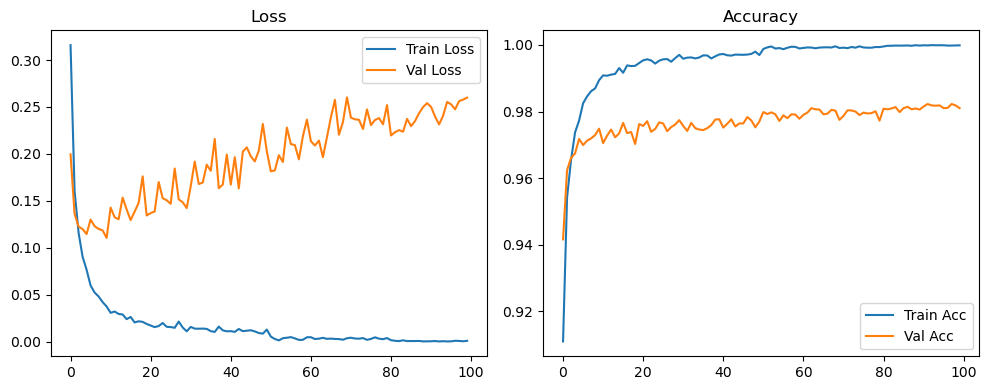

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3399, Acc: 0.9046 | Val Loss: 0.1895, Acc: 0.9455


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1940, Acc: 0.9449 | Val Loss: 0.1554, Acc: 0.9563


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1542, Acc: 0.9564 | Val Loss: 0.1177, Acc: 0.9664


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1274, Acc: 0.9633 | Val Loss: 0.1405, Acc: 0.9659


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1142, Acc: 0.9676 | Val Loss: 0.1185, Acc: 0.9698


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1021, Acc: 0.9718 | Val Loss: 0.1385, Acc: 0.9688


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0911, Acc: 0.9744 | Val Loss: 0.1349, Acc: 0.9706


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0799, Acc: 0.9774 | Val Loss: 0.1422, Acc: 0.9720


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0866, Acc: 0.9770 | Val Loss: 0.1478, Acc: 0.9706


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0734, Acc: 0.9812 | Val Loss: 0.1432, Acc: 0.9716


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0645, Acc: 0.9837 | Val Loss: 0.1693, Acc: 0.9695


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9834 | Val Loss: 0.1749, Acc: 0.9699


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0628, Acc: 0.9843 | Val Loss: 0.1625, Acc: 0.9732


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9855 | Val Loss: 0.1727, Acc: 0.9743


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9858 | Val Loss: 0.1573, Acc: 0.9778


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0550, Acc: 0.9867 | Val Loss: 0.1663, Acc: 0.9745


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0571, Acc: 0.9868 | Val Loss: 0.1881, Acc: 0.9741


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9868 | Val Loss: 0.1881, Acc: 0.9739


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9882 | Val Loss: 0.1980, Acc: 0.9733


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9892 | Val Loss: 0.2011, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0553, Acc: 0.9886 | Val Loss: 0.1973, Acc: 0.9714


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9898 | Val Loss: 0.2140, Acc: 0.9743


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9903 | Val Loss: 0.2208, Acc: 0.9752


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9898 | Val Loss: 0.2309, Acc: 0.9762


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9914 | Val Loss: 0.2754, Acc: 0.9758


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9902 | Val Loss: 0.2071, Acc: 0.9754


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9909 | Val Loss: 0.2349, Acc: 0.9770


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9917 | Val Loss: 0.2699, Acc: 0.9751


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9917 | Val Loss: 0.2702, Acc: 0.9730


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9925 | Val Loss: 0.2618, Acc: 0.9759


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9917 | Val Loss: 0.2521, Acc: 0.9775


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9932 | Val Loss: 0.2584, Acc: 0.9768


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9924 | Val Loss: 0.2392, Acc: 0.9764


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9933 | Val Loss: 0.2680, Acc: 0.9774


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9930 | Val Loss: 0.2416, Acc: 0.9763


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9927 | Val Loss: 0.2784, Acc: 0.9732


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9924 | Val Loss: 0.2500, Acc: 0.9771


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9938 | Val Loss: 0.2760, Acc: 0.9773


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9938 | Val Loss: 0.2479, Acc: 0.9765


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9935 | Val Loss: 0.3004, Acc: 0.9788


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9934 | Val Loss: 0.3053, Acc: 0.9768


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9937 | Val Loss: 0.3190, Acc: 0.9758


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9936 | Val Loss: 0.2914, Acc: 0.9782


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9929 | Val Loss: 0.3177, Acc: 0.9787


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9948 | Val Loss: 0.2859, Acc: 0.9772


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9947 | Val Loss: 0.3232, Acc: 0.9771


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9938 | Val Loss: 0.2797, Acc: 0.9777


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9942 | Val Loss: 0.3104, Acc: 0.9763


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9945 | Val Loss: 0.3379, Acc: 0.9774


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9942 | Val Loss: 0.3369, Acc: 0.9785


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9967 | Val Loss: 0.2756, Acc: 0.9788


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9977 | Val Loss: 0.2694, Acc: 0.9791


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9978 | Val Loss: 0.2536, Acc: 0.9803


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9977 | Val Loss: 0.2901, Acc: 0.9801


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9975 | Val Loss: 0.3095, Acc: 0.9804


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9980 | Val Loss: 0.3108, Acc: 0.9808


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9975 | Val Loss: 0.3209, Acc: 0.9792


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9979 | Val Loss: 0.3611, Acc: 0.9798


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9982 | Val Loss: 0.3061, Acc: 0.9791


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9978 | Val Loss: 0.3117, Acc: 0.9799


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9980 | Val Loss: 0.3098, Acc: 0.9803


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9981 | Val Loss: 0.3072, Acc: 0.9791


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9981 | Val Loss: 0.3016, Acc: 0.9804


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9982 | Val Loss: 0.3219, Acc: 0.9791


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9984 | Val Loss: 0.3224, Acc: 0.9797


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9979 | Val Loss: 0.3959, Acc: 0.9782


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9985 | Val Loss: 0.3572, Acc: 0.9815


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9978 | Val Loss: 0.3460, Acc: 0.9809


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9981 | Val Loss: 0.3808, Acc: 0.9798


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9981 | Val Loss: 0.3575, Acc: 0.9809


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9982 | Val Loss: 0.3583, Acc: 0.9802


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9982 | Val Loss: 0.3517, Acc: 0.9804


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9985 | Val Loss: 0.3638, Acc: 0.9805


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9980 | Val Loss: 0.3595, Acc: 0.9785


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9982 | Val Loss: 0.3630, Acc: 0.9788


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9984 | Val Loss: 0.3505, Acc: 0.9813


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9981 | Val Loss: 0.4061, Acc: 0.9768


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9981 | Val Loss: 0.3834, Acc: 0.9792


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9981 | Val Loss: 0.3677, Acc: 0.9814


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9982 | Val Loss: 0.3906, Acc: 0.9782


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9989 | Val Loss: 0.3258, Acc: 0.9815


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9991 | Val Loss: 0.3396, Acc: 0.9818


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9993 | Val Loss: 0.3359, Acc: 0.9817


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9991 | Val Loss: 0.3201, Acc: 0.9812


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9992 | Val Loss: 0.3299, Acc: 0.9824


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9992 | Val Loss: 0.3397, Acc: 0.9813


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9991 | Val Loss: 0.3273, Acc: 0.9813


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.3344, Acc: 0.9814


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.3497, Acc: 0.9831


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9994 | Val Loss: 0.3730, Acc: 0.9814


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9994 | Val Loss: 0.3514, Acc: 0.9816


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9994 | Val Loss: 0.3677, Acc: 0.9815


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9994 | Val Loss: 0.3516, Acc: 0.9822


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9996 | Val Loss: 0.3584, Acc: 0.9818


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9994 | Val Loss: 0.3478, Acc: 0.9827


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9994 | Val Loss: 0.3568, Acc: 0.9831


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9991 | Val Loss: 0.3741, Acc: 0.9812


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9995 | Val Loss: 0.3858, Acc: 0.9814


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9994 | Val Loss: 0.3967, Acc: 0.9817


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9996 | Val Loss: 0.3950, Acc: 0.9810


Final Test Loss: 0.3712 Accuracy: 0.9817


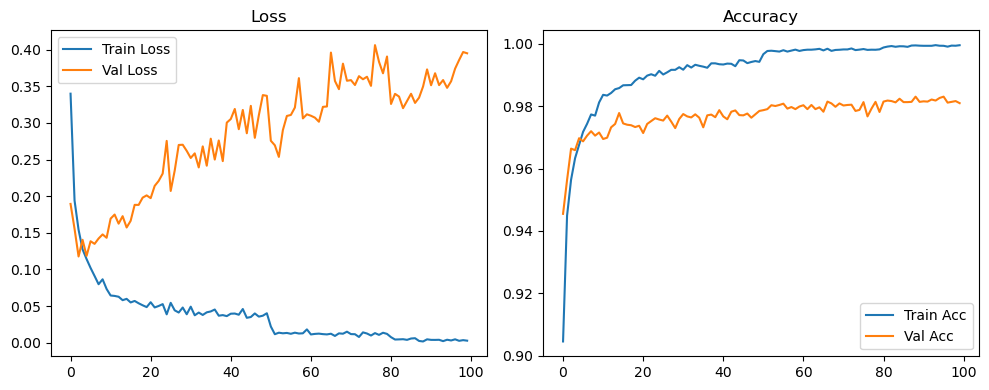

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4464, Acc: 0.8792 | Val Loss: 0.2048, Acc: 0.9421


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2969, Acc: 0.9189 | Val Loss: 0.1675, Acc: 0.9550


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2589, Acc: 0.9309 | Val Loss: 0.1440, Acc: 0.9626


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2401, Acc: 0.9373 | Val Loss: 0.1543, Acc: 0.9645


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2185, Acc: 0.9442 | Val Loss: 0.1395, Acc: 0.9669


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2099, Acc: 0.9485 | Val Loss: 0.1382, Acc: 0.9672


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1983, Acc: 0.9511 | Val Loss: 0.1428, Acc: 0.9663


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1930, Acc: 0.9547 | Val Loss: 0.1524, Acc: 0.9691


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1761, Acc: 0.9581 | Val Loss: 0.1375, Acc: 0.9742


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1825, Acc: 0.9593 | Val Loss: 0.1505, Acc: 0.9708


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1637, Acc: 0.9640 | Val Loss: 0.1478, Acc: 0.9703


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1563, Acc: 0.9650 | Val Loss: 0.1671, Acc: 0.9711


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1666, Acc: 0.9649 | Val Loss: 0.1619, Acc: 0.9722


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1553, Acc: 0.9676 | Val Loss: 0.1640, Acc: 0.9759


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1529, Acc: 0.9693 | Val Loss: 0.1741, Acc: 0.9748


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1555, Acc: 0.9689 | Val Loss: 0.1429, Acc: 0.9754


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1460, Acc: 0.9713 | Val Loss: 0.1691, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1460, Acc: 0.9719 | Val Loss: 0.1699, Acc: 0.9758


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1394, Acc: 0.9737 | Val Loss: 0.1892, Acc: 0.9752


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1430, Acc: 0.9749 | Val Loss: 0.2022, Acc: 0.9772


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1385, Acc: 0.9757 | Val Loss: 0.1810, Acc: 0.9745


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1351, Acc: 0.9755 | Val Loss: 0.1925, Acc: 0.9762


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1296, Acc: 0.9781 | Val Loss: 0.1828, Acc: 0.9770


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1409, Acc: 0.9764 | Val Loss: 0.2120, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1300, Acc: 0.9780 | Val Loss: 0.2163, Acc: 0.9781


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1360, Acc: 0.9785 | Val Loss: 0.2495, Acc: 0.9759


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1450, Acc: 0.9774 | Val Loss: 0.2343, Acc: 0.9781


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1172, Acc: 0.9804 | Val Loss: 0.2310, Acc: 0.9765


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1329, Acc: 0.9800 | Val Loss: 0.2294, Acc: 0.9775


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1261, Acc: 0.9810 | Val Loss: 0.2349, Acc: 0.9757


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1240, Acc: 0.9811 | Val Loss: 0.2481, Acc: 0.9792


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1233, Acc: 0.9820 | Val Loss: 0.2779, Acc: 0.9746


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1181, Acc: 0.9830 | Val Loss: 0.2665, Acc: 0.9760


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1237, Acc: 0.9824 | Val Loss: 0.2401, Acc: 0.9796


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.1198, Acc: 0.9824 | Val Loss: 0.2430, Acc: 0.9790


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.1155, Acc: 0.9831 | Val Loss: 0.2276, Acc: 0.9778


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.1138, Acc: 0.9835 | Val Loss: 0.2363, Acc: 0.9779


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1049, Acc: 0.9849 | Val Loss: 0.2226, Acc: 0.9797


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.1216, Acc: 0.9834 | Val Loss: 0.2413, Acc: 0.9797


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.1127, Acc: 0.9846 | Val Loss: 0.2587, Acc: 0.9808


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.1209, Acc: 0.9842 | Val Loss: 0.2701, Acc: 0.9788


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.1133, Acc: 0.9842 | Val Loss: 0.2913, Acc: 0.9788


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.1131, Acc: 0.9854 | Val Loss: 0.3085, Acc: 0.9776


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.1195, Acc: 0.9850 | Val Loss: 0.2860, Acc: 0.9777


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.1163, Acc: 0.9845 | Val Loss: 0.2967, Acc: 0.9778


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.1227, Acc: 0.9851 | Val Loss: 0.2998, Acc: 0.9792


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.1146, Acc: 0.9853 | Val Loss: 0.3425, Acc: 0.9770


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.1102, Acc: 0.9860 | Val Loss: 0.2737, Acc: 0.9799


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.1032, Acc: 0.9869 | Val Loss: 0.2847, Acc: 0.9802


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0942, Acc: 0.9877 | Val Loss: 0.3386, Acc: 0.9786


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0807, Acc: 0.9898 | Val Loss: 0.2979, Acc: 0.9791


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0665, Acc: 0.9907 | Val Loss: 0.2529, Acc: 0.9801


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0566, Acc: 0.9914 | Val Loss: 0.2879, Acc: 0.9808


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9925 | Val Loss: 0.2753, Acc: 0.9809


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0557, Acc: 0.9918 | Val Loss: 0.2811, Acc: 0.9808


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0491, Acc: 0.9934 | Val Loss: 0.2850, Acc: 0.9820


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0531, Acc: 0.9931 | Val Loss: 0.2797, Acc: 0.9808


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0460, Acc: 0.9930 | Val Loss: 0.2830, Acc: 0.9818


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9933 | Val Loss: 0.2849, Acc: 0.9828


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9935 | Val Loss: 0.2822, Acc: 0.9807


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9927 | Val Loss: 0.2868, Acc: 0.9807


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9935 | Val Loss: 0.3275, Acc: 0.9810


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0479, Acc: 0.9936 | Val Loss: 0.3112, Acc: 0.9812


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9935 | Val Loss: 0.3015, Acc: 0.9808


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0493, Acc: 0.9938 | Val Loss: 0.2994, Acc: 0.9809


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0471, Acc: 0.9938 | Val Loss: 0.3171, Acc: 0.9832


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9941 | Val Loss: 0.3141, Acc: 0.9811


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9941 | Val Loss: 0.3129, Acc: 0.9820


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0490, Acc: 0.9940 | Val Loss: 0.3442, Acc: 0.9808


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9942 | Val Loss: 0.3123, Acc: 0.9822


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9942 | Val Loss: 0.3212, Acc: 0.9821


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9938 | Val Loss: 0.3451, Acc: 0.9801


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9943 | Val Loss: 0.3331, Acc: 0.9818


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0489, Acc: 0.9937 | Val Loss: 0.3451, Acc: 0.9819


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9944 | Val Loss: 0.3431, Acc: 0.9825


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0446, Acc: 0.9945 | Val Loss: 0.3406, Acc: 0.9822


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9944 | Val Loss: 0.3301, Acc: 0.9825


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0439, Acc: 0.9940 | Val Loss: 0.3401, Acc: 0.9818


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0438, Acc: 0.9945 | Val Loss: 0.3389, Acc: 0.9832


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9947 | Val Loss: 0.3240, Acc: 0.9819


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9955 | Val Loss: 0.2936, Acc: 0.9832


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9956 | Val Loss: 0.2884, Acc: 0.9832


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9956 | Val Loss: 0.3165, Acc: 0.9831


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9962 | Val Loss: 0.2914, Acc: 0.9825


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9955 | Val Loss: 0.2884, Acc: 0.9832


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9967 | Val Loss: 0.2984, Acc: 0.9827


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9959 | Val Loss: 0.3087, Acc: 0.9823


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9969 | Val Loss: 0.2971, Acc: 0.9832


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9971 | Val Loss: 0.2971, Acc: 0.9826


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9966 | Val Loss: 0.3308, Acc: 0.9828


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9970 | Val Loss: 0.3154, Acc: 0.9830


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9968 | Val Loss: 0.3205, Acc: 0.9828


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9967 | Val Loss: 0.3282, Acc: 0.9840


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9971 | Val Loss: 0.3112, Acc: 0.9833


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9969 | Val Loss: 0.3358, Acc: 0.9828


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9972 | Val Loss: 0.3143, Acc: 0.9846


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9971 | Val Loss: 0.3165, Acc: 0.9825


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9969 | Val Loss: 0.3328, Acc: 0.9828


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9971 | Val Loss: 0.3502, Acc: 0.9827


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9971 | Val Loss: 0.3508, Acc: 0.9832


Final Test Loss: 0.2932 Accuracy: 0.9839


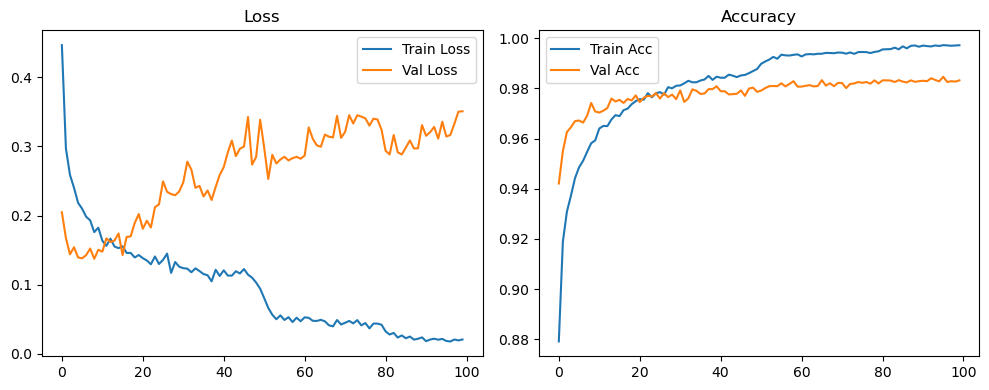

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3159, Acc: 0.9109 | Val Loss: 0.1996, Acc: 0.9416


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1611, Acc: 0.9542 | Val Loss: 0.1363, Acc: 0.9623


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1162, Acc: 0.9655 | Val Loss: 0.1227, Acc: 0.9661


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0906, Acc: 0.9737 | Val Loss: 0.1200, Acc: 0.9674


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0767, Acc: 0.9772 | Val Loss: 0.1146, Acc: 0.9718


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9825 | Val Loss: 0.1301, Acc: 0.9699


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9845 | Val Loss: 0.1231, Acc: 0.9712


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9861 | Val Loss: 0.1202, Acc: 0.9719


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9869 | Val Loss: 0.1186, Acc: 0.9729


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9894 | Val Loss: 0.1106, Acc: 0.9748


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9909 | Val Loss: 0.1429, Acc: 0.9705


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9908 | Val Loss: 0.1326, Acc: 0.9728


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9911 | Val Loss: 0.1304, Acc: 0.9746


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9913 | Val Loss: 0.1535, Acc: 0.9722


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9931 | Val Loss: 0.1409, Acc: 0.9734


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9916 | Val Loss: 0.1295, Acc: 0.9766


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9939 | Val Loss: 0.1386, Acc: 0.9735


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9936 | Val Loss: 0.1479, Acc: 0.9738


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9937 | Val Loss: 0.1761, Acc: 0.9702


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9946 | Val Loss: 0.1344, Acc: 0.9762


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9954 | Val Loss: 0.1369, Acc: 0.9757


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9957 | Val Loss: 0.1387, Acc: 0.9771


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9954 | Val Loss: 0.1701, Acc: 0.9739


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9944 | Val Loss: 0.1529, Acc: 0.9748


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9953 | Val Loss: 0.1506, Acc: 0.9768


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9957 | Val Loss: 0.1469, Acc: 0.9764


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9958 | Val Loss: 0.1844, Acc: 0.9741


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9950 | Val Loss: 0.1516, Acc: 0.9753


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9960 | Val Loss: 0.1485, Acc: 0.9761


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9970 | Val Loss: 0.1423, Acc: 0.9774


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9959 | Val Loss: 0.1656, Acc: 0.9757


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9962 | Val Loss: 0.1919, Acc: 0.9742


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9962 | Val Loss: 0.1680, Acc: 0.9766


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9960 | Val Loss: 0.1695, Acc: 0.9750


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9962 | Val Loss: 0.1885, Acc: 0.9746


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9969 | Val Loss: 0.1820, Acc: 0.9744


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.2159, Acc: 0.9750


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9959 | Val Loss: 0.1636, Acc: 0.9759


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9966 | Val Loss: 0.1673, Acc: 0.9776


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9971 | Val Loss: 0.1993, Acc: 0.9777


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9973 | Val Loss: 0.1673, Acc: 0.9752


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.1965, Acc: 0.9763


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9968 | Val Loss: 0.1633, Acc: 0.9777


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9971 | Val Loss: 0.2025, Acc: 0.9755


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9971 | Val Loss: 0.2070, Acc: 0.9764


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9970 | Val Loss: 0.1974, Acc: 0.9764


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9971 | Val Loss: 0.1921, Acc: 0.9783


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.2035, Acc: 0.9773


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9980 | Val Loss: 0.2319, Acc: 0.9752


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9970 | Val Loss: 0.2027, Acc: 0.9770


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9988 | Val Loss: 0.1815, Acc: 0.9798


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.1825, Acc: 0.9792


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1987, Acc: 0.9798


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1914, Acc: 0.9792


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9991 | Val Loss: 0.2281, Acc: 0.9772


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.2104, Acc: 0.9788


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.2095, Acc: 0.9780


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1942, Acc: 0.9792


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.2188, Acc: 0.9791


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9989 | Val Loss: 0.2365, Acc: 0.9778


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9991 | Val Loss: 0.2135, Acc: 0.9790


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.2089, Acc: 0.9797


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.2142, Acc: 0.9810


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9990 | Val Loss: 0.1966, Acc: 0.9807


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.2177, Acc: 0.9806


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9993 | Val Loss: 0.2392, Acc: 0.9792


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.2576, Acc: 0.9793


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.2204, Acc: 0.9805


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9996 | Val Loss: 0.2340, Acc: 0.9802


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.2603, Acc: 0.9775


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9992 | Val Loss: 0.2386, Acc: 0.9787


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.2369, Acc: 0.9803


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9994 | Val Loss: 0.2364, Acc: 0.9803


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9992 | Val Loss: 0.2266, Acc: 0.9800


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9996 | Val Loss: 0.2475, Acc: 0.9789


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.2307, Acc: 0.9797


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9992 | Val Loss: 0.2361, Acc: 0.9794


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.2382, Acc: 0.9795


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.2316, Acc: 0.9801


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9994 | Val Loss: 0.2520, Acc: 0.9772


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.2266, Acc: 0.9798


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.2181, Acc: 0.9808


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2241, Acc: 0.9805


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.2174, Acc: 0.9812


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2211, Acc: 0.9798


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2174, Acc: 0.9810


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2169, Acc: 0.9812


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2166, Acc: 0.9815


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2216, Acc: 0.9819


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2222, Acc: 0.9811


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2234, Acc: 0.9812


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2278, Acc: 0.9813


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2231, Acc: 0.9819


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2193, Acc: 0.9818


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2283, Acc: 0.9817


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2204, Acc: 0.9817


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2351, Acc: 0.9810


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2294, Acc: 0.9824


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.2320, Acc: 0.9822


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.2418, Acc: 0.9815


Final Test Loss: 0.2362 Accuracy: 0.9817


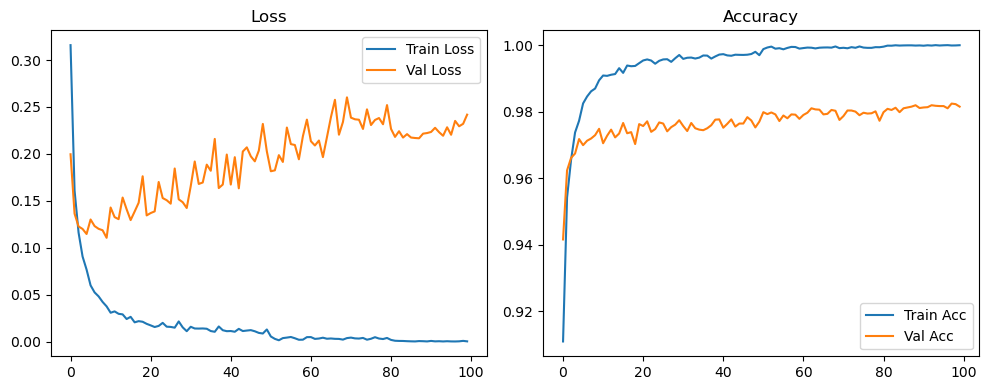

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3399, Acc: 0.9046 | Val Loss: 0.1895, Acc: 0.9455


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1940, Acc: 0.9449 | Val Loss: 0.1554, Acc: 0.9563


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1542, Acc: 0.9564 | Val Loss: 0.1177, Acc: 0.9664


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1274, Acc: 0.9633 | Val Loss: 0.1405, Acc: 0.9659


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1142, Acc: 0.9676 | Val Loss: 0.1185, Acc: 0.9698


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1021, Acc: 0.9718 | Val Loss: 0.1385, Acc: 0.9688


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0911, Acc: 0.9744 | Val Loss: 0.1349, Acc: 0.9706


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0799, Acc: 0.9774 | Val Loss: 0.1422, Acc: 0.9720


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0866, Acc: 0.9770 | Val Loss: 0.1478, Acc: 0.9706


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0734, Acc: 0.9812 | Val Loss: 0.1432, Acc: 0.9716


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0645, Acc: 0.9837 | Val Loss: 0.1693, Acc: 0.9695


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9834 | Val Loss: 0.1749, Acc: 0.9699


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0628, Acc: 0.9843 | Val Loss: 0.1625, Acc: 0.9732


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9855 | Val Loss: 0.1727, Acc: 0.9743


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9858 | Val Loss: 0.1573, Acc: 0.9778


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0550, Acc: 0.9867 | Val Loss: 0.1663, Acc: 0.9745


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0571, Acc: 0.9868 | Val Loss: 0.1881, Acc: 0.9741


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9868 | Val Loss: 0.1881, Acc: 0.9739


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9882 | Val Loss: 0.1980, Acc: 0.9733


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9892 | Val Loss: 0.2011, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0553, Acc: 0.9886 | Val Loss: 0.1973, Acc: 0.9714


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9898 | Val Loss: 0.2140, Acc: 0.9743


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9903 | Val Loss: 0.2208, Acc: 0.9752


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9898 | Val Loss: 0.2309, Acc: 0.9762


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9914 | Val Loss: 0.2754, Acc: 0.9758


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9902 | Val Loss: 0.2071, Acc: 0.9754


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9909 | Val Loss: 0.2349, Acc: 0.9770


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9917 | Val Loss: 0.2699, Acc: 0.9751


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9917 | Val Loss: 0.2702, Acc: 0.9730


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9925 | Val Loss: 0.2618, Acc: 0.9759


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9917 | Val Loss: 0.2521, Acc: 0.9775


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9932 | Val Loss: 0.2584, Acc: 0.9768


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9924 | Val Loss: 0.2392, Acc: 0.9764


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9933 | Val Loss: 0.2680, Acc: 0.9774


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9930 | Val Loss: 0.2416, Acc: 0.9763


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9927 | Val Loss: 0.2784, Acc: 0.9732


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9924 | Val Loss: 0.2500, Acc: 0.9771


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9938 | Val Loss: 0.2760, Acc: 0.9773


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9938 | Val Loss: 0.2479, Acc: 0.9765


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9935 | Val Loss: 0.3004, Acc: 0.9788


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9934 | Val Loss: 0.3053, Acc: 0.9768


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9937 | Val Loss: 0.3190, Acc: 0.9758


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9936 | Val Loss: 0.2914, Acc: 0.9782


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9929 | Val Loss: 0.3177, Acc: 0.9787


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9948 | Val Loss: 0.2859, Acc: 0.9772


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9947 | Val Loss: 0.3232, Acc: 0.9771


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9938 | Val Loss: 0.2797, Acc: 0.9777


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9942 | Val Loss: 0.3104, Acc: 0.9763


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9945 | Val Loss: 0.3379, Acc: 0.9774


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9942 | Val Loss: 0.3369, Acc: 0.9785


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9967 | Val Loss: 0.2756, Acc: 0.9788


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9977 | Val Loss: 0.2694, Acc: 0.9791


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9978 | Val Loss: 0.2536, Acc: 0.9803


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9977 | Val Loss: 0.2901, Acc: 0.9801


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9975 | Val Loss: 0.3095, Acc: 0.9804


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9980 | Val Loss: 0.3108, Acc: 0.9808


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9975 | Val Loss: 0.3209, Acc: 0.9792


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9979 | Val Loss: 0.3611, Acc: 0.9798


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9982 | Val Loss: 0.3061, Acc: 0.9791


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9978 | Val Loss: 0.3117, Acc: 0.9799


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9980 | Val Loss: 0.3098, Acc: 0.9803


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9981 | Val Loss: 0.3072, Acc: 0.9791


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9981 | Val Loss: 0.3016, Acc: 0.9804


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9982 | Val Loss: 0.3219, Acc: 0.9791


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9984 | Val Loss: 0.3224, Acc: 0.9797


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9979 | Val Loss: 0.3959, Acc: 0.9782


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9985 | Val Loss: 0.3572, Acc: 0.9815


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9978 | Val Loss: 0.3460, Acc: 0.9809


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9981 | Val Loss: 0.3808, Acc: 0.9798


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9981 | Val Loss: 0.3575, Acc: 0.9809


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9982 | Val Loss: 0.3583, Acc: 0.9802


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9982 | Val Loss: 0.3517, Acc: 0.9804


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9985 | Val Loss: 0.3638, Acc: 0.9805


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9980 | Val Loss: 0.3595, Acc: 0.9785


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9982 | Val Loss: 0.3630, Acc: 0.9788


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9984 | Val Loss: 0.3505, Acc: 0.9813


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9981 | Val Loss: 0.4061, Acc: 0.9768


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9981 | Val Loss: 0.3834, Acc: 0.9792


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9981 | Val Loss: 0.3677, Acc: 0.9814


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9982 | Val Loss: 0.3906, Acc: 0.9782


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9988 | Val Loss: 0.3296, Acc: 0.9818


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9993 | Val Loss: 0.3268, Acc: 0.9820


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9994 | Val Loss: 0.3333, Acc: 0.9812


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9994 | Val Loss: 0.3264, Acc: 0.9819


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9993 | Val Loss: 0.3264, Acc: 0.9819


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9994 | Val Loss: 0.3322, Acc: 0.9817


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9993 | Val Loss: 0.3284, Acc: 0.9818


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.3281, Acc: 0.9814


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9996 | Val Loss: 0.3334, Acc: 0.9819


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9994 | Val Loss: 0.3401, Acc: 0.9823


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.3359, Acc: 0.9823


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.3281, Acc: 0.9829


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9994 | Val Loss: 0.3306, Acc: 0.9833


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9996 | Val Loss: 0.3209, Acc: 0.9833


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.3307, Acc: 0.9836


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9996 | Val Loss: 0.3398, Acc: 0.9828


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.3387, Acc: 0.9831


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9997 | Val Loss: 0.3402, Acc: 0.9834


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.3323, Acc: 0.9833


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.3405, Acc: 0.9822


Final Test Loss: 0.3529 Accuracy: 0.9834


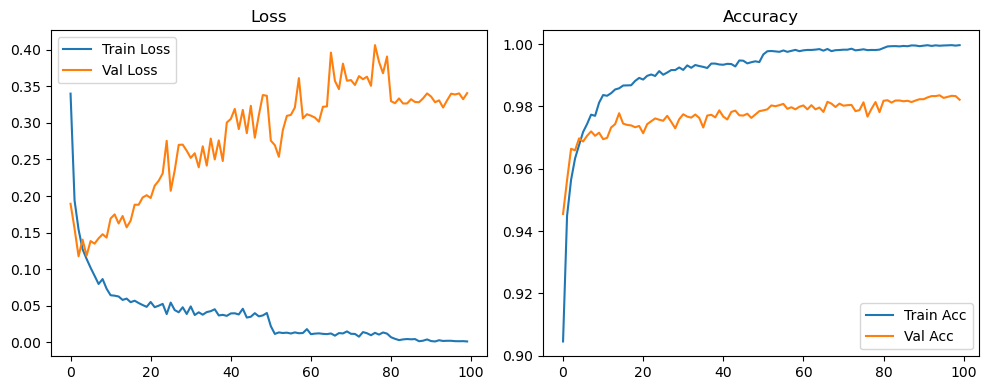

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4464, Acc: 0.8792 | Val Loss: 0.2048, Acc: 0.9421


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2969, Acc: 0.9189 | Val Loss: 0.1675, Acc: 0.9550


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2589, Acc: 0.9309 | Val Loss: 0.1440, Acc: 0.9626


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2401, Acc: 0.9373 | Val Loss: 0.1543, Acc: 0.9645


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2185, Acc: 0.9442 | Val Loss: 0.1395, Acc: 0.9669


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2099, Acc: 0.9485 | Val Loss: 0.1382, Acc: 0.9672


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1983, Acc: 0.9511 | Val Loss: 0.1428, Acc: 0.9663


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1930, Acc: 0.9547 | Val Loss: 0.1524, Acc: 0.9691


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1761, Acc: 0.9581 | Val Loss: 0.1375, Acc: 0.9742


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1825, Acc: 0.9593 | Val Loss: 0.1505, Acc: 0.9708


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1637, Acc: 0.9640 | Val Loss: 0.1478, Acc: 0.9703


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1563, Acc: 0.9650 | Val Loss: 0.1671, Acc: 0.9711


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1666, Acc: 0.9649 | Val Loss: 0.1619, Acc: 0.9722


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1553, Acc: 0.9676 | Val Loss: 0.1640, Acc: 0.9759


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1529, Acc: 0.9693 | Val Loss: 0.1741, Acc: 0.9748


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1555, Acc: 0.9689 | Val Loss: 0.1429, Acc: 0.9754


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1460, Acc: 0.9713 | Val Loss: 0.1691, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1460, Acc: 0.9719 | Val Loss: 0.1699, Acc: 0.9758


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1394, Acc: 0.9737 | Val Loss: 0.1892, Acc: 0.9752


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1430, Acc: 0.9749 | Val Loss: 0.2022, Acc: 0.9772


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1385, Acc: 0.9757 | Val Loss: 0.1810, Acc: 0.9745


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1351, Acc: 0.9755 | Val Loss: 0.1925, Acc: 0.9762


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1296, Acc: 0.9781 | Val Loss: 0.1828, Acc: 0.9770


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1409, Acc: 0.9764 | Val Loss: 0.2120, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1300, Acc: 0.9780 | Val Loss: 0.2163, Acc: 0.9781


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1360, Acc: 0.9785 | Val Loss: 0.2495, Acc: 0.9759


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1450, Acc: 0.9774 | Val Loss: 0.2343, Acc: 0.9781


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1172, Acc: 0.9804 | Val Loss: 0.2310, Acc: 0.9765


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1329, Acc: 0.9800 | Val Loss: 0.2294, Acc: 0.9775


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1261, Acc: 0.9810 | Val Loss: 0.2349, Acc: 0.9757


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1240, Acc: 0.9811 | Val Loss: 0.2481, Acc: 0.9792


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1233, Acc: 0.9820 | Val Loss: 0.2779, Acc: 0.9746


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1181, Acc: 0.9830 | Val Loss: 0.2665, Acc: 0.9760


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1237, Acc: 0.9824 | Val Loss: 0.2401, Acc: 0.9796


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.1198, Acc: 0.9824 | Val Loss: 0.2430, Acc: 0.9790


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.1155, Acc: 0.9831 | Val Loss: 0.2276, Acc: 0.9778


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.1138, Acc: 0.9835 | Val Loss: 0.2363, Acc: 0.9779


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1049, Acc: 0.9849 | Val Loss: 0.2226, Acc: 0.9797


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.1216, Acc: 0.9834 | Val Loss: 0.2413, Acc: 0.9797


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.1127, Acc: 0.9846 | Val Loss: 0.2587, Acc: 0.9808


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.1209, Acc: 0.9842 | Val Loss: 0.2701, Acc: 0.9788


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.1133, Acc: 0.9842 | Val Loss: 0.2913, Acc: 0.9788


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.1131, Acc: 0.9854 | Val Loss: 0.3085, Acc: 0.9776


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.1195, Acc: 0.9850 | Val Loss: 0.2860, Acc: 0.9777


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.1163, Acc: 0.9845 | Val Loss: 0.2967, Acc: 0.9778


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.1227, Acc: 0.9851 | Val Loss: 0.2998, Acc: 0.9792


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.1146, Acc: 0.9853 | Val Loss: 0.3425, Acc: 0.9770


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.1102, Acc: 0.9860 | Val Loss: 0.2737, Acc: 0.9799


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.1032, Acc: 0.9869 | Val Loss: 0.2847, Acc: 0.9802


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0942, Acc: 0.9877 | Val Loss: 0.3386, Acc: 0.9786


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0807, Acc: 0.9898 | Val Loss: 0.2979, Acc: 0.9791


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0665, Acc: 0.9907 | Val Loss: 0.2529, Acc: 0.9801


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0566, Acc: 0.9914 | Val Loss: 0.2879, Acc: 0.9808


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9925 | Val Loss: 0.2753, Acc: 0.9809


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0557, Acc: 0.9918 | Val Loss: 0.2811, Acc: 0.9808


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0491, Acc: 0.9934 | Val Loss: 0.2850, Acc: 0.9820


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0531, Acc: 0.9931 | Val Loss: 0.2797, Acc: 0.9808


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0460, Acc: 0.9930 | Val Loss: 0.2830, Acc: 0.9818


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9933 | Val Loss: 0.2849, Acc: 0.9828


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9935 | Val Loss: 0.2822, Acc: 0.9807


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9927 | Val Loss: 0.2868, Acc: 0.9807


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9935 | Val Loss: 0.3275, Acc: 0.9810


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0479, Acc: 0.9936 | Val Loss: 0.3112, Acc: 0.9812


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9935 | Val Loss: 0.3015, Acc: 0.9808


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0493, Acc: 0.9938 | Val Loss: 0.2994, Acc: 0.9809


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0471, Acc: 0.9938 | Val Loss: 0.3171, Acc: 0.9832


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9941 | Val Loss: 0.3141, Acc: 0.9811


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9941 | Val Loss: 0.3129, Acc: 0.9820


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0490, Acc: 0.9940 | Val Loss: 0.3442, Acc: 0.9808


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9942 | Val Loss: 0.3123, Acc: 0.9822


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9942 | Val Loss: 0.3212, Acc: 0.9821


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9938 | Val Loss: 0.3451, Acc: 0.9801


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9943 | Val Loss: 0.3331, Acc: 0.9818


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0489, Acc: 0.9937 | Val Loss: 0.3451, Acc: 0.9819


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9944 | Val Loss: 0.3431, Acc: 0.9825


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0446, Acc: 0.9945 | Val Loss: 0.3406, Acc: 0.9822


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9944 | Val Loss: 0.3301, Acc: 0.9825


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0439, Acc: 0.9940 | Val Loss: 0.3401, Acc: 0.9818


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0438, Acc: 0.9945 | Val Loss: 0.3389, Acc: 0.9832


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9947 | Val Loss: 0.3240, Acc: 0.9819


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0322, Acc: 0.9955 | Val Loss: 0.3033, Acc: 0.9833


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9954 | Val Loss: 0.2968, Acc: 0.9827


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9962 | Val Loss: 0.3095, Acc: 0.9833


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9964 | Val Loss: 0.2931, Acc: 0.9829


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9960 | Val Loss: 0.2886, Acc: 0.9817


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9963 | Val Loss: 0.2921, Acc: 0.9826


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9965 | Val Loss: 0.2957, Acc: 0.9829


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9967 | Val Loss: 0.2893, Acc: 0.9825


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9969 | Val Loss: 0.2873, Acc: 0.9828


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9965 | Val Loss: 0.2993, Acc: 0.9832


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9964 | Val Loss: 0.3011, Acc: 0.9827


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9971 | Val Loss: 0.3064, Acc: 0.9826


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9968 | Val Loss: 0.2989, Acc: 0.9838


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9971 | Val Loss: 0.2954, Acc: 0.9827


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9975 | Val Loss: 0.3072, Acc: 0.9838


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9974 | Val Loss: 0.2998, Acc: 0.9837


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9975 | Val Loss: 0.3016, Acc: 0.9826


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9968 | Val Loss: 0.3096, Acc: 0.9837


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9974 | Val Loss: 0.3112, Acc: 0.9833


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9974 | Val Loss: 0.3082, Acc: 0.9830


Final Test Loss: 0.2694 Accuracy: 0.9839


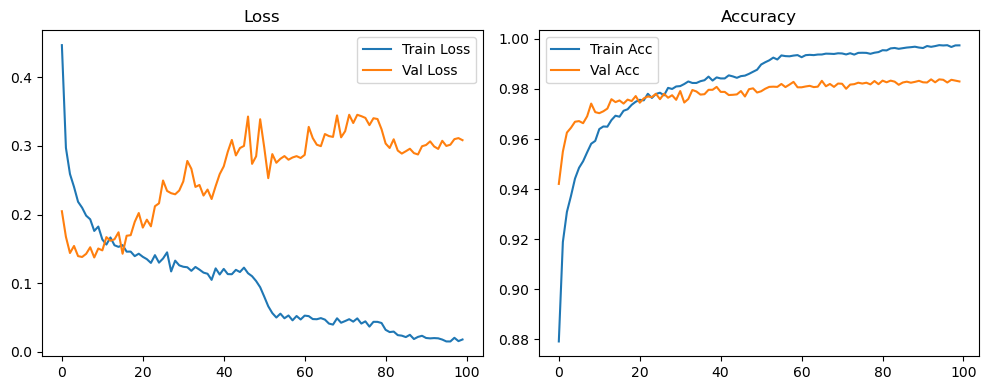

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3159, Acc: 0.9109 | Val Loss: 0.1996, Acc: 0.9416


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1611, Acc: 0.9542 | Val Loss: 0.1363, Acc: 0.9623


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1162, Acc: 0.9655 | Val Loss: 0.1227, Acc: 0.9661


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0906, Acc: 0.9737 | Val Loss: 0.1200, Acc: 0.9674


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0767, Acc: 0.9772 | Val Loss: 0.1146, Acc: 0.9718


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9825 | Val Loss: 0.1301, Acc: 0.9699


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9845 | Val Loss: 0.1231, Acc: 0.9712


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9861 | Val Loss: 0.1202, Acc: 0.9719


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9869 | Val Loss: 0.1186, Acc: 0.9729


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9894 | Val Loss: 0.1106, Acc: 0.9748


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9909 | Val Loss: 0.1429, Acc: 0.9705


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9908 | Val Loss: 0.1326, Acc: 0.9728


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9911 | Val Loss: 0.1304, Acc: 0.9746


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9913 | Val Loss: 0.1535, Acc: 0.9722


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9931 | Val Loss: 0.1409, Acc: 0.9734


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9916 | Val Loss: 0.1295, Acc: 0.9766


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9939 | Val Loss: 0.1386, Acc: 0.9735


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9936 | Val Loss: 0.1479, Acc: 0.9738


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9937 | Val Loss: 0.1761, Acc: 0.9702


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9946 | Val Loss: 0.1344, Acc: 0.9762


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9954 | Val Loss: 0.1369, Acc: 0.9757


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9957 | Val Loss: 0.1387, Acc: 0.9771


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9954 | Val Loss: 0.1701, Acc: 0.9739


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9944 | Val Loss: 0.1529, Acc: 0.9748


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9953 | Val Loss: 0.1506, Acc: 0.9768


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9957 | Val Loss: 0.1469, Acc: 0.9764


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9958 | Val Loss: 0.1844, Acc: 0.9741


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9950 | Val Loss: 0.1516, Acc: 0.9753


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9960 | Val Loss: 0.1485, Acc: 0.9761


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9970 | Val Loss: 0.1423, Acc: 0.9774


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9959 | Val Loss: 0.1656, Acc: 0.9757


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9962 | Val Loss: 0.1919, Acc: 0.9742


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9962 | Val Loss: 0.1680, Acc: 0.9766


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9960 | Val Loss: 0.1695, Acc: 0.9750


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9962 | Val Loss: 0.1885, Acc: 0.9746


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9969 | Val Loss: 0.1820, Acc: 0.9744


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.2159, Acc: 0.9750


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9959 | Val Loss: 0.1636, Acc: 0.9759


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9966 | Val Loss: 0.1673, Acc: 0.9776


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9971 | Val Loss: 0.1993, Acc: 0.9777


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9973 | Val Loss: 0.1673, Acc: 0.9752


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.1965, Acc: 0.9763


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9968 | Val Loss: 0.1633, Acc: 0.9777


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9971 | Val Loss: 0.2025, Acc: 0.9755


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9971 | Val Loss: 0.2070, Acc: 0.9764


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9970 | Val Loss: 0.1974, Acc: 0.9764


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9971 | Val Loss: 0.1921, Acc: 0.9783


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.2035, Acc: 0.9773


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9980 | Val Loss: 0.2319, Acc: 0.9752


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9970 | Val Loss: 0.2027, Acc: 0.9770


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9986 | Val Loss: 0.1759, Acc: 0.9797


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1687, Acc: 0.9799


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1670, Acc: 0.9808


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1695, Acc: 0.9804


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1682, Acc: 0.9808


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1749, Acc: 0.9802


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.2071, Acc: 0.9792


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1900, Acc: 0.9803


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1914, Acc: 0.9802


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2068, Acc: 0.9788


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2093, Acc: 0.9797


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2018, Acc: 0.9793


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1995, Acc: 0.9810


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2015, Acc: 0.9805


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.2044, Acc: 0.9808


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2082, Acc: 0.9802


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2217, Acc: 0.9798


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.2096, Acc: 0.9806


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.2229, Acc: 0.9810


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2225, Acc: 0.9804


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2123, Acc: 0.9811


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.2302, Acc: 0.9800


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.2304, Acc: 0.9812


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2383, Acc: 0.9806


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2454, Acc: 0.9803


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2441, Acc: 0.9798


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.2467, Acc: 0.9801


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2386, Acc: 0.9802


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.2430, Acc: 0.9806


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2446, Acc: 0.9805


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.2530, Acc: 0.9809


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2537, Acc: 0.9813


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2444, Acc: 0.9813


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.2411, Acc: 0.9800


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.2358, Acc: 0.9812


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.2419, Acc: 0.9816


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2448, Acc: 0.9813


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2413, Acc: 0.9813


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2443, Acc: 0.9820


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2439, Acc: 0.9817


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.2437, Acc: 0.9804


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2438, Acc: 0.9812


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2275, Acc: 0.9810


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2371, Acc: 0.9808


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2482, Acc: 0.9811


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2432, Acc: 0.9818


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2482, Acc: 0.9813


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2475, Acc: 0.9812


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.2444, Acc: 0.9820


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2477, Acc: 0.9817


Final Test Loss: 0.2306 Accuracy: 0.9831


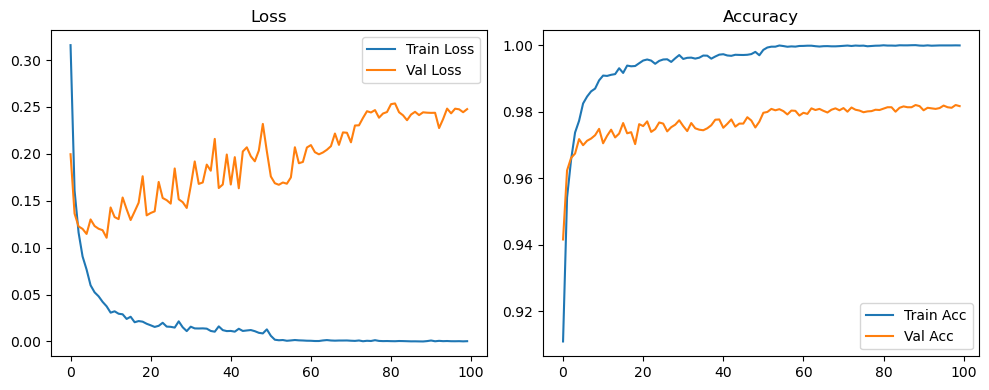

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3399, Acc: 0.9046 | Val Loss: 0.1895, Acc: 0.9455


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1940, Acc: 0.9449 | Val Loss: 0.1554, Acc: 0.9563


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1542, Acc: 0.9564 | Val Loss: 0.1177, Acc: 0.9664


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1274, Acc: 0.9633 | Val Loss: 0.1405, Acc: 0.9659


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1142, Acc: 0.9676 | Val Loss: 0.1185, Acc: 0.9698


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1021, Acc: 0.9718 | Val Loss: 0.1385, Acc: 0.9688


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0911, Acc: 0.9744 | Val Loss: 0.1349, Acc: 0.9706


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0799, Acc: 0.9774 | Val Loss: 0.1422, Acc: 0.9720


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0866, Acc: 0.9770 | Val Loss: 0.1478, Acc: 0.9706


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0734, Acc: 0.9812 | Val Loss: 0.1432, Acc: 0.9716


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0645, Acc: 0.9837 | Val Loss: 0.1693, Acc: 0.9695


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9834 | Val Loss: 0.1749, Acc: 0.9699


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0628, Acc: 0.9843 | Val Loss: 0.1625, Acc: 0.9732


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9855 | Val Loss: 0.1727, Acc: 0.9743


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9858 | Val Loss: 0.1573, Acc: 0.9778


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0550, Acc: 0.9867 | Val Loss: 0.1663, Acc: 0.9745


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0571, Acc: 0.9868 | Val Loss: 0.1881, Acc: 0.9741


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9868 | Val Loss: 0.1881, Acc: 0.9739


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9882 | Val Loss: 0.1980, Acc: 0.9733


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9892 | Val Loss: 0.2011, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0553, Acc: 0.9886 | Val Loss: 0.1973, Acc: 0.9714


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9898 | Val Loss: 0.2140, Acc: 0.9743


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9903 | Val Loss: 0.2208, Acc: 0.9752


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9898 | Val Loss: 0.2309, Acc: 0.9762


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9914 | Val Loss: 0.2754, Acc: 0.9758


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9902 | Val Loss: 0.2071, Acc: 0.9754


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9909 | Val Loss: 0.2349, Acc: 0.9770


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9917 | Val Loss: 0.2699, Acc: 0.9751


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9917 | Val Loss: 0.2702, Acc: 0.9730


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9925 | Val Loss: 0.2618, Acc: 0.9759


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9917 | Val Loss: 0.2521, Acc: 0.9775


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9932 | Val Loss: 0.2584, Acc: 0.9768


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9924 | Val Loss: 0.2392, Acc: 0.9764


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9933 | Val Loss: 0.2680, Acc: 0.9774


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9930 | Val Loss: 0.2416, Acc: 0.9763


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9927 | Val Loss: 0.2784, Acc: 0.9732


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9924 | Val Loss: 0.2500, Acc: 0.9771


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9938 | Val Loss: 0.2760, Acc: 0.9773


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9938 | Val Loss: 0.2479, Acc: 0.9765


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9935 | Val Loss: 0.3004, Acc: 0.9788


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9934 | Val Loss: 0.3053, Acc: 0.9768


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9937 | Val Loss: 0.3190, Acc: 0.9758


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9936 | Val Loss: 0.2914, Acc: 0.9782


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9929 | Val Loss: 0.3177, Acc: 0.9787


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9948 | Val Loss: 0.2859, Acc: 0.9772


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9947 | Val Loss: 0.3232, Acc: 0.9771


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9938 | Val Loss: 0.2797, Acc: 0.9777


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9942 | Val Loss: 0.3104, Acc: 0.9763


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9945 | Val Loss: 0.3379, Acc: 0.9774


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9942 | Val Loss: 0.3369, Acc: 0.9785


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9967 | Val Loss: 0.2654, Acc: 0.9798


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9978 | Val Loss: 0.2608, Acc: 0.9804


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9982 | Val Loss: 0.2539, Acc: 0.9810


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9986 | Val Loss: 0.2479, Acc: 0.9818


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9985 | Val Loss: 0.2578, Acc: 0.9813


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9988 | Val Loss: 0.2795, Acc: 0.9818


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9990 | Val Loss: 0.2803, Acc: 0.9806


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9990 | Val Loss: 0.2827, Acc: 0.9813


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9990 | Val Loss: 0.2698, Acc: 0.9822


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9988 | Val Loss: 0.2900, Acc: 0.9815


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.2829, Acc: 0.9815


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9989 | Val Loss: 0.2852, Acc: 0.9810


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9990 | Val Loss: 0.2526, Acc: 0.9819


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9989 | Val Loss: 0.2679, Acc: 0.9808


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9990 | Val Loss: 0.2782, Acc: 0.9809


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9991 | Val Loss: 0.2941, Acc: 0.9807


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9992 | Val Loss: 0.3165, Acc: 0.9818


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9992 | Val Loss: 0.3122, Acc: 0.9813


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9992 | Val Loss: 0.3124, Acc: 0.9813


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9993 | Val Loss: 0.3024, Acc: 0.9819


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9994 | Val Loss: 0.3144, Acc: 0.9815


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9993 | Val Loss: 0.3182, Acc: 0.9812


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9992 | Val Loss: 0.3190, Acc: 0.9812


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9991 | Val Loss: 0.3229, Acc: 0.9815


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9994 | Val Loss: 0.3152, Acc: 0.9822


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9991 | Val Loss: 0.3404, Acc: 0.9808


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9993 | Val Loss: 0.3375, Acc: 0.9810


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9991 | Val Loss: 0.3167, Acc: 0.9812


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9993 | Val Loss: 0.3284, Acc: 0.9818


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9994 | Val Loss: 0.3577, Acc: 0.9797


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9994 | Val Loss: 0.3255, Acc: 0.9813


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9996 | Val Loss: 0.3172, Acc: 0.9814


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9995 | Val Loss: 0.3173, Acc: 0.9812


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.3138, Acc: 0.9816


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9994 | Val Loss: 0.3138, Acc: 0.9822


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9995 | Val Loss: 0.3322, Acc: 0.9826


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9994 | Val Loss: 0.3256, Acc: 0.9813


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.3236, Acc: 0.9821


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.3284, Acc: 0.9817


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9996 | Val Loss: 0.3346, Acc: 0.9818


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.3258, Acc: 0.9818


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9996 | Val Loss: 0.3303, Acc: 0.9812


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9996 | Val Loss: 0.3067, Acc: 0.9818


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9996 | Val Loss: 0.3208, Acc: 0.9808


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9995 | Val Loss: 0.3174, Acc: 0.9825


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.3179, Acc: 0.9818


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.3075, Acc: 0.9812


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9996 | Val Loss: 0.3219, Acc: 0.9828


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.3202, Acc: 0.9816


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.3136, Acc: 0.9822


Final Test Loss: 0.3000 Accuracy: 0.9834


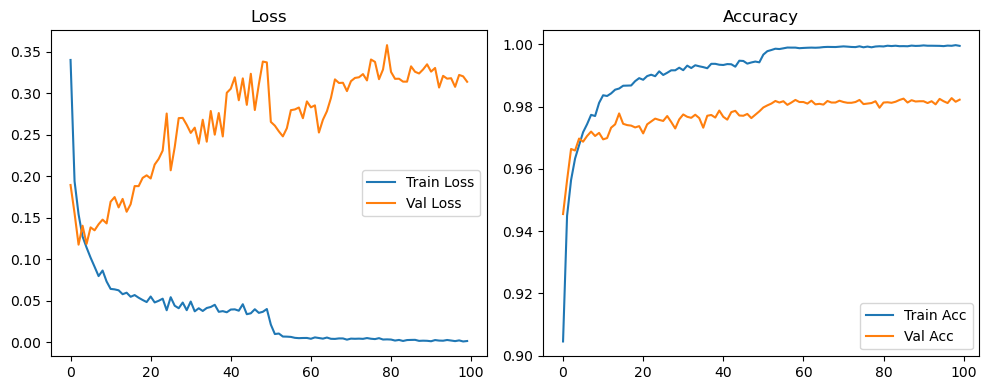

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4464, Acc: 0.8792 | Val Loss: 0.2048, Acc: 0.9421


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2969, Acc: 0.9189 | Val Loss: 0.1675, Acc: 0.9550


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2589, Acc: 0.9309 | Val Loss: 0.1440, Acc: 0.9626


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2401, Acc: 0.9373 | Val Loss: 0.1543, Acc: 0.9645


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2185, Acc: 0.9442 | Val Loss: 0.1395, Acc: 0.9669


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2099, Acc: 0.9485 | Val Loss: 0.1382, Acc: 0.9672


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1983, Acc: 0.9511 | Val Loss: 0.1428, Acc: 0.9663


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1930, Acc: 0.9547 | Val Loss: 0.1524, Acc: 0.9691


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1761, Acc: 0.9581 | Val Loss: 0.1375, Acc: 0.9742


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1825, Acc: 0.9593 | Val Loss: 0.1505, Acc: 0.9708


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1637, Acc: 0.9640 | Val Loss: 0.1478, Acc: 0.9703


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1563, Acc: 0.9650 | Val Loss: 0.1671, Acc: 0.9711


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1666, Acc: 0.9649 | Val Loss: 0.1619, Acc: 0.9722


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1553, Acc: 0.9676 | Val Loss: 0.1640, Acc: 0.9759


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1529, Acc: 0.9693 | Val Loss: 0.1741, Acc: 0.9748


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1555, Acc: 0.9689 | Val Loss: 0.1429, Acc: 0.9754


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1460, Acc: 0.9713 | Val Loss: 0.1691, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1460, Acc: 0.9719 | Val Loss: 0.1699, Acc: 0.9758


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1394, Acc: 0.9737 | Val Loss: 0.1892, Acc: 0.9752


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1430, Acc: 0.9749 | Val Loss: 0.2022, Acc: 0.9772


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1385, Acc: 0.9757 | Val Loss: 0.1810, Acc: 0.9745


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1351, Acc: 0.9755 | Val Loss: 0.1925, Acc: 0.9762


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1296, Acc: 0.9781 | Val Loss: 0.1828, Acc: 0.9770


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1409, Acc: 0.9764 | Val Loss: 0.2120, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1300, Acc: 0.9780 | Val Loss: 0.2163, Acc: 0.9781


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1360, Acc: 0.9785 | Val Loss: 0.2495, Acc: 0.9759


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1450, Acc: 0.9774 | Val Loss: 0.2343, Acc: 0.9781


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1172, Acc: 0.9804 | Val Loss: 0.2310, Acc: 0.9765


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1329, Acc: 0.9800 | Val Loss: 0.2294, Acc: 0.9775


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1261, Acc: 0.9810 | Val Loss: 0.2349, Acc: 0.9757


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1240, Acc: 0.9811 | Val Loss: 0.2481, Acc: 0.9792


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1233, Acc: 0.9820 | Val Loss: 0.2779, Acc: 0.9746


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1181, Acc: 0.9830 | Val Loss: 0.2665, Acc: 0.9760


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1237, Acc: 0.9824 | Val Loss: 0.2401, Acc: 0.9796


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.1198, Acc: 0.9824 | Val Loss: 0.2430, Acc: 0.9790


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.1155, Acc: 0.9831 | Val Loss: 0.2276, Acc: 0.9778


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.1138, Acc: 0.9835 | Val Loss: 0.2363, Acc: 0.9779


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1049, Acc: 0.9849 | Val Loss: 0.2226, Acc: 0.9797


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.1216, Acc: 0.9834 | Val Loss: 0.2413, Acc: 0.9797


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.1127, Acc: 0.9846 | Val Loss: 0.2587, Acc: 0.9808


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.1209, Acc: 0.9842 | Val Loss: 0.2701, Acc: 0.9788


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.1133, Acc: 0.9842 | Val Loss: 0.2913, Acc: 0.9788


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.1131, Acc: 0.9854 | Val Loss: 0.3085, Acc: 0.9776


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.1195, Acc: 0.9850 | Val Loss: 0.2860, Acc: 0.9777


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.1163, Acc: 0.9845 | Val Loss: 0.2967, Acc: 0.9778


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.1227, Acc: 0.9851 | Val Loss: 0.2998, Acc: 0.9792


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.1146, Acc: 0.9853 | Val Loss: 0.3425, Acc: 0.9770


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.1102, Acc: 0.9860 | Val Loss: 0.2737, Acc: 0.9799


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.1032, Acc: 0.9869 | Val Loss: 0.2847, Acc: 0.9802


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0942, Acc: 0.9877 | Val Loss: 0.3386, Acc: 0.9786


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0748, Acc: 0.9901 | Val Loss: 0.2932, Acc: 0.9805


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0647, Acc: 0.9916 | Val Loss: 0.2685, Acc: 0.9804


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0457, Acc: 0.9929 | Val Loss: 0.2621, Acc: 0.9817


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0467, Acc: 0.9926 | Val Loss: 0.2711, Acc: 0.9818


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0430, Acc: 0.9935 | Val Loss: 0.2782, Acc: 0.9808


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9942 | Val Loss: 0.2613, Acc: 0.9825


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0403, Acc: 0.9941 | Val Loss: 0.2640, Acc: 0.9825


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9945 | Val Loss: 0.2415, Acc: 0.9820


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0346, Acc: 0.9949 | Val Loss: 0.2453, Acc: 0.9821


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9950 | Val Loss: 0.2535, Acc: 0.9822


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0330, Acc: 0.9947 | Val Loss: 0.2763, Acc: 0.9812


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9947 | Val Loss: 0.2692, Acc: 0.9831


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9956 | Val Loss: 0.2749, Acc: 0.9812


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9955 | Val Loss: 0.2616, Acc: 0.9829


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9960 | Val Loss: 0.2659, Acc: 0.9820


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9953 | Val Loss: 0.2783, Acc: 0.9828


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9957 | Val Loss: 0.2750, Acc: 0.9826


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9960 | Val Loss: 0.2596, Acc: 0.9834


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9958 | Val Loss: 0.2600, Acc: 0.9822


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9960 | Val Loss: 0.2543, Acc: 0.9820


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9957 | Val Loss: 0.2683, Acc: 0.9822


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9963 | Val Loss: 0.2666, Acc: 0.9821


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9959 | Val Loss: 0.2717, Acc: 0.9842


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9959 | Val Loss: 0.2674, Acc: 0.9832


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9961 | Val Loss: 0.2863, Acc: 0.9830


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9962 | Val Loss: 0.2755, Acc: 0.9829


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9965 | Val Loss: 0.2826, Acc: 0.9831


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9960 | Val Loss: 0.2785, Acc: 0.9828


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9965 | Val Loss: 0.2743, Acc: 0.9827


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9963 | Val Loss: 0.2709, Acc: 0.9834


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9968 | Val Loss: 0.2658, Acc: 0.9838


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9970 | Val Loss: 0.2565, Acc: 0.9847


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9970 | Val Loss: 0.2657, Acc: 0.9832


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9969 | Val Loss: 0.2716, Acc: 0.9830


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9972 | Val Loss: 0.2570, Acc: 0.9833


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9970 | Val Loss: 0.2553, Acc: 0.9838


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9970 | Val Loss: 0.2549, Acc: 0.9837


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9973 | Val Loss: 0.2528, Acc: 0.9835


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9973 | Val Loss: 0.2610, Acc: 0.9832


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9970 | Val Loss: 0.2723, Acc: 0.9830


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9970 | Val Loss: 0.2620, Acc: 0.9832


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9974 | Val Loss: 0.2781, Acc: 0.9828


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9974 | Val Loss: 0.2654, Acc: 0.9839


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9974 | Val Loss: 0.2723, Acc: 0.9832


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9975 | Val Loss: 0.2845, Acc: 0.9836


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9976 | Val Loss: 0.2731, Acc: 0.9838


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9976 | Val Loss: 0.2684, Acc: 0.9833


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9972 | Val Loss: 0.2781, Acc: 0.9834


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9978 | Val Loss: 0.2728, Acc: 0.9832


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9975 | Val Loss: 0.2748, Acc: 0.9838


Final Test Loss: 0.2509 Accuracy: 0.9838


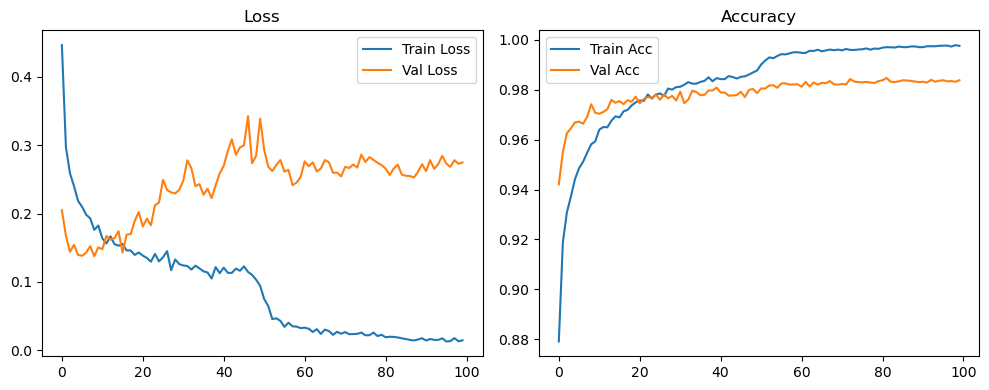

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2847, Acc: 0.9157 | Val Loss: 0.1635, Acc: 0.9537


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1483, Acc: 0.9553 | Val Loss: 0.1391, Acc: 0.9596


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1126, Acc: 0.9657 | Val Loss: 0.1142, Acc: 0.9657


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0851, Acc: 0.9745 | Val Loss: 0.1207, Acc: 0.9673


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0718, Acc: 0.9777 | Val Loss: 0.1225, Acc: 0.9692


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0581, Acc: 0.9823 | Val Loss: 0.1121, Acc: 0.9718


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9840 | Val Loss: 0.1107, Acc: 0.9729


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9868 | Val Loss: 0.1054, Acc: 0.9737


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9873 | Val Loss: 0.1117, Acc: 0.9741


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9891 | Val Loss: 0.1294, Acc: 0.9718


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9906 | Val Loss: 0.1154, Acc: 0.9728


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9919 | Val Loss: 0.1338, Acc: 0.9722


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9911 | Val Loss: 0.1375, Acc: 0.9718


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0253, Acc: 0.9926 | Val Loss: 0.1367, Acc: 0.9718


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9930 | Val Loss: 0.1367, Acc: 0.9716


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9936 | Val Loss: 0.1279, Acc: 0.9741


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9932 | Val Loss: 0.1233, Acc: 0.9728


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9940 | Val Loss: 0.1413, Acc: 0.9738


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9949 | Val Loss: 0.1269, Acc: 0.9756


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9948 | Val Loss: 0.1444, Acc: 0.9732


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9952 | Val Loss: 0.1375, Acc: 0.9756


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9952 | Val Loss: 0.1283, Acc: 0.9750


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9956 | Val Loss: 0.1438, Acc: 0.9749


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.1332, Acc: 0.9771


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9958 | Val Loss: 0.1445, Acc: 0.9753


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9960 | Val Loss: 0.1330, Acc: 0.9758


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9962 | Val Loss: 0.1343, Acc: 0.9766


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9963 | Val Loss: 0.1345, Acc: 0.9773


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9957 | Val Loss: 0.1513, Acc: 0.9754


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9969 | Val Loss: 0.1499, Acc: 0.9757


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1551, Acc: 0.9757


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9967 | Val Loss: 0.1417, Acc: 0.9771


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9966 | Val Loss: 0.1401, Acc: 0.9772


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.1677, Acc: 0.9748


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9966 | Val Loss: 0.1579, Acc: 0.9758


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9975 | Val Loss: 0.1600, Acc: 0.9771


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9970 | Val Loss: 0.1719, Acc: 0.9743


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9969 | Val Loss: 0.1592, Acc: 0.9766


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1808, Acc: 0.9739


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9966 | Val Loss: 0.1590, Acc: 0.9756


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9981 | Val Loss: 0.1572, Acc: 0.9770


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9968 | Val Loss: 0.1556, Acc: 0.9772


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.1691, Acc: 0.9772


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9974 | Val Loss: 0.1561, Acc: 0.9778


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9977 | Val Loss: 0.1673, Acc: 0.9770


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9976 | Val Loss: 0.1499, Acc: 0.9782


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9973 | Val Loss: 0.1761, Acc: 0.9760


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9971 | Val Loss: 0.1491, Acc: 0.9788


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1711, Acc: 0.9764


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.1681, Acc: 0.9776


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9979 | Val Loss: 0.1585, Acc: 0.9765


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1721, Acc: 0.9786


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9981 | Val Loss: 0.1674, Acc: 0.9783


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9980 | Val Loss: 0.1938, Acc: 0.9736


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.2055, Acc: 0.9755


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9973 | Val Loss: 0.1751, Acc: 0.9767


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.2126, Acc: 0.9759


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9976 | Val Loss: 0.2147, Acc: 0.9753


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9979 | Val Loss: 0.1925, Acc: 0.9756


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9982 | Val Loss: 0.2526, Acc: 0.9734


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9975 | Val Loss: 0.2005, Acc: 0.9762


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9983 | Val Loss: 0.1934, Acc: 0.9782


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.1841, Acc: 0.9768


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9982 | Val Loss: 0.1817, Acc: 0.9773


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9979 | Val Loss: 0.2177, Acc: 0.9744


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9988 | Val Loss: 0.2164, Acc: 0.9769


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9986 | Val Loss: 0.2311, Acc: 0.9767


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9974 | Val Loss: 0.1890, Acc: 0.9790


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9981 | Val Loss: 0.2079, Acc: 0.9764


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9981 | Val Loss: 0.1863, Acc: 0.9788


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9988 | Val Loss: 0.1788, Acc: 0.9791


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9987 | Val Loss: 0.1925, Acc: 0.9795


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9983 | Val Loss: 0.2128, Acc: 0.9778


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9977 | Val Loss: 0.2440, Acc: 0.9756


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.2287, Acc: 0.9772


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9987 | Val Loss: 0.2235, Acc: 0.9778


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9981 | Val Loss: 0.1913, Acc: 0.9787


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9985 | Val Loss: 0.1848, Acc: 0.9767


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9992 | Val Loss: 0.2111, Acc: 0.9782


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9978 | Val Loss: 0.2139, Acc: 0.9786


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9987 | Val Loss: 0.2136, Acc: 0.9788


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9982 | Val Loss: 0.2173, Acc: 0.9792


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9988 | Val Loss: 0.2386, Acc: 0.9767


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9983 | Val Loss: 0.2382, Acc: 0.9769


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9983 | Val Loss: 0.2224, Acc: 0.9782


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9984 | Val Loss: 0.2589, Acc: 0.9762


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9987 | Val Loss: 0.2172, Acc: 0.9793


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9993 | Val Loss: 0.2460, Acc: 0.9777


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9991 | Val Loss: 0.2408, Acc: 0.9783


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9982 | Val Loss: 0.2565, Acc: 0.9778


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9985 | Val Loss: 0.2235, Acc: 0.9758


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.2469, Acc: 0.9775


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9985 | Val Loss: 0.2643, Acc: 0.9764


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9989 | Val Loss: 0.2219, Acc: 0.9795


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.2631, Acc: 0.9776


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9984 | Val Loss: 0.2327, Acc: 0.9787


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9985 | Val Loss: 0.2432, Acc: 0.9772


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9986 | Val Loss: 0.2444, Acc: 0.9777


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9988 | Val Loss: 0.2634, Acc: 0.9772


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9988 | Val Loss: 0.2738, Acc: 0.9765


Final Test Loss: 0.2108 Accuracy: 0.9787


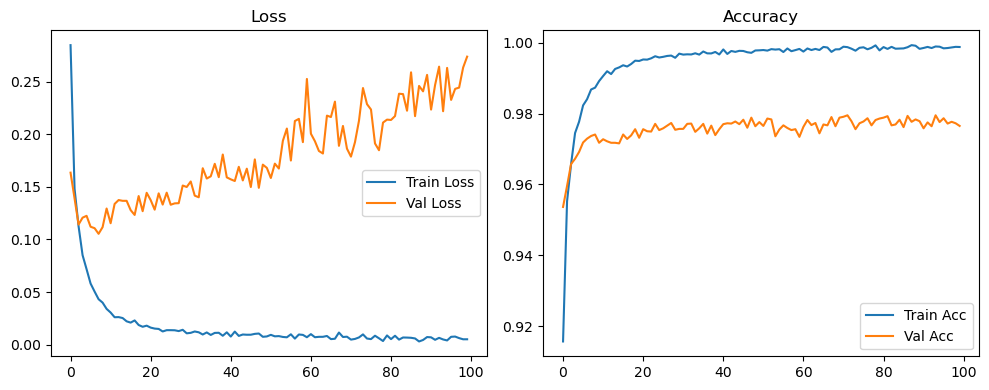

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3034, Acc: 0.9107 | Val Loss: 0.1653, Acc: 0.9527


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1721, Acc: 0.9500 | Val Loss: 0.1272, Acc: 0.9633


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1363, Acc: 0.9598 | Val Loss: 0.1202, Acc: 0.9672


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1109, Acc: 0.9664 | Val Loss: 0.1398, Acc: 0.9631


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0992, Acc: 0.9700 | Val Loss: 0.1186, Acc: 0.9674


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0810, Acc: 0.9765 | Val Loss: 0.1122, Acc: 0.9720


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0746, Acc: 0.9773 | Val Loss: 0.1155, Acc: 0.9718


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0671, Acc: 0.9801 | Val Loss: 0.1068, Acc: 0.9741


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0595, Acc: 0.9816 | Val Loss: 0.1207, Acc: 0.9718


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0626, Acc: 0.9816 | Val Loss: 0.1205, Acc: 0.9711


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0507, Acc: 0.9849 | Val Loss: 0.1290, Acc: 0.9730


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0490, Acc: 0.9856 | Val Loss: 0.1190, Acc: 0.9748


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9861 | Val Loss: 0.1338, Acc: 0.9734


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0420, Acc: 0.9885 | Val Loss: 0.1415, Acc: 0.9737


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9890 | Val Loss: 0.1236, Acc: 0.9758


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9882 | Val Loss: 0.1276, Acc: 0.9748


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9894 | Val Loss: 0.1410, Acc: 0.9752


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9902 | Val Loss: 0.1455, Acc: 0.9752


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9897 | Val Loss: 0.1587, Acc: 0.9742


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9902 | Val Loss: 0.1354, Acc: 0.9762


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9912 | Val Loss: 0.1638, Acc: 0.9759


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9904 | Val Loss: 0.1464, Acc: 0.9770


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9929 | Val Loss: 0.1545, Acc: 0.9775


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9919 | Val Loss: 0.1639, Acc: 0.9752


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9919 | Val Loss: 0.1638, Acc: 0.9763


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9932 | Val Loss: 0.1581, Acc: 0.9771


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9923 | Val Loss: 0.1615, Acc: 0.9758


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9927 | Val Loss: 0.1766, Acc: 0.9748


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9925 | Val Loss: 0.2032, Acc: 0.9737


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9934 | Val Loss: 0.1891, Acc: 0.9768


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9930 | Val Loss: 0.1899, Acc: 0.9750


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9934 | Val Loss: 0.2004, Acc: 0.9764


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9939 | Val Loss: 0.1748, Acc: 0.9760


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9933 | Val Loss: 0.1858, Acc: 0.9781


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9939 | Val Loss: 0.1886, Acc: 0.9762


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9937 | Val Loss: 0.2047, Acc: 0.9784


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9948 | Val Loss: 0.2121, Acc: 0.9757


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9945 | Val Loss: 0.2064, Acc: 0.9767


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9942 | Val Loss: 0.2207, Acc: 0.9763


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9935 | Val Loss: 0.2337, Acc: 0.9763


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9947 | Val Loss: 0.2393, Acc: 0.9759


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0253, Acc: 0.9951 | Val Loss: 0.2255, Acc: 0.9784


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9949 | Val Loss: 0.2181, Acc: 0.9778


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9948 | Val Loss: 0.2274, Acc: 0.9775


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9959 | Val Loss: 0.2141, Acc: 0.9792


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9949 | Val Loss: 0.2332, Acc: 0.9758


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9943 | Val Loss: 0.2564, Acc: 0.9758


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9958 | Val Loss: 0.2521, Acc: 0.9777


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9950 | Val Loss: 0.2588, Acc: 0.9773


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9958 | Val Loss: 0.2517, Acc: 0.9796


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9950 | Val Loss: 0.2538, Acc: 0.9785


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9954 | Val Loss: 0.2509, Acc: 0.9774


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9957 | Val Loss: 0.2605, Acc: 0.9770


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9953 | Val Loss: 0.2362, Acc: 0.9775


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9962 | Val Loss: 0.2684, Acc: 0.9775


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9964 | Val Loss: 0.2463, Acc: 0.9789


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9958 | Val Loss: 0.2706, Acc: 0.9778


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9962 | Val Loss: 0.2586, Acc: 0.9790


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9955 | Val Loss: 0.2858, Acc: 0.9776


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9961 | Val Loss: 0.2581, Acc: 0.9782


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9958 | Val Loss: 0.2457, Acc: 0.9778


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9957 | Val Loss: 0.2837, Acc: 0.9745


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9960 | Val Loss: 0.2483, Acc: 0.9792


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9960 | Val Loss: 0.2690, Acc: 0.9772


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9963 | Val Loss: 0.2648, Acc: 0.9778


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9960 | Val Loss: 0.2724, Acc: 0.9771


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9968 | Val Loss: 0.2810, Acc: 0.9777


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9964 | Val Loss: 0.2900, Acc: 0.9790


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9961 | Val Loss: 0.2897, Acc: 0.9786


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9958 | Val Loss: 0.2338, Acc: 0.9808


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9969 | Val Loss: 0.2619, Acc: 0.9800


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9966 | Val Loss: 0.3002, Acc: 0.9778


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9970 | Val Loss: 0.3222, Acc: 0.9774


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9963 | Val Loss: 0.2790, Acc: 0.9763


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9968 | Val Loss: 0.3087, Acc: 0.9774


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9968 | Val Loss: 0.2909, Acc: 0.9780


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9968 | Val Loss: 0.3026, Acc: 0.9781


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9964 | Val Loss: 0.3077, Acc: 0.9797


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9975 | Val Loss: 0.2615, Acc: 0.9792


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9964 | Val Loss: 0.2894, Acc: 0.9782


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9964 | Val Loss: 0.3053, Acc: 0.9768


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9973 | Val Loss: 0.3156, Acc: 0.9799


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9970 | Val Loss: 0.3212, Acc: 0.9786


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9970 | Val Loss: 0.3235, Acc: 0.9779


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9969 | Val Loss: 0.2842, Acc: 0.9782


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9972 | Val Loss: 0.2958, Acc: 0.9784


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9974 | Val Loss: 0.3144, Acc: 0.9789


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9976 | Val Loss: 0.3228, Acc: 0.9787


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9968 | Val Loss: 0.3330, Acc: 0.9781


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9975 | Val Loss: 0.3225, Acc: 0.9782


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9969 | Val Loss: 0.3464, Acc: 0.9778


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9972 | Val Loss: 0.3529, Acc: 0.9797


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9971 | Val Loss: 0.3370, Acc: 0.9774


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9969 | Val Loss: 0.3179, Acc: 0.9800


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9971 | Val Loss: 0.3331, Acc: 0.9774


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9975 | Val Loss: 0.3169, Acc: 0.9781


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9975 | Val Loss: 0.3474, Acc: 0.9768


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9974 | Val Loss: 0.3385, Acc: 0.9785


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9974 | Val Loss: 0.3188, Acc: 0.9787


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9978 | Val Loss: 0.3515, Acc: 0.9774


Final Test Loss: 0.3027 Accuracy: 0.9805


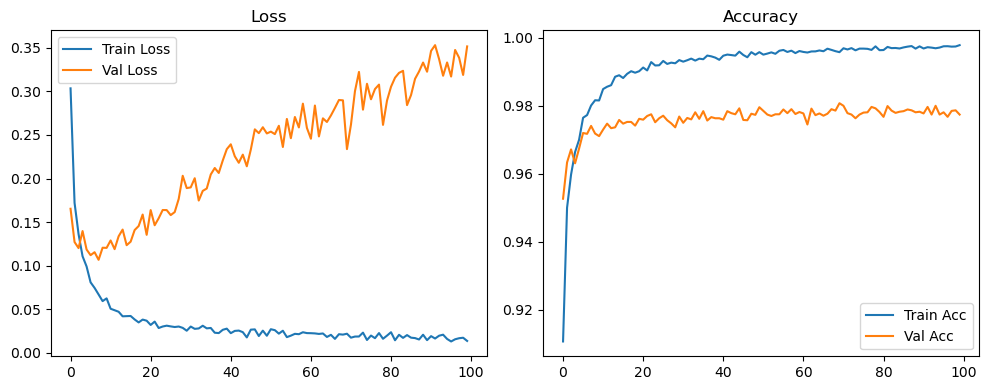

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3810, Acc: 0.8900 | Val Loss: 0.1789, Acc: 0.9483


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2446, Acc: 0.9294 | Val Loss: 0.1364, Acc: 0.9598


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2099, Acc: 0.9403 | Val Loss: 0.1202, Acc: 0.9643


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1851, Acc: 0.9460 | Val Loss: 0.1231, Acc: 0.9657


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1671, Acc: 0.9517 | Val Loss: 0.1187, Acc: 0.9681


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1584, Acc: 0.9561 | Val Loss: 0.1199, Acc: 0.9691


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1457, Acc: 0.9574 | Val Loss: 0.1205, Acc: 0.9694


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1377, Acc: 0.9613 | Val Loss: 0.1153, Acc: 0.9718


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1270, Acc: 0.9636 | Val Loss: 0.1140, Acc: 0.9728


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1295, Acc: 0.9645 | Val Loss: 0.1069, Acc: 0.9736


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1169, Acc: 0.9679 | Val Loss: 0.1153, Acc: 0.9735


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1160, Acc: 0.9679 | Val Loss: 0.1081, Acc: 0.9750


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1042, Acc: 0.9720 | Val Loss: 0.1104, Acc: 0.9768


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1060, Acc: 0.9729 | Val Loss: 0.1315, Acc: 0.9729


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1043, Acc: 0.9737 | Val Loss: 0.1102, Acc: 0.9760


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1002, Acc: 0.9748 | Val Loss: 0.1215, Acc: 0.9748


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0990, Acc: 0.9748 | Val Loss: 0.1243, Acc: 0.9740


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0932, Acc: 0.9764 | Val Loss: 0.1337, Acc: 0.9758


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0893, Acc: 0.9776 | Val Loss: 0.1453, Acc: 0.9757


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0932, Acc: 0.9769 | Val Loss: 0.1289, Acc: 0.9764


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0882, Acc: 0.9786 | Val Loss: 0.1440, Acc: 0.9734


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0889, Acc: 0.9788 | Val Loss: 0.1319, Acc: 0.9763


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0826, Acc: 0.9806 | Val Loss: 0.1375, Acc: 0.9758


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0838, Acc: 0.9805 | Val Loss: 0.1447, Acc: 0.9769


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0857, Acc: 0.9800 | Val Loss: 0.1392, Acc: 0.9770


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0867, Acc: 0.9804 | Val Loss: 0.1572, Acc: 0.9773


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0832, Acc: 0.9811 | Val Loss: 0.1622, Acc: 0.9762


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0782, Acc: 0.9819 | Val Loss: 0.1733, Acc: 0.9758


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0749, Acc: 0.9826 | Val Loss: 0.1693, Acc: 0.9772


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0775, Acc: 0.9832 | Val Loss: 0.1631, Acc: 0.9760


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0748, Acc: 0.9848 | Val Loss: 0.1511, Acc: 0.9778


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0783, Acc: 0.9835 | Val Loss: 0.1761, Acc: 0.9772


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0685, Acc: 0.9852 | Val Loss: 0.1773, Acc: 0.9774


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0757, Acc: 0.9849 | Val Loss: 0.1733, Acc: 0.9785


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0770, Acc: 0.9843 | Val Loss: 0.1638, Acc: 0.9762


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0733, Acc: 0.9855 | Val Loss: 0.1859, Acc: 0.9776


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0675, Acc: 0.9865 | Val Loss: 0.1816, Acc: 0.9774


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0676, Acc: 0.9862 | Val Loss: 0.1801, Acc: 0.9782


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0635, Acc: 0.9870 | Val Loss: 0.1953, Acc: 0.9791


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0743, Acc: 0.9857 | Val Loss: 0.2031, Acc: 0.9772


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0702, Acc: 0.9859 | Val Loss: 0.1857, Acc: 0.9782


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0749, Acc: 0.9859 | Val Loss: 0.1886, Acc: 0.9781


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0702, Acc: 0.9868 | Val Loss: 0.1889, Acc: 0.9784


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0635, Acc: 0.9878 | Val Loss: 0.2042, Acc: 0.9784


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0663, Acc: 0.9878 | Val Loss: 0.1859, Acc: 0.9792


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0693, Acc: 0.9876 | Val Loss: 0.2230, Acc: 0.9780


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0747, Acc: 0.9867 | Val Loss: 0.2124, Acc: 0.9773


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0643, Acc: 0.9882 | Val Loss: 0.2081, Acc: 0.9799


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0620, Acc: 0.9887 | Val Loss: 0.2148, Acc: 0.9789


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0621, Acc: 0.9889 | Val Loss: 0.2286, Acc: 0.9790


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0625, Acc: 0.9881 | Val Loss: 0.2411, Acc: 0.9774


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0663, Acc: 0.9875 | Val Loss: 0.2133, Acc: 0.9790


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0640, Acc: 0.9890 | Val Loss: 0.2195, Acc: 0.9785


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0684, Acc: 0.9888 | Val Loss: 0.2288, Acc: 0.9792


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0621, Acc: 0.9892 | Val Loss: 0.2229, Acc: 0.9788


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0584, Acc: 0.9893 | Val Loss: 0.2360, Acc: 0.9798


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0687, Acc: 0.9890 | Val Loss: 0.2400, Acc: 0.9800


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0690, Acc: 0.9891 | Val Loss: 0.2459, Acc: 0.9798


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0611, Acc: 0.9897 | Val Loss: 0.2318, Acc: 0.9781


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0615, Acc: 0.9900 | Val Loss: 0.2593, Acc: 0.9766


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0686, Acc: 0.9890 | Val Loss: 0.2522, Acc: 0.9782


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0621, Acc: 0.9891 | Val Loss: 0.2574, Acc: 0.9788


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0629, Acc: 0.9901 | Val Loss: 0.2198, Acc: 0.9793


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0571, Acc: 0.9898 | Val Loss: 0.2436, Acc: 0.9802


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0620, Acc: 0.9900 | Val Loss: 0.2575, Acc: 0.9792


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0584, Acc: 0.9910 | Val Loss: 0.2563, Acc: 0.9785


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0550, Acc: 0.9912 | Val Loss: 0.2632, Acc: 0.9801


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0594, Acc: 0.9908 | Val Loss: 0.2590, Acc: 0.9790


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0591, Acc: 0.9905 | Val Loss: 0.2635, Acc: 0.9794


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0553, Acc: 0.9913 | Val Loss: 0.2365, Acc: 0.9798


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0629, Acc: 0.9909 | Val Loss: 0.2743, Acc: 0.9778


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0553, Acc: 0.9909 | Val Loss: 0.2754, Acc: 0.9776


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0620, Acc: 0.9906 | Val Loss: 0.2419, Acc: 0.9797


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0585, Acc: 0.9910 | Val Loss: 0.2583, Acc: 0.9799


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0580, Acc: 0.9911 | Val Loss: 0.2887, Acc: 0.9792


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0661, Acc: 0.9915 | Val Loss: 0.2433, Acc: 0.9799


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9909 | Val Loss: 0.2413, Acc: 0.9808


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0586, Acc: 0.9912 | Val Loss: 0.2659, Acc: 0.9800


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0604, Acc: 0.9913 | Val Loss: 0.2458, Acc: 0.9814


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0631, Acc: 0.9910 | Val Loss: 0.2398, Acc: 0.9810


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0525, Acc: 0.9920 | Val Loss: 0.2464, Acc: 0.9806


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0574, Acc: 0.9911 | Val Loss: 0.2527, Acc: 0.9819


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0556, Acc: 0.9918 | Val Loss: 0.2662, Acc: 0.9795


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0538, Acc: 0.9922 | Val Loss: 0.2825, Acc: 0.9802


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0516, Acc: 0.9914 | Val Loss: 0.2714, Acc: 0.9796


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0564, Acc: 0.9921 | Val Loss: 0.3047, Acc: 0.9788


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0561, Acc: 0.9924 | Val Loss: 0.3052, Acc: 0.9790


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9924 | Val Loss: 0.3017, Acc: 0.9788


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0570, Acc: 0.9923 | Val Loss: 0.2942, Acc: 0.9807


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0541, Acc: 0.9926 | Val Loss: 0.3025, Acc: 0.9794


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0496, Acc: 0.9926 | Val Loss: 0.2976, Acc: 0.9797


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0564, Acc: 0.9919 | Val Loss: 0.2889, Acc: 0.9800


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0567, Acc: 0.9923 | Val Loss: 0.3215, Acc: 0.9795


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9929 | Val Loss: 0.2936, Acc: 0.9808


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0556, Acc: 0.9923 | Val Loss: 0.2962, Acc: 0.9809


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9929 | Val Loss: 0.3128, Acc: 0.9795


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0490, Acc: 0.9927 | Val Loss: 0.2891, Acc: 0.9798


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0552, Acc: 0.9922 | Val Loss: 0.3219, Acc: 0.9788


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9931 | Val Loss: 0.3058, Acc: 0.9806


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0527, Acc: 0.9931 | Val Loss: 0.3022, Acc: 0.9807


Final Test Loss: 0.2872 Accuracy: 0.9812


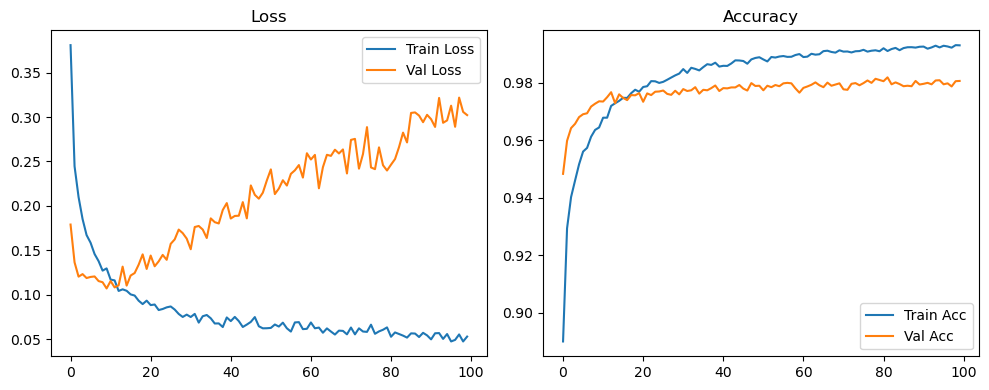

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2847, Acc: 0.9157 | Val Loss: 0.1635, Acc: 0.9537


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1483, Acc: 0.9553 | Val Loss: 0.1391, Acc: 0.9596


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1126, Acc: 0.9657 | Val Loss: 0.1142, Acc: 0.9657


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0851, Acc: 0.9745 | Val Loss: 0.1207, Acc: 0.9673


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0718, Acc: 0.9777 | Val Loss: 0.1225, Acc: 0.9692


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0581, Acc: 0.9823 | Val Loss: 0.1121, Acc: 0.9718


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9840 | Val Loss: 0.1107, Acc: 0.9729


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9868 | Val Loss: 0.1054, Acc: 0.9737


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9873 | Val Loss: 0.1117, Acc: 0.9741


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9891 | Val Loss: 0.1294, Acc: 0.9718


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9906 | Val Loss: 0.1154, Acc: 0.9728


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9919 | Val Loss: 0.1338, Acc: 0.9722


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9911 | Val Loss: 0.1375, Acc: 0.9718


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0253, Acc: 0.9926 | Val Loss: 0.1367, Acc: 0.9718


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9930 | Val Loss: 0.1367, Acc: 0.9716


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9936 | Val Loss: 0.1279, Acc: 0.9741


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9932 | Val Loss: 0.1233, Acc: 0.9728


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9940 | Val Loss: 0.1413, Acc: 0.9738


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9949 | Val Loss: 0.1269, Acc: 0.9756


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9948 | Val Loss: 0.1444, Acc: 0.9732


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9952 | Val Loss: 0.1375, Acc: 0.9756


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9952 | Val Loss: 0.1283, Acc: 0.9750


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9956 | Val Loss: 0.1438, Acc: 0.9749


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.1332, Acc: 0.9771


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9958 | Val Loss: 0.1445, Acc: 0.9753


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9960 | Val Loss: 0.1330, Acc: 0.9758


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9962 | Val Loss: 0.1343, Acc: 0.9766


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9963 | Val Loss: 0.1345, Acc: 0.9773


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9957 | Val Loss: 0.1513, Acc: 0.9754


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9969 | Val Loss: 0.1499, Acc: 0.9757


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1551, Acc: 0.9757


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9967 | Val Loss: 0.1417, Acc: 0.9771


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9966 | Val Loss: 0.1401, Acc: 0.9772


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.1677, Acc: 0.9748


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9966 | Val Loss: 0.1579, Acc: 0.9758


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9975 | Val Loss: 0.1600, Acc: 0.9771


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9970 | Val Loss: 0.1719, Acc: 0.9743


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9969 | Val Loss: 0.1592, Acc: 0.9766


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1808, Acc: 0.9739


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9966 | Val Loss: 0.1590, Acc: 0.9756


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9981 | Val Loss: 0.1572, Acc: 0.9770


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9968 | Val Loss: 0.1556, Acc: 0.9772


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.1691, Acc: 0.9772


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9974 | Val Loss: 0.1561, Acc: 0.9778


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9977 | Val Loss: 0.1673, Acc: 0.9770


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9976 | Val Loss: 0.1499, Acc: 0.9782


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9973 | Val Loss: 0.1761, Acc: 0.9760


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9971 | Val Loss: 0.1491, Acc: 0.9788


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1711, Acc: 0.9764


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.1681, Acc: 0.9776


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1420, Acc: 0.9807


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1524, Acc: 0.9805


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1505, Acc: 0.9800


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.1680, Acc: 0.9789


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1639, Acc: 0.9806


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.1722, Acc: 0.9815


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1824, Acc: 0.9794


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1856, Acc: 0.9798


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1759, Acc: 0.9800


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1742, Acc: 0.9811


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1856, Acc: 0.9811


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1981, Acc: 0.9794


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1922, Acc: 0.9796


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1947, Acc: 0.9810


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1973, Acc: 0.9800


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1956, Acc: 0.9802


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1945, Acc: 0.9814


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1952, Acc: 0.9806


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1881, Acc: 0.9795


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.2060, Acc: 0.9789


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9997 | Val Loss: 0.1953, Acc: 0.9804


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.2148, Acc: 0.9789


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.2160, Acc: 0.9798


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1986, Acc: 0.9803


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.2097, Acc: 0.9803


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.2168, Acc: 0.9805


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2315, Acc: 0.9799


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9996 | Val Loss: 0.2207, Acc: 0.9802


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.2251, Acc: 0.9793


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2511, Acc: 0.9784


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2409, Acc: 0.9803


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.2311, Acc: 0.9807


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2272, Acc: 0.9809


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.2315, Acc: 0.9808


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2243, Acc: 0.9807


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2400, Acc: 0.9799


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2317, Acc: 0.9802


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2255, Acc: 0.9815


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2228, Acc: 0.9806


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2341, Acc: 0.9822


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2415, Acc: 0.9806


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2285, Acc: 0.9814


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.2295, Acc: 0.9823


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.2266, Acc: 0.9811


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2406, Acc: 0.9813


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2296, Acc: 0.9814


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.2460, Acc: 0.9800


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2405, Acc: 0.9816


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2347, Acc: 0.9823


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.2354, Acc: 0.9816


Final Test Loss: 0.2240 Accuracy: 0.9825


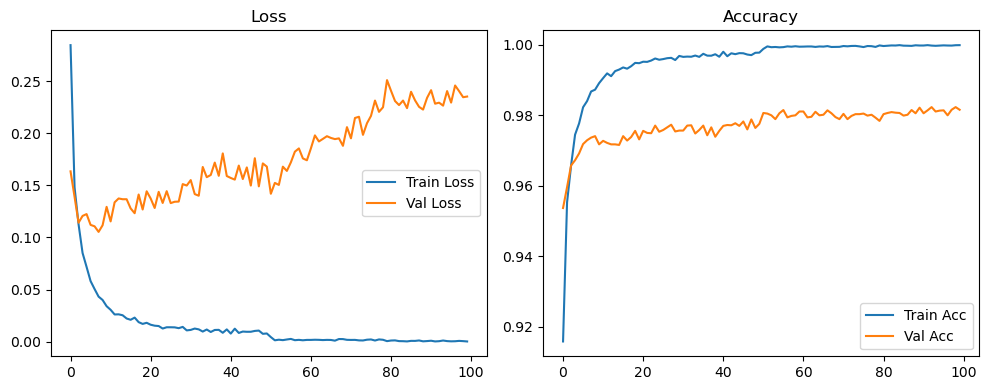

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3034, Acc: 0.9107 | Val Loss: 0.1653, Acc: 0.9527


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1721, Acc: 0.9500 | Val Loss: 0.1272, Acc: 0.9633


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1363, Acc: 0.9598 | Val Loss: 0.1202, Acc: 0.9672


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1109, Acc: 0.9664 | Val Loss: 0.1398, Acc: 0.9631


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0992, Acc: 0.9700 | Val Loss: 0.1186, Acc: 0.9674


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0810, Acc: 0.9765 | Val Loss: 0.1122, Acc: 0.9720


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0746, Acc: 0.9773 | Val Loss: 0.1155, Acc: 0.9718


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0671, Acc: 0.9801 | Val Loss: 0.1068, Acc: 0.9741


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0595, Acc: 0.9816 | Val Loss: 0.1207, Acc: 0.9718


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0626, Acc: 0.9816 | Val Loss: 0.1205, Acc: 0.9711


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0507, Acc: 0.9849 | Val Loss: 0.1290, Acc: 0.9730


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0490, Acc: 0.9856 | Val Loss: 0.1190, Acc: 0.9748


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9861 | Val Loss: 0.1338, Acc: 0.9734


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0420, Acc: 0.9885 | Val Loss: 0.1415, Acc: 0.9737


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9890 | Val Loss: 0.1236, Acc: 0.9758


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9882 | Val Loss: 0.1276, Acc: 0.9748


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9894 | Val Loss: 0.1410, Acc: 0.9752


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9902 | Val Loss: 0.1455, Acc: 0.9752


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9897 | Val Loss: 0.1587, Acc: 0.9742


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9902 | Val Loss: 0.1354, Acc: 0.9762


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9912 | Val Loss: 0.1638, Acc: 0.9759


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9904 | Val Loss: 0.1464, Acc: 0.9770


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9929 | Val Loss: 0.1545, Acc: 0.9775


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9919 | Val Loss: 0.1639, Acc: 0.9752


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9919 | Val Loss: 0.1638, Acc: 0.9763


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9932 | Val Loss: 0.1581, Acc: 0.9771


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9923 | Val Loss: 0.1615, Acc: 0.9758


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9927 | Val Loss: 0.1766, Acc: 0.9748


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9925 | Val Loss: 0.2032, Acc: 0.9737


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9934 | Val Loss: 0.1891, Acc: 0.9768


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9930 | Val Loss: 0.1899, Acc: 0.9750


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9934 | Val Loss: 0.2004, Acc: 0.9764


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9939 | Val Loss: 0.1748, Acc: 0.9760


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9933 | Val Loss: 0.1858, Acc: 0.9781


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9939 | Val Loss: 0.1886, Acc: 0.9762


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9937 | Val Loss: 0.2047, Acc: 0.9784


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9948 | Val Loss: 0.2121, Acc: 0.9757


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9945 | Val Loss: 0.2064, Acc: 0.9767


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9942 | Val Loss: 0.2207, Acc: 0.9763


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9935 | Val Loss: 0.2337, Acc: 0.9763


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9947 | Val Loss: 0.2393, Acc: 0.9759


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0253, Acc: 0.9951 | Val Loss: 0.2255, Acc: 0.9784


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9949 | Val Loss: 0.2181, Acc: 0.9778


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9948 | Val Loss: 0.2274, Acc: 0.9775


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9959 | Val Loss: 0.2141, Acc: 0.9792


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9949 | Val Loss: 0.2332, Acc: 0.9758


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9943 | Val Loss: 0.2564, Acc: 0.9758


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9958 | Val Loss: 0.2521, Acc: 0.9777


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9950 | Val Loss: 0.2588, Acc: 0.9773


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9958 | Val Loss: 0.2517, Acc: 0.9796


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9972 | Val Loss: 0.2214, Acc: 0.9793


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9978 | Val Loss: 0.2111, Acc: 0.9807


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.2207, Acc: 0.9800


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9982 | Val Loss: 0.2326, Acc: 0.9802


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9986 | Val Loss: 0.2226, Acc: 0.9803


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9979 | Val Loss: 0.2216, Acc: 0.9817


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.2333, Acc: 0.9811


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9986 | Val Loss: 0.2191, Acc: 0.9813


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9985 | Val Loss: 0.2487, Acc: 0.9810


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9985 | Val Loss: 0.2392, Acc: 0.9810


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9987 | Val Loss: 0.2312, Acc: 0.9817


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9984 | Val Loss: 0.2526, Acc: 0.9805


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9987 | Val Loss: 0.2380, Acc: 0.9815


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.2578, Acc: 0.9808


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.2527, Acc: 0.9801


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9988 | Val Loss: 0.2750, Acc: 0.9789


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9988 | Val Loss: 0.2598, Acc: 0.9805


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9990 | Val Loss: 0.2610, Acc: 0.9793


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9986 | Val Loss: 0.2799, Acc: 0.9801


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9987 | Val Loss: 0.2669, Acc: 0.9805


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9989 | Val Loss: 0.2554, Acc: 0.9809


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9988 | Val Loss: 0.2767, Acc: 0.9801


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9988 | Val Loss: 0.2796, Acc: 0.9801


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9990 | Val Loss: 0.2593, Acc: 0.9814


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.2907, Acc: 0.9798


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9989 | Val Loss: 0.2864, Acc: 0.9800


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9987 | Val Loss: 0.2970, Acc: 0.9791


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9991 | Val Loss: 0.2851, Acc: 0.9794


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9989 | Val Loss: 0.2603, Acc: 0.9817


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9991 | Val Loss: 0.2876, Acc: 0.9806


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.2778, Acc: 0.9812


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9991 | Val Loss: 0.2571, Acc: 0.9817


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.2670, Acc: 0.9817


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.2640, Acc: 0.9809


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9995 | Val Loss: 0.2584, Acc: 0.9822


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.2570, Acc: 0.9821


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.2651, Acc: 0.9822


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.2631, Acc: 0.9815


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.2992, Acc: 0.9808


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.2847, Acc: 0.9811


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.2944, Acc: 0.9810


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.3125, Acc: 0.9808


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.2910, Acc: 0.9814


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.2765, Acc: 0.9819


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9994 | Val Loss: 0.2862, Acc: 0.9808


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9996 | Val Loss: 0.2974, Acc: 0.9812


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.2966, Acc: 0.9802


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.2943, Acc: 0.9809


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.2964, Acc: 0.9813


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.3052, Acc: 0.9808


Final Test Loss: 0.3099 Accuracy: 0.9819


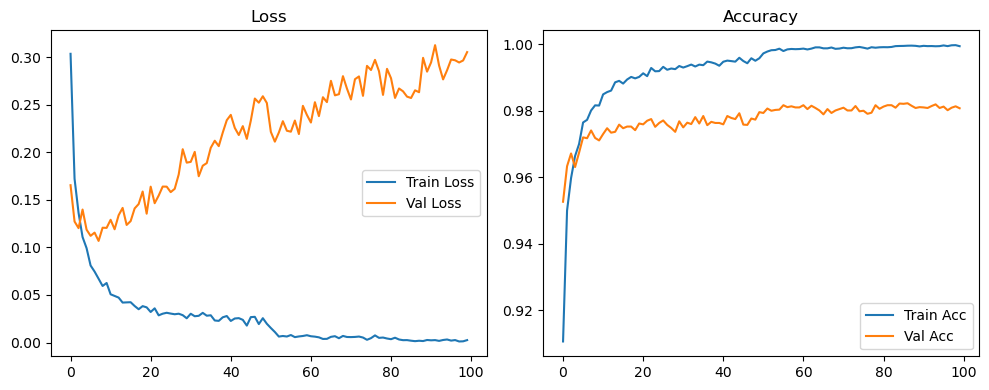

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3810, Acc: 0.8900 | Val Loss: 0.1789, Acc: 0.9483


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2446, Acc: 0.9294 | Val Loss: 0.1364, Acc: 0.9598


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2099, Acc: 0.9403 | Val Loss: 0.1202, Acc: 0.9643


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1851, Acc: 0.9460 | Val Loss: 0.1231, Acc: 0.9657


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1671, Acc: 0.9517 | Val Loss: 0.1187, Acc: 0.9681


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1584, Acc: 0.9561 | Val Loss: 0.1199, Acc: 0.9691


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1457, Acc: 0.9574 | Val Loss: 0.1205, Acc: 0.9694


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1377, Acc: 0.9613 | Val Loss: 0.1153, Acc: 0.9718


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1270, Acc: 0.9636 | Val Loss: 0.1140, Acc: 0.9728


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1295, Acc: 0.9645 | Val Loss: 0.1069, Acc: 0.9736


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1169, Acc: 0.9679 | Val Loss: 0.1153, Acc: 0.9735


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1160, Acc: 0.9679 | Val Loss: 0.1081, Acc: 0.9750


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1042, Acc: 0.9720 | Val Loss: 0.1104, Acc: 0.9768


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1060, Acc: 0.9729 | Val Loss: 0.1315, Acc: 0.9729


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1043, Acc: 0.9737 | Val Loss: 0.1102, Acc: 0.9760


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1002, Acc: 0.9748 | Val Loss: 0.1215, Acc: 0.9748


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0990, Acc: 0.9748 | Val Loss: 0.1243, Acc: 0.9740


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0932, Acc: 0.9764 | Val Loss: 0.1337, Acc: 0.9758


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0893, Acc: 0.9776 | Val Loss: 0.1453, Acc: 0.9757


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0932, Acc: 0.9769 | Val Loss: 0.1289, Acc: 0.9764


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0882, Acc: 0.9786 | Val Loss: 0.1440, Acc: 0.9734


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0889, Acc: 0.9788 | Val Loss: 0.1319, Acc: 0.9763


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0826, Acc: 0.9806 | Val Loss: 0.1375, Acc: 0.9758


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0838, Acc: 0.9805 | Val Loss: 0.1447, Acc: 0.9769


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0857, Acc: 0.9800 | Val Loss: 0.1392, Acc: 0.9770


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0867, Acc: 0.9804 | Val Loss: 0.1572, Acc: 0.9773


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0832, Acc: 0.9811 | Val Loss: 0.1622, Acc: 0.9762


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0782, Acc: 0.9819 | Val Loss: 0.1733, Acc: 0.9758


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0749, Acc: 0.9826 | Val Loss: 0.1693, Acc: 0.9772


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0775, Acc: 0.9832 | Val Loss: 0.1631, Acc: 0.9760


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0748, Acc: 0.9848 | Val Loss: 0.1511, Acc: 0.9778


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0783, Acc: 0.9835 | Val Loss: 0.1761, Acc: 0.9772


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0685, Acc: 0.9852 | Val Loss: 0.1773, Acc: 0.9774


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0757, Acc: 0.9849 | Val Loss: 0.1733, Acc: 0.9785


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0770, Acc: 0.9843 | Val Loss: 0.1638, Acc: 0.9762


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0733, Acc: 0.9855 | Val Loss: 0.1859, Acc: 0.9776


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0675, Acc: 0.9865 | Val Loss: 0.1816, Acc: 0.9774


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0676, Acc: 0.9862 | Val Loss: 0.1801, Acc: 0.9782


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0635, Acc: 0.9870 | Val Loss: 0.1953, Acc: 0.9791


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0743, Acc: 0.9857 | Val Loss: 0.2031, Acc: 0.9772


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0702, Acc: 0.9859 | Val Loss: 0.1857, Acc: 0.9782


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0749, Acc: 0.9859 | Val Loss: 0.1886, Acc: 0.9781


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0702, Acc: 0.9868 | Val Loss: 0.1889, Acc: 0.9784


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0635, Acc: 0.9878 | Val Loss: 0.2042, Acc: 0.9784


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0663, Acc: 0.9878 | Val Loss: 0.1859, Acc: 0.9792


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0693, Acc: 0.9876 | Val Loss: 0.2230, Acc: 0.9780


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0747, Acc: 0.9867 | Val Loss: 0.2124, Acc: 0.9773


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0643, Acc: 0.9882 | Val Loss: 0.2081, Acc: 0.9799


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0620, Acc: 0.9887 | Val Loss: 0.2148, Acc: 0.9789


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0621, Acc: 0.9889 | Val Loss: 0.2286, Acc: 0.9790


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0435, Acc: 0.9913 | Val Loss: 0.1985, Acc: 0.9805


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9918 | Val Loss: 0.1910, Acc: 0.9815


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9933 | Val Loss: 0.1901, Acc: 0.9828


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9940 | Val Loss: 0.1954, Acc: 0.9818


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9936 | Val Loss: 0.1908, Acc: 0.9809


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9944 | Val Loss: 0.2081, Acc: 0.9819


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9941 | Val Loss: 0.2002, Acc: 0.9813


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9945 | Val Loss: 0.2024, Acc: 0.9816


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9947 | Val Loss: 0.2100, Acc: 0.9795


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9951 | Val Loss: 0.2058, Acc: 0.9825


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9945 | Val Loss: 0.2080, Acc: 0.9808


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9945 | Val Loss: 0.2118, Acc: 0.9820


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9946 | Val Loss: 0.2040, Acc: 0.9791


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9943 | Val Loss: 0.2023, Acc: 0.9823


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9954 | Val Loss: 0.2082, Acc: 0.9804


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9953 | Val Loss: 0.2256, Acc: 0.9806


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9962 | Val Loss: 0.2585, Acc: 0.9801


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9954 | Val Loss: 0.2345, Acc: 0.9812


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9951 | Val Loss: 0.2322, Acc: 0.9815


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9954 | Val Loss: 0.2202, Acc: 0.9814


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9951 | Val Loss: 0.2336, Acc: 0.9818


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9955 | Val Loss: 0.2297, Acc: 0.9816


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9952 | Val Loss: 0.2217, Acc: 0.9819


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9954 | Val Loss: 0.2429, Acc: 0.9804


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9956 | Val Loss: 0.2333, Acc: 0.9802


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9961 | Val Loss: 0.2246, Acc: 0.9808


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9957 | Val Loss: 0.2215, Acc: 0.9818


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9958 | Val Loss: 0.2305, Acc: 0.9807


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9957 | Val Loss: 0.2395, Acc: 0.9813


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9956 | Val Loss: 0.2438, Acc: 0.9824


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9969 | Val Loss: 0.2310, Acc: 0.9825


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9965 | Val Loss: 0.2236, Acc: 0.9822


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9969 | Val Loss: 0.2283, Acc: 0.9819


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9966 | Val Loss: 0.2198, Acc: 0.9826


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9974 | Val Loss: 0.2273, Acc: 0.9827


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9970 | Val Loss: 0.2385, Acc: 0.9818


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9970 | Val Loss: 0.2452, Acc: 0.9819


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9974 | Val Loss: 0.2462, Acc: 0.9812


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9976 | Val Loss: 0.2430, Acc: 0.9813


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9973 | Val Loss: 0.2440, Acc: 0.9819


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9970 | Val Loss: 0.2482, Acc: 0.9817


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9973 | Val Loss: 0.2519, Acc: 0.9818


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9974 | Val Loss: 0.2435, Acc: 0.9822


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9972 | Val Loss: 0.2319, Acc: 0.9831


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9972 | Val Loss: 0.2353, Acc: 0.9822


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9971 | Val Loss: 0.2309, Acc: 0.9830


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9975 | Val Loss: 0.2285, Acc: 0.9818


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9976 | Val Loss: 0.2333, Acc: 0.9824


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9978 | Val Loss: 0.2385, Acc: 0.9834


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9978 | Val Loss: 0.2463, Acc: 0.9812


Final Test Loss: 0.2303 Accuracy: 0.9837


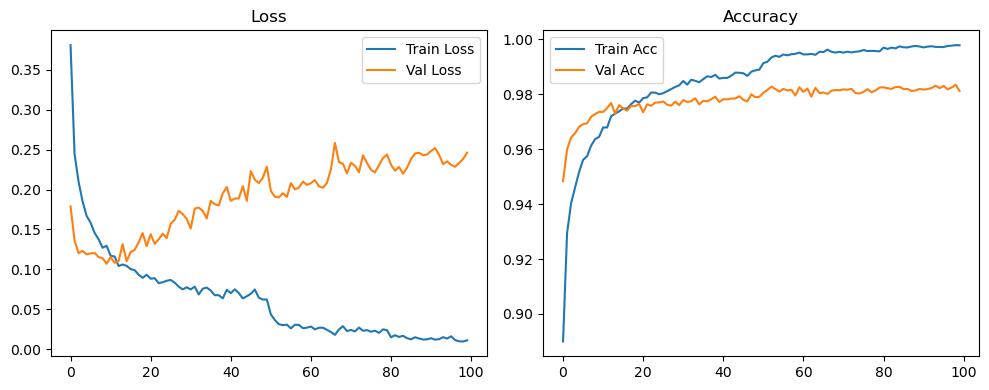

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2512, Acc: 0.9232 | Val Loss: 0.1479, Acc: 0.9573


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1292, Acc: 0.9606 | Val Loss: 0.1184, Acc: 0.9643


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1000, Acc: 0.9695 | Val Loss: 0.1112, Acc: 0.9688


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0776, Acc: 0.9754 | Val Loss: 0.1245, Acc: 0.9637


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0671, Acc: 0.9785 | Val Loss: 0.1124, Acc: 0.9683


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0569, Acc: 0.9819 | Val Loss: 0.1170, Acc: 0.9702


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0492, Acc: 0.9841 | Val Loss: 0.1024, Acc: 0.9749


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0417, Acc: 0.9860 | Val Loss: 0.1136, Acc: 0.9736


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0386, Acc: 0.9875 | Val Loss: 0.1118, Acc: 0.9748


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9895 | Val Loss: 0.1149, Acc: 0.9739


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0348, Acc: 0.9896 | Val Loss: 0.1316, Acc: 0.9705


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9910 | Val Loss: 0.1148, Acc: 0.9748


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9915 | Val Loss: 0.1268, Acc: 0.9725


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9925 | Val Loss: 0.1374, Acc: 0.9725


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9929 | Val Loss: 0.1361, Acc: 0.9721


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9935 | Val Loss: 0.1221, Acc: 0.9756


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9942 | Val Loss: 0.1457, Acc: 0.9737


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.1355, Acc: 0.9738


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0175, Acc: 0.9946 | Val Loss: 0.1407, Acc: 0.9743


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9954 | Val Loss: 0.1448, Acc: 0.9732


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9943 | Val Loss: 0.1331, Acc: 0.9750


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9952 | Val Loss: 0.1389, Acc: 0.9744


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.1380, Acc: 0.9772


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9962 | Val Loss: 0.1427, Acc: 0.9761


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9958 | Val Loss: 0.1449, Acc: 0.9752


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1435, Acc: 0.9749


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1521, Acc: 0.9737


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9961 | Val Loss: 0.1366, Acc: 0.9752


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1337, Acc: 0.9757


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.1352, Acc: 0.9762


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1450, Acc: 0.9750


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9968 | Val Loss: 0.1624, Acc: 0.9752


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9970 | Val Loss: 0.1430, Acc: 0.9768


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9970 | Val Loss: 0.1425, Acc: 0.9766


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9967 | Val Loss: 0.1380, Acc: 0.9772


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1432, Acc: 0.9762


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1749, Acc: 0.9759


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9970 | Val Loss: 0.1550, Acc: 0.9754


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1712, Acc: 0.9748


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9971 | Val Loss: 0.1389, Acc: 0.9785


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1538, Acc: 0.9779


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9973 | Val Loss: 0.1614, Acc: 0.9758


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.1535, Acc: 0.9766


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1595, Acc: 0.9764


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.1706, Acc: 0.9748


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1696, Acc: 0.9752


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9974 | Val Loss: 0.1727, Acc: 0.9759


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9976 | Val Loss: 0.1455, Acc: 0.9778


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1637, Acc: 0.9770


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.1738, Acc: 0.9776


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1638, Acc: 0.9778


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1549, Acc: 0.9789


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9984 | Val Loss: 0.1518, Acc: 0.9775


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9982 | Val Loss: 0.1722, Acc: 0.9777


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1818, Acc: 0.9757


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9987 | Val Loss: 0.1729, Acc: 0.9760


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.1783, Acc: 0.9758


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9986 | Val Loss: 0.1910, Acc: 0.9745


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1777, Acc: 0.9758


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9984 | Val Loss: 0.1803, Acc: 0.9751


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1686, Acc: 0.9782


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1746, Acc: 0.9762


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9981 | Val Loss: 0.1880, Acc: 0.9764


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9985 | Val Loss: 0.1634, Acc: 0.9778


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1987, Acc: 0.9768


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1973, Acc: 0.9773


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9980 | Val Loss: 0.1987, Acc: 0.9773


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9982 | Val Loss: 0.1623, Acc: 0.9782


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9989 | Val Loss: 0.1910, Acc: 0.9763


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1946, Acc: 0.9768


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1802, Acc: 0.9778


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1972, Acc: 0.9760


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9983 | Val Loss: 0.1757, Acc: 0.9772


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1793, Acc: 0.9779


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1836, Acc: 0.9778


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.2042, Acc: 0.9754


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1880, Acc: 0.9769


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.2130, Acc: 0.9773


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.2027, Acc: 0.9771


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9980 | Val Loss: 0.1985, Acc: 0.9758


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9990 | Val Loss: 0.1748, Acc: 0.9794


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1783, Acc: 0.9801


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.1856, Acc: 0.9768


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1798, Acc: 0.9788


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9989 | Val Loss: 0.1952, Acc: 0.9765


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9981 | Val Loss: 0.2384, Acc: 0.9761


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.2081, Acc: 0.9775


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9989 | Val Loss: 0.2096, Acc: 0.9774


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1928, Acc: 0.9788


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.2087, Acc: 0.9789


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9985 | Val Loss: 0.2028, Acc: 0.9788


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9988 | Val Loss: 0.1884, Acc: 0.9777


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.2260, Acc: 0.9782


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9986 | Val Loss: 0.2097, Acc: 0.9781


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9992 | Val Loss: 0.2247, Acc: 0.9779


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.2250, Acc: 0.9772


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9987 | Val Loss: 0.2011, Acc: 0.9799


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.2254, Acc: 0.9775


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9988 | Val Loss: 0.2016, Acc: 0.9803


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.2265, Acc: 0.9786


Final Test Loss: 0.2040 Accuracy: 0.9811


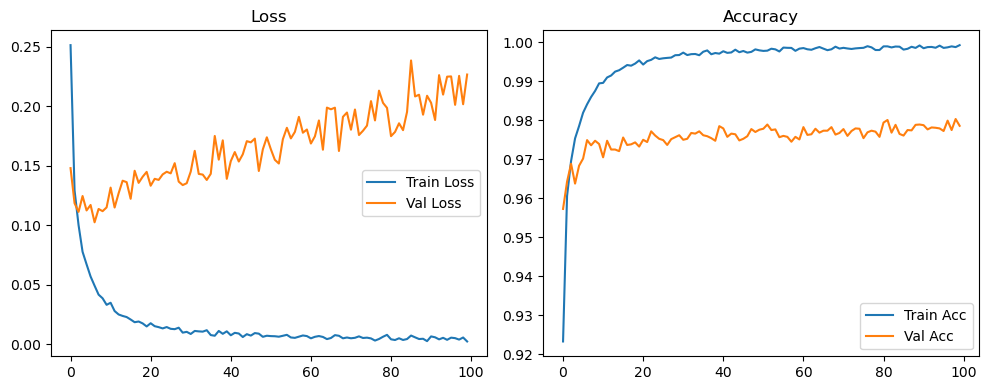

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2692, Acc: 0.9186 | Val Loss: 0.1575, Acc: 0.9538


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1484, Acc: 0.9548 | Val Loss: 0.1173, Acc: 0.9631


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1170, Acc: 0.9636 | Val Loss: 0.1071, Acc: 0.9690


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0973, Acc: 0.9693 | Val Loss: 0.1152, Acc: 0.9674


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0855, Acc: 0.9731 | Val Loss: 0.1092, Acc: 0.9683


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0754, Acc: 0.9760 | Val Loss: 0.1080, Acc: 0.9713


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0661, Acc: 0.9790 | Val Loss: 0.1087, Acc: 0.9716


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0588, Acc: 0.9814 | Val Loss: 0.1012, Acc: 0.9748


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0548, Acc: 0.9822 | Val Loss: 0.1048, Acc: 0.9742


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0522, Acc: 0.9835 | Val Loss: 0.1069, Acc: 0.9721


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0429, Acc: 0.9863 | Val Loss: 0.1162, Acc: 0.9719


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0418, Acc: 0.9864 | Val Loss: 0.1050, Acc: 0.9749


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0394, Acc: 0.9869 | Val Loss: 0.1220, Acc: 0.9719


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0374, Acc: 0.9880 | Val Loss: 0.1136, Acc: 0.9751


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0357, Acc: 0.9885 | Val Loss: 0.1103, Acc: 0.9757


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9894 | Val Loss: 0.1189, Acc: 0.9744


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9904 | Val Loss: 0.1297, Acc: 0.9741


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9906 | Val Loss: 0.1226, Acc: 0.9770


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9926 | Val Loss: 0.1317, Acc: 0.9738


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9912 | Val Loss: 0.1257, Acc: 0.9762


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.1315, Acc: 0.9747


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9922 | Val Loss: 0.1344, Acc: 0.9741


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.1306, Acc: 0.9757


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9923 | Val Loss: 0.1219, Acc: 0.9779


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9929 | Val Loss: 0.1287, Acc: 0.9778


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.1413, Acc: 0.9754


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9935 | Val Loss: 0.1441, Acc: 0.9752


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9937 | Val Loss: 0.1585, Acc: 0.9748


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9939 | Val Loss: 0.1510, Acc: 0.9755


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9940 | Val Loss: 0.1390, Acc: 0.9753


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9946 | Val Loss: 0.1482, Acc: 0.9769


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9945 | Val Loss: 0.1446, Acc: 0.9772


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9947 | Val Loss: 0.1505, Acc: 0.9764


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9943 | Val Loss: 0.1894, Acc: 0.9738


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9949 | Val Loss: 0.1433, Acc: 0.9752


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9946 | Val Loss: 0.1649, Acc: 0.9752


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9954 | Val Loss: 0.1593, Acc: 0.9777


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9950 | Val Loss: 0.1761, Acc: 0.9750


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9953 | Val Loss: 0.1518, Acc: 0.9785


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9953 | Val Loss: 0.1616, Acc: 0.9765


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9962 | Val Loss: 0.1821, Acc: 0.9766


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9954 | Val Loss: 0.1922, Acc: 0.9762


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9951 | Val Loss: 0.1600, Acc: 0.9788


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9954 | Val Loss: 0.1681, Acc: 0.9778


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9964 | Val Loss: 0.1538, Acc: 0.9788


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9962 | Val Loss: 0.1518, Acc: 0.9793


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.1672, Acc: 0.9776


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9962 | Val Loss: 0.1675, Acc: 0.9776


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9963 | Val Loss: 0.1818, Acc: 0.9747


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9956 | Val Loss: 0.1985, Acc: 0.9764


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9959 | Val Loss: 0.1841, Acc: 0.9776


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9966 | Val Loss: 0.1871, Acc: 0.9777


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9968 | Val Loss: 0.1800, Acc: 0.9783


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9961 | Val Loss: 0.1954, Acc: 0.9775


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9965 | Val Loss: 0.1849, Acc: 0.9775


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9963 | Val Loss: 0.1820, Acc: 0.9771


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9968 | Val Loss: 0.1868, Acc: 0.9784


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9969 | Val Loss: 0.1881, Acc: 0.9776


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9962 | Val Loss: 0.1808, Acc: 0.9778


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9970 | Val Loss: 0.1780, Acc: 0.9768


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9966 | Val Loss: 0.1907, Acc: 0.9768


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9969 | Val Loss: 0.1926, Acc: 0.9780


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9965 | Val Loss: 0.1752, Acc: 0.9782


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9972 | Val Loss: 0.1856, Acc: 0.9773


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9969 | Val Loss: 0.1854, Acc: 0.9767


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9970 | Val Loss: 0.1771, Acc: 0.9788


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9970 | Val Loss: 0.1941, Acc: 0.9768


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9974 | Val Loss: 0.2025, Acc: 0.9789


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9968 | Val Loss: 0.2094, Acc: 0.9781


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9975 | Val Loss: 0.1896, Acc: 0.9788


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9974 | Val Loss: 0.2113, Acc: 0.9775


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9968 | Val Loss: 0.1899, Acc: 0.9788


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9972 | Val Loss: 0.1927, Acc: 0.9794


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9973 | Val Loss: 0.2124, Acc: 0.9782


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9969 | Val Loss: 0.2129, Acc: 0.9794


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9973 | Val Loss: 0.2114, Acc: 0.9793


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9979 | Val Loss: 0.2180, Acc: 0.9786


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9972 | Val Loss: 0.2031, Acc: 0.9779


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9972 | Val Loss: 0.2038, Acc: 0.9782


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9972 | Val Loss: 0.1907, Acc: 0.9789


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9979 | Val Loss: 0.2052, Acc: 0.9798


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9972 | Val Loss: 0.2068, Acc: 0.9780


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9970 | Val Loss: 0.2216, Acc: 0.9783


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9979 | Val Loss: 0.2135, Acc: 0.9782


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9974 | Val Loss: 0.1981, Acc: 0.9776


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9976 | Val Loss: 0.1936, Acc: 0.9792


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.2085, Acc: 0.9798


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9979 | Val Loss: 0.2276, Acc: 0.9763


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9975 | Val Loss: 0.2161, Acc: 0.9792


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9981 | Val Loss: 0.2260, Acc: 0.9780


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9969 | Val Loss: 0.2080, Acc: 0.9782


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9976 | Val Loss: 0.2096, Acc: 0.9777


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9979 | Val Loss: 0.2308, Acc: 0.9776


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9976 | Val Loss: 0.2290, Acc: 0.9777


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9979 | Val Loss: 0.2291, Acc: 0.9787


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9975 | Val Loss: 0.2160, Acc: 0.9795


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9975 | Val Loss: 0.2131, Acc: 0.9802


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9980 | Val Loss: 0.2413, Acc: 0.9776


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9983 | Val Loss: 0.2523, Acc: 0.9785


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9976 | Val Loss: 0.2538, Acc: 0.9780


Final Test Loss: 0.2285 Accuracy: 0.9801


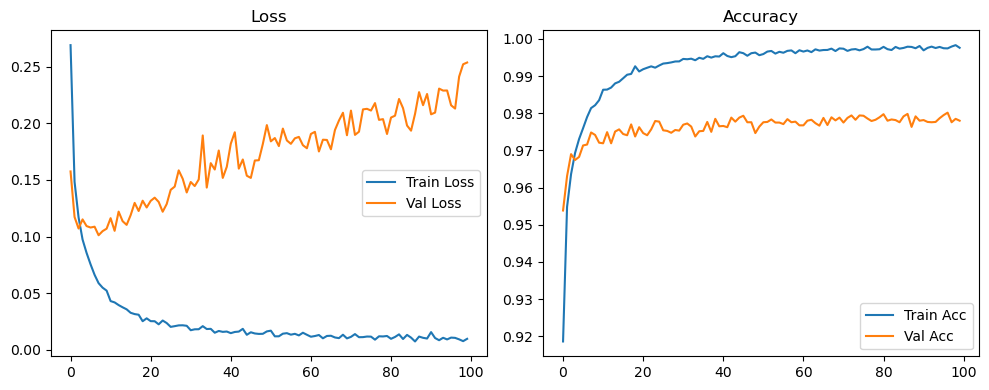

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3330, Acc: 0.9010 | Val Loss: 0.1568, Acc: 0.9533


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2080, Acc: 0.9373 | Val Loss: 0.1299, Acc: 0.9603


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1750, Acc: 0.9466 | Val Loss: 0.1177, Acc: 0.9644


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1558, Acc: 0.9522 | Val Loss: 0.1199, Acc: 0.9657


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1381, Acc: 0.9581 | Val Loss: 0.0988, Acc: 0.9708


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1305, Acc: 0.9600 | Val Loss: 0.0983, Acc: 0.9714


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1175, Acc: 0.9639 | Val Loss: 0.0969, Acc: 0.9713


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1123, Acc: 0.9655 | Val Loss: 0.1025, Acc: 0.9725


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1074, Acc: 0.9661 | Val Loss: 0.0933, Acc: 0.9748


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1031, Acc: 0.9686 | Val Loss: 0.0932, Acc: 0.9744


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0897, Acc: 0.9725 | Val Loss: 0.0972, Acc: 0.9746


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0896, Acc: 0.9716 | Val Loss: 0.1029, Acc: 0.9739


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0802, Acc: 0.9748 | Val Loss: 0.1015, Acc: 0.9748


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0786, Acc: 0.9743 | Val Loss: 0.1033, Acc: 0.9742


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0764, Acc: 0.9769 | Val Loss: 0.0974, Acc: 0.9762


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0739, Acc: 0.9777 | Val Loss: 0.0968, Acc: 0.9769


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0701, Acc: 0.9783 | Val Loss: 0.1038, Acc: 0.9770


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0690, Acc: 0.9797 | Val Loss: 0.1019, Acc: 0.9766


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0690, Acc: 0.9789 | Val Loss: 0.1011, Acc: 0.9771


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0670, Acc: 0.9799 | Val Loss: 0.1021, Acc: 0.9781


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0590, Acc: 0.9818 | Val Loss: 0.1082, Acc: 0.9775


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0636, Acc: 0.9815 | Val Loss: 0.1129, Acc: 0.9752


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0551, Acc: 0.9838 | Val Loss: 0.1207, Acc: 0.9762


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0565, Acc: 0.9831 | Val Loss: 0.1100, Acc: 0.9782


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0577, Acc: 0.9825 | Val Loss: 0.1111, Acc: 0.9771


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0541, Acc: 0.9839 | Val Loss: 0.1136, Acc: 0.9781


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0536, Acc: 0.9841 | Val Loss: 0.1212, Acc: 0.9759


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0592, Acc: 0.9838 | Val Loss: 0.1138, Acc: 0.9768


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0497, Acc: 0.9851 | Val Loss: 0.1138, Acc: 0.9792


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0475, Acc: 0.9865 | Val Loss: 0.1194, Acc: 0.9778


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0466, Acc: 0.9864 | Val Loss: 0.1327, Acc: 0.9771


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0503, Acc: 0.9860 | Val Loss: 0.1210, Acc: 0.9788


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0471, Acc: 0.9862 | Val Loss: 0.1128, Acc: 0.9790


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0460, Acc: 0.9867 | Val Loss: 0.1296, Acc: 0.9788


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0467, Acc: 0.9874 | Val Loss: 0.1190, Acc: 0.9785


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0424, Acc: 0.9873 | Val Loss: 0.1213, Acc: 0.9792


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0441, Acc: 0.9878 | Val Loss: 0.1316, Acc: 0.9774


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0436, Acc: 0.9875 | Val Loss: 0.1191, Acc: 0.9798


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0457, Acc: 0.9882 | Val Loss: 0.1179, Acc: 0.9797


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0449, Acc: 0.9875 | Val Loss: 0.1450, Acc: 0.9772


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0428, Acc: 0.9880 | Val Loss: 0.1345, Acc: 0.9791


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0408, Acc: 0.9886 | Val Loss: 0.1425, Acc: 0.9778


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0431, Acc: 0.9887 | Val Loss: 0.1402, Acc: 0.9774


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0406, Acc: 0.9884 | Val Loss: 0.1350, Acc: 0.9795


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0431, Acc: 0.9886 | Val Loss: 0.1343, Acc: 0.9771


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0430, Acc: 0.9881 | Val Loss: 0.1450, Acc: 0.9785


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0404, Acc: 0.9890 | Val Loss: 0.1494, Acc: 0.9772


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0394, Acc: 0.9896 | Val Loss: 0.1406, Acc: 0.9795


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0381, Acc: 0.9894 | Val Loss: 0.1568, Acc: 0.9772


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9903 | Val Loss: 0.1466, Acc: 0.9792


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0402, Acc: 0.9897 | Val Loss: 0.1454, Acc: 0.9793


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0389, Acc: 0.9901 | Val Loss: 0.1591, Acc: 0.9787


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0380, Acc: 0.9894 | Val Loss: 0.1588, Acc: 0.9789


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0362, Acc: 0.9906 | Val Loss: 0.1573, Acc: 0.9778


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0374, Acc: 0.9904 | Val Loss: 0.1535, Acc: 0.9790


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0374, Acc: 0.9907 | Val Loss: 0.1581, Acc: 0.9785


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0379, Acc: 0.9906 | Val Loss: 0.1539, Acc: 0.9794


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9900 | Val Loss: 0.1422, Acc: 0.9802


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0336, Acc: 0.9913 | Val Loss: 0.1529, Acc: 0.9802


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0348, Acc: 0.9910 | Val Loss: 0.1492, Acc: 0.9806


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0373, Acc: 0.9911 | Val Loss: 0.1441, Acc: 0.9798


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9917 | Val Loss: 0.1702, Acc: 0.9805


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0303, Acc: 0.9928 | Val Loss: 0.1595, Acc: 0.9789


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0381, Acc: 0.9909 | Val Loss: 0.1596, Acc: 0.9783


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9917 | Val Loss: 0.1556, Acc: 0.9798


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0362, Acc: 0.9914 | Val Loss: 0.1565, Acc: 0.9792


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9918 | Val Loss: 0.1654, Acc: 0.9793


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0360, Acc: 0.9921 | Val Loss: 0.1590, Acc: 0.9810


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0330, Acc: 0.9916 | Val Loss: 0.1613, Acc: 0.9802


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0342, Acc: 0.9916 | Val Loss: 0.1574, Acc: 0.9798


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9924 | Val Loss: 0.1698, Acc: 0.9798


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9927 | Val Loss: 0.1725, Acc: 0.9789


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9925 | Val Loss: 0.1718, Acc: 0.9811


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0344, Acc: 0.9919 | Val Loss: 0.1691, Acc: 0.9802


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9925 | Val Loss: 0.1757, Acc: 0.9795


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9925 | Val Loss: 0.1776, Acc: 0.9773


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9928 | Val Loss: 0.1887, Acc: 0.9788


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9930 | Val Loss: 0.1940, Acc: 0.9787


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9927 | Val Loss: 0.1776, Acc: 0.9787


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0373, Acc: 0.9920 | Val Loss: 0.1712, Acc: 0.9814


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9929 | Val Loss: 0.1777, Acc: 0.9817


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9928 | Val Loss: 0.1716, Acc: 0.9797


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9930 | Val Loss: 0.1905, Acc: 0.9791


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9938 | Val Loss: 0.1788, Acc: 0.9799


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9930 | Val Loss: 0.1750, Acc: 0.9792


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9931 | Val Loss: 0.1780, Acc: 0.9807


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9938 | Val Loss: 0.2140, Acc: 0.9792


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9932 | Val Loss: 0.1774, Acc: 0.9794


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9927 | Val Loss: 0.1766, Acc: 0.9817


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9934 | Val Loss: 0.1842, Acc: 0.9804


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0322, Acc: 0.9934 | Val Loss: 0.1893, Acc: 0.9797


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0322, Acc: 0.9934 | Val Loss: 0.1846, Acc: 0.9802


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0272, Acc: 0.9942 | Val Loss: 0.1864, Acc: 0.9797


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9940 | Val Loss: 0.1890, Acc: 0.9803


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9931 | Val Loss: 0.1890, Acc: 0.9799


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9938 | Val Loss: 0.1819, Acc: 0.9802


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9944 | Val Loss: 0.1962, Acc: 0.9784


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9941 | Val Loss: 0.1849, Acc: 0.9814


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9941 | Val Loss: 0.1845, Acc: 0.9801


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9938 | Val Loss: 0.1855, Acc: 0.9814


Final Test Loss: 0.1633 Accuracy: 0.9821


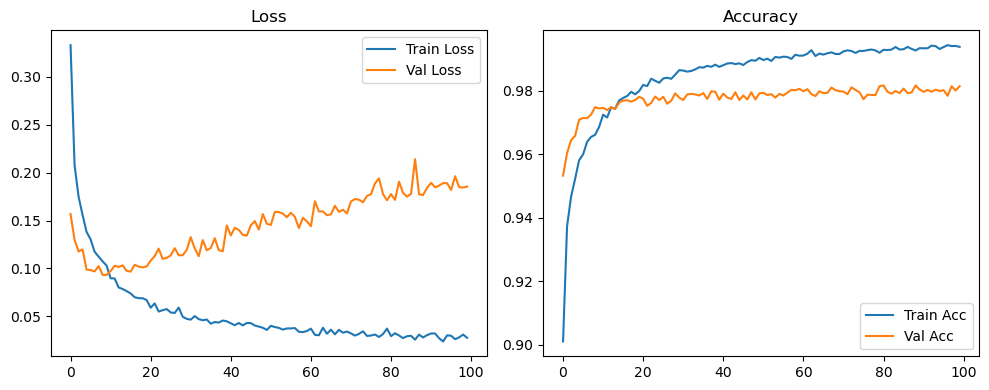

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2335, Acc: 0.9296 | Val Loss: 0.1439, Acc: 0.9579


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1181, Acc: 0.9633 | Val Loss: 0.1071, Acc: 0.9647


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0881, Acc: 0.9730 | Val Loss: 0.0995, Acc: 0.9705


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0685, Acc: 0.9785 | Val Loss: 0.1127, Acc: 0.9663


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0593, Acc: 0.9806 | Val Loss: 0.0987, Acc: 0.9722


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0497, Acc: 0.9838 | Val Loss: 0.1007, Acc: 0.9718


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0434, Acc: 0.9857 | Val Loss: 0.0950, Acc: 0.9735


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0388, Acc: 0.9876 | Val Loss: 0.1128, Acc: 0.9725


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0345, Acc: 0.9891 | Val Loss: 0.1054, Acc: 0.9740


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9890 | Val Loss: 0.1074, Acc: 0.9732


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0301, Acc: 0.9901 | Val Loss: 0.1293, Acc: 0.9720


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9914 | Val Loss: 0.1153, Acc: 0.9726


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9918 | Val Loss: 0.1086, Acc: 0.9752


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9925 | Val Loss: 0.1253, Acc: 0.9741


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.1059, Acc: 0.9772


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9937 | Val Loss: 0.1229, Acc: 0.9745


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9934 | Val Loss: 0.1328, Acc: 0.9729


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9954 | Val Loss: 0.1199, Acc: 0.9750


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9936 | Val Loss: 0.1323, Acc: 0.9715


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9947 | Val Loss: 0.1108, Acc: 0.9765


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.1092, Acc: 0.9755


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9947 | Val Loss: 0.1126, Acc: 0.9764


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9956 | Val Loss: 0.1234, Acc: 0.9752


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9955 | Val Loss: 0.1228, Acc: 0.9778


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9960 | Val Loss: 0.1408, Acc: 0.9739


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.1413, Acc: 0.9739


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9960 | Val Loss: 0.1360, Acc: 0.9738


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9964 | Val Loss: 0.1305, Acc: 0.9758


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9976 | Val Loss: 0.1448, Acc: 0.9762


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.1348, Acc: 0.9757


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1431, Acc: 0.9749


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1409, Acc: 0.9761


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1560, Acc: 0.9745


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.1572, Acc: 0.9754


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.1483, Acc: 0.9750


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.1361, Acc: 0.9761


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1413, Acc: 0.9768


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.1371, Acc: 0.9770


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1386, Acc: 0.9770


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.1463, Acc: 0.9763


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1431, Acc: 0.9772


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1627, Acc: 0.9758


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1465, Acc: 0.9790


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1602, Acc: 0.9762


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1562, Acc: 0.9758


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1574, Acc: 0.9768


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.1722, Acc: 0.9717


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1382, Acc: 0.9788


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1721, Acc: 0.9740


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.1755, Acc: 0.9760


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.1619, Acc: 0.9763


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9974 | Val Loss: 0.1625, Acc: 0.9760


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1629, Acc: 0.9762


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9982 | Val Loss: 0.1604, Acc: 0.9767


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9984 | Val Loss: 0.1386, Acc: 0.9786


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1501, Acc: 0.9779


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1582, Acc: 0.9774


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1466, Acc: 0.9785


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1589, Acc: 0.9778


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1693, Acc: 0.9774


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1692, Acc: 0.9782


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9983 | Val Loss: 0.1579, Acc: 0.9792


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9985 | Val Loss: 0.1776, Acc: 0.9777


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1733, Acc: 0.9765


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1649, Acc: 0.9782


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1832, Acc: 0.9784


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1796, Acc: 0.9768


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1693, Acc: 0.9756


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1585, Acc: 0.9783


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9989 | Val Loss: 0.1596, Acc: 0.9796


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.1752, Acc: 0.9768


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1653, Acc: 0.9776


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1539, Acc: 0.9770


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1732, Acc: 0.9768


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1827, Acc: 0.9762


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1718, Acc: 0.9778


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9987 | Val Loss: 0.1795, Acc: 0.9767


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1860, Acc: 0.9772


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1658, Acc: 0.9770


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1709, Acc: 0.9779


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9988 | Val Loss: 0.1587, Acc: 0.9787


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1699, Acc: 0.9788


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1855, Acc: 0.9778


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9984 | Val Loss: 0.1761, Acc: 0.9776


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1884, Acc: 0.9767


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1849, Acc: 0.9781


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1798, Acc: 0.9781


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1944, Acc: 0.9778


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1741, Acc: 0.9786


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1787, Acc: 0.9784


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1876, Acc: 0.9766


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.2001, Acc: 0.9777


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1904, Acc: 0.9774


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.1676, Acc: 0.9796


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1770, Acc: 0.9790


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1928, Acc: 0.9773


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9990 | Val Loss: 0.1775, Acc: 0.9784


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.1932, Acc: 0.9795


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.1910, Acc: 0.9787


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.2087, Acc: 0.9757


Final Test Loss: 0.1796 Accuracy: 0.9772


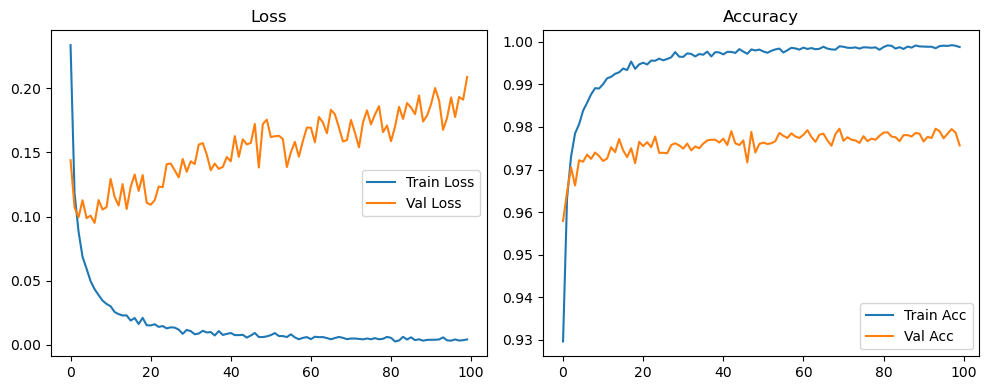

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2550, Acc: 0.9232 | Val Loss: 0.1478, Acc: 0.9543


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1376, Acc: 0.9576 | Val Loss: 0.1143, Acc: 0.9648


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1072, Acc: 0.9663 | Val Loss: 0.0991, Acc: 0.9699


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0837, Acc: 0.9731 | Val Loss: 0.1160, Acc: 0.9659


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0735, Acc: 0.9765 | Val Loss: 0.1035, Acc: 0.9700


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0665, Acc: 0.9779 | Val Loss: 0.0931, Acc: 0.9721


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0569, Acc: 0.9818 | Val Loss: 0.0997, Acc: 0.9736


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0514, Acc: 0.9830 | Val Loss: 0.0991, Acc: 0.9736


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0489, Acc: 0.9839 | Val Loss: 0.1014, Acc: 0.9726


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0441, Acc: 0.9862 | Val Loss: 0.1092, Acc: 0.9721


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0392, Acc: 0.9872 | Val Loss: 0.1104, Acc: 0.9726


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0372, Acc: 0.9881 | Val Loss: 0.1050, Acc: 0.9740


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0336, Acc: 0.9887 | Val Loss: 0.1071, Acc: 0.9745


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0323, Acc: 0.9895 | Val Loss: 0.1077, Acc: 0.9752


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9898 | Val Loss: 0.1074, Acc: 0.9752


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0304, Acc: 0.9897 | Val Loss: 0.1046, Acc: 0.9747


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0270, Acc: 0.9913 | Val Loss: 0.1102, Acc: 0.9754


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9918 | Val Loss: 0.1148, Acc: 0.9754


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9918 | Val Loss: 0.1262, Acc: 0.9747


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.1178, Acc: 0.9768


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9915 | Val Loss: 0.1186, Acc: 0.9761


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9939 | Val Loss: 0.1142, Acc: 0.9768


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9925 | Val Loss: 0.1098, Acc: 0.9782


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9941 | Val Loss: 0.1127, Acc: 0.9764


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9930 | Val Loss: 0.1241, Acc: 0.9755


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9932 | Val Loss: 0.1059, Acc: 0.9791


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9930 | Val Loss: 0.1170, Acc: 0.9776


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9945 | Val Loss: 0.1207, Acc: 0.9774


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9948 | Val Loss: 0.1336, Acc: 0.9771


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9945 | Val Loss: 0.1338, Acc: 0.9758


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9949 | Val Loss: 0.1263, Acc: 0.9767


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9945 | Val Loss: 0.1230, Acc: 0.9782


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9954 | Val Loss: 0.1186, Acc: 0.9778


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.1327, Acc: 0.9769


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9952 | Val Loss: 0.1297, Acc: 0.9761


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.1340, Acc: 0.9757


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.1389, Acc: 0.9759


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.1166, Acc: 0.9770


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9960 | Val Loss: 0.1200, Acc: 0.9807


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9951 | Val Loss: 0.1278, Acc: 0.9780


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.1286, Acc: 0.9779


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1368, Acc: 0.9783


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9959 | Val Loss: 0.1321, Acc: 0.9772


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9959 | Val Loss: 0.1358, Acc: 0.9762


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1251, Acc: 0.9793


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.1372, Acc: 0.9782


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.1430, Acc: 0.9767


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1516, Acc: 0.9778


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.1556, Acc: 0.9758


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.1579, Acc: 0.9772


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9960 | Val Loss: 0.1436, Acc: 0.9781


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1377, Acc: 0.9780


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9965 | Val Loss: 0.1502, Acc: 0.9780


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9971 | Val Loss: 0.1533, Acc: 0.9772


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 0.1392, Acc: 0.9792


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.1572, Acc: 0.9772


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9969 | Val Loss: 0.1617, Acc: 0.9775


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9967 | Val Loss: 0.1580, Acc: 0.9782


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1526, Acc: 0.9776


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1477, Acc: 0.9765


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9969 | Val Loss: 0.1464, Acc: 0.9788


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.1630, Acc: 0.9777


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1617, Acc: 0.9762


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.1468, Acc: 0.9781


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1586, Acc: 0.9789


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9975 | Val Loss: 0.1589, Acc: 0.9786


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1567, Acc: 0.9780


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1693, Acc: 0.9768


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9971 | Val Loss: 0.1588, Acc: 0.9794


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1682, Acc: 0.9783


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9973 | Val Loss: 0.1517, Acc: 0.9798


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9972 | Val Loss: 0.1701, Acc: 0.9776


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9977 | Val Loss: 0.1695, Acc: 0.9782


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9974 | Val Loss: 0.1590, Acc: 0.9790


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9976 | Val Loss: 0.1701, Acc: 0.9772


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9976 | Val Loss: 0.1624, Acc: 0.9779


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1549, Acc: 0.9792


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1700, Acc: 0.9782


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9979 | Val Loss: 0.1652, Acc: 0.9780


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1655, Acc: 0.9792


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9969 | Val Loss: 0.1767, Acc: 0.9773


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1507, Acc: 0.9797


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9977 | Val Loss: 0.1673, Acc: 0.9778


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9977 | Val Loss: 0.1615, Acc: 0.9786


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1556, Acc: 0.9782


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9976 | Val Loss: 0.1736, Acc: 0.9779


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1756, Acc: 0.9778


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1854, Acc: 0.9782


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1660, Acc: 0.9796


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1892, Acc: 0.9769


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1822, Acc: 0.9782


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9977 | Val Loss: 0.1816, Acc: 0.9782


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9978 | Val Loss: 0.1713, Acc: 0.9791


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9977 | Val Loss: 0.1726, Acc: 0.9788


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.1751, Acc: 0.9789


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9980 | Val Loss: 0.1678, Acc: 0.9792


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9980 | Val Loss: 0.1852, Acc: 0.9778


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9983 | Val Loss: 0.1818, Acc: 0.9784


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.1836, Acc: 0.9798


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9985 | Val Loss: 0.1866, Acc: 0.9791


Final Test Loss: 0.1842 Accuracy: 0.9788


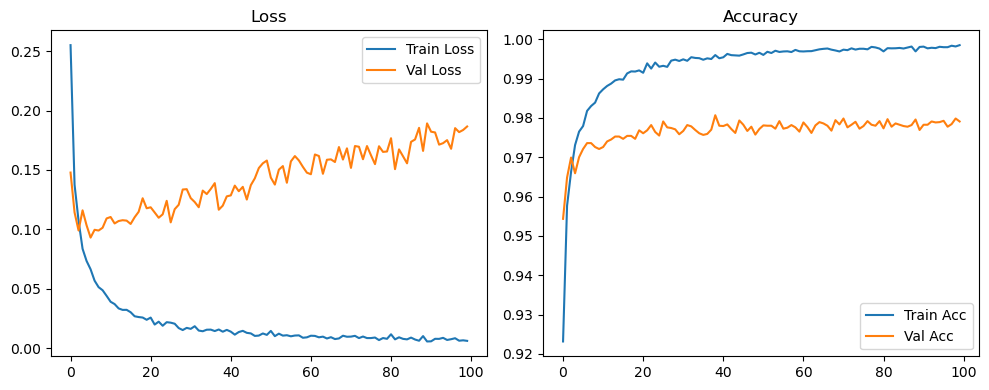

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3268, Acc: 0.9010 | Val Loss: 0.1562, Acc: 0.9523


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1912, Acc: 0.9423 | Val Loss: 0.1218, Acc: 0.9633


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1592, Acc: 0.9512 | Val Loss: 0.1097, Acc: 0.9671


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1399, Acc: 0.9565 | Val Loss: 0.1066, Acc: 0.9669


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1222, Acc: 0.9618 | Val Loss: 0.0973, Acc: 0.9705


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1175, Acc: 0.9626 | Val Loss: 0.0913, Acc: 0.9731


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1075, Acc: 0.9657 | Val Loss: 0.0946, Acc: 0.9712


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0971, Acc: 0.9689 | Val Loss: 0.0990, Acc: 0.9699


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0936, Acc: 0.9701 | Val Loss: 0.0944, Acc: 0.9721


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0874, Acc: 0.9721 | Val Loss: 0.0945, Acc: 0.9734


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0817, Acc: 0.9742 | Val Loss: 0.0980, Acc: 0.9739


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0779, Acc: 0.9762 | Val Loss: 0.0889, Acc: 0.9747


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0762, Acc: 0.9748 | Val Loss: 0.0934, Acc: 0.9748


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0708, Acc: 0.9770 | Val Loss: 0.0916, Acc: 0.9751


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0687, Acc: 0.9772 | Val Loss: 0.0904, Acc: 0.9749


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0657, Acc: 0.9787 | Val Loss: 0.0912, Acc: 0.9754


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0631, Acc: 0.9796 | Val Loss: 0.0907, Acc: 0.9762


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0565, Acc: 0.9812 | Val Loss: 0.0909, Acc: 0.9751


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0573, Acc: 0.9818 | Val Loss: 0.1011, Acc: 0.9743


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0579, Acc: 0.9810 | Val Loss: 0.0931, Acc: 0.9760


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0529, Acc: 0.9825 | Val Loss: 0.0913, Acc: 0.9760


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0520, Acc: 0.9832 | Val Loss: 0.0882, Acc: 0.9777


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0474, Acc: 0.9844 | Val Loss: 0.0990, Acc: 0.9758


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0487, Acc: 0.9845 | Val Loss: 0.0969, Acc: 0.9782


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0498, Acc: 0.9848 | Val Loss: 0.0954, Acc: 0.9783


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0470, Acc: 0.9853 | Val Loss: 0.0966, Acc: 0.9777


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0448, Acc: 0.9858 | Val Loss: 0.0984, Acc: 0.9779


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0431, Acc: 0.9862 | Val Loss: 0.1058, Acc: 0.9774


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0448, Acc: 0.9856 | Val Loss: 0.0973, Acc: 0.9773


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0437, Acc: 0.9859 | Val Loss: 0.0965, Acc: 0.9782


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0379, Acc: 0.9878 | Val Loss: 0.1085, Acc: 0.9783


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0416, Acc: 0.9871 | Val Loss: 0.1037, Acc: 0.9771


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0391, Acc: 0.9883 | Val Loss: 0.1037, Acc: 0.9783


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0411, Acc: 0.9867 | Val Loss: 0.1021, Acc: 0.9785


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0419, Acc: 0.9862 | Val Loss: 0.1013, Acc: 0.9774


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9888 | Val Loss: 0.1012, Acc: 0.9778


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0370, Acc: 0.9888 | Val Loss: 0.1139, Acc: 0.9752


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0385, Acc: 0.9883 | Val Loss: 0.0933, Acc: 0.9786


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0340, Acc: 0.9887 | Val Loss: 0.1035, Acc: 0.9792


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0375, Acc: 0.9882 | Val Loss: 0.1053, Acc: 0.9788


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0357, Acc: 0.9895 | Val Loss: 0.1043, Acc: 0.9781


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0335, Acc: 0.9899 | Val Loss: 0.1059, Acc: 0.9799


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9900 | Val Loss: 0.1104, Acc: 0.9778


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0323, Acc: 0.9900 | Val Loss: 0.1062, Acc: 0.9793


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9899 | Val Loss: 0.1070, Acc: 0.9780


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9899 | Val Loss: 0.1170, Acc: 0.9775


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0337, Acc: 0.9905 | Val Loss: 0.1110, Acc: 0.9780


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9902 | Val Loss: 0.1164, Acc: 0.9776


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9912 | Val Loss: 0.1190, Acc: 0.9792


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9911 | Val Loss: 0.1282, Acc: 0.9779


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0303, Acc: 0.9905 | Val Loss: 0.1185, Acc: 0.9788


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9904 | Val Loss: 0.1244, Acc: 0.9776


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9911 | Val Loss: 0.1168, Acc: 0.9797


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9910 | Val Loss: 0.1188, Acc: 0.9785


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9913 | Val Loss: 0.1246, Acc: 0.9772


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9924 | Val Loss: 0.1152, Acc: 0.9788


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9916 | Val Loss: 0.1251, Acc: 0.9777


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9913 | Val Loss: 0.1221, Acc: 0.9791


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9923 | Val Loss: 0.1370, Acc: 0.9772


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0272, Acc: 0.9919 | Val Loss: 0.1332, Acc: 0.9774


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0272, Acc: 0.9915 | Val Loss: 0.1199, Acc: 0.9790


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9914 | Val Loss: 0.1270, Acc: 0.9788


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9918 | Val Loss: 0.1248, Acc: 0.9788


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9917 | Val Loss: 0.1216, Acc: 0.9772


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9928 | Val Loss: 0.1304, Acc: 0.9787


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9925 | Val Loss: 0.1324, Acc: 0.9772


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9933 | Val Loss: 0.1336, Acc: 0.9772


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9922 | Val Loss: 0.1301, Acc: 0.9784


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0269, Acc: 0.9926 | Val Loss: 0.1228, Acc: 0.9787


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9931 | Val Loss: 0.1249, Acc: 0.9784


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9928 | Val Loss: 0.1202, Acc: 0.9808


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9927 | Val Loss: 0.1238, Acc: 0.9778


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9933 | Val Loss: 0.1243, Acc: 0.9794


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9932 | Val Loss: 0.1201, Acc: 0.9792


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9935 | Val Loss: 0.1309, Acc: 0.9787


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9929 | Val Loss: 0.1241, Acc: 0.9791


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9934 | Val Loss: 0.1252, Acc: 0.9801


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9920 | Val Loss: 0.1350, Acc: 0.9782


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9936 | Val Loss: 0.1286, Acc: 0.9797


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9933 | Val Loss: 0.1258, Acc: 0.9801


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9931 | Val Loss: 0.1370, Acc: 0.9794


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9934 | Val Loss: 0.1283, Acc: 0.9807


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9942 | Val Loss: 0.1265, Acc: 0.9810


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9934 | Val Loss: 0.1305, Acc: 0.9796


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9935 | Val Loss: 0.1291, Acc: 0.9802


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9936 | Val Loss: 0.1390, Acc: 0.9798


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9938 | Val Loss: 0.1393, Acc: 0.9796


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9942 | Val Loss: 0.1349, Acc: 0.9810


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9941 | Val Loss: 0.1375, Acc: 0.9810


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9939 | Val Loss: 0.1322, Acc: 0.9797


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9943 | Val Loss: 0.1378, Acc: 0.9792


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9940 | Val Loss: 0.1620, Acc: 0.9781


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9946 | Val Loss: 0.1624, Acc: 0.9790


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9935 | Val Loss: 0.1345, Acc: 0.9798


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9944 | Val Loss: 0.1526, Acc: 0.9792


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9941 | Val Loss: 0.1541, Acc: 0.9799


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9940 | Val Loss: 0.1504, Acc: 0.9793


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9944 | Val Loss: 0.1511, Acc: 0.9796


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9946 | Val Loss: 0.1485, Acc: 0.9790


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9936 | Val Loss: 0.1511, Acc: 0.9791


Final Test Loss: 0.1308 Accuracy: 0.9817


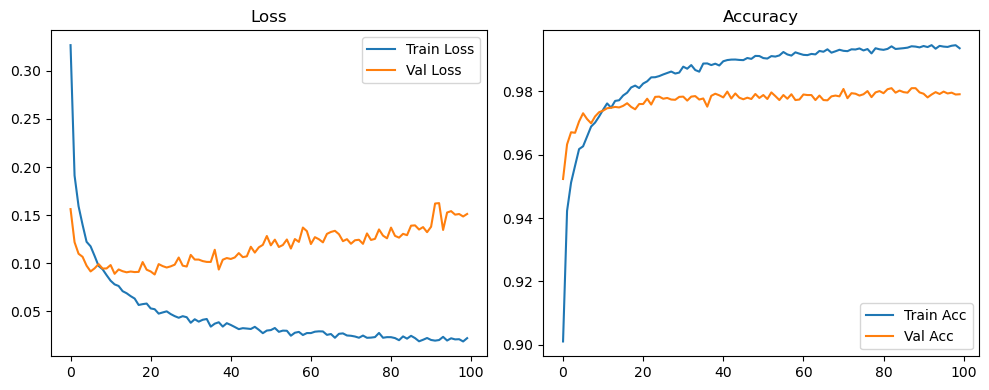

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2708, Acc: 0.9212 | Val Loss: 0.1664, Acc: 0.9548


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1357, Acc: 0.9602 | Val Loss: 0.1391, Acc: 0.9588


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1044, Acc: 0.9688 | Val Loss: 0.1196, Acc: 0.9663


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0751, Acc: 0.9766 | Val Loss: 0.1299, Acc: 0.9670


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0594, Acc: 0.9816 | Val Loss: 0.1360, Acc: 0.9677


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9842 | Val Loss: 0.1377, Acc: 0.9684


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9863 | Val Loss: 0.1291, Acc: 0.9716


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9882 | Val Loss: 0.1187, Acc: 0.9720


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9904 | Val Loss: 0.1230, Acc: 0.9727


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9899 | Val Loss: 0.1388, Acc: 0.9701


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9918 | Val Loss: 0.1417, Acc: 0.9713


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9923 | Val Loss: 0.1569, Acc: 0.9705


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9920 | Val Loss: 0.1386, Acc: 0.9726


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9932 | Val Loss: 0.1437, Acc: 0.9738


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9929 | Val Loss: 0.1290, Acc: 0.9747


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9948 | Val Loss: 0.1562, Acc: 0.9712


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9946 | Val Loss: 0.1405, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9947 | Val Loss: 0.1549, Acc: 0.9741


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9951 | Val Loss: 0.1438, Acc: 0.9742


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1603, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9955 | Val Loss: 0.1439, Acc: 0.9732


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9961 | Val Loss: 0.1410, Acc: 0.9745


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1676, Acc: 0.9722


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9961 | Val Loss: 0.1414, Acc: 0.9754


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9959 | Val Loss: 0.1508, Acc: 0.9745


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9966 | Val Loss: 0.1578, Acc: 0.9748


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9968 | Val Loss: 0.1532, Acc: 0.9746


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.1789, Acc: 0.9733


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1471, Acc: 0.9754


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9966 | Val Loss: 0.1593, Acc: 0.9739


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1549, Acc: 0.9748


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9971 | Val Loss: 0.1386, Acc: 0.9761


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1563, Acc: 0.9738


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1554, Acc: 0.9762


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1670, Acc: 0.9761


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9970 | Val Loss: 0.1938, Acc: 0.9727


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9971 | Val Loss: 0.1644, Acc: 0.9772


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9978 | Val Loss: 0.1624, Acc: 0.9731


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.1580, Acc: 0.9778


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.2103, Acc: 0.9754


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9974 | Val Loss: 0.1739, Acc: 0.9763


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9981 | Val Loss: 0.1669, Acc: 0.9758


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.1453, Acc: 0.9769


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9979 | Val Loss: 0.1577, Acc: 0.9768


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9975 | Val Loss: 0.1637, Acc: 0.9769


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1613, Acc: 0.9772


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9986 | Val Loss: 0.1675, Acc: 0.9770


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9979 | Val Loss: 0.1746, Acc: 0.9762


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9981 | Val Loss: 0.1683, Acc: 0.9762


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1643, Acc: 0.9772


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9978 | Val Loss: 0.1519, Acc: 0.9786


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.1660, Acc: 0.9770


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1778, Acc: 0.9787


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.1751, Acc: 0.9768


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9985 | Val Loss: 0.1639, Acc: 0.9758


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.1898, Acc: 0.9772


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1938, Acc: 0.9760


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9986 | Val Loss: 0.1870, Acc: 0.9758


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9982 | Val Loss: 0.1995, Acc: 0.9770


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1843, Acc: 0.9779


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9984 | Val Loss: 0.1865, Acc: 0.9758


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1678, Acc: 0.9770


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1760, Acc: 0.9773


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1663, Acc: 0.9779


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.1854, Acc: 0.9756


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9989 | Val Loss: 0.2026, Acc: 0.9776


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1783, Acc: 0.9764


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9985 | Val Loss: 0.2017, Acc: 0.9747


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9981 | Val Loss: 0.1504, Acc: 0.9778


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1785, Acc: 0.9778


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9985 | Val Loss: 0.1978, Acc: 0.9757


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1758, Acc: 0.9802


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.2035, Acc: 0.9765


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9984 | Val Loss: 0.2109, Acc: 0.9737


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9987 | Val Loss: 0.1930, Acc: 0.9778


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1880, Acc: 0.9776


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9990 | Val Loss: 0.1791, Acc: 0.9793


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.1878, Acc: 0.9782


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9989 | Val Loss: 0.1846, Acc: 0.9776


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9984 | Val Loss: 0.2106, Acc: 0.9746


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9987 | Val Loss: 0.1921, Acc: 0.9773


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.1843, Acc: 0.9780


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9984 | Val Loss: 0.1930, Acc: 0.9779


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9986 | Val Loss: 0.1989, Acc: 0.9772


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.1911, Acc: 0.9776


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9991 | Val Loss: 0.2006, Acc: 0.9787


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.2091, Acc: 0.9779


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.2073, Acc: 0.9771


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.2181, Acc: 0.9785


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.2647, Acc: 0.9766


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9982 | Val Loss: 0.2184, Acc: 0.9763


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9987 | Val Loss: 0.2188, Acc: 0.9751


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9988 | Val Loss: 0.1956, Acc: 0.9776


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1835, Acc: 0.9780


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.2075, Acc: 0.9773


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.2179, Acc: 0.9793


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.2027, Acc: 0.9777


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9987 | Val Loss: 0.1716, Acc: 0.9785


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1820, Acc: 0.9782


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9989 | Val Loss: 0.1985, Acc: 0.9792


Final Test Loss: 0.1678 Accuracy: 0.9797


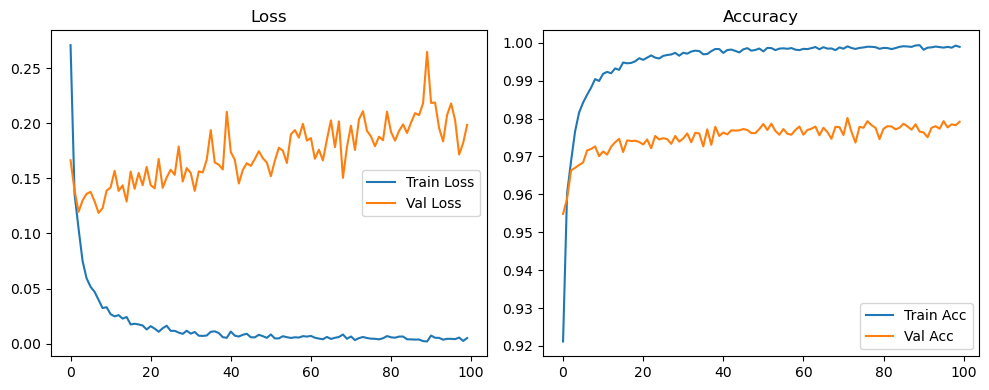

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2894, Acc: 0.9158 | Val Loss: 0.1942, Acc: 0.9469


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1648, Acc: 0.9519 | Val Loss: 0.1641, Acc: 0.9537


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1250, Acc: 0.9633 | Val Loss: 0.1333, Acc: 0.9633


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1024, Acc: 0.9700 | Val Loss: 0.1377, Acc: 0.9654


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0861, Acc: 0.9739 | Val Loss: 0.1284, Acc: 0.9696


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0755, Acc: 0.9781 | Val Loss: 0.1319, Acc: 0.9686


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0704, Acc: 0.9784 | Val Loss: 0.1272, Acc: 0.9717


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0587, Acc: 0.9824 | Val Loss: 0.1613, Acc: 0.9642


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9841 | Val Loss: 0.1160, Acc: 0.9738


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9848 | Val Loss: 0.1475, Acc: 0.9704


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9858 | Val Loss: 0.1597, Acc: 0.9711


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9879 | Val Loss: 0.1314, Acc: 0.9758


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0438, Acc: 0.9876 | Val Loss: 0.1596, Acc: 0.9719


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9879 | Val Loss: 0.1571, Acc: 0.9718


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9896 | Val Loss: 0.1507, Acc: 0.9739


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9893 | Val Loss: 0.1436, Acc: 0.9718


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9896 | Val Loss: 0.1613, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9916 | Val Loss: 0.1585, Acc: 0.9759


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9909 | Val Loss: 0.1894, Acc: 0.9729


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9916 | Val Loss: 0.1656, Acc: 0.9762


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9917 | Val Loss: 0.1877, Acc: 0.9733


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9925 | Val Loss: 0.1843, Acc: 0.9752


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9919 | Val Loss: 0.1726, Acc: 0.9753


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9939 | Val Loss: 0.2038, Acc: 0.9758


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9927 | Val Loss: 0.1928, Acc: 0.9747


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9934 | Val Loss: 0.1744, Acc: 0.9762


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9933 | Val Loss: 0.1906, Acc: 0.9752


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9934 | Val Loss: 0.1767, Acc: 0.9765


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9951 | Val Loss: 0.2131, Acc: 0.9761


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9941 | Val Loss: 0.1990, Acc: 0.9772


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9933 | Val Loss: 0.1962, Acc: 0.9759


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9944 | Val Loss: 0.1961, Acc: 0.9771


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9944 | Val Loss: 0.1846, Acc: 0.9772


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9947 | Val Loss: 0.1908, Acc: 0.9760


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9955 | Val Loss: 0.2199, Acc: 0.9774


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9948 | Val Loss: 0.2122, Acc: 0.9770


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9953 | Val Loss: 0.2379, Acc: 0.9759


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9956 | Val Loss: 0.2481, Acc: 0.9730


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9948 | Val Loss: 0.2236, Acc: 0.9763


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9945 | Val Loss: 0.2613, Acc: 0.9751


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9951 | Val Loss: 0.2185, Acc: 0.9774


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9954 | Val Loss: 0.2295, Acc: 0.9772


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9965 | Val Loss: 0.2398, Acc: 0.9788


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9965 | Val Loss: 0.2813, Acc: 0.9745


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9957 | Val Loss: 0.2469, Acc: 0.9765


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9949 | Val Loss: 0.2305, Acc: 0.9780


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9956 | Val Loss: 0.2484, Acc: 0.9770


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9955 | Val Loss: 0.2344, Acc: 0.9767


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9962 | Val Loss: 0.2678, Acc: 0.9778


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9954 | Val Loss: 0.2427, Acc: 0.9778


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9969 | Val Loss: 0.2656, Acc: 0.9780


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9960 | Val Loss: 0.2918, Acc: 0.9772


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9959 | Val Loss: 0.2915, Acc: 0.9782


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9955 | Val Loss: 0.2649, Acc: 0.9776


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9973 | Val Loss: 0.2690, Acc: 0.9785


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9963 | Val Loss: 0.3215, Acc: 0.9766


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9961 | Val Loss: 0.3019, Acc: 0.9785


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9964 | Val Loss: 0.3177, Acc: 0.9797


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9964 | Val Loss: 0.3082, Acc: 0.9777


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9961 | Val Loss: 0.2874, Acc: 0.9762


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9966 | Val Loss: 0.3167, Acc: 0.9765


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9970 | Val Loss: 0.2765, Acc: 0.9785


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9971 | Val Loss: 0.2684, Acc: 0.9789


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9966 | Val Loss: 0.3043, Acc: 0.9752


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9964 | Val Loss: 0.2708, Acc: 0.9783


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9974 | Val Loss: 0.2923, Acc: 0.9780


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9971 | Val Loss: 0.3102, Acc: 0.9788


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9965 | Val Loss: 0.2999, Acc: 0.9778


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9970 | Val Loss: 0.3010, Acc: 0.9764


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9970 | Val Loss: 0.2774, Acc: 0.9793


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9976 | Val Loss: 0.3595, Acc: 0.9778


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9969 | Val Loss: 0.3141, Acc: 0.9768


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9973 | Val Loss: 0.2607, Acc: 0.9778


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9973 | Val Loss: 0.2983, Acc: 0.9791


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9971 | Val Loss: 0.3265, Acc: 0.9784


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9977 | Val Loss: 0.3253, Acc: 0.9771


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9971 | Val Loss: 0.3412, Acc: 0.9766


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9972 | Val Loss: 0.3885, Acc: 0.9769


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9971 | Val Loss: 0.3447, Acc: 0.9776


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9972 | Val Loss: 0.3303, Acc: 0.9782


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9979 | Val Loss: 0.3083, Acc: 0.9788


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9981 | Val Loss: 0.3306, Acc: 0.9796


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9978 | Val Loss: 0.3428, Acc: 0.9787


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9974 | Val Loss: 0.3582, Acc: 0.9786


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9977 | Val Loss: 0.3365, Acc: 0.9784


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9969 | Val Loss: 0.2872, Acc: 0.9785


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9975 | Val Loss: 0.3248, Acc: 0.9768


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9971 | Val Loss: 0.3269, Acc: 0.9788


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9981 | Val Loss: 0.3196, Acc: 0.9781


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9982 | Val Loss: 0.3303, Acc: 0.9788


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9977 | Val Loss: 0.3412, Acc: 0.9779


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9980 | Val Loss: 0.3877, Acc: 0.9775


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9974 | Val Loss: 0.3708, Acc: 0.9782


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9974 | Val Loss: 0.3563, Acc: 0.9787


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9971 | Val Loss: 0.4000, Acc: 0.9768


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9972 | Val Loss: 0.3347, Acc: 0.9787


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9980 | Val Loss: 0.3435, Acc: 0.9806


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9974 | Val Loss: 0.4112, Acc: 0.9786


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9981 | Val Loss: 0.3468, Acc: 0.9802


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9981 | Val Loss: 0.4175, Acc: 0.9778


Final Test Loss: 0.3751 Accuracy: 0.9784


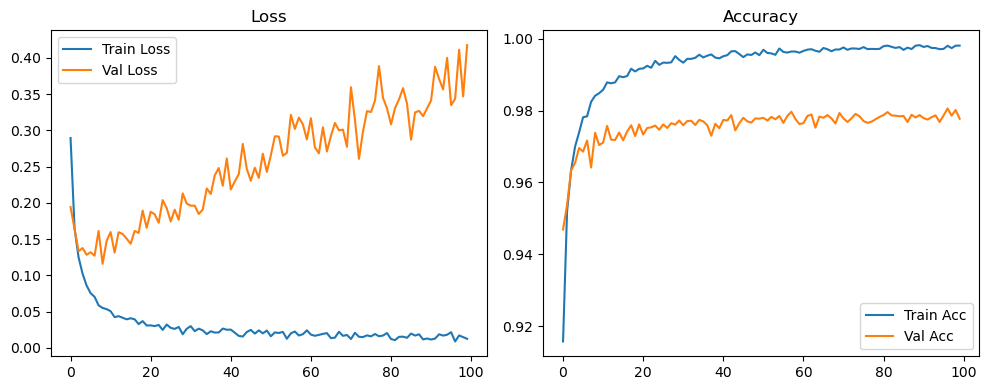

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3756, Acc: 0.8937 | Val Loss: 0.1829, Acc: 0.9494


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2368, Acc: 0.9333 | Val Loss: 0.1560, Acc: 0.9553


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1988, Acc: 0.9444 | Val Loss: 0.1420, Acc: 0.9613


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1758, Acc: 0.9505 | Val Loss: 0.1434, Acc: 0.9640


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1552, Acc: 0.9574 | Val Loss: 0.1195, Acc: 0.9702


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1466, Acc: 0.9606 | Val Loss: 0.1242, Acc: 0.9702


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1418, Acc: 0.9613 | Val Loss: 0.1302, Acc: 0.9702


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1290, Acc: 0.9647 | Val Loss: 0.1480, Acc: 0.9681


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1241, Acc: 0.9663 | Val Loss: 0.1119, Acc: 0.9752


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1139, Acc: 0.9697 | Val Loss: 0.1482, Acc: 0.9710


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1156, Acc: 0.9707 | Val Loss: 0.1362, Acc: 0.9727


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1028, Acc: 0.9734 | Val Loss: 0.1336, Acc: 0.9749


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1085, Acc: 0.9725 | Val Loss: 0.1359, Acc: 0.9702


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1016, Acc: 0.9736 | Val Loss: 0.1397, Acc: 0.9743


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0995, Acc: 0.9751 | Val Loss: 0.1378, Acc: 0.9753


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0987, Acc: 0.9757 | Val Loss: 0.1413, Acc: 0.9740


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0931, Acc: 0.9773 | Val Loss: 0.1584, Acc: 0.9744


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0850, Acc: 0.9798 | Val Loss: 0.1521, Acc: 0.9759


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0923, Acc: 0.9793 | Val Loss: 0.1542, Acc: 0.9748


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0865, Acc: 0.9795 | Val Loss: 0.1672, Acc: 0.9755


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0840, Acc: 0.9807 | Val Loss: 0.1434, Acc: 0.9770


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0817, Acc: 0.9812 | Val Loss: 0.1584, Acc: 0.9768


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0805, Acc: 0.9824 | Val Loss: 0.1725, Acc: 0.9760


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0858, Acc: 0.9814 | Val Loss: 0.1550, Acc: 0.9772


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0718, Acc: 0.9840 | Val Loss: 0.1880, Acc: 0.9772


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0725, Acc: 0.9845 | Val Loss: 0.1831, Acc: 0.9771


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0792, Acc: 0.9846 | Val Loss: 0.1909, Acc: 0.9766


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0777, Acc: 0.9843 | Val Loss: 0.2143, Acc: 0.9761


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0784, Acc: 0.9835 | Val Loss: 0.2106, Acc: 0.9759


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0730, Acc: 0.9854 | Val Loss: 0.1871, Acc: 0.9774


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9856 | Val Loss: 0.2101, Acc: 0.9783


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0726, Acc: 0.9862 | Val Loss: 0.2121, Acc: 0.9772


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9866 | Val Loss: 0.1872, Acc: 0.9792


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0741, Acc: 0.9864 | Val Loss: 0.2329, Acc: 0.9787


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0700, Acc: 0.9869 | Val Loss: 0.2584, Acc: 0.9763


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0778, Acc: 0.9863 | Val Loss: 0.1992, Acc: 0.9782


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0617, Acc: 0.9882 | Val Loss: 0.2285, Acc: 0.9778


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0749, Acc: 0.9866 | Val Loss: 0.2362, Acc: 0.9788


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0707, Acc: 0.9880 | Val Loss: 0.2155, Acc: 0.9778


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0628, Acc: 0.9891 | Val Loss: 0.2406, Acc: 0.9787


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9885 | Val Loss: 0.2348, Acc: 0.9805


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0721, Acc: 0.9880 | Val Loss: 0.2600, Acc: 0.9795


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9884 | Val Loss: 0.2371, Acc: 0.9763


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0608, Acc: 0.9893 | Val Loss: 0.2383, Acc: 0.9770


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9895 | Val Loss: 0.2413, Acc: 0.9781


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9888 | Val Loss: 0.2355, Acc: 0.9786


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0584, Acc: 0.9894 | Val Loss: 0.2511, Acc: 0.9779


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9886 | Val Loss: 0.2518, Acc: 0.9769


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0627, Acc: 0.9898 | Val Loss: 0.2632, Acc: 0.9786


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0593, Acc: 0.9898 | Val Loss: 0.2680, Acc: 0.9791


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0698, Acc: 0.9897 | Val Loss: 0.2723, Acc: 0.9808


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9912 | Val Loss: 0.2878, Acc: 0.9774


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0588, Acc: 0.9911 | Val Loss: 0.3025, Acc: 0.9766


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0614, Acc: 0.9902 | Val Loss: 0.2641, Acc: 0.9782


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9892 | Val Loss: 0.3066, Acc: 0.9779


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0618, Acc: 0.9904 | Val Loss: 0.2962, Acc: 0.9793


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0653, Acc: 0.9902 | Val Loss: 0.2949, Acc: 0.9768


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0586, Acc: 0.9912 | Val Loss: 0.2761, Acc: 0.9784


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9913 | Val Loss: 0.2931, Acc: 0.9780


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0494, Acc: 0.9924 | Val Loss: 0.3021, Acc: 0.9782


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9919 | Val Loss: 0.2915, Acc: 0.9789


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0597, Acc: 0.9912 | Val Loss: 0.2900, Acc: 0.9797


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0606, Acc: 0.9908 | Val Loss: 0.3119, Acc: 0.9773


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0651, Acc: 0.9909 | Val Loss: 0.3334, Acc: 0.9769


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0627, Acc: 0.9911 | Val Loss: 0.3510, Acc: 0.9771


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9920 | Val Loss: 0.3487, Acc: 0.9787


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0584, Acc: 0.9927 | Val Loss: 0.3285, Acc: 0.9795


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0624, Acc: 0.9922 | Val Loss: 0.3412, Acc: 0.9784


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9919 | Val Loss: 0.3301, Acc: 0.9778


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0544, Acc: 0.9921 | Val Loss: 0.3279, Acc: 0.9778


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0611, Acc: 0.9922 | Val Loss: 0.3509, Acc: 0.9784


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9928 | Val Loss: 0.3494, Acc: 0.9779


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9930 | Val Loss: 0.3503, Acc: 0.9778


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9914 | Val Loss: 0.3448, Acc: 0.9790


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0635, Acc: 0.9922 | Val Loss: 0.3759, Acc: 0.9772


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9932 | Val Loss: 0.3756, Acc: 0.9794


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9930 | Val Loss: 0.3131, Acc: 0.9783


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0508, Acc: 0.9935 | Val Loss: 0.3787, Acc: 0.9798


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9923 | Val Loss: 0.3633, Acc: 0.9789


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9925 | Val Loss: 0.3699, Acc: 0.9799


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9922 | Val Loss: 0.3715, Acc: 0.9797


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9928 | Val Loss: 0.3380, Acc: 0.9808


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9935 | Val Loss: 0.3679, Acc: 0.9800


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9923 | Val Loss: 0.3688, Acc: 0.9808


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9932 | Val Loss: 0.3772, Acc: 0.9810


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0549, Acc: 0.9935 | Val Loss: 0.3804, Acc: 0.9791


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9932 | Val Loss: 0.3536, Acc: 0.9812


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9943 | Val Loss: 0.3823, Acc: 0.9810


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0630, Acc: 0.9932 | Val Loss: 0.3645, Acc: 0.9798


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9936 | Val Loss: 0.3914, Acc: 0.9792


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0547, Acc: 0.9938 | Val Loss: 0.3543, Acc: 0.9796


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0483, Acc: 0.9944 | Val Loss: 0.3998, Acc: 0.9809


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0534, Acc: 0.9938 | Val Loss: 0.4232, Acc: 0.9801


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9940 | Val Loss: 0.4173, Acc: 0.9803


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9944 | Val Loss: 0.4114, Acc: 0.9805


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9938 | Val Loss: 0.3975, Acc: 0.9807


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9939 | Val Loss: 0.3913, Acc: 0.9802


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9934 | Val Loss: 0.4360, Acc: 0.9785


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9935 | Val Loss: 0.4325, Acc: 0.9804


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9940 | Val Loss: 0.4139, Acc: 0.9811


Final Test Loss: 0.3383 Accuracy: 0.9815


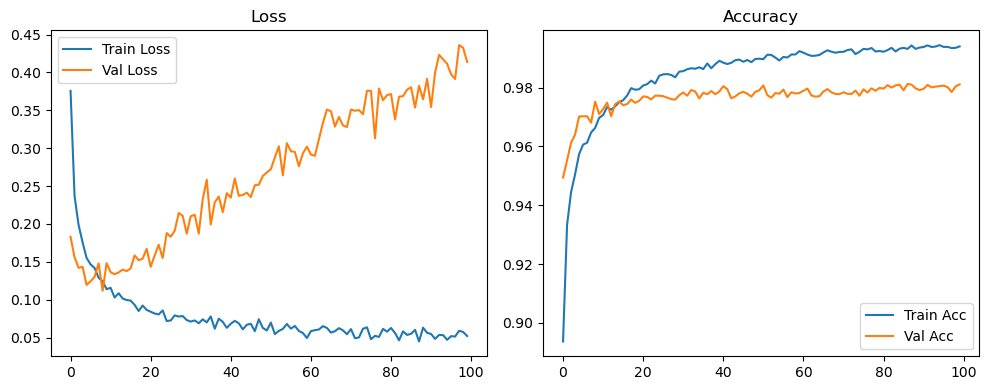

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2708, Acc: 0.9212 | Val Loss: 0.1664, Acc: 0.9548


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1357, Acc: 0.9602 | Val Loss: 0.1391, Acc: 0.9588


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1044, Acc: 0.9688 | Val Loss: 0.1196, Acc: 0.9663


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0751, Acc: 0.9766 | Val Loss: 0.1299, Acc: 0.9670


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0594, Acc: 0.9816 | Val Loss: 0.1360, Acc: 0.9677


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9842 | Val Loss: 0.1377, Acc: 0.9684


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9863 | Val Loss: 0.1291, Acc: 0.9716


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9882 | Val Loss: 0.1187, Acc: 0.9720


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9904 | Val Loss: 0.1230, Acc: 0.9727


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9899 | Val Loss: 0.1388, Acc: 0.9701


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9918 | Val Loss: 0.1417, Acc: 0.9713


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9923 | Val Loss: 0.1569, Acc: 0.9705


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9920 | Val Loss: 0.1386, Acc: 0.9726


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9932 | Val Loss: 0.1437, Acc: 0.9738


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9929 | Val Loss: 0.1290, Acc: 0.9747


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9948 | Val Loss: 0.1562, Acc: 0.9712


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9946 | Val Loss: 0.1405, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9947 | Val Loss: 0.1549, Acc: 0.9741


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9951 | Val Loss: 0.1438, Acc: 0.9742


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1603, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9955 | Val Loss: 0.1439, Acc: 0.9732


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9961 | Val Loss: 0.1410, Acc: 0.9745


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1676, Acc: 0.9722


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9961 | Val Loss: 0.1414, Acc: 0.9754


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9959 | Val Loss: 0.1508, Acc: 0.9745


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9966 | Val Loss: 0.1578, Acc: 0.9748


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9968 | Val Loss: 0.1532, Acc: 0.9746


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.1789, Acc: 0.9733


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1471, Acc: 0.9754


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9966 | Val Loss: 0.1593, Acc: 0.9739


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1549, Acc: 0.9748


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9971 | Val Loss: 0.1386, Acc: 0.9761


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1563, Acc: 0.9738


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1554, Acc: 0.9762


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1670, Acc: 0.9761


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9970 | Val Loss: 0.1938, Acc: 0.9727


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9971 | Val Loss: 0.1644, Acc: 0.9772


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9978 | Val Loss: 0.1624, Acc: 0.9731


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.1580, Acc: 0.9778


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.2103, Acc: 0.9754


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9974 | Val Loss: 0.1739, Acc: 0.9763


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9981 | Val Loss: 0.1669, Acc: 0.9758


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.1453, Acc: 0.9769


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9979 | Val Loss: 0.1577, Acc: 0.9768


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9975 | Val Loss: 0.1637, Acc: 0.9769


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1613, Acc: 0.9772


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9986 | Val Loss: 0.1675, Acc: 0.9770


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9979 | Val Loss: 0.1746, Acc: 0.9762


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9981 | Val Loss: 0.1683, Acc: 0.9762


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1643, Acc: 0.9772


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1586, Acc: 0.9784


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1490, Acc: 0.9794


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1543, Acc: 0.9794


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1576, Acc: 0.9798


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1790, Acc: 0.9781


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1765, Acc: 0.9787


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1882, Acc: 0.9788


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1811, Acc: 0.9792


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1896, Acc: 0.9792


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.1758, Acc: 0.9801


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1876, Acc: 0.9792


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1903, Acc: 0.9782


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1836, Acc: 0.9779


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1798, Acc: 0.9805


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.2008, Acc: 0.9799


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.2011, Acc: 0.9771


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.2188, Acc: 0.9782


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.2041, Acc: 0.9796


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.2031, Acc: 0.9794


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.2121, Acc: 0.9795


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.2108, Acc: 0.9789


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.2125, Acc: 0.9780


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9996 | Val Loss: 0.2237, Acc: 0.9785


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.2143, Acc: 0.9791


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.2337, Acc: 0.9776


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.2443, Acc: 0.9779


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.2426, Acc: 0.9788


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9993 | Val Loss: 0.2410, Acc: 0.9773


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9995 | Val Loss: 0.2196, Acc: 0.9785


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2192, Acc: 0.9786


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2058, Acc: 0.9795


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1986, Acc: 0.9803


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2005, Acc: 0.9799


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2039, Acc: 0.9798


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1983, Acc: 0.9805


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2098, Acc: 0.9804


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2204, Acc: 0.9793


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2013, Acc: 0.9813


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2043, Acc: 0.9814


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2120, Acc: 0.9803


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2135, Acc: 0.9816


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2199, Acc: 0.9816


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2244, Acc: 0.9798


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.2191, Acc: 0.9798


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2266, Acc: 0.9805


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2207, Acc: 0.9810


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2165, Acc: 0.9798


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2173, Acc: 0.9808


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2207, Acc: 0.9806


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2150, Acc: 0.9816


Final Test Loss: 0.1988 Accuracy: 0.9818


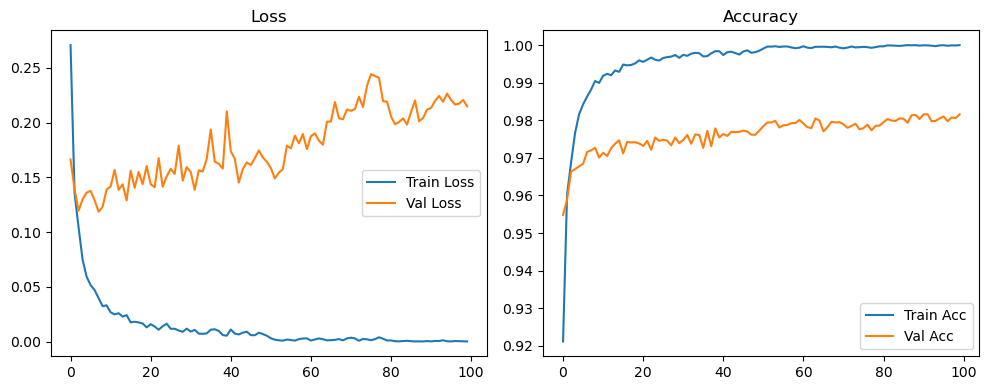

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2894, Acc: 0.9158 | Val Loss: 0.1942, Acc: 0.9469


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1648, Acc: 0.9519 | Val Loss: 0.1641, Acc: 0.9537


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1250, Acc: 0.9633 | Val Loss: 0.1333, Acc: 0.9633


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1024, Acc: 0.9700 | Val Loss: 0.1377, Acc: 0.9654


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0861, Acc: 0.9739 | Val Loss: 0.1284, Acc: 0.9696


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0755, Acc: 0.9781 | Val Loss: 0.1319, Acc: 0.9686


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0704, Acc: 0.9784 | Val Loss: 0.1272, Acc: 0.9717


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0587, Acc: 0.9824 | Val Loss: 0.1613, Acc: 0.9642


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9841 | Val Loss: 0.1160, Acc: 0.9738


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9848 | Val Loss: 0.1475, Acc: 0.9704


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9858 | Val Loss: 0.1597, Acc: 0.9711


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9879 | Val Loss: 0.1314, Acc: 0.9758


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0438, Acc: 0.9876 | Val Loss: 0.1596, Acc: 0.9719


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9879 | Val Loss: 0.1571, Acc: 0.9718


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9896 | Val Loss: 0.1507, Acc: 0.9739


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9893 | Val Loss: 0.1436, Acc: 0.9718


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9896 | Val Loss: 0.1613, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9916 | Val Loss: 0.1585, Acc: 0.9759


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9909 | Val Loss: 0.1894, Acc: 0.9729


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9916 | Val Loss: 0.1656, Acc: 0.9762


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9917 | Val Loss: 0.1877, Acc: 0.9733


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9925 | Val Loss: 0.1843, Acc: 0.9752


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9919 | Val Loss: 0.1726, Acc: 0.9753


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9939 | Val Loss: 0.2038, Acc: 0.9758


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9927 | Val Loss: 0.1928, Acc: 0.9747


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9934 | Val Loss: 0.1744, Acc: 0.9762


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9933 | Val Loss: 0.1906, Acc: 0.9752


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9934 | Val Loss: 0.1767, Acc: 0.9765


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9951 | Val Loss: 0.2131, Acc: 0.9761


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9941 | Val Loss: 0.1990, Acc: 0.9772


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9933 | Val Loss: 0.1962, Acc: 0.9759


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9944 | Val Loss: 0.1961, Acc: 0.9771


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9944 | Val Loss: 0.1846, Acc: 0.9772


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9947 | Val Loss: 0.1908, Acc: 0.9760


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9955 | Val Loss: 0.2199, Acc: 0.9774


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9948 | Val Loss: 0.2122, Acc: 0.9770


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9953 | Val Loss: 0.2379, Acc: 0.9759


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9956 | Val Loss: 0.2481, Acc: 0.9730


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9948 | Val Loss: 0.2236, Acc: 0.9763


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9945 | Val Loss: 0.2613, Acc: 0.9751


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9951 | Val Loss: 0.2185, Acc: 0.9774


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9954 | Val Loss: 0.2295, Acc: 0.9772


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9965 | Val Loss: 0.2398, Acc: 0.9788


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9965 | Val Loss: 0.2813, Acc: 0.9745


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9957 | Val Loss: 0.2469, Acc: 0.9765


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9949 | Val Loss: 0.2305, Acc: 0.9780


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9956 | Val Loss: 0.2484, Acc: 0.9770


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9955 | Val Loss: 0.2344, Acc: 0.9767


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9962 | Val Loss: 0.2678, Acc: 0.9778


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9954 | Val Loss: 0.2427, Acc: 0.9778


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9975 | Val Loss: 0.2104, Acc: 0.9813


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9980 | Val Loss: 0.2304, Acc: 0.9806


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9987 | Val Loss: 0.2313, Acc: 0.9828


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.2578, Acc: 0.9804


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.2492, Acc: 0.9815


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9984 | Val Loss: 0.2495, Acc: 0.9813


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9986 | Val Loss: 0.2618, Acc: 0.9812


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9986 | Val Loss: 0.2555, Acc: 0.9802


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9988 | Val Loss: 0.2784, Acc: 0.9797


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9985 | Val Loss: 0.2854, Acc: 0.9789


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9985 | Val Loss: 0.2629, Acc: 0.9811


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9989 | Val Loss: 0.2812, Acc: 0.9802


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9990 | Val Loss: 0.2589, Acc: 0.9810


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9991 | Val Loss: 0.2888, Acc: 0.9799


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9984 | Val Loss: 0.3040, Acc: 0.9797


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9979 | Val Loss: 0.2970, Acc: 0.9796


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9989 | Val Loss: 0.2980, Acc: 0.9790


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9988 | Val Loss: 0.3149, Acc: 0.9798


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9988 | Val Loss: 0.2705, Acc: 0.9796


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9988 | Val Loss: 0.2889, Acc: 0.9804


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9986 | Val Loss: 0.2890, Acc: 0.9792


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9989 | Val Loss: 0.3289, Acc: 0.9792


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9990 | Val Loss: 0.3072, Acc: 0.9802


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9990 | Val Loss: 0.3223, Acc: 0.9795


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9988 | Val Loss: 0.3385, Acc: 0.9792


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9984 | Val Loss: 0.3383, Acc: 0.9766


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9987 | Val Loss: 0.3720, Acc: 0.9792


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9987 | Val Loss: 0.3288, Acc: 0.9790


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9988 | Val Loss: 0.3142, Acc: 0.9803


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9988 | Val Loss: 0.3022, Acc: 0.9786


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9992 | Val Loss: 0.2779, Acc: 0.9802


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.2715, Acc: 0.9812


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.2807, Acc: 0.9809


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.2758, Acc: 0.9815


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.2760, Acc: 0.9808


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.2942, Acc: 0.9802


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9997 | Val Loss: 0.2832, Acc: 0.9814


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9995 | Val Loss: 0.2756, Acc: 0.9807


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.2761, Acc: 0.9811


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2753, Acc: 0.9812


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2679, Acc: 0.9817


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.2865, Acc: 0.9802


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.2820, Acc: 0.9818


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.2850, Acc: 0.9818


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.2892, Acc: 0.9822


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.3078, Acc: 0.9818


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.2926, Acc: 0.9824


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.3233, Acc: 0.9806


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.3269, Acc: 0.9813


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.3502, Acc: 0.9798


Final Test Loss: 0.2989 Accuracy: 0.9812


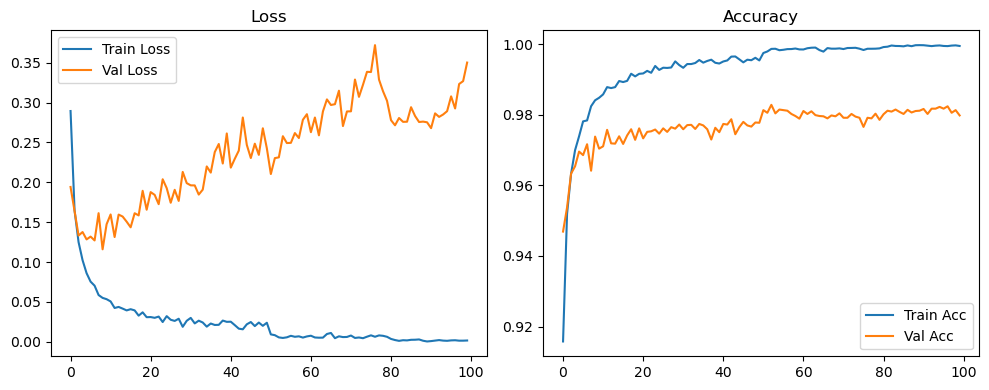

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3756, Acc: 0.8937 | Val Loss: 0.1829, Acc: 0.9494


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2368, Acc: 0.9333 | Val Loss: 0.1560, Acc: 0.9553


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1988, Acc: 0.9444 | Val Loss: 0.1420, Acc: 0.9613


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1758, Acc: 0.9505 | Val Loss: 0.1434, Acc: 0.9640


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1552, Acc: 0.9574 | Val Loss: 0.1195, Acc: 0.9702


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1466, Acc: 0.9606 | Val Loss: 0.1242, Acc: 0.9702


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1418, Acc: 0.9613 | Val Loss: 0.1302, Acc: 0.9702


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1290, Acc: 0.9647 | Val Loss: 0.1480, Acc: 0.9681


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1241, Acc: 0.9663 | Val Loss: 0.1119, Acc: 0.9752


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1139, Acc: 0.9697 | Val Loss: 0.1482, Acc: 0.9710


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1156, Acc: 0.9707 | Val Loss: 0.1362, Acc: 0.9727


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1028, Acc: 0.9734 | Val Loss: 0.1336, Acc: 0.9749


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1085, Acc: 0.9725 | Val Loss: 0.1359, Acc: 0.9702


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1016, Acc: 0.9736 | Val Loss: 0.1397, Acc: 0.9743


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0995, Acc: 0.9751 | Val Loss: 0.1378, Acc: 0.9753


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0987, Acc: 0.9757 | Val Loss: 0.1413, Acc: 0.9740


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0931, Acc: 0.9773 | Val Loss: 0.1584, Acc: 0.9744


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0850, Acc: 0.9798 | Val Loss: 0.1521, Acc: 0.9759


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0923, Acc: 0.9793 | Val Loss: 0.1542, Acc: 0.9748


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0865, Acc: 0.9795 | Val Loss: 0.1672, Acc: 0.9755


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0840, Acc: 0.9807 | Val Loss: 0.1434, Acc: 0.9770


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0817, Acc: 0.9812 | Val Loss: 0.1584, Acc: 0.9768


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0805, Acc: 0.9824 | Val Loss: 0.1725, Acc: 0.9760


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0858, Acc: 0.9814 | Val Loss: 0.1550, Acc: 0.9772


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0718, Acc: 0.9840 | Val Loss: 0.1880, Acc: 0.9772


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0725, Acc: 0.9845 | Val Loss: 0.1831, Acc: 0.9771


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0792, Acc: 0.9846 | Val Loss: 0.1909, Acc: 0.9766


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0777, Acc: 0.9843 | Val Loss: 0.2143, Acc: 0.9761


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0784, Acc: 0.9835 | Val Loss: 0.2106, Acc: 0.9759


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0730, Acc: 0.9854 | Val Loss: 0.1871, Acc: 0.9774


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9856 | Val Loss: 0.2101, Acc: 0.9783


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0726, Acc: 0.9862 | Val Loss: 0.2121, Acc: 0.9772


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9866 | Val Loss: 0.1872, Acc: 0.9792


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0741, Acc: 0.9864 | Val Loss: 0.2329, Acc: 0.9787


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0700, Acc: 0.9869 | Val Loss: 0.2584, Acc: 0.9763


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0778, Acc: 0.9863 | Val Loss: 0.1992, Acc: 0.9782


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0617, Acc: 0.9882 | Val Loss: 0.2285, Acc: 0.9778


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0749, Acc: 0.9866 | Val Loss: 0.2362, Acc: 0.9788


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0707, Acc: 0.9880 | Val Loss: 0.2155, Acc: 0.9778


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0628, Acc: 0.9891 | Val Loss: 0.2406, Acc: 0.9787


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9885 | Val Loss: 0.2348, Acc: 0.9805


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0721, Acc: 0.9880 | Val Loss: 0.2600, Acc: 0.9795


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9884 | Val Loss: 0.2371, Acc: 0.9763


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0608, Acc: 0.9893 | Val Loss: 0.2383, Acc: 0.9770


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9895 | Val Loss: 0.2413, Acc: 0.9781


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9888 | Val Loss: 0.2355, Acc: 0.9786


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0584, Acc: 0.9894 | Val Loss: 0.2511, Acc: 0.9779


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9886 | Val Loss: 0.2518, Acc: 0.9769


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0627, Acc: 0.9898 | Val Loss: 0.2632, Acc: 0.9786


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0593, Acc: 0.9898 | Val Loss: 0.2680, Acc: 0.9791


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9919 | Val Loss: 0.2395, Acc: 0.9802


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9934 | Val Loss: 0.2440, Acc: 0.9799


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9943 | Val Loss: 0.2481, Acc: 0.9798


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9950 | Val Loss: 0.2490, Acc: 0.9806


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9948 | Val Loss: 0.2488, Acc: 0.9800


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9951 | Val Loss: 0.2652, Acc: 0.9812


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9949 | Val Loss: 0.2540, Acc: 0.9801


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9946 | Val Loss: 0.2466, Acc: 0.9802


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9952 | Val Loss: 0.2763, Acc: 0.9780


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9959 | Val Loss: 0.2771, Acc: 0.9812


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9954 | Val Loss: 0.2637, Acc: 0.9802


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9953 | Val Loss: 0.2469, Acc: 0.9809


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9948 | Val Loss: 0.2632, Acc: 0.9798


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9952 | Val Loss: 0.2915, Acc: 0.9777


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9957 | Val Loss: 0.2839, Acc: 0.9799


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9957 | Val Loss: 0.3015, Acc: 0.9808


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9957 | Val Loss: 0.3142, Acc: 0.9796


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9962 | Val Loss: 0.3090, Acc: 0.9803


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9954 | Val Loss: 0.3087, Acc: 0.9801


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9958 | Val Loss: 0.3109, Acc: 0.9807


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9956 | Val Loss: 0.3141, Acc: 0.9800


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9961 | Val Loss: 0.3223, Acc: 0.9789


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9958 | Val Loss: 0.3080, Acc: 0.9796


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9960 | Val Loss: 0.2973, Acc: 0.9811


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9958 | Val Loss: 0.3156, Acc: 0.9805


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9959 | Val Loss: 0.3329, Acc: 0.9798


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9960 | Val Loss: 0.3042, Acc: 0.9804


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9961 | Val Loss: 0.3133, Acc: 0.9791


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9966 | Val Loss: 0.3027, Acc: 0.9809


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9963 | Val Loss: 0.3248, Acc: 0.9794


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9968 | Val Loss: 0.2951, Acc: 0.9807


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9974 | Val Loss: 0.2907, Acc: 0.9805


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9976 | Val Loss: 0.2878, Acc: 0.9809


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9973 | Val Loss: 0.2684, Acc: 0.9808


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9978 | Val Loss: 0.2841, Acc: 0.9804


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9976 | Val Loss: 0.2848, Acc: 0.9810


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9978 | Val Loss: 0.2968, Acc: 0.9813


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9981 | Val Loss: 0.2882, Acc: 0.9811


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9974 | Val Loss: 0.2862, Acc: 0.9808


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9979 | Val Loss: 0.2896, Acc: 0.9803


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9979 | Val Loss: 0.2779, Acc: 0.9808


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9979 | Val Loss: 0.2959, Acc: 0.9811


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9981 | Val Loss: 0.2858, Acc: 0.9813


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9983 | Val Loss: 0.2760, Acc: 0.9821


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9983 | Val Loss: 0.2926, Acc: 0.9814


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9981 | Val Loss: 0.2874, Acc: 0.9817


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9977 | Val Loss: 0.2815, Acc: 0.9811


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9983 | Val Loss: 0.2958, Acc: 0.9813


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9981 | Val Loss: 0.2841, Acc: 0.9822


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9985 | Val Loss: 0.2905, Acc: 0.9816


Final Test Loss: 0.2618 Accuracy: 0.9840


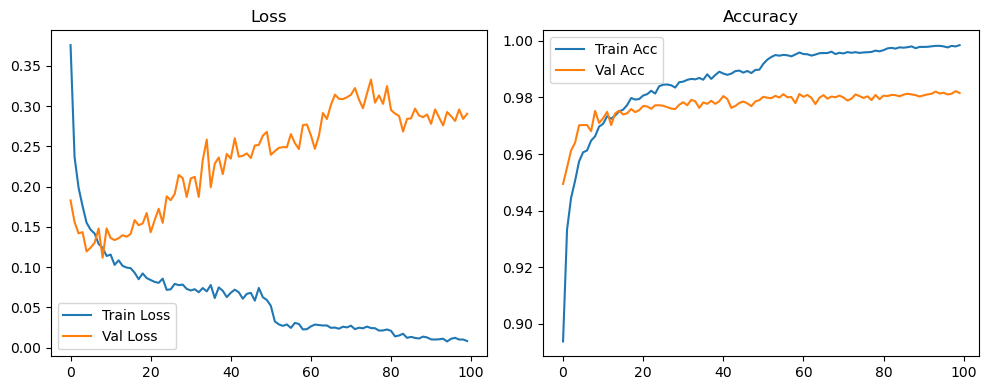

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2708, Acc: 0.9212 | Val Loss: 0.1664, Acc: 0.9548


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1357, Acc: 0.9602 | Val Loss: 0.1391, Acc: 0.9588


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1044, Acc: 0.9688 | Val Loss: 0.1196, Acc: 0.9663


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0751, Acc: 0.9766 | Val Loss: 0.1299, Acc: 0.9670


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0594, Acc: 0.9816 | Val Loss: 0.1360, Acc: 0.9677


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9842 | Val Loss: 0.1377, Acc: 0.9684


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9863 | Val Loss: 0.1291, Acc: 0.9716


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9882 | Val Loss: 0.1187, Acc: 0.9720


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9904 | Val Loss: 0.1230, Acc: 0.9727


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9899 | Val Loss: 0.1388, Acc: 0.9701


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9918 | Val Loss: 0.1417, Acc: 0.9713


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9923 | Val Loss: 0.1569, Acc: 0.9705


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9920 | Val Loss: 0.1386, Acc: 0.9726


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9932 | Val Loss: 0.1437, Acc: 0.9738


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9929 | Val Loss: 0.1290, Acc: 0.9747


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9948 | Val Loss: 0.1562, Acc: 0.9712


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9946 | Val Loss: 0.1405, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9947 | Val Loss: 0.1549, Acc: 0.9741


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9951 | Val Loss: 0.1438, Acc: 0.9742


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1603, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9955 | Val Loss: 0.1439, Acc: 0.9732


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9961 | Val Loss: 0.1410, Acc: 0.9745


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1676, Acc: 0.9722


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9961 | Val Loss: 0.1414, Acc: 0.9754


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9959 | Val Loss: 0.1508, Acc: 0.9745


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9966 | Val Loss: 0.1578, Acc: 0.9748


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9968 | Val Loss: 0.1532, Acc: 0.9746


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.1789, Acc: 0.9733


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1471, Acc: 0.9754


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9966 | Val Loss: 0.1593, Acc: 0.9739


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1549, Acc: 0.9748


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9971 | Val Loss: 0.1386, Acc: 0.9761


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1563, Acc: 0.9738


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1554, Acc: 0.9762


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1670, Acc: 0.9761


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9970 | Val Loss: 0.1938, Acc: 0.9727


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9971 | Val Loss: 0.1644, Acc: 0.9772


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9978 | Val Loss: 0.1624, Acc: 0.9731


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.1580, Acc: 0.9778


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.2103, Acc: 0.9754


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9974 | Val Loss: 0.1739, Acc: 0.9763


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9981 | Val Loss: 0.1669, Acc: 0.9758


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.1453, Acc: 0.9769


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9979 | Val Loss: 0.1577, Acc: 0.9768


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9975 | Val Loss: 0.1637, Acc: 0.9769


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1613, Acc: 0.9772


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9986 | Val Loss: 0.1675, Acc: 0.9770


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9979 | Val Loss: 0.1746, Acc: 0.9762


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9981 | Val Loss: 0.1683, Acc: 0.9762


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1643, Acc: 0.9772


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1586, Acc: 0.9784


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1490, Acc: 0.9794


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1543, Acc: 0.9794


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1576, Acc: 0.9798


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1790, Acc: 0.9781


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1765, Acc: 0.9787


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1882, Acc: 0.9788


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1811, Acc: 0.9792


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1896, Acc: 0.9792


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.1758, Acc: 0.9801


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1876, Acc: 0.9792


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1903, Acc: 0.9782


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1836, Acc: 0.9779


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1798, Acc: 0.9805


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.2008, Acc: 0.9799


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.2011, Acc: 0.9771


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.2188, Acc: 0.9782


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.2041, Acc: 0.9796


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.2031, Acc: 0.9794


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.2121, Acc: 0.9795


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.2108, Acc: 0.9789


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.2125, Acc: 0.9780


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9996 | Val Loss: 0.2237, Acc: 0.9785


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.2143, Acc: 0.9791


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.2337, Acc: 0.9776


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.2443, Acc: 0.9779


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.2426, Acc: 0.9788


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9993 | Val Loss: 0.2410, Acc: 0.9773


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9995 | Val Loss: 0.2196, Acc: 0.9785


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2192, Acc: 0.9786


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.2033, Acc: 0.9799


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2035, Acc: 0.9794


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1998, Acc: 0.9802


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2002, Acc: 0.9795


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1914, Acc: 0.9805


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2028, Acc: 0.9802


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2020, Acc: 0.9803


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.2048, Acc: 0.9795


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.2018, Acc: 0.9801


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.2041, Acc: 0.9799


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1993, Acc: 0.9807


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2018, Acc: 0.9812


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1977, Acc: 0.9816


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2028, Acc: 0.9805


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2128, Acc: 0.9802


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2087, Acc: 0.9810


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2126, Acc: 0.9799


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.2118, Acc: 0.9807


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.2060, Acc: 0.9815


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2069, Acc: 0.9802


Final Test Loss: 0.1908 Accuracy: 0.9823


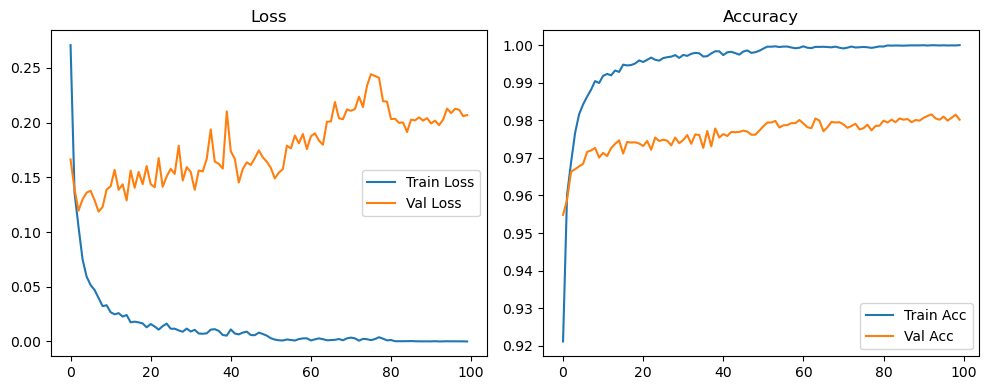

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2894, Acc: 0.9158 | Val Loss: 0.1942, Acc: 0.9469


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1648, Acc: 0.9519 | Val Loss: 0.1641, Acc: 0.9537


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1250, Acc: 0.9633 | Val Loss: 0.1333, Acc: 0.9633


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1024, Acc: 0.9700 | Val Loss: 0.1377, Acc: 0.9654


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0861, Acc: 0.9739 | Val Loss: 0.1284, Acc: 0.9696


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0755, Acc: 0.9781 | Val Loss: 0.1319, Acc: 0.9686


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0704, Acc: 0.9784 | Val Loss: 0.1272, Acc: 0.9717


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0587, Acc: 0.9824 | Val Loss: 0.1613, Acc: 0.9642


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9841 | Val Loss: 0.1160, Acc: 0.9738


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9848 | Val Loss: 0.1475, Acc: 0.9704


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9858 | Val Loss: 0.1597, Acc: 0.9711


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9879 | Val Loss: 0.1314, Acc: 0.9758


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0438, Acc: 0.9876 | Val Loss: 0.1596, Acc: 0.9719


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9879 | Val Loss: 0.1571, Acc: 0.9718


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9896 | Val Loss: 0.1507, Acc: 0.9739


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9893 | Val Loss: 0.1436, Acc: 0.9718


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9896 | Val Loss: 0.1613, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9916 | Val Loss: 0.1585, Acc: 0.9759


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9909 | Val Loss: 0.1894, Acc: 0.9729


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9916 | Val Loss: 0.1656, Acc: 0.9762


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9917 | Val Loss: 0.1877, Acc: 0.9733


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9925 | Val Loss: 0.1843, Acc: 0.9752


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9919 | Val Loss: 0.1726, Acc: 0.9753


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9939 | Val Loss: 0.2038, Acc: 0.9758


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9927 | Val Loss: 0.1928, Acc: 0.9747


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9934 | Val Loss: 0.1744, Acc: 0.9762


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9933 | Val Loss: 0.1906, Acc: 0.9752


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9934 | Val Loss: 0.1767, Acc: 0.9765


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9951 | Val Loss: 0.2131, Acc: 0.9761


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9941 | Val Loss: 0.1990, Acc: 0.9772


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9933 | Val Loss: 0.1962, Acc: 0.9759


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9944 | Val Loss: 0.1961, Acc: 0.9771


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9944 | Val Loss: 0.1846, Acc: 0.9772


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9947 | Val Loss: 0.1908, Acc: 0.9760


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9955 | Val Loss: 0.2199, Acc: 0.9774


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9948 | Val Loss: 0.2122, Acc: 0.9770


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9953 | Val Loss: 0.2379, Acc: 0.9759


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9956 | Val Loss: 0.2481, Acc: 0.9730


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9948 | Val Loss: 0.2236, Acc: 0.9763


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9945 | Val Loss: 0.2613, Acc: 0.9751


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9951 | Val Loss: 0.2185, Acc: 0.9774


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9954 | Val Loss: 0.2295, Acc: 0.9772


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9965 | Val Loss: 0.2398, Acc: 0.9788


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9965 | Val Loss: 0.2813, Acc: 0.9745


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9957 | Val Loss: 0.2469, Acc: 0.9765


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9949 | Val Loss: 0.2305, Acc: 0.9780


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9956 | Val Loss: 0.2484, Acc: 0.9770


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9955 | Val Loss: 0.2344, Acc: 0.9767


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9962 | Val Loss: 0.2678, Acc: 0.9778


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9954 | Val Loss: 0.2427, Acc: 0.9778


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9975 | Val Loss: 0.2104, Acc: 0.9813


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9980 | Val Loss: 0.2304, Acc: 0.9806


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9987 | Val Loss: 0.2313, Acc: 0.9828


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.2578, Acc: 0.9804


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.2492, Acc: 0.9815


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9984 | Val Loss: 0.2495, Acc: 0.9813


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9986 | Val Loss: 0.2618, Acc: 0.9812


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9986 | Val Loss: 0.2555, Acc: 0.9802


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9988 | Val Loss: 0.2784, Acc: 0.9797


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9985 | Val Loss: 0.2854, Acc: 0.9789


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9985 | Val Loss: 0.2629, Acc: 0.9811


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9989 | Val Loss: 0.2812, Acc: 0.9802


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9990 | Val Loss: 0.2589, Acc: 0.9810


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9991 | Val Loss: 0.2888, Acc: 0.9799


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9984 | Val Loss: 0.3040, Acc: 0.9797


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9979 | Val Loss: 0.2970, Acc: 0.9796


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9989 | Val Loss: 0.2980, Acc: 0.9790


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9988 | Val Loss: 0.3149, Acc: 0.9798


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9988 | Val Loss: 0.2705, Acc: 0.9796


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9988 | Val Loss: 0.2889, Acc: 0.9804


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9986 | Val Loss: 0.2890, Acc: 0.9792


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9989 | Val Loss: 0.3289, Acc: 0.9792


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9990 | Val Loss: 0.3072, Acc: 0.9802


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9990 | Val Loss: 0.3223, Acc: 0.9795


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9988 | Val Loss: 0.3385, Acc: 0.9792


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9984 | Val Loss: 0.3383, Acc: 0.9766


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9987 | Val Loss: 0.3720, Acc: 0.9792


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9987 | Val Loss: 0.3288, Acc: 0.9790


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9988 | Val Loss: 0.3142, Acc: 0.9803


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9988 | Val Loss: 0.3022, Acc: 0.9786


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9992 | Val Loss: 0.2832, Acc: 0.9796


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.2748, Acc: 0.9810


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.2711, Acc: 0.9814


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.2726, Acc: 0.9808


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.2675, Acc: 0.9809


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.2788, Acc: 0.9812


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9998 | Val Loss: 0.2735, Acc: 0.9819


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.2724, Acc: 0.9817


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.2662, Acc: 0.9818


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.2727, Acc: 0.9806


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2664, Acc: 0.9819


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2732, Acc: 0.9827


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2684, Acc: 0.9822


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.2668, Acc: 0.9822


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.2682, Acc: 0.9818


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.2670, Acc: 0.9823


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.2571, Acc: 0.9818


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.2740, Acc: 0.9814


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.2633, Acc: 0.9824


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.2778, Acc: 0.9811


Final Test Loss: 0.2808 Accuracy: 0.9810


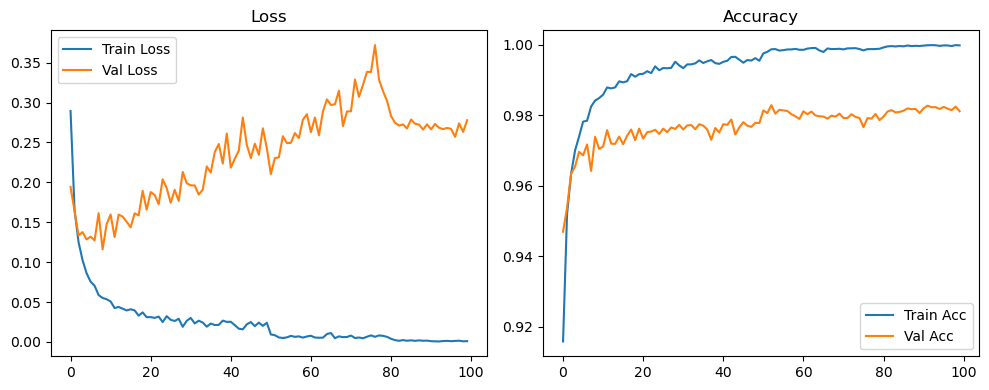

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3756, Acc: 0.8937 | Val Loss: 0.1829, Acc: 0.9494


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2368, Acc: 0.9333 | Val Loss: 0.1560, Acc: 0.9553


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1988, Acc: 0.9444 | Val Loss: 0.1420, Acc: 0.9613


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1758, Acc: 0.9505 | Val Loss: 0.1434, Acc: 0.9640


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1552, Acc: 0.9574 | Val Loss: 0.1195, Acc: 0.9702


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1466, Acc: 0.9606 | Val Loss: 0.1242, Acc: 0.9702


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1418, Acc: 0.9613 | Val Loss: 0.1302, Acc: 0.9702


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1290, Acc: 0.9647 | Val Loss: 0.1480, Acc: 0.9681


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1241, Acc: 0.9663 | Val Loss: 0.1119, Acc: 0.9752


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1139, Acc: 0.9697 | Val Loss: 0.1482, Acc: 0.9710


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1156, Acc: 0.9707 | Val Loss: 0.1362, Acc: 0.9727


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1028, Acc: 0.9734 | Val Loss: 0.1336, Acc: 0.9749


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1085, Acc: 0.9725 | Val Loss: 0.1359, Acc: 0.9702


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1016, Acc: 0.9736 | Val Loss: 0.1397, Acc: 0.9743


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0995, Acc: 0.9751 | Val Loss: 0.1378, Acc: 0.9753


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0987, Acc: 0.9757 | Val Loss: 0.1413, Acc: 0.9740


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0931, Acc: 0.9773 | Val Loss: 0.1584, Acc: 0.9744


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0850, Acc: 0.9798 | Val Loss: 0.1521, Acc: 0.9759


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0923, Acc: 0.9793 | Val Loss: 0.1542, Acc: 0.9748


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0865, Acc: 0.9795 | Val Loss: 0.1672, Acc: 0.9755


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0840, Acc: 0.9807 | Val Loss: 0.1434, Acc: 0.9770


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0817, Acc: 0.9812 | Val Loss: 0.1584, Acc: 0.9768


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0805, Acc: 0.9824 | Val Loss: 0.1725, Acc: 0.9760


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0858, Acc: 0.9814 | Val Loss: 0.1550, Acc: 0.9772


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0718, Acc: 0.9840 | Val Loss: 0.1880, Acc: 0.9772


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0725, Acc: 0.9845 | Val Loss: 0.1831, Acc: 0.9771


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0792, Acc: 0.9846 | Val Loss: 0.1909, Acc: 0.9766


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0777, Acc: 0.9843 | Val Loss: 0.2143, Acc: 0.9761


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0784, Acc: 0.9835 | Val Loss: 0.2106, Acc: 0.9759


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0730, Acc: 0.9854 | Val Loss: 0.1871, Acc: 0.9774


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9856 | Val Loss: 0.2101, Acc: 0.9783


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0726, Acc: 0.9862 | Val Loss: 0.2121, Acc: 0.9772


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9866 | Val Loss: 0.1872, Acc: 0.9792


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0741, Acc: 0.9864 | Val Loss: 0.2329, Acc: 0.9787


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0700, Acc: 0.9869 | Val Loss: 0.2584, Acc: 0.9763


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0778, Acc: 0.9863 | Val Loss: 0.1992, Acc: 0.9782


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0617, Acc: 0.9882 | Val Loss: 0.2285, Acc: 0.9778


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0749, Acc: 0.9866 | Val Loss: 0.2362, Acc: 0.9788


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0707, Acc: 0.9880 | Val Loss: 0.2155, Acc: 0.9778


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0628, Acc: 0.9891 | Val Loss: 0.2406, Acc: 0.9787


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9885 | Val Loss: 0.2348, Acc: 0.9805


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0721, Acc: 0.9880 | Val Loss: 0.2600, Acc: 0.9795


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9884 | Val Loss: 0.2371, Acc: 0.9763


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0608, Acc: 0.9893 | Val Loss: 0.2383, Acc: 0.9770


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9895 | Val Loss: 0.2413, Acc: 0.9781


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9888 | Val Loss: 0.2355, Acc: 0.9786


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0584, Acc: 0.9894 | Val Loss: 0.2511, Acc: 0.9779


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9886 | Val Loss: 0.2518, Acc: 0.9769


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0627, Acc: 0.9898 | Val Loss: 0.2632, Acc: 0.9786


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0593, Acc: 0.9898 | Val Loss: 0.2680, Acc: 0.9791


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9919 | Val Loss: 0.2395, Acc: 0.9802


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9934 | Val Loss: 0.2440, Acc: 0.9799


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9943 | Val Loss: 0.2481, Acc: 0.9798


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9950 | Val Loss: 0.2490, Acc: 0.9806


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9948 | Val Loss: 0.2488, Acc: 0.9800


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9951 | Val Loss: 0.2652, Acc: 0.9812


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9949 | Val Loss: 0.2540, Acc: 0.9801


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9946 | Val Loss: 0.2466, Acc: 0.9802


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9952 | Val Loss: 0.2763, Acc: 0.9780


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9959 | Val Loss: 0.2771, Acc: 0.9812


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9954 | Val Loss: 0.2637, Acc: 0.9802


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9953 | Val Loss: 0.2469, Acc: 0.9809


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9948 | Val Loss: 0.2632, Acc: 0.9798


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9952 | Val Loss: 0.2915, Acc: 0.9777


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9957 | Val Loss: 0.2839, Acc: 0.9799


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9957 | Val Loss: 0.3015, Acc: 0.9808


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9957 | Val Loss: 0.3142, Acc: 0.9796


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9962 | Val Loss: 0.3090, Acc: 0.9803


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9954 | Val Loss: 0.3087, Acc: 0.9801


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9958 | Val Loss: 0.3109, Acc: 0.9807


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9956 | Val Loss: 0.3141, Acc: 0.9800


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9961 | Val Loss: 0.3223, Acc: 0.9789


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9958 | Val Loss: 0.3080, Acc: 0.9796


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9960 | Val Loss: 0.2973, Acc: 0.9811


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9958 | Val Loss: 0.3156, Acc: 0.9805


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9959 | Val Loss: 0.3329, Acc: 0.9798


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9960 | Val Loss: 0.3042, Acc: 0.9804


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9961 | Val Loss: 0.3133, Acc: 0.9791


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9966 | Val Loss: 0.3027, Acc: 0.9809


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9963 | Val Loss: 0.3248, Acc: 0.9794


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9965 | Val Loss: 0.2966, Acc: 0.9798


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9972 | Val Loss: 0.2933, Acc: 0.9802


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9974 | Val Loss: 0.2935, Acc: 0.9805


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9974 | Val Loss: 0.2867, Acc: 0.9810


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9978 | Val Loss: 0.2863, Acc: 0.9818


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9977 | Val Loss: 0.2795, Acc: 0.9815


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9980 | Val Loss: 0.2902, Acc: 0.9822


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9979 | Val Loss: 0.2893, Acc: 0.9818


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9979 | Val Loss: 0.2882, Acc: 0.9817


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9978 | Val Loss: 0.2880, Acc: 0.9815


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9979 | Val Loss: 0.2874, Acc: 0.9816


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9984 | Val Loss: 0.2932, Acc: 0.9815


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9981 | Val Loss: 0.2831, Acc: 0.9812


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9981 | Val Loss: 0.2754, Acc: 0.9822


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9982 | Val Loss: 0.2894, Acc: 0.9819


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9980 | Val Loss: 0.2831, Acc: 0.9818


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9981 | Val Loss: 0.2783, Acc: 0.9812


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9985 | Val Loss: 0.2923, Acc: 0.9812


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9980 | Val Loss: 0.2841, Acc: 0.9820


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9983 | Val Loss: 0.2818, Acc: 0.9819


Final Test Loss: 0.2408 Accuracy: 0.9842


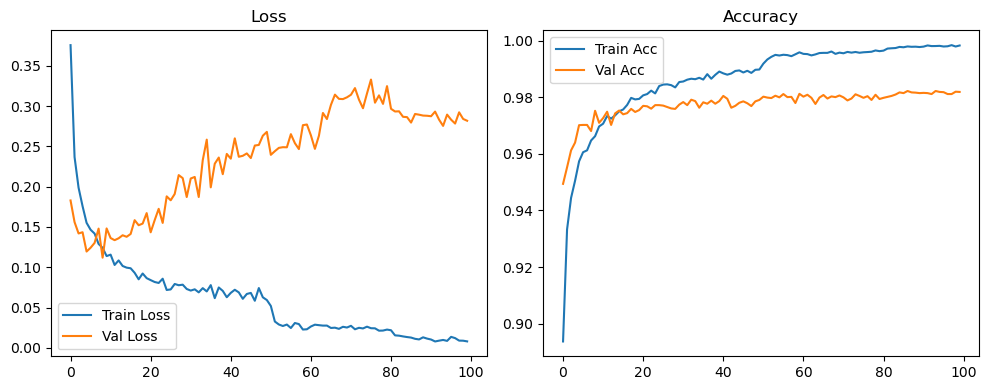

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2708, Acc: 0.9212 | Val Loss: 0.1664, Acc: 0.9548


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1357, Acc: 0.9602 | Val Loss: 0.1391, Acc: 0.9588


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1044, Acc: 0.9688 | Val Loss: 0.1196, Acc: 0.9663


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0751, Acc: 0.9766 | Val Loss: 0.1299, Acc: 0.9670


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0594, Acc: 0.9816 | Val Loss: 0.1360, Acc: 0.9677


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9842 | Val Loss: 0.1377, Acc: 0.9684


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9863 | Val Loss: 0.1291, Acc: 0.9716


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9882 | Val Loss: 0.1187, Acc: 0.9720


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9904 | Val Loss: 0.1230, Acc: 0.9727


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9899 | Val Loss: 0.1388, Acc: 0.9701


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9918 | Val Loss: 0.1417, Acc: 0.9713


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9923 | Val Loss: 0.1569, Acc: 0.9705


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9920 | Val Loss: 0.1386, Acc: 0.9726


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9932 | Val Loss: 0.1437, Acc: 0.9738


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9929 | Val Loss: 0.1290, Acc: 0.9747


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9948 | Val Loss: 0.1562, Acc: 0.9712


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9946 | Val Loss: 0.1405, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9947 | Val Loss: 0.1549, Acc: 0.9741


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9951 | Val Loss: 0.1438, Acc: 0.9742


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1603, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9955 | Val Loss: 0.1439, Acc: 0.9732


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9961 | Val Loss: 0.1410, Acc: 0.9745


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1676, Acc: 0.9722


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9961 | Val Loss: 0.1414, Acc: 0.9754


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9959 | Val Loss: 0.1508, Acc: 0.9745


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9966 | Val Loss: 0.1578, Acc: 0.9748


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9968 | Val Loss: 0.1532, Acc: 0.9746


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.1789, Acc: 0.9733


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1471, Acc: 0.9754


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9966 | Val Loss: 0.1593, Acc: 0.9739


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1549, Acc: 0.9748


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9971 | Val Loss: 0.1386, Acc: 0.9761


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1563, Acc: 0.9738


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1554, Acc: 0.9762


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1670, Acc: 0.9761


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9970 | Val Loss: 0.1938, Acc: 0.9727


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9971 | Val Loss: 0.1644, Acc: 0.9772


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9978 | Val Loss: 0.1624, Acc: 0.9731


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.1580, Acc: 0.9778


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.2103, Acc: 0.9754


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9974 | Val Loss: 0.1739, Acc: 0.9763


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9981 | Val Loss: 0.1669, Acc: 0.9758


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.1453, Acc: 0.9769


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9979 | Val Loss: 0.1577, Acc: 0.9768


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9975 | Val Loss: 0.1637, Acc: 0.9769


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1613, Acc: 0.9772


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9986 | Val Loss: 0.1675, Acc: 0.9770


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9979 | Val Loss: 0.1746, Acc: 0.9762


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9981 | Val Loss: 0.1683, Acc: 0.9762


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1643, Acc: 0.9772


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1472, Acc: 0.9799


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1424, Acc: 0.9795


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1463, Acc: 0.9802


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1486, Acc: 0.9791


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1513, Acc: 0.9797


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1524, Acc: 0.9799


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1586, Acc: 0.9794


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1572, Acc: 0.9792


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.1583, Acc: 0.9801


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1667, Acc: 0.9798


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1683, Acc: 0.9791


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1668, Acc: 0.9798


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1762, Acc: 0.9792


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1678, Acc: 0.9801


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1755, Acc: 0.9787


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1757, Acc: 0.9801


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1886, Acc: 0.9788


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1855, Acc: 0.9798


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1862, Acc: 0.9794


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1828, Acc: 0.9799


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1857, Acc: 0.9803


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2058, Acc: 0.9788


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1960, Acc: 0.9802


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1954, Acc: 0.9798


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2032, Acc: 0.9802


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1986, Acc: 0.9791


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2030, Acc: 0.9798


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1991, Acc: 0.9798


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2100, Acc: 0.9796


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2052, Acc: 0.9794


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2003, Acc: 0.9794


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1963, Acc: 0.9806


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2028, Acc: 0.9805


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1966, Acc: 0.9808


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1965, Acc: 0.9808


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2033, Acc: 0.9805


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2037, Acc: 0.9804


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2014, Acc: 0.9813


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1954, Acc: 0.9813


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2055, Acc: 0.9803


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1978, Acc: 0.9812


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.2008, Acc: 0.9807


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2009, Acc: 0.9806


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1970, Acc: 0.9812


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1949, Acc: 0.9808


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2027, Acc: 0.9803


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2036, Acc: 0.9815


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2116, Acc: 0.9804


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2072, Acc: 0.9811


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2151, Acc: 0.9799


Final Test Loss: 0.1755 Accuracy: 0.9819


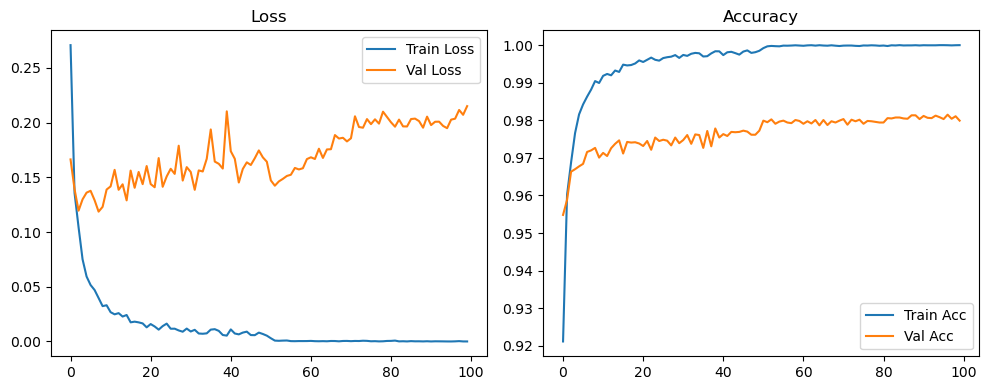

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2894, Acc: 0.9158 | Val Loss: 0.1942, Acc: 0.9469


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1648, Acc: 0.9519 | Val Loss: 0.1641, Acc: 0.9537


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1250, Acc: 0.9633 | Val Loss: 0.1333, Acc: 0.9633


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1024, Acc: 0.9700 | Val Loss: 0.1377, Acc: 0.9654


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0861, Acc: 0.9739 | Val Loss: 0.1284, Acc: 0.9696


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0755, Acc: 0.9781 | Val Loss: 0.1319, Acc: 0.9686


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0704, Acc: 0.9784 | Val Loss: 0.1272, Acc: 0.9717


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0587, Acc: 0.9824 | Val Loss: 0.1613, Acc: 0.9642


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9841 | Val Loss: 0.1160, Acc: 0.9738


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9848 | Val Loss: 0.1475, Acc: 0.9704


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9858 | Val Loss: 0.1597, Acc: 0.9711


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9879 | Val Loss: 0.1314, Acc: 0.9758


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0438, Acc: 0.9876 | Val Loss: 0.1596, Acc: 0.9719


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9879 | Val Loss: 0.1571, Acc: 0.9718


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9896 | Val Loss: 0.1507, Acc: 0.9739


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9893 | Val Loss: 0.1436, Acc: 0.9718


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9896 | Val Loss: 0.1613, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9916 | Val Loss: 0.1585, Acc: 0.9759


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9909 | Val Loss: 0.1894, Acc: 0.9729


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9916 | Val Loss: 0.1656, Acc: 0.9762


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9917 | Val Loss: 0.1877, Acc: 0.9733


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9925 | Val Loss: 0.1843, Acc: 0.9752


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9919 | Val Loss: 0.1726, Acc: 0.9753


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9939 | Val Loss: 0.2038, Acc: 0.9758


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9927 | Val Loss: 0.1928, Acc: 0.9747


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9934 | Val Loss: 0.1744, Acc: 0.9762


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9933 | Val Loss: 0.1906, Acc: 0.9752


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9934 | Val Loss: 0.1767, Acc: 0.9765


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9951 | Val Loss: 0.2131, Acc: 0.9761


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9941 | Val Loss: 0.1990, Acc: 0.9772


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9933 | Val Loss: 0.1962, Acc: 0.9759


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9944 | Val Loss: 0.1961, Acc: 0.9771


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9944 | Val Loss: 0.1846, Acc: 0.9772


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9947 | Val Loss: 0.1908, Acc: 0.9760


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9955 | Val Loss: 0.2199, Acc: 0.9774


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9948 | Val Loss: 0.2122, Acc: 0.9770


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9953 | Val Loss: 0.2379, Acc: 0.9759


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9956 | Val Loss: 0.2481, Acc: 0.9730


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9948 | Val Loss: 0.2236, Acc: 0.9763


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9945 | Val Loss: 0.2613, Acc: 0.9751


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9951 | Val Loss: 0.2185, Acc: 0.9774


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9954 | Val Loss: 0.2295, Acc: 0.9772


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9965 | Val Loss: 0.2398, Acc: 0.9788


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9965 | Val Loss: 0.2813, Acc: 0.9745


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9957 | Val Loss: 0.2469, Acc: 0.9765


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9949 | Val Loss: 0.2305, Acc: 0.9780


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9956 | Val Loss: 0.2484, Acc: 0.9770


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9955 | Val Loss: 0.2344, Acc: 0.9767


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9962 | Val Loss: 0.2678, Acc: 0.9778


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9954 | Val Loss: 0.2427, Acc: 0.9778


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9978 | Val Loss: 0.2111, Acc: 0.9808


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.2129, Acc: 0.9810


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.2044, Acc: 0.9821


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.2173, Acc: 0.9818


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.2204, Acc: 0.9813


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.2180, Acc: 0.9822


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.2274, Acc: 0.9819


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.2302, Acc: 0.9818


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.2325, Acc: 0.9827


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.2396, Acc: 0.9820


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.2513, Acc: 0.9817


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9996 | Val Loss: 0.2520, Acc: 0.9812


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.2493, Acc: 0.9823


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.2596, Acc: 0.9821


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.2590, Acc: 0.9820


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.2726, Acc: 0.9821


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.2843, Acc: 0.9814


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9994 | Val Loss: 0.2688, Acc: 0.9821


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9995 | Val Loss: 0.2550, Acc: 0.9821


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.2666, Acc: 0.9826


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.2770, Acc: 0.9817


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.2797, Acc: 0.9822


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.2775, Acc: 0.9820


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.2750, Acc: 0.9823


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.2844, Acc: 0.9812


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9996 | Val Loss: 0.2716, Acc: 0.9819


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9996 | Val Loss: 0.2868, Acc: 0.9814


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9996 | Val Loss: 0.2881, Acc: 0.9821


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.3029, Acc: 0.9810


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9996 | Val Loss: 0.2935, Acc: 0.9819


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.2809, Acc: 0.9827


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.2797, Acc: 0.9830


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9997 | Val Loss: 0.2842, Acc: 0.9822


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.2825, Acc: 0.9831


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2687, Acc: 0.9825


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.2878, Acc: 0.9821


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.2859, Acc: 0.9813


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9996 | Val Loss: 0.2880, Acc: 0.9823


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.2867, Acc: 0.9822


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.2894, Acc: 0.9821


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2870, Acc: 0.9823


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.3020, Acc: 0.9822


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9999 | Val Loss: 0.2846, Acc: 0.9821


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2779, Acc: 0.9826


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2894, Acc: 0.9822


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9998 | Val Loss: 0.2819, Acc: 0.9826


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.2953, Acc: 0.9819


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2922, Acc: 0.9819


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2764, Acc: 0.9826


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.2855, Acc: 0.9826


Final Test Loss: 0.2421 Accuracy: 0.9825


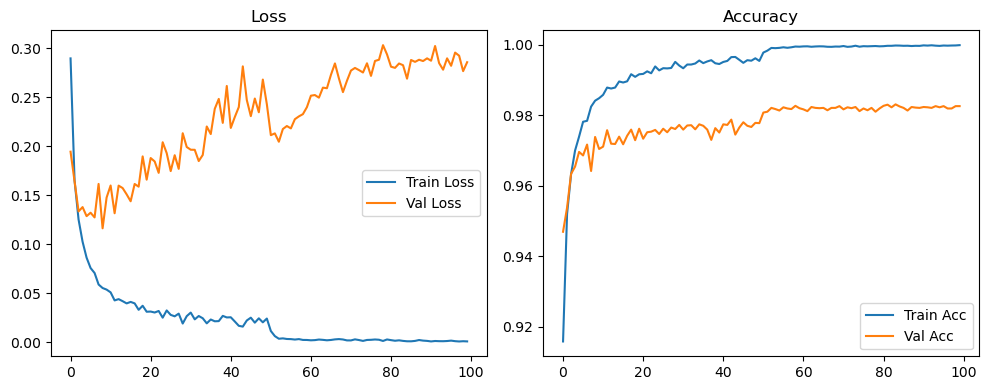

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3756, Acc: 0.8937 | Val Loss: 0.1829, Acc: 0.9494


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2368, Acc: 0.9333 | Val Loss: 0.1560, Acc: 0.9553


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1988, Acc: 0.9444 | Val Loss: 0.1420, Acc: 0.9613


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1758, Acc: 0.9505 | Val Loss: 0.1434, Acc: 0.9640


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1552, Acc: 0.9574 | Val Loss: 0.1195, Acc: 0.9702


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1466, Acc: 0.9606 | Val Loss: 0.1242, Acc: 0.9702


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1418, Acc: 0.9613 | Val Loss: 0.1302, Acc: 0.9702


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1290, Acc: 0.9647 | Val Loss: 0.1480, Acc: 0.9681


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1241, Acc: 0.9663 | Val Loss: 0.1119, Acc: 0.9752


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1139, Acc: 0.9697 | Val Loss: 0.1482, Acc: 0.9710


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1156, Acc: 0.9707 | Val Loss: 0.1362, Acc: 0.9727


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1028, Acc: 0.9734 | Val Loss: 0.1336, Acc: 0.9749


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1085, Acc: 0.9725 | Val Loss: 0.1359, Acc: 0.9702


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1016, Acc: 0.9736 | Val Loss: 0.1397, Acc: 0.9743


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0995, Acc: 0.9751 | Val Loss: 0.1378, Acc: 0.9753


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0987, Acc: 0.9757 | Val Loss: 0.1413, Acc: 0.9740


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0931, Acc: 0.9773 | Val Loss: 0.1584, Acc: 0.9744


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0850, Acc: 0.9798 | Val Loss: 0.1521, Acc: 0.9759


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0923, Acc: 0.9793 | Val Loss: 0.1542, Acc: 0.9748


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0865, Acc: 0.9795 | Val Loss: 0.1672, Acc: 0.9755


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0840, Acc: 0.9807 | Val Loss: 0.1434, Acc: 0.9770


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0817, Acc: 0.9812 | Val Loss: 0.1584, Acc: 0.9768


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0805, Acc: 0.9824 | Val Loss: 0.1725, Acc: 0.9760


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0858, Acc: 0.9814 | Val Loss: 0.1550, Acc: 0.9772


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0718, Acc: 0.9840 | Val Loss: 0.1880, Acc: 0.9772


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0725, Acc: 0.9845 | Val Loss: 0.1831, Acc: 0.9771


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0792, Acc: 0.9846 | Val Loss: 0.1909, Acc: 0.9766


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0777, Acc: 0.9843 | Val Loss: 0.2143, Acc: 0.9761


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0784, Acc: 0.9835 | Val Loss: 0.2106, Acc: 0.9759


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0730, Acc: 0.9854 | Val Loss: 0.1871, Acc: 0.9774


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9856 | Val Loss: 0.2101, Acc: 0.9783


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0726, Acc: 0.9862 | Val Loss: 0.2121, Acc: 0.9772


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9866 | Val Loss: 0.1872, Acc: 0.9792


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0741, Acc: 0.9864 | Val Loss: 0.2329, Acc: 0.9787


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0700, Acc: 0.9869 | Val Loss: 0.2584, Acc: 0.9763


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0778, Acc: 0.9863 | Val Loss: 0.1992, Acc: 0.9782


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0617, Acc: 0.9882 | Val Loss: 0.2285, Acc: 0.9778


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0749, Acc: 0.9866 | Val Loss: 0.2362, Acc: 0.9788


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0707, Acc: 0.9880 | Val Loss: 0.2155, Acc: 0.9778


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0628, Acc: 0.9891 | Val Loss: 0.2406, Acc: 0.9787


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9885 | Val Loss: 0.2348, Acc: 0.9805


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0721, Acc: 0.9880 | Val Loss: 0.2600, Acc: 0.9795


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9884 | Val Loss: 0.2371, Acc: 0.9763


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0608, Acc: 0.9893 | Val Loss: 0.2383, Acc: 0.9770


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9895 | Val Loss: 0.2413, Acc: 0.9781


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9888 | Val Loss: 0.2355, Acc: 0.9786


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0584, Acc: 0.9894 | Val Loss: 0.2511, Acc: 0.9779


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9886 | Val Loss: 0.2518, Acc: 0.9769


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0627, Acc: 0.9898 | Val Loss: 0.2632, Acc: 0.9786


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0593, Acc: 0.9898 | Val Loss: 0.2680, Acc: 0.9791


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0492, Acc: 0.9922 | Val Loss: 0.2382, Acc: 0.9802


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0345, Acc: 0.9935 | Val Loss: 0.2363, Acc: 0.9808


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0303, Acc: 0.9943 | Val Loss: 0.2293, Acc: 0.9808


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9951 | Val Loss: 0.2310, Acc: 0.9808


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9952 | Val Loss: 0.2374, Acc: 0.9813


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0204, Acc: 0.9961 | Val Loss: 0.2411, Acc: 0.9811


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9957 | Val Loss: 0.2243, Acc: 0.9814


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9955 | Val Loss: 0.2361, Acc: 0.9822


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9964 | Val Loss: 0.2466, Acc: 0.9810


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9965 | Val Loss: 0.2435, Acc: 0.9818


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9964 | Val Loss: 0.2601, Acc: 0.9803


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9966 | Val Loss: 0.2560, Acc: 0.9814


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9966 | Val Loss: 0.2449, Acc: 0.9817


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9970 | Val Loss: 0.2553, Acc: 0.9820


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9970 | Val Loss: 0.2536, Acc: 0.9818


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9971 | Val Loss: 0.2535, Acc: 0.9816


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9973 | Val Loss: 0.2628, Acc: 0.9807


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9970 | Val Loss: 0.2571, Acc: 0.9830


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9978 | Val Loss: 0.2521, Acc: 0.9825


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9974 | Val Loss: 0.2413, Acc: 0.9824


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9975 | Val Loss: 0.2445, Acc: 0.9822


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9979 | Val Loss: 0.2631, Acc: 0.9819


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9976 | Val Loss: 0.2787, Acc: 0.9818


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9978 | Val Loss: 0.2657, Acc: 0.9815


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9974 | Val Loss: 0.2631, Acc: 0.9822


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9976 | Val Loss: 0.2561, Acc: 0.9825


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9978 | Val Loss: 0.2719, Acc: 0.9816


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9978 | Val Loss: 0.2689, Acc: 0.9820


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9976 | Val Loss: 0.2675, Acc: 0.9818


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9978 | Val Loss: 0.2571, Acc: 0.9817


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9979 | Val Loss: 0.2692, Acc: 0.9812


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9982 | Val Loss: 0.2545, Acc: 0.9820


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9980 | Val Loss: 0.2516, Acc: 0.9814


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9980 | Val Loss: 0.2468, Acc: 0.9823


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9981 | Val Loss: 0.2550, Acc: 0.9822


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9980 | Val Loss: 0.2464, Acc: 0.9828


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9980 | Val Loss: 0.2561, Acc: 0.9811


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9983 | Val Loss: 0.2521, Acc: 0.9826


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9982 | Val Loss: 0.2625, Acc: 0.9817


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9985 | Val Loss: 0.2601, Acc: 0.9822


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9988 | Val Loss: 0.2650, Acc: 0.9825


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9983 | Val Loss: 0.2771, Acc: 0.9822


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9988 | Val Loss: 0.2706, Acc: 0.9818


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9983 | Val Loss: 0.2579, Acc: 0.9830


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9985 | Val Loss: 0.2716, Acc: 0.9822


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9984 | Val Loss: 0.2712, Acc: 0.9827


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9986 | Val Loss: 0.2704, Acc: 0.9820


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9986 | Val Loss: 0.2718, Acc: 0.9820


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9988 | Val Loss: 0.2671, Acc: 0.9821


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9987 | Val Loss: 0.2730, Acc: 0.9820


Final Test Loss: 0.2282 Accuracy: 0.9846


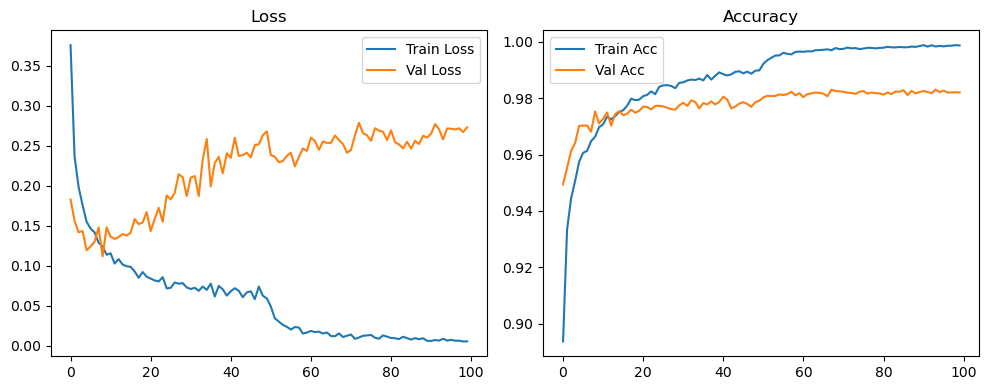

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2470, Acc: 0.9267 | Val Loss: 0.1790, Acc: 0.9513


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1240, Acc: 0.9625 | Val Loss: 0.1263, Acc: 0.9626


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0915, Acc: 0.9722 | Val Loss: 0.1196, Acc: 0.9639


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0712, Acc: 0.9775 | Val Loss: 0.1178, Acc: 0.9674


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0555, Acc: 0.9813 | Val Loss: 0.1310, Acc: 0.9670


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9854 | Val Loss: 0.1315, Acc: 0.9677


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9868 | Val Loss: 0.1232, Acc: 0.9711


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9896 | Val Loss: 0.1348, Acc: 0.9681


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9899 | Val Loss: 0.1389, Acc: 0.9702


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9905 | Val Loss: 0.1436, Acc: 0.9690


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9916 | Val Loss: 0.1369, Acc: 0.9700


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9925 | Val Loss: 0.1218, Acc: 0.9747


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9930 | Val Loss: 0.1442, Acc: 0.9703


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9936 | Val Loss: 0.1329, Acc: 0.9754


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9932 | Val Loss: 0.1317, Acc: 0.9741


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9951 | Val Loss: 0.1265, Acc: 0.9757


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9942 | Val Loss: 0.1437, Acc: 0.9723


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9951 | Val Loss: 0.1317, Acc: 0.9733


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9949 | Val Loss: 0.1390, Acc: 0.9742


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1335, Acc: 0.9751


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9955 | Val Loss: 0.1594, Acc: 0.9700


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9951 | Val Loss: 0.1358, Acc: 0.9762


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.1578, Acc: 0.9732


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9962 | Val Loss: 0.1185, Acc: 0.9770


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9970 | Val Loss: 0.1325, Acc: 0.9755


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9969 | Val Loss: 0.1552, Acc: 0.9734


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.1350, Acc: 0.9756


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9972 | Val Loss: 0.1474, Acc: 0.9748


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1568, Acc: 0.9748


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1667, Acc: 0.9732


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1415, Acc: 0.9760


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9972 | Val Loss: 0.1564, Acc: 0.9755


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.1444, Acc: 0.9768


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.1530, Acc: 0.9758


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.1498, Acc: 0.9752


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9977 | Val Loss: 0.1266, Acc: 0.9774


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1455, Acc: 0.9753


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1584, Acc: 0.9741


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1356, Acc: 0.9759


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9971 | Val Loss: 0.1652, Acc: 0.9738


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1350, Acc: 0.9773


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.1599, Acc: 0.9748


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1542, Acc: 0.9775


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1483, Acc: 0.9775


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1590, Acc: 0.9782


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.1744, Acc: 0.9738


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1742, Acc: 0.9764


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.1630, Acc: 0.9767


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1507, Acc: 0.9759


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9983 | Val Loss: 0.1630, Acc: 0.9757


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.1398, Acc: 0.9761


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9982 | Val Loss: 0.1388, Acc: 0.9771


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1618, Acc: 0.9738


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1623, Acc: 0.9766


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.1575, Acc: 0.9764


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1577, Acc: 0.9782


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9988 | Val Loss: 0.1706, Acc: 0.9776


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1847, Acc: 0.9742


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1641, Acc: 0.9781


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1738, Acc: 0.9772


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9987 | Val Loss: 0.1660, Acc: 0.9774


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1641, Acc: 0.9780


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.1833, Acc: 0.9759


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.1666, Acc: 0.9780


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1715, Acc: 0.9787


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1839, Acc: 0.9760


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1676, Acc: 0.9762


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9985 | Val Loss: 0.1648, Acc: 0.9768


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1698, Acc: 0.9777


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1713, Acc: 0.9771


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1840, Acc: 0.9772


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9983 | Val Loss: 0.1666, Acc: 0.9785


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1666, Acc: 0.9785


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1703, Acc: 0.9777


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.1863, Acc: 0.9768


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9986 | Val Loss: 0.1616, Acc: 0.9770


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1690, Acc: 0.9779


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1660, Acc: 0.9798


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1726, Acc: 0.9785


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.1803, Acc: 0.9797


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1635, Acc: 0.9800


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.1662, Acc: 0.9780


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9990 | Val Loss: 0.1858, Acc: 0.9770


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1822, Acc: 0.9774


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1828, Acc: 0.9784


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9989 | Val Loss: 0.2029, Acc: 0.9750


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.2007, Acc: 0.9768


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9991 | Val Loss: 0.1925, Acc: 0.9787


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.1854, Acc: 0.9787


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1958, Acc: 0.9779


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9991 | Val Loss: 0.1719, Acc: 0.9785


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1777, Acc: 0.9784


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.1828, Acc: 0.9777


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1707, Acc: 0.9778


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1797, Acc: 0.9800


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1975, Acc: 0.9773


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9994 | Val Loss: 0.2010, Acc: 0.9770


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.2345, Acc: 0.9770


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9990 | Val Loss: 0.1938, Acc: 0.9800


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.2199, Acc: 0.9773


Final Test Loss: 0.2111 Accuracy: 0.9768


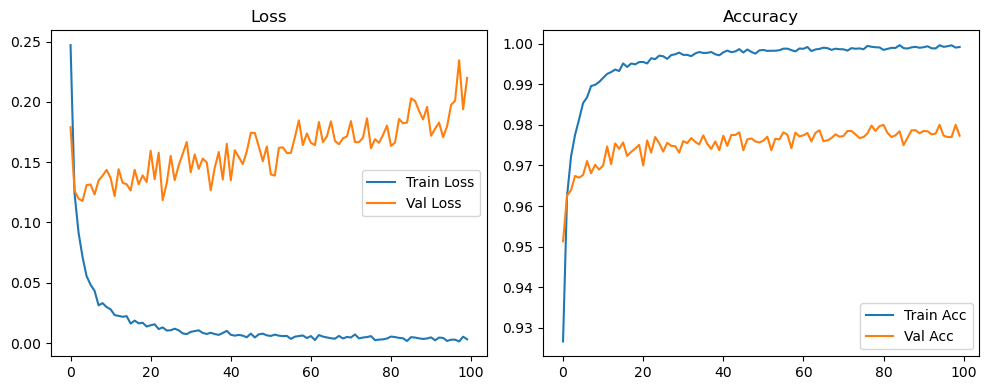

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2617, Acc: 0.9223 | Val Loss: 0.1813, Acc: 0.9496


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1414, Acc: 0.9578 | Val Loss: 0.1408, Acc: 0.9588


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1088, Acc: 0.9673 | Val Loss: 0.1188, Acc: 0.9647


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0911, Acc: 0.9715 | Val Loss: 0.1344, Acc: 0.9625


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0764, Acc: 0.9756 | Val Loss: 0.1173, Acc: 0.9688


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0671, Acc: 0.9793 | Val Loss: 0.1129, Acc: 0.9719


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0588, Acc: 0.9811 | Val Loss: 0.1232, Acc: 0.9704


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0525, Acc: 0.9841 | Val Loss: 0.1157, Acc: 0.9716


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9857 | Val Loss: 0.1152, Acc: 0.9741


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9861 | Val Loss: 0.1303, Acc: 0.9732


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0439, Acc: 0.9863 | Val Loss: 0.1328, Acc: 0.9720


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9888 | Val Loss: 0.1158, Acc: 0.9737


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9874 | Val Loss: 0.1462, Acc: 0.9692


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9890 | Val Loss: 0.1271, Acc: 0.9742


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9913 | Val Loss: 0.1417, Acc: 0.9740


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9915 | Val Loss: 0.1383, Acc: 0.9733


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9906 | Val Loss: 0.1433, Acc: 0.9711


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9912 | Val Loss: 0.1432, Acc: 0.9740


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9925 | Val Loss: 0.1465, Acc: 0.9728


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9932 | Val Loss: 0.1581, Acc: 0.9738


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9926 | Val Loss: 0.1569, Acc: 0.9735


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9932 | Val Loss: 0.1452, Acc: 0.9760


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9939 | Val Loss: 0.1476, Acc: 0.9761


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9938 | Val Loss: 0.1432, Acc: 0.9746


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9932 | Val Loss: 0.1481, Acc: 0.9759


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9942 | Val Loss: 0.1442, Acc: 0.9783


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9944 | Val Loss: 0.1547, Acc: 0.9765


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9956 | Val Loss: 0.1439, Acc: 0.9772


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9951 | Val Loss: 0.1445, Acc: 0.9769


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9950 | Val Loss: 0.1641, Acc: 0.9756


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9949 | Val Loss: 0.1488, Acc: 0.9756


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9950 | Val Loss: 0.1935, Acc: 0.9758


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9960 | Val Loss: 0.1873, Acc: 0.9763


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9950 | Val Loss: 0.1621, Acc: 0.9766


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9960 | Val Loss: 0.1698, Acc: 0.9761


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9950 | Val Loss: 0.1722, Acc: 0.9738


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9964 | Val Loss: 0.1689, Acc: 0.9782


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9958 | Val Loss: 0.1907, Acc: 0.9736


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9958 | Val Loss: 0.1732, Acc: 0.9780


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9967 | Val Loss: 0.1850, Acc: 0.9766


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9952 | Val Loss: 0.1836, Acc: 0.9764


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9960 | Val Loss: 0.1770, Acc: 0.9784


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9963 | Val Loss: 0.1798, Acc: 0.9767


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9964 | Val Loss: 0.2007, Acc: 0.9765


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9964 | Val Loss: 0.1942, Acc: 0.9768


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9968 | Val Loss: 0.1747, Acc: 0.9788


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9969 | Val Loss: 0.1952, Acc: 0.9754


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9967 | Val Loss: 0.1819, Acc: 0.9780


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9966 | Val Loss: 0.1891, Acc: 0.9780


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9963 | Val Loss: 0.1844, Acc: 0.9776


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9965 | Val Loss: 0.1742, Acc: 0.9767


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9961 | Val Loss: 0.2140, Acc: 0.9756


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9964 | Val Loss: 0.2003, Acc: 0.9762


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9974 | Val Loss: 0.1835, Acc: 0.9783


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1789, Acc: 0.9792


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9974 | Val Loss: 0.2047, Acc: 0.9786


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9972 | Val Loss: 0.1992, Acc: 0.9768


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9969 | Val Loss: 0.2087, Acc: 0.9784


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9969 | Val Loss: 0.1890, Acc: 0.9792


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9974 | Val Loss: 0.2071, Acc: 0.9785


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9970 | Val Loss: 0.2376, Acc: 0.9792


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9970 | Val Loss: 0.2166, Acc: 0.9774


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9969 | Val Loss: 0.2020, Acc: 0.9787


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9974 | Val Loss: 0.2134, Acc: 0.9777


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9974 | Val Loss: 0.2160, Acc: 0.9791


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9981 | Val Loss: 0.2408, Acc: 0.9779


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9977 | Val Loss: 0.2160, Acc: 0.9778


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9975 | Val Loss: 0.2049, Acc: 0.9779


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9973 | Val Loss: 0.2045, Acc: 0.9788


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9979 | Val Loss: 0.2020, Acc: 0.9776


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9970 | Val Loss: 0.2232, Acc: 0.9780


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9976 | Val Loss: 0.2530, Acc: 0.9754


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9972 | Val Loss: 0.2361, Acc: 0.9778


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9975 | Val Loss: 0.2263, Acc: 0.9769


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9981 | Val Loss: 0.2521, Acc: 0.9782


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9980 | Val Loss: 0.2433, Acc: 0.9771


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9977 | Val Loss: 0.2567, Acc: 0.9781


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9975 | Val Loss: 0.2799, Acc: 0.9769


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9968 | Val Loss: 0.2352, Acc: 0.9786


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9980 | Val Loss: 0.2557, Acc: 0.9787


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9981 | Val Loss: 0.2339, Acc: 0.9793


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9979 | Val Loss: 0.2444, Acc: 0.9779


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9978 | Val Loss: 0.2707, Acc: 0.9777


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9978 | Val Loss: 0.2613, Acc: 0.9782


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9979 | Val Loss: 0.2725, Acc: 0.9779


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9979 | Val Loss: 0.2402, Acc: 0.9790


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9979 | Val Loss: 0.2629, Acc: 0.9776


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9975 | Val Loss: 0.2441, Acc: 0.9803


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9984 | Val Loss: 0.2647, Acc: 0.9778


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9980 | Val Loss: 0.2617, Acc: 0.9782


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9979 | Val Loss: 0.3047, Acc: 0.9764


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9975 | Val Loss: 0.2930, Acc: 0.9770


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9979 | Val Loss: 0.2471, Acc: 0.9785


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9978 | Val Loss: 0.2768, Acc: 0.9773


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9980 | Val Loss: 0.2674, Acc: 0.9771


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9979 | Val Loss: 0.2352, Acc: 0.9801


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9980 | Val Loss: 0.2523, Acc: 0.9784


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9981 | Val Loss: 0.2685, Acc: 0.9782


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9980 | Val Loss: 0.2481, Acc: 0.9802


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9980 | Val Loss: 0.2969, Acc: 0.9786


Final Test Loss: 0.2958 Accuracy: 0.9787


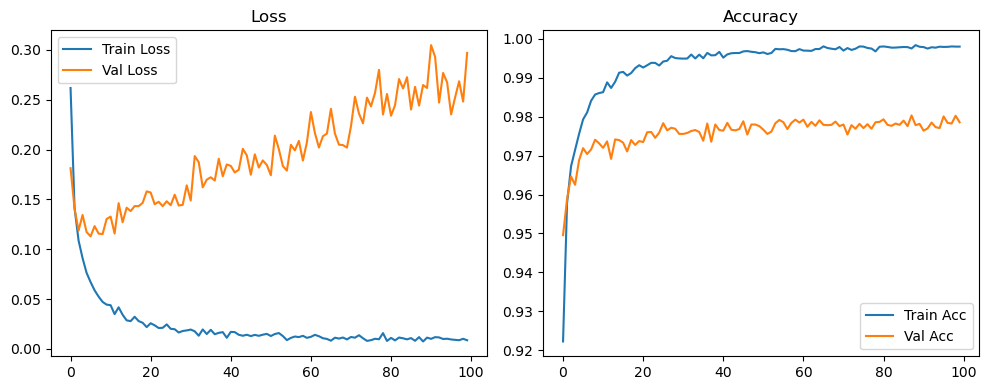

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3314, Acc: 0.9031 | Val Loss: 0.1713, Acc: 0.9525


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2030, Acc: 0.9398 | Val Loss: 0.1377, Acc: 0.9598


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1686, Acc: 0.9500 | Val Loss: 0.1309, Acc: 0.9624


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1454, Acc: 0.9567 | Val Loss: 0.1298, Acc: 0.9639


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1325, Acc: 0.9598 | Val Loss: 0.1135, Acc: 0.9687


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1232, Acc: 0.9634 | Val Loss: 0.1133, Acc: 0.9699


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1124, Acc: 0.9659 | Val Loss: 0.1051, Acc: 0.9725


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1027, Acc: 0.9689 | Val Loss: 0.1093, Acc: 0.9711


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0957, Acc: 0.9707 | Val Loss: 0.1056, Acc: 0.9732


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0927, Acc: 0.9726 | Val Loss: 0.1069, Acc: 0.9740


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0908, Acc: 0.9739 | Val Loss: 0.1202, Acc: 0.9708


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0819, Acc: 0.9746 | Val Loss: 0.1065, Acc: 0.9741


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0814, Acc: 0.9760 | Val Loss: 0.1136, Acc: 0.9736


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0793, Acc: 0.9775 | Val Loss: 0.1103, Acc: 0.9757


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0726, Acc: 0.9792 | Val Loss: 0.1122, Acc: 0.9762


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0708, Acc: 0.9795 | Val Loss: 0.1137, Acc: 0.9750


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0684, Acc: 0.9800 | Val Loss: 0.1107, Acc: 0.9755


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0650, Acc: 0.9812 | Val Loss: 0.1187, Acc: 0.9752


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0651, Acc: 0.9816 | Val Loss: 0.1268, Acc: 0.9748


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0642, Acc: 0.9824 | Val Loss: 0.1139, Acc: 0.9769


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0622, Acc: 0.9825 | Val Loss: 0.1253, Acc: 0.9762


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0546, Acc: 0.9844 | Val Loss: 0.1264, Acc: 0.9769


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0558, Acc: 0.9843 | Val Loss: 0.1221, Acc: 0.9769


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0596, Acc: 0.9835 | Val Loss: 0.1320, Acc: 0.9777


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0549, Acc: 0.9852 | Val Loss: 0.1269, Acc: 0.9770


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9854 | Val Loss: 0.1357, Acc: 0.9775


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0465, Acc: 0.9881 | Val Loss: 0.1307, Acc: 0.9788


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0513, Acc: 0.9864 | Val Loss: 0.1325, Acc: 0.9772


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0558, Acc: 0.9852 | Val Loss: 0.1361, Acc: 0.9782


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0551, Acc: 0.9860 | Val Loss: 0.1418, Acc: 0.9763


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0461, Acc: 0.9882 | Val Loss: 0.1401, Acc: 0.9779


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0457, Acc: 0.9878 | Val Loss: 0.1498, Acc: 0.9775


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0446, Acc: 0.9891 | Val Loss: 0.1471, Acc: 0.9773


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0449, Acc: 0.9885 | Val Loss: 0.1513, Acc: 0.9783


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9891 | Val Loss: 0.1579, Acc: 0.9782


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0485, Acc: 0.9883 | Val Loss: 0.1643, Acc: 0.9756


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9887 | Val Loss: 0.1687, Acc: 0.9785


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9888 | Val Loss: 0.1533, Acc: 0.9782


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9899 | Val Loss: 0.1425, Acc: 0.9801


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0407, Acc: 0.9895 | Val Loss: 0.1453, Acc: 0.9797


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9900 | Val Loss: 0.1859, Acc: 0.9778


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9901 | Val Loss: 0.1680, Acc: 0.9783


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9895 | Val Loss: 0.1699, Acc: 0.9782


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9897 | Val Loss: 0.1640, Acc: 0.9789


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9909 | Val Loss: 0.1724, Acc: 0.9801


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9906 | Val Loss: 0.1686, Acc: 0.9795


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9901 | Val Loss: 0.1689, Acc: 0.9788


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9915 | Val Loss: 0.1756, Acc: 0.9785


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9924 | Val Loss: 0.1984, Acc: 0.9788


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0416, Acc: 0.9909 | Val Loss: 0.1850, Acc: 0.9788


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9910 | Val Loss: 0.1793, Acc: 0.9778


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9921 | Val Loss: 0.1730, Acc: 0.9793


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0420, Acc: 0.9911 | Val Loss: 0.1799, Acc: 0.9770


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9913 | Val Loss: 0.1833, Acc: 0.9796


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0408, Acc: 0.9908 | Val Loss: 0.1925, Acc: 0.9787


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9911 | Val Loss: 0.1867, Acc: 0.9803


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9922 | Val Loss: 0.1949, Acc: 0.9795


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9919 | Val Loss: 0.1985, Acc: 0.9777


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9923 | Val Loss: 0.2090, Acc: 0.9782


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9931 | Val Loss: 0.2104, Acc: 0.9791


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9920 | Val Loss: 0.2047, Acc: 0.9787


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9930 | Val Loss: 0.2076, Acc: 0.9793


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9924 | Val Loss: 0.1958, Acc: 0.9787


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9924 | Val Loss: 0.2181, Acc: 0.9782


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9931 | Val Loss: 0.2195, Acc: 0.9796


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9933 | Val Loss: 0.2144, Acc: 0.9785


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9928 | Val Loss: 0.1997, Acc: 0.9798


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9931 | Val Loss: 0.2148, Acc: 0.9794


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9934 | Val Loss: 0.2094, Acc: 0.9793


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9937 | Val Loss: 0.2020, Acc: 0.9794


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9925 | Val Loss: 0.2349, Acc: 0.9785


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9930 | Val Loss: 0.2320, Acc: 0.9796


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9942 | Val Loss: 0.2233, Acc: 0.9804


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9925 | Val Loss: 0.2179, Acc: 0.9775


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9927 | Val Loss: 0.2149, Acc: 0.9783


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9937 | Val Loss: 0.2378, Acc: 0.9777


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9925 | Val Loss: 0.2255, Acc: 0.9784


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9935 | Val Loss: 0.2392, Acc: 0.9788


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9937 | Val Loss: 0.2456, Acc: 0.9782


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9935 | Val Loss: 0.2450, Acc: 0.9800


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9936 | Val Loss: 0.2428, Acc: 0.9802


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9940 | Val Loss: 0.2184, Acc: 0.9790


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9935 | Val Loss: 0.2210, Acc: 0.9802


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9944 | Val Loss: 0.2370, Acc: 0.9798


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9936 | Val Loss: 0.2409, Acc: 0.9812


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9944 | Val Loss: 0.2455, Acc: 0.9799


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9941 | Val Loss: 0.2651, Acc: 0.9800


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9948 | Val Loss: 0.2524, Acc: 0.9809


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9943 | Val Loss: 0.2431, Acc: 0.9811


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9943 | Val Loss: 0.2426, Acc: 0.9809


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9946 | Val Loss: 0.2432, Acc: 0.9791


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9945 | Val Loss: 0.2461, Acc: 0.9795


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9940 | Val Loss: 0.2576, Acc: 0.9802


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9941 | Val Loss: 0.2316, Acc: 0.9804


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9947 | Val Loss: 0.2599, Acc: 0.9794


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9938 | Val Loss: 0.2791, Acc: 0.9783


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9949 | Val Loss: 0.2607, Acc: 0.9790


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9945 | Val Loss: 0.2560, Acc: 0.9796


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9949 | Val Loss: 0.2696, Acc: 0.9801


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9942 | Val Loss: 0.2651, Acc: 0.9803


Final Test Loss: 0.2584 Accuracy: 0.9808


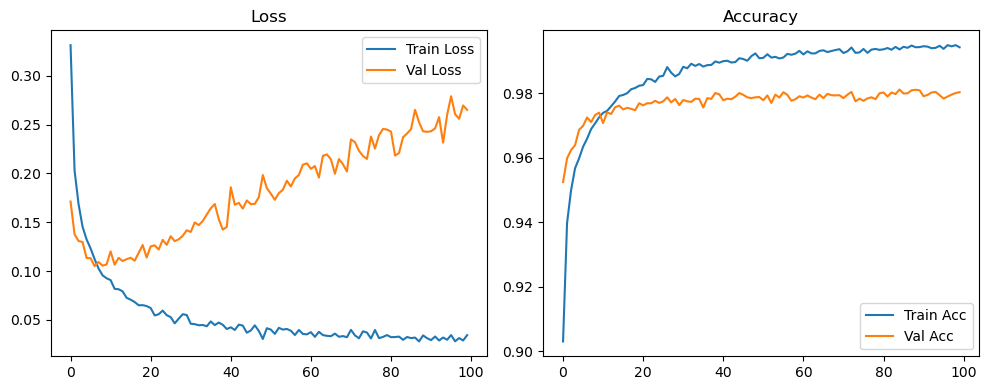

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2470, Acc: 0.9267 | Val Loss: 0.1790, Acc: 0.9513


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1240, Acc: 0.9625 | Val Loss: 0.1263, Acc: 0.9626


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0915, Acc: 0.9722 | Val Loss: 0.1196, Acc: 0.9639


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0712, Acc: 0.9775 | Val Loss: 0.1178, Acc: 0.9674


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0555, Acc: 0.9813 | Val Loss: 0.1310, Acc: 0.9670


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9854 | Val Loss: 0.1315, Acc: 0.9677


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9868 | Val Loss: 0.1232, Acc: 0.9711


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9896 | Val Loss: 0.1348, Acc: 0.9681


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9899 | Val Loss: 0.1389, Acc: 0.9702


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9905 | Val Loss: 0.1436, Acc: 0.9690


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9916 | Val Loss: 0.1369, Acc: 0.9700


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9925 | Val Loss: 0.1218, Acc: 0.9747


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9930 | Val Loss: 0.1442, Acc: 0.9703


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9936 | Val Loss: 0.1329, Acc: 0.9754


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9932 | Val Loss: 0.1317, Acc: 0.9741


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9951 | Val Loss: 0.1265, Acc: 0.9757


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9942 | Val Loss: 0.1437, Acc: 0.9723


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9951 | Val Loss: 0.1317, Acc: 0.9733


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9949 | Val Loss: 0.1390, Acc: 0.9742


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1335, Acc: 0.9751


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9955 | Val Loss: 0.1594, Acc: 0.9700


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9951 | Val Loss: 0.1358, Acc: 0.9762


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.1578, Acc: 0.9732


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9962 | Val Loss: 0.1185, Acc: 0.9770


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9970 | Val Loss: 0.1325, Acc: 0.9755


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9969 | Val Loss: 0.1552, Acc: 0.9734


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.1350, Acc: 0.9756


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9972 | Val Loss: 0.1474, Acc: 0.9748


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1568, Acc: 0.9748


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1667, Acc: 0.9732


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1415, Acc: 0.9760


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9972 | Val Loss: 0.1564, Acc: 0.9755


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.1444, Acc: 0.9768


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.1530, Acc: 0.9758


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.1498, Acc: 0.9752


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9977 | Val Loss: 0.1266, Acc: 0.9774


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1455, Acc: 0.9753


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1584, Acc: 0.9741


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1356, Acc: 0.9759


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9971 | Val Loss: 0.1652, Acc: 0.9738


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1350, Acc: 0.9773


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.1599, Acc: 0.9748


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1542, Acc: 0.9775


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1483, Acc: 0.9775


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1590, Acc: 0.9782


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.1744, Acc: 0.9738


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1742, Acc: 0.9764


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.1630, Acc: 0.9767


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1507, Acc: 0.9759


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9983 | Val Loss: 0.1630, Acc: 0.9757


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1284, Acc: 0.9797


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1318, Acc: 0.9796


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1355, Acc: 0.9799


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1407, Acc: 0.9790


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1345, Acc: 0.9792


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1378, Acc: 0.9801


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1455, Acc: 0.9805


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1524, Acc: 0.9794


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1522, Acc: 0.9796


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1615, Acc: 0.9782


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1584, Acc: 0.9792


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1636, Acc: 0.9790


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1598, Acc: 0.9792


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.1642, Acc: 0.9791


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1630, Acc: 0.9798


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1587, Acc: 0.9794


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1793, Acc: 0.9784


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1762, Acc: 0.9791


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1878, Acc: 0.9777


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1907, Acc: 0.9782


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1800, Acc: 0.9786


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1895, Acc: 0.9778


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1837, Acc: 0.9791


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.1759, Acc: 0.9795


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1770, Acc: 0.9795


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1897, Acc: 0.9776


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1830, Acc: 0.9792


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1744, Acc: 0.9790


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1825, Acc: 0.9787


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1933, Acc: 0.9785


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1859, Acc: 0.9794


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1901, Acc: 0.9793


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1848, Acc: 0.9798


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1828, Acc: 0.9806


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1798, Acc: 0.9794


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1845, Acc: 0.9797


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1933, Acc: 0.9799


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1840, Acc: 0.9796


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1888, Acc: 0.9798


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1817, Acc: 0.9798


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1864, Acc: 0.9793


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1930, Acc: 0.9788


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1864, Acc: 0.9802


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1875, Acc: 0.9795


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1939, Acc: 0.9793


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2020, Acc: 0.9793


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1936, Acc: 0.9802


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2007, Acc: 0.9796


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2023, Acc: 0.9797


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2076, Acc: 0.9807


Final Test Loss: 0.1871 Accuracy: 0.9818


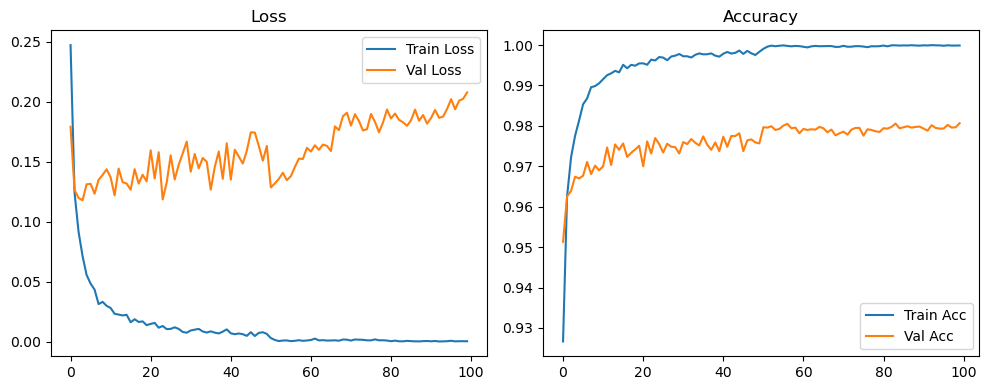

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2617, Acc: 0.9223 | Val Loss: 0.1813, Acc: 0.9496


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1414, Acc: 0.9578 | Val Loss: 0.1408, Acc: 0.9588


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1088, Acc: 0.9673 | Val Loss: 0.1188, Acc: 0.9647


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0911, Acc: 0.9715 | Val Loss: 0.1344, Acc: 0.9625


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0764, Acc: 0.9756 | Val Loss: 0.1173, Acc: 0.9688


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0671, Acc: 0.9793 | Val Loss: 0.1129, Acc: 0.9719


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0588, Acc: 0.9811 | Val Loss: 0.1232, Acc: 0.9704


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0525, Acc: 0.9841 | Val Loss: 0.1157, Acc: 0.9716


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9857 | Val Loss: 0.1152, Acc: 0.9741


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9861 | Val Loss: 0.1303, Acc: 0.9732


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0439, Acc: 0.9863 | Val Loss: 0.1328, Acc: 0.9720


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9888 | Val Loss: 0.1158, Acc: 0.9737


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9874 | Val Loss: 0.1462, Acc: 0.9692


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9890 | Val Loss: 0.1271, Acc: 0.9742


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9913 | Val Loss: 0.1417, Acc: 0.9740


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9915 | Val Loss: 0.1383, Acc: 0.9733


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9906 | Val Loss: 0.1433, Acc: 0.9711


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9912 | Val Loss: 0.1432, Acc: 0.9740


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9925 | Val Loss: 0.1465, Acc: 0.9728


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9932 | Val Loss: 0.1581, Acc: 0.9738


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9926 | Val Loss: 0.1569, Acc: 0.9735


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9932 | Val Loss: 0.1452, Acc: 0.9760


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9939 | Val Loss: 0.1476, Acc: 0.9761


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9938 | Val Loss: 0.1432, Acc: 0.9746


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9932 | Val Loss: 0.1481, Acc: 0.9759


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9942 | Val Loss: 0.1442, Acc: 0.9783


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9944 | Val Loss: 0.1547, Acc: 0.9765


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9956 | Val Loss: 0.1439, Acc: 0.9772


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9951 | Val Loss: 0.1445, Acc: 0.9769


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9950 | Val Loss: 0.1641, Acc: 0.9756


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9949 | Val Loss: 0.1488, Acc: 0.9756


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9950 | Val Loss: 0.1935, Acc: 0.9758


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9960 | Val Loss: 0.1873, Acc: 0.9763


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9950 | Val Loss: 0.1621, Acc: 0.9766


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9960 | Val Loss: 0.1698, Acc: 0.9761


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9950 | Val Loss: 0.1722, Acc: 0.9738


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9964 | Val Loss: 0.1689, Acc: 0.9782


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9958 | Val Loss: 0.1907, Acc: 0.9736


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9958 | Val Loss: 0.1732, Acc: 0.9780


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9967 | Val Loss: 0.1850, Acc: 0.9766


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9952 | Val Loss: 0.1836, Acc: 0.9764


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9960 | Val Loss: 0.1770, Acc: 0.9784


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9963 | Val Loss: 0.1798, Acc: 0.9767


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9964 | Val Loss: 0.2007, Acc: 0.9765


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9964 | Val Loss: 0.1942, Acc: 0.9768


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9968 | Val Loss: 0.1747, Acc: 0.9788


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9969 | Val Loss: 0.1952, Acc: 0.9754


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9967 | Val Loss: 0.1819, Acc: 0.9780


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9966 | Val Loss: 0.1891, Acc: 0.9780


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9963 | Val Loss: 0.1844, Acc: 0.9776


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.1558, Acc: 0.9798


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1701, Acc: 0.9802


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1657, Acc: 0.9809


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1711, Acc: 0.9795


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1715, Acc: 0.9808


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1793, Acc: 0.9801


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1975, Acc: 0.9803


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1852, Acc: 0.9812


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9991 | Val Loss: 0.1877, Acc: 0.9810


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1945, Acc: 0.9814


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.2038, Acc: 0.9794


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9993 | Val Loss: 0.2049, Acc: 0.9792


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.2104, Acc: 0.9788


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.2142, Acc: 0.9806


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.2136, Acc: 0.9814


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.2131, Acc: 0.9813


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.2136, Acc: 0.9811


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.2093, Acc: 0.9801


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.2089, Acc: 0.9794


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.2045, Acc: 0.9800


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.2048, Acc: 0.9806


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.2178, Acc: 0.9798


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1948, Acc: 0.9802


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1942, Acc: 0.9804


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9993 | Val Loss: 0.2024, Acc: 0.9810


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.2231, Acc: 0.9796


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9989 | Val Loss: 0.2219, Acc: 0.9805


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.2191, Acc: 0.9808


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.2119, Acc: 0.9811


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.2239, Acc: 0.9794


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.2151, Acc: 0.9802


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.2120, Acc: 0.9813


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.2177, Acc: 0.9806


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.2131, Acc: 0.9806


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.2058, Acc: 0.9813


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.2038, Acc: 0.9811


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.2042, Acc: 0.9811


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.2001, Acc: 0.9812


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.2019, Acc: 0.9813


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.2068, Acc: 0.9820


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.2054, Acc: 0.9823


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.2160, Acc: 0.9818


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2028, Acc: 0.9825


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9998 | Val Loss: 0.2016, Acc: 0.9823


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.2107, Acc: 0.9824


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9996 | Val Loss: 0.2076, Acc: 0.9822


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.2074, Acc: 0.9824


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.2131, Acc: 0.9814


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.2092, Acc: 0.9826


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2246, Acc: 0.9823


Final Test Loss: 0.2226 Accuracy: 0.9823


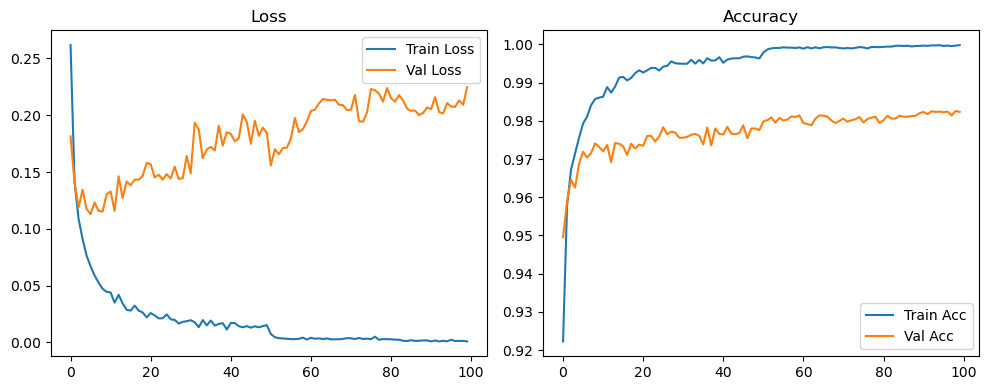

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3314, Acc: 0.9031 | Val Loss: 0.1713, Acc: 0.9525


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2030, Acc: 0.9398 | Val Loss: 0.1377, Acc: 0.9598


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1686, Acc: 0.9500 | Val Loss: 0.1309, Acc: 0.9624


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1454, Acc: 0.9567 | Val Loss: 0.1298, Acc: 0.9639


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1325, Acc: 0.9598 | Val Loss: 0.1135, Acc: 0.9687


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1232, Acc: 0.9634 | Val Loss: 0.1133, Acc: 0.9699


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1124, Acc: 0.9659 | Val Loss: 0.1051, Acc: 0.9725


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1027, Acc: 0.9689 | Val Loss: 0.1093, Acc: 0.9711


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0957, Acc: 0.9707 | Val Loss: 0.1056, Acc: 0.9732


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0927, Acc: 0.9726 | Val Loss: 0.1069, Acc: 0.9740


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0908, Acc: 0.9739 | Val Loss: 0.1202, Acc: 0.9708


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0819, Acc: 0.9746 | Val Loss: 0.1065, Acc: 0.9741


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0814, Acc: 0.9760 | Val Loss: 0.1136, Acc: 0.9736


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0793, Acc: 0.9775 | Val Loss: 0.1103, Acc: 0.9757


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0726, Acc: 0.9792 | Val Loss: 0.1122, Acc: 0.9762


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0708, Acc: 0.9795 | Val Loss: 0.1137, Acc: 0.9750


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0684, Acc: 0.9800 | Val Loss: 0.1107, Acc: 0.9755


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0650, Acc: 0.9812 | Val Loss: 0.1187, Acc: 0.9752


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0651, Acc: 0.9816 | Val Loss: 0.1268, Acc: 0.9748


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0642, Acc: 0.9824 | Val Loss: 0.1139, Acc: 0.9769


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0622, Acc: 0.9825 | Val Loss: 0.1253, Acc: 0.9762


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0546, Acc: 0.9844 | Val Loss: 0.1264, Acc: 0.9769


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0558, Acc: 0.9843 | Val Loss: 0.1221, Acc: 0.9769


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0596, Acc: 0.9835 | Val Loss: 0.1320, Acc: 0.9777


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0549, Acc: 0.9852 | Val Loss: 0.1269, Acc: 0.9770


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9854 | Val Loss: 0.1357, Acc: 0.9775


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0465, Acc: 0.9881 | Val Loss: 0.1307, Acc: 0.9788


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0513, Acc: 0.9864 | Val Loss: 0.1325, Acc: 0.9772


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0558, Acc: 0.9852 | Val Loss: 0.1361, Acc: 0.9782


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0551, Acc: 0.9860 | Val Loss: 0.1418, Acc: 0.9763


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0461, Acc: 0.9882 | Val Loss: 0.1401, Acc: 0.9779


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0457, Acc: 0.9878 | Val Loss: 0.1498, Acc: 0.9775


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0446, Acc: 0.9891 | Val Loss: 0.1471, Acc: 0.9773


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0449, Acc: 0.9885 | Val Loss: 0.1513, Acc: 0.9783


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9891 | Val Loss: 0.1579, Acc: 0.9782


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0485, Acc: 0.9883 | Val Loss: 0.1643, Acc: 0.9756


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9887 | Val Loss: 0.1687, Acc: 0.9785


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9888 | Val Loss: 0.1533, Acc: 0.9782


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9899 | Val Loss: 0.1425, Acc: 0.9801


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0407, Acc: 0.9895 | Val Loss: 0.1453, Acc: 0.9797


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9900 | Val Loss: 0.1859, Acc: 0.9778


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9901 | Val Loss: 0.1680, Acc: 0.9783


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9895 | Val Loss: 0.1699, Acc: 0.9782


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9897 | Val Loss: 0.1640, Acc: 0.9789


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9909 | Val Loss: 0.1724, Acc: 0.9801


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9906 | Val Loss: 0.1686, Acc: 0.9795


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9901 | Val Loss: 0.1689, Acc: 0.9788


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9915 | Val Loss: 0.1756, Acc: 0.9785


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9924 | Val Loss: 0.1984, Acc: 0.9788


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0416, Acc: 0.9909 | Val Loss: 0.1850, Acc: 0.9788


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9934 | Val Loss: 0.1569, Acc: 0.9807


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9952 | Val Loss: 0.1674, Acc: 0.9814


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9947 | Val Loss: 0.1583, Acc: 0.9815


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9954 | Val Loss: 0.1642, Acc: 0.9816


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9957 | Val Loss: 0.1730, Acc: 0.9810


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9957 | Val Loss: 0.1669, Acc: 0.9815


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9961 | Val Loss: 0.1764, Acc: 0.9816


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9960 | Val Loss: 0.1683, Acc: 0.9810


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9966 | Val Loss: 0.1745, Acc: 0.9810


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9964 | Val Loss: 0.1733, Acc: 0.9815


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9965 | Val Loss: 0.1899, Acc: 0.9799


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9961 | Val Loss: 0.1858, Acc: 0.9810


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9959 | Val Loss: 0.1897, Acc: 0.9809


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9968 | Val Loss: 0.1860, Acc: 0.9805


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9968 | Val Loss: 0.1823, Acc: 0.9815


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9969 | Val Loss: 0.1881, Acc: 0.9807


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9970 | Val Loss: 0.2014, Acc: 0.9811


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9976 | Val Loss: 0.2060, Acc: 0.9808


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9965 | Val Loss: 0.2004, Acc: 0.9813


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9968 | Val Loss: 0.1892, Acc: 0.9820


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9970 | Val Loss: 0.1859, Acc: 0.9818


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9976 | Val Loss: 0.1977, Acc: 0.9827


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9971 | Val Loss: 0.1963, Acc: 0.9812


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9966 | Val Loss: 0.1922, Acc: 0.9822


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9969 | Val Loss: 0.2078, Acc: 0.9802


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9976 | Val Loss: 0.1945, Acc: 0.9830


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9970 | Val Loss: 0.2005, Acc: 0.9811


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9968 | Val Loss: 0.2102, Acc: 0.9817


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9970 | Val Loss: 0.2014, Acc: 0.9816


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9969 | Val Loss: 0.2123, Acc: 0.9808


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.2111, Acc: 0.9812


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9975 | Val Loss: 0.2046, Acc: 0.9816


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9977 | Val Loss: 0.2003, Acc: 0.9820


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.2097, Acc: 0.9818


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.2052, Acc: 0.9817


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9980 | Val Loss: 0.2052, Acc: 0.9818


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9977 | Val Loss: 0.2141, Acc: 0.9815


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9981 | Val Loss: 0.2016, Acc: 0.9826


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9984 | Val Loss: 0.1969, Acc: 0.9828


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9983 | Val Loss: 0.2006, Acc: 0.9823


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9984 | Val Loss: 0.1897, Acc: 0.9827


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1994, Acc: 0.9832


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9981 | Val Loss: 0.1997, Acc: 0.9833


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.2074, Acc: 0.9828


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9987 | Val Loss: 0.1997, Acc: 0.9836


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9986 | Val Loss: 0.2050, Acc: 0.9824


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9982 | Val Loss: 0.2038, Acc: 0.9827


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.2102, Acc: 0.9832


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.2064, Acc: 0.9826


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9983 | Val Loss: 0.2105, Acc: 0.9817


Final Test Loss: 0.2109 Accuracy: 0.9820


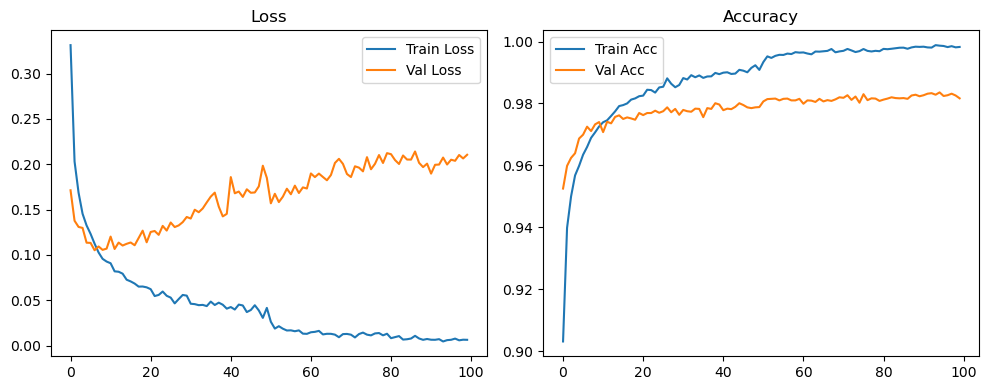

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2214, Acc: 0.9332 | Val Loss: 0.1554, Acc: 0.9552


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1105, Acc: 0.9656 | Val Loss: 0.1227, Acc: 0.9621


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0793, Acc: 0.9750 | Val Loss: 0.1115, Acc: 0.9677


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0589, Acc: 0.9810 | Val Loss: 0.1254, Acc: 0.9656


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0480, Acc: 0.9840 | Val Loss: 0.1189, Acc: 0.9691


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0406, Acc: 0.9865 | Val Loss: 0.1156, Acc: 0.9702


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0368, Acc: 0.9882 | Val Loss: 0.1353, Acc: 0.9684


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0344, Acc: 0.9891 | Val Loss: 0.1195, Acc: 0.9697


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9902 | Val Loss: 0.1142, Acc: 0.9733


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9923 | Val Loss: 0.1222, Acc: 0.9716


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9911 | Val Loss: 0.1325, Acc: 0.9702


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9924 | Val Loss: 0.1302, Acc: 0.9728


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9933 | Val Loss: 0.1261, Acc: 0.9733


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9943 | Val Loss: 0.1380, Acc: 0.9727


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.1322, Acc: 0.9733


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9942 | Val Loss: 0.1304, Acc: 0.9738


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.1476, Acc: 0.9715


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9942 | Val Loss: 0.1461, Acc: 0.9722


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9947 | Val Loss: 0.1332, Acc: 0.9740


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.1360, Acc: 0.9736


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9952 | Val Loss: 0.1249, Acc: 0.9742


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.1512, Acc: 0.9731


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.1429, Acc: 0.9741


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1524, Acc: 0.9727


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.1428, Acc: 0.9749


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9967 | Val Loss: 0.1336, Acc: 0.9770


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1376, Acc: 0.9755


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9963 | Val Loss: 0.1475, Acc: 0.9738


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1440, Acc: 0.9743


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1311, Acc: 0.9767


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9980 | Val Loss: 0.1660, Acc: 0.9738


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.1456, Acc: 0.9751


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.1369, Acc: 0.9768


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1498, Acc: 0.9739


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1532, Acc: 0.9758


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1450, Acc: 0.9760


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.1565, Acc: 0.9762


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1502, Acc: 0.9764


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.1565, Acc: 0.9770


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9977 | Val Loss: 0.1395, Acc: 0.9763


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.1399, Acc: 0.9779


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1392, Acc: 0.9790


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9977 | Val Loss: 0.1620, Acc: 0.9762


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9978 | Val Loss: 0.1487, Acc: 0.9757


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1356, Acc: 0.9761


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.1670, Acc: 0.9746


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1529, Acc: 0.9751


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1402, Acc: 0.9791


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1525, Acc: 0.9788


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1580, Acc: 0.9757


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1578, Acc: 0.9787


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1647, Acc: 0.9778


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1518, Acc: 0.9766


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1693, Acc: 0.9755


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.1493, Acc: 0.9774


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1541, Acc: 0.9777


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1639, Acc: 0.9776


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9984 | Val Loss: 0.1769, Acc: 0.9751


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1743, Acc: 0.9758


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1764, Acc: 0.9775


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.2047, Acc: 0.9746


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1680, Acc: 0.9769


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1682, Acc: 0.9778


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1741, Acc: 0.9785


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1775, Acc: 0.9760


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1747, Acc: 0.9773


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1917, Acc: 0.9756


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1795, Acc: 0.9775


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1656, Acc: 0.9783


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1673, Acc: 0.9773


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9984 | Val Loss: 0.1768, Acc: 0.9769


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1734, Acc: 0.9775


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1898, Acc: 0.9773


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1864, Acc: 0.9761


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1891, Acc: 0.9774


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1871, Acc: 0.9761


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.2009, Acc: 0.9764


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9984 | Val Loss: 0.1886, Acc: 0.9762


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.2007, Acc: 0.9769


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1902, Acc: 0.9759


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1758, Acc: 0.9787


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1685, Acc: 0.9792


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1866, Acc: 0.9774


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1965, Acc: 0.9772


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.1871, Acc: 0.9762


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1840, Acc: 0.9771


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1849, Acc: 0.9764


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1609, Acc: 0.9802


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.1664, Acc: 0.9802


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.1607, Acc: 0.9798


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1916, Acc: 0.9786


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1817, Acc: 0.9794


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.1783, Acc: 0.9779


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1637, Acc: 0.9782


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1888, Acc: 0.9756


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1952, Acc: 0.9768


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1752, Acc: 0.9762


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1782, Acc: 0.9779


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9994 | Val Loss: 0.1937, Acc: 0.9783


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.2022, Acc: 0.9762


Final Test Loss: 0.1662 Accuracy: 0.9788


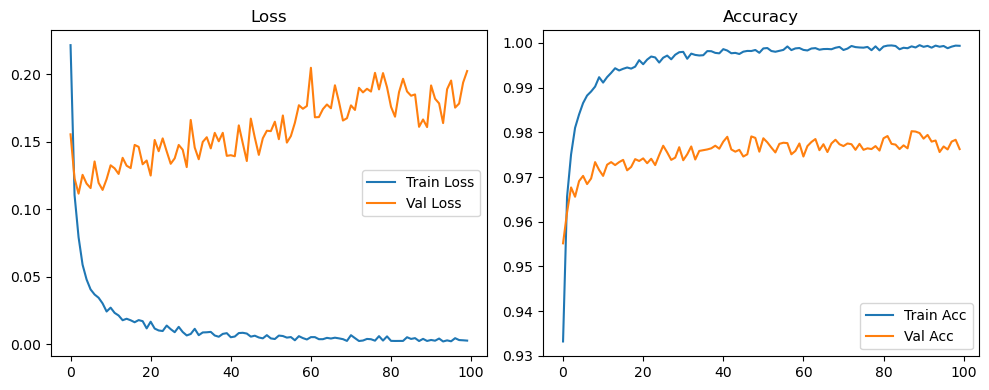

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2366, Acc: 0.9275 | Val Loss: 0.1501, Acc: 0.9559


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1232, Acc: 0.9623 | Val Loss: 0.1265, Acc: 0.9613


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0945, Acc: 0.9700 | Val Loss: 0.1164, Acc: 0.9649


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0791, Acc: 0.9744 | Val Loss: 0.1106, Acc: 0.9682


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0628, Acc: 0.9802 | Val Loss: 0.1140, Acc: 0.9687


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0587, Acc: 0.9812 | Val Loss: 0.1092, Acc: 0.9709


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0507, Acc: 0.9834 | Val Loss: 0.1036, Acc: 0.9734


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0446, Acc: 0.9852 | Val Loss: 0.1280, Acc: 0.9683


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0419, Acc: 0.9858 | Val Loss: 0.1108, Acc: 0.9722


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0401, Acc: 0.9870 | Val Loss: 0.1101, Acc: 0.9722


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0334, Acc: 0.9894 | Val Loss: 0.1208, Acc: 0.9722


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9894 | Val Loss: 0.1002, Acc: 0.9748


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9894 | Val Loss: 0.1102, Acc: 0.9718


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9903 | Val Loss: 0.1113, Acc: 0.9734


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9914 | Val Loss: 0.1041, Acc: 0.9769


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9918 | Val Loss: 0.1135, Acc: 0.9758


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9915 | Val Loss: 0.1235, Acc: 0.9755


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9918 | Val Loss: 0.1281, Acc: 0.9748


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9935 | Val Loss: 0.1398, Acc: 0.9720


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9925 | Val Loss: 0.1320, Acc: 0.9738


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9927 | Val Loss: 0.1202, Acc: 0.9748


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.1263, Acc: 0.9742


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9938 | Val Loss: 0.1225, Acc: 0.9752


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9947 | Val Loss: 0.1391, Acc: 0.9734


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9942 | Val Loss: 0.1245, Acc: 0.9765


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9945 | Val Loss: 0.1320, Acc: 0.9748


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9950 | Val Loss: 0.1320, Acc: 0.9758


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9944 | Val Loss: 0.1452, Acc: 0.9737


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9957 | Val Loss: 0.1292, Acc: 0.9768


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.1296, Acc: 0.9751


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9960 | Val Loss: 0.1365, Acc: 0.9777


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.1285, Acc: 0.9762


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.1429, Acc: 0.9762


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9964 | Val Loss: 0.1282, Acc: 0.9774


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9967 | Val Loss: 0.1391, Acc: 0.9756


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9954 | Val Loss: 0.1461, Acc: 0.9742


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9960 | Val Loss: 0.1378, Acc: 0.9776


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.1320, Acc: 0.9778


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9965 | Val Loss: 0.1412, Acc: 0.9762


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1372, Acc: 0.9777


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.1442, Acc: 0.9763


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1423, Acc: 0.9759


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9972 | Val Loss: 0.1322, Acc: 0.9783


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9975 | Val Loss: 0.1379, Acc: 0.9775


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9963 | Val Loss: 0.1509, Acc: 0.9757


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1472, Acc: 0.9774


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9973 | Val Loss: 0.1508, Acc: 0.9757


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9968 | Val Loss: 0.1643, Acc: 0.9767


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1627, Acc: 0.9774


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9973 | Val Loss: 0.1682, Acc: 0.9770


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9965 | Val Loss: 0.1491, Acc: 0.9772


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1517, Acc: 0.9778


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9975 | Val Loss: 0.1695, Acc: 0.9778


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9965 | Val Loss: 0.1652, Acc: 0.9772


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1499, Acc: 0.9788


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.1673, Acc: 0.9770


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9970 | Val Loss: 0.1658, Acc: 0.9783


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.1608, Acc: 0.9785


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.1701, Acc: 0.9785


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9977 | Val Loss: 0.1622, Acc: 0.9786


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.1551, Acc: 0.9803


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1731, Acc: 0.9775


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.1691, Acc: 0.9772


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9975 | Val Loss: 0.1588, Acc: 0.9781


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1897, Acc: 0.9772


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9980 | Val Loss: 0.1877, Acc: 0.9781


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.1828, Acc: 0.9767


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9977 | Val Loss: 0.1822, Acc: 0.9778


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9979 | Val Loss: 0.1710, Acc: 0.9790


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9978 | Val Loss: 0.1714, Acc: 0.9769


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1821, Acc: 0.9754


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.1643, Acc: 0.9792


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9975 | Val Loss: 0.1715, Acc: 0.9791


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1671, Acc: 0.9777


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1822, Acc: 0.9777


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9980 | Val Loss: 0.1826, Acc: 0.9771


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9979 | Val Loss: 0.1742, Acc: 0.9791


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9980 | Val Loss: 0.1789, Acc: 0.9790


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9982 | Val Loss: 0.1946, Acc: 0.9778


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9978 | Val Loss: 0.1826, Acc: 0.9781


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1788, Acc: 0.9773


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9975 | Val Loss: 0.1739, Acc: 0.9789


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1741, Acc: 0.9794


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1825, Acc: 0.9778


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1804, Acc: 0.9783


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.1880, Acc: 0.9776


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1936, Acc: 0.9777


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9983 | Val Loss: 0.2025, Acc: 0.9779


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1855, Acc: 0.9778


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.1898, Acc: 0.9777


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9984 | Val Loss: 0.2015, Acc: 0.9772


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1873, Acc: 0.9784


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1930, Acc: 0.9783


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9983 | Val Loss: 0.1812, Acc: 0.9794


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9982 | Val Loss: 0.1817, Acc: 0.9800


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9984 | Val Loss: 0.1878, Acc: 0.9800


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9981 | Val Loss: 0.1831, Acc: 0.9790


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9985 | Val Loss: 0.1881, Acc: 0.9777


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1817, Acc: 0.9788


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9982 | Val Loss: 0.1933, Acc: 0.9788


Final Test Loss: 0.2072 Accuracy: 0.9796


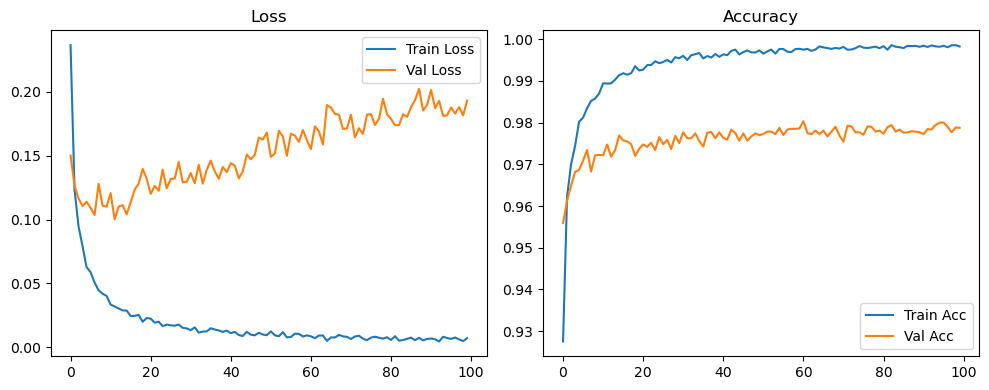

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3037, Acc: 0.9075 | Val Loss: 0.1557, Acc: 0.9533


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1753, Acc: 0.9457 | Val Loss: 0.1270, Acc: 0.9620


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1438, Acc: 0.9568 | Val Loss: 0.1254, Acc: 0.9632


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1253, Acc: 0.9613 | Val Loss: 0.1163, Acc: 0.9667


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1144, Acc: 0.9650 | Val Loss: 0.0977, Acc: 0.9698


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1061, Acc: 0.9674 | Val Loss: 0.1038, Acc: 0.9714


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0995, Acc: 0.9690 | Val Loss: 0.0977, Acc: 0.9712


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0851, Acc: 0.9732 | Val Loss: 0.1051, Acc: 0.9712


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0844, Acc: 0.9735 | Val Loss: 0.0948, Acc: 0.9750


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0759, Acc: 0.9762 | Val Loss: 0.0999, Acc: 0.9723


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0781, Acc: 0.9751 | Val Loss: 0.0997, Acc: 0.9742


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0696, Acc: 0.9782 | Val Loss: 0.0903, Acc: 0.9758


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0660, Acc: 0.9789 | Val Loss: 0.1029, Acc: 0.9733


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0657, Acc: 0.9787 | Val Loss: 0.0946, Acc: 0.9747


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0628, Acc: 0.9800 | Val Loss: 0.0973, Acc: 0.9744


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0580, Acc: 0.9816 | Val Loss: 0.0917, Acc: 0.9749


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0561, Acc: 0.9822 | Val Loss: 0.1079, Acc: 0.9742


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0519, Acc: 0.9831 | Val Loss: 0.1039, Acc: 0.9759


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0511, Acc: 0.9836 | Val Loss: 0.1035, Acc: 0.9758


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0502, Acc: 0.9839 | Val Loss: 0.0983, Acc: 0.9757


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0447, Acc: 0.9858 | Val Loss: 0.1097, Acc: 0.9753


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0492, Acc: 0.9846 | Val Loss: 0.1018, Acc: 0.9753


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0435, Acc: 0.9859 | Val Loss: 0.1168, Acc: 0.9763


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0452, Acc: 0.9859 | Val Loss: 0.1062, Acc: 0.9759


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0386, Acc: 0.9877 | Val Loss: 0.1006, Acc: 0.9767


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0427, Acc: 0.9869 | Val Loss: 0.1138, Acc: 0.9782


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0408, Acc: 0.9875 | Val Loss: 0.1024, Acc: 0.9769


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0394, Acc: 0.9876 | Val Loss: 0.1083, Acc: 0.9779


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0368, Acc: 0.9881 | Val Loss: 0.1140, Acc: 0.9775


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0394, Acc: 0.9878 | Val Loss: 0.1102, Acc: 0.9767


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9884 | Val Loss: 0.1151, Acc: 0.9777


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0387, Acc: 0.9882 | Val Loss: 0.1099, Acc: 0.9778


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9900 | Val Loss: 0.1220, Acc: 0.9767


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9901 | Val Loss: 0.1227, Acc: 0.9760


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9897 | Val Loss: 0.1141, Acc: 0.9763


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0351, Acc: 0.9893 | Val Loss: 0.1110, Acc: 0.9768


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9897 | Val Loss: 0.1224, Acc: 0.9779


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0322, Acc: 0.9905 | Val Loss: 0.1203, Acc: 0.9777


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9909 | Val Loss: 0.1207, Acc: 0.9786


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9909 | Val Loss: 0.1183, Acc: 0.9775


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9914 | Val Loss: 0.1247, Acc: 0.9776


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9908 | Val Loss: 0.1235, Acc: 0.9779


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9914 | Val Loss: 0.1356, Acc: 0.9763


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9919 | Val Loss: 0.1279, Acc: 0.9772


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9915 | Val Loss: 0.1273, Acc: 0.9771


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9914 | Val Loss: 0.1358, Acc: 0.9778


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9918 | Val Loss: 0.1368, Acc: 0.9775


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9920 | Val Loss: 0.1517, Acc: 0.9755


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9921 | Val Loss: 0.1467, Acc: 0.9768


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9917 | Val Loss: 0.1386, Acc: 0.9782


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9919 | Val Loss: 0.1393, Acc: 0.9773


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9920 | Val Loss: 0.1339, Acc: 0.9770


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9928 | Val Loss: 0.1496, Acc: 0.9766


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9924 | Val Loss: 0.1351, Acc: 0.9787


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9922 | Val Loss: 0.1348, Acc: 0.9785


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9923 | Val Loss: 0.1404, Acc: 0.9779


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9927 | Val Loss: 0.1257, Acc: 0.9787


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9938 | Val Loss: 0.1313, Acc: 0.9787


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9939 | Val Loss: 0.1334, Acc: 0.9792


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9934 | Val Loss: 0.1318, Acc: 0.9798


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9932 | Val Loss: 0.1369, Acc: 0.9781


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9940 | Val Loss: 0.1408, Acc: 0.9790


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9943 | Val Loss: 0.1420, Acc: 0.9779


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9921 | Val Loss: 0.1479, Acc: 0.9785


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9938 | Val Loss: 0.1405, Acc: 0.9793


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9937 | Val Loss: 0.1467, Acc: 0.9792


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9936 | Val Loss: 0.1473, Acc: 0.9788


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9938 | Val Loss: 0.1472, Acc: 0.9783


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9935 | Val Loss: 0.1376, Acc: 0.9793


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9944 | Val Loss: 0.1397, Acc: 0.9786


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9945 | Val Loss: 0.1468, Acc: 0.9788


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9944 | Val Loss: 0.1445, Acc: 0.9789


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9947 | Val Loss: 0.1548, Acc: 0.9783


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9934 | Val Loss: 0.1613, Acc: 0.9778


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9942 | Val Loss: 0.1596, Acc: 0.9788


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9951 | Val Loss: 0.1635, Acc: 0.9771


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9951 | Val Loss: 0.1505, Acc: 0.9787


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9950 | Val Loss: 0.1678, Acc: 0.9772


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9946 | Val Loss: 0.1756, Acc: 0.9772


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9937 | Val Loss: 0.1663, Acc: 0.9784


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9947 | Val Loss: 0.1770, Acc: 0.9790


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9946 | Val Loss: 0.1582, Acc: 0.9792


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9944 | Val Loss: 0.1680, Acc: 0.9798


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9948 | Val Loss: 0.1568, Acc: 0.9806


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9946 | Val Loss: 0.1657, Acc: 0.9786


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9951 | Val Loss: 0.1592, Acc: 0.9808


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9949 | Val Loss: 0.1650, Acc: 0.9790


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9950 | Val Loss: 0.1628, Acc: 0.9797


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9951 | Val Loss: 0.1678, Acc: 0.9787


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9957 | Val Loss: 0.1687, Acc: 0.9788


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9952 | Val Loss: 0.1672, Acc: 0.9790


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0175, Acc: 0.9952 | Val Loss: 0.1629, Acc: 0.9791


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9948 | Val Loss: 0.1656, Acc: 0.9799


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9953 | Val Loss: 0.1694, Acc: 0.9800


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0198, Acc: 0.9950 | Val Loss: 0.1755, Acc: 0.9794


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9955 | Val Loss: 0.1729, Acc: 0.9793


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9958 | Val Loss: 0.1640, Acc: 0.9793


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9959 | Val Loss: 0.1777, Acc: 0.9797


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9953 | Val Loss: 0.1796, Acc: 0.9792


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9952 | Val Loss: 0.1618, Acc: 0.9810


Final Test Loss: 0.1583 Accuracy: 0.9812


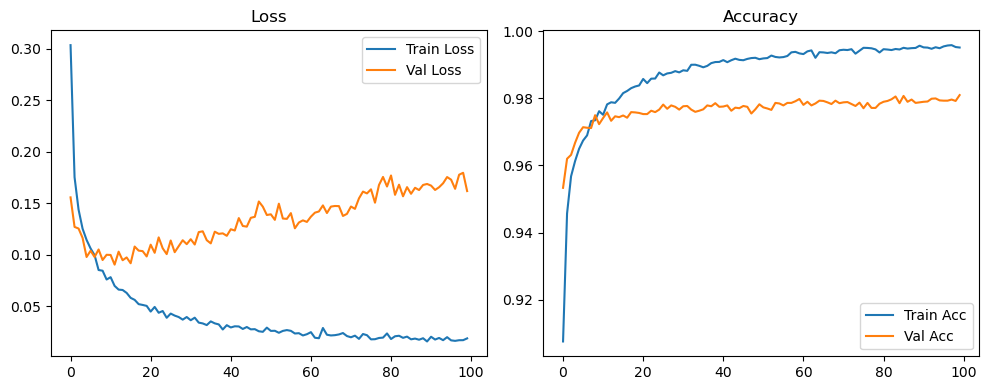

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2092, Acc: 0.9358 | Val Loss: 0.1366, Acc: 0.9600


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0980, Acc: 0.9688 | Val Loss: 0.1193, Acc: 0.9645


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0683, Acc: 0.9777 | Val Loss: 0.1034, Acc: 0.9683


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0494, Acc: 0.9839 | Val Loss: 0.1247, Acc: 0.9648


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0425, Acc: 0.9861 | Val Loss: 0.1148, Acc: 0.9699


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0340, Acc: 0.9885 | Val Loss: 0.1037, Acc: 0.9724


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9898 | Val Loss: 0.1079, Acc: 0.9728


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9910 | Val Loss: 0.1177, Acc: 0.9708


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9905 | Val Loss: 0.1090, Acc: 0.9714


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9932 | Val Loss: 0.1199, Acc: 0.9720


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9927 | Val Loss: 0.1207, Acc: 0.9723


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9928 | Val Loss: 0.1192, Acc: 0.9727


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9939 | Val Loss: 0.1070, Acc: 0.9744


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9949 | Val Loss: 0.1275, Acc: 0.9737


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9936 | Val Loss: 0.1239, Acc: 0.9752


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.1256, Acc: 0.9741


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9947 | Val Loss: 0.1315, Acc: 0.9712


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9951 | Val Loss: 0.1293, Acc: 0.9740


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.1153, Acc: 0.9766


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9954 | Val Loss: 0.1163, Acc: 0.9743


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.1307, Acc: 0.9735


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.1295, Acc: 0.9733


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9968 | Val Loss: 0.1266, Acc: 0.9748


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1294, Acc: 0.9752


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9961 | Val Loss: 0.1309, Acc: 0.9754


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9967 | Val Loss: 0.1271, Acc: 0.9761


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9967 | Val Loss: 0.1242, Acc: 0.9764


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1300, Acc: 0.9744


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1358, Acc: 0.9754


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1235, Acc: 0.9755


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1398, Acc: 0.9756


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9983 | Val Loss: 0.1363, Acc: 0.9764


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.1474, Acc: 0.9738


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1435, Acc: 0.9753


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.1279, Acc: 0.9778


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1384, Acc: 0.9768


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1462, Acc: 0.9763


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1334, Acc: 0.9759


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1410, Acc: 0.9771


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1352, Acc: 0.9775


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1423, Acc: 0.9760


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1484, Acc: 0.9766


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.1417, Acc: 0.9772


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.1478, Acc: 0.9761


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1325, Acc: 0.9762


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1453, Acc: 0.9755


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1460, Acc: 0.9788


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1381, Acc: 0.9779


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1627, Acc: 0.9761


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.1617, Acc: 0.9760


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1485, Acc: 0.9752


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1444, Acc: 0.9772


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1477, Acc: 0.9788


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1508, Acc: 0.9764


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1325, Acc: 0.9791


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1461, Acc: 0.9782


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1523, Acc: 0.9778


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1613, Acc: 0.9776


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1619, Acc: 0.9764


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1830, Acc: 0.9749


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1662, Acc: 0.9762


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1564, Acc: 0.9765


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.1711, Acc: 0.9752


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1691, Acc: 0.9752


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1535, Acc: 0.9784


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1601, Acc: 0.9788


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1477, Acc: 0.9802


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9990 | Val Loss: 0.1675, Acc: 0.9782


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1849, Acc: 0.9757


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9989 | Val Loss: 0.1691, Acc: 0.9770


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.1491, Acc: 0.9792


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1580, Acc: 0.9782


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1558, Acc: 0.9775


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9990 | Val Loss: 0.1405, Acc: 0.9785


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1635, Acc: 0.9767


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1617, Acc: 0.9779


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1699, Acc: 0.9760


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1700, Acc: 0.9771


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1673, Acc: 0.9779


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.1610, Acc: 0.9773


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.1668, Acc: 0.9763


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1650, Acc: 0.9790


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1752, Acc: 0.9782


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1762, Acc: 0.9772


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1738, Acc: 0.9765


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1698, Acc: 0.9768


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1876, Acc: 0.9760


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9990 | Val Loss: 0.1788, Acc: 0.9759


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1718, Acc: 0.9772


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1918, Acc: 0.9748


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1876, Acc: 0.9748


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1842, Acc: 0.9764


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1718, Acc: 0.9780


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1797, Acc: 0.9778


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.1740, Acc: 0.9780


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1756, Acc: 0.9783


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1802, Acc: 0.9771


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1812, Acc: 0.9762


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1927, Acc: 0.9760


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.1688, Acc: 0.9774


Final Test Loss: 0.1477 Accuracy: 0.9801


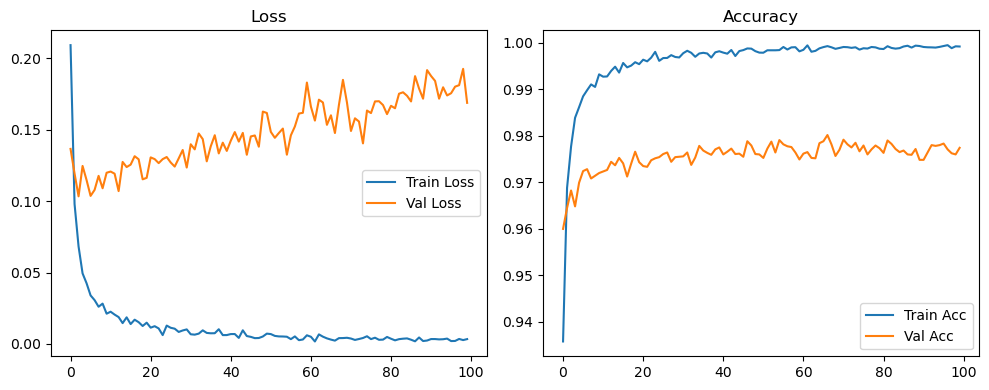

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2327, Acc: 0.9290 | Val Loss: 0.1369, Acc: 0.9579


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1152, Acc: 0.9642 | Val Loss: 0.1171, Acc: 0.9638


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0843, Acc: 0.9734 | Val Loss: 0.1059, Acc: 0.9668


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0698, Acc: 0.9775 | Val Loss: 0.1008, Acc: 0.9691


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0568, Acc: 0.9802 | Val Loss: 0.0971, Acc: 0.9737


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0466, Acc: 0.9846 | Val Loss: 0.1113, Acc: 0.9694


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0451, Acc: 0.9845 | Val Loss: 0.1050, Acc: 0.9716


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0388, Acc: 0.9873 | Val Loss: 0.1168, Acc: 0.9686


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0349, Acc: 0.9884 | Val Loss: 0.1026, Acc: 0.9726


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0327, Acc: 0.9891 | Val Loss: 0.1111, Acc: 0.9708


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0304, Acc: 0.9901 | Val Loss: 0.1147, Acc: 0.9742


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9906 | Val Loss: 0.1121, Acc: 0.9730


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.1112, Acc: 0.9738


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0272, Acc: 0.9907 | Val Loss: 0.1030, Acc: 0.9750


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9915 | Val Loss: 0.1090, Acc: 0.9734


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9926 | Val Loss: 0.1063, Acc: 0.9748


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9924 | Val Loss: 0.1253, Acc: 0.9725


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9927 | Val Loss: 0.1098, Acc: 0.9748


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9935 | Val Loss: 0.1059, Acc: 0.9752


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9938 | Val Loss: 0.1109, Acc: 0.9748


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9926 | Val Loss: 0.1098, Acc: 0.9747


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.1089, Acc: 0.9762


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9945 | Val Loss: 0.1185, Acc: 0.9753


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.1185, Acc: 0.9761


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.1107, Acc: 0.9761


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.1215, Acc: 0.9768


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.1207, Acc: 0.9761


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.1284, Acc: 0.9758


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.1264, Acc: 0.9762


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.1303, Acc: 0.9752


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.1346, Acc: 0.9755


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.1208, Acc: 0.9762


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1406, Acc: 0.9735


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.1203, Acc: 0.9782


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9960 | Val Loss: 0.1285, Acc: 0.9758


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.1389, Acc: 0.9749


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.1383, Acc: 0.9766


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.1240, Acc: 0.9761


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1260, Acc: 0.9766


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.1324, Acc: 0.9765


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.1364, Acc: 0.9759


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1396, Acc: 0.9770


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.1503, Acc: 0.9732


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9965 | Val Loss: 0.1307, Acc: 0.9753


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1309, Acc: 0.9779


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1385, Acc: 0.9771


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.1261, Acc: 0.9777


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1460, Acc: 0.9750


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.1394, Acc: 0.9776


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.1410, Acc: 0.9768


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.1342, Acc: 0.9773


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1484, Acc: 0.9751


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1351, Acc: 0.9782


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.1490, Acc: 0.9768


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1469, Acc: 0.9747


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1443, Acc: 0.9775


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1367, Acc: 0.9788


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1442, Acc: 0.9779


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1344, Acc: 0.9774


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.1569, Acc: 0.9758


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.1414, Acc: 0.9788


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.1455, Acc: 0.9772


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1342, Acc: 0.9775


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.1373, Acc: 0.9756


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1524, Acc: 0.9768


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1506, Acc: 0.9783


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1535, Acc: 0.9772


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1550, Acc: 0.9771


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9977 | Val Loss: 0.1476, Acc: 0.9778


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9976 | Val Loss: 0.1491, Acc: 0.9773


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.1443, Acc: 0.9782


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1390, Acc: 0.9782


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.1535, Acc: 0.9782


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1423, Acc: 0.9795


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1451, Acc: 0.9786


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.1505, Acc: 0.9785


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1474, Acc: 0.9799


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.1553, Acc: 0.9782


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1510, Acc: 0.9779


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1576, Acc: 0.9782


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1356, Acc: 0.9790


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1441, Acc: 0.9776


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1522, Acc: 0.9785


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1412, Acc: 0.9785


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1576, Acc: 0.9794


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1667, Acc: 0.9771


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.1787, Acc: 0.9773


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9987 | Val Loss: 0.1671, Acc: 0.9783


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1583, Acc: 0.9774


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1512, Acc: 0.9788


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1748, Acc: 0.9768


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1587, Acc: 0.9782


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1546, Acc: 0.9798


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1629, Acc: 0.9773


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1667, Acc: 0.9788


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1429, Acc: 0.9800


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9989 | Val Loss: 0.1501, Acc: 0.9792


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1597, Acc: 0.9782


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9984 | Val Loss: 0.1603, Acc: 0.9787


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.1746, Acc: 0.9777


Final Test Loss: 0.1688 Accuracy: 0.9774


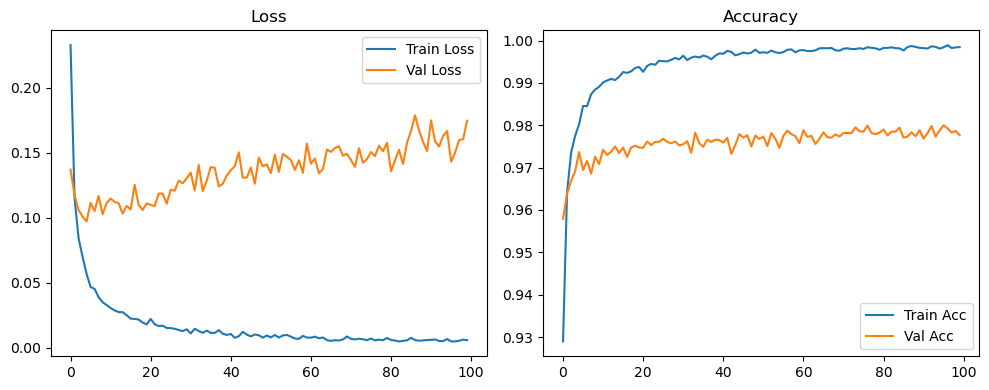

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3137, Acc: 0.9034 | Val Loss: 0.1493, Acc: 0.9550


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1690, Acc: 0.9489 | Val Loss: 0.1214, Acc: 0.9628


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1360, Acc: 0.9586 | Val Loss: 0.1174, Acc: 0.9641


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1175, Acc: 0.9632 | Val Loss: 0.1079, Acc: 0.9679


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1048, Acc: 0.9679 | Val Loss: 0.0976, Acc: 0.9706


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0925, Acc: 0.9703 | Val Loss: 0.0969, Acc: 0.9709


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0887, Acc: 0.9707 | Val Loss: 0.0951, Acc: 0.9729


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0804, Acc: 0.9736 | Val Loss: 0.1025, Acc: 0.9722


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0770, Acc: 0.9755 | Val Loss: 0.0929, Acc: 0.9737


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0684, Acc: 0.9775 | Val Loss: 0.0954, Acc: 0.9728


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0687, Acc: 0.9776 | Val Loss: 0.0949, Acc: 0.9746


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0598, Acc: 0.9800 | Val Loss: 0.0917, Acc: 0.9752


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0610, Acc: 0.9794 | Val Loss: 0.1081, Acc: 0.9717


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0607, Acc: 0.9801 | Val Loss: 0.0946, Acc: 0.9754


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0539, Acc: 0.9826 | Val Loss: 0.0905, Acc: 0.9768


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0539, Acc: 0.9822 | Val Loss: 0.0919, Acc: 0.9760


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0494, Acc: 0.9840 | Val Loss: 0.0973, Acc: 0.9754


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0489, Acc: 0.9842 | Val Loss: 0.0951, Acc: 0.9752


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0473, Acc: 0.9840 | Val Loss: 0.1015, Acc: 0.9749


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0444, Acc: 0.9853 | Val Loss: 0.0951, Acc: 0.9762


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0448, Acc: 0.9854 | Val Loss: 0.0991, Acc: 0.9762


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0425, Acc: 0.9853 | Val Loss: 0.1016, Acc: 0.9759


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0433, Acc: 0.9857 | Val Loss: 0.1054, Acc: 0.9757


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0374, Acc: 0.9876 | Val Loss: 0.0963, Acc: 0.9776


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0333, Acc: 0.9890 | Val Loss: 0.1006, Acc: 0.9766


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0358, Acc: 0.9881 | Val Loss: 0.1003, Acc: 0.9783


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0365, Acc: 0.9885 | Val Loss: 0.1051, Acc: 0.9760


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0353, Acc: 0.9885 | Val Loss: 0.1053, Acc: 0.9770


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0349, Acc: 0.9889 | Val Loss: 0.1003, Acc: 0.9764


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0347, Acc: 0.9885 | Val Loss: 0.0978, Acc: 0.9768


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0335, Acc: 0.9892 | Val Loss: 0.0982, Acc: 0.9775


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9899 | Val Loss: 0.1031, Acc: 0.9772


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9903 | Val Loss: 0.1057, Acc: 0.9780


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9907 | Val Loss: 0.1081, Acc: 0.9774


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9904 | Val Loss: 0.1101, Acc: 0.9763


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9902 | Val Loss: 0.1066, Acc: 0.9773


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9906 | Val Loss: 0.1086, Acc: 0.9775


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9906 | Val Loss: 0.1060, Acc: 0.9767


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9910 | Val Loss: 0.1048, Acc: 0.9779


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9915 | Val Loss: 0.1040, Acc: 0.9781


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0269, Acc: 0.9913 | Val Loss: 0.1061, Acc: 0.9787


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9920 | Val Loss: 0.1014, Acc: 0.9799


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9922 | Val Loss: 0.1080, Acc: 0.9770


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9920 | Val Loss: 0.1080, Acc: 0.9783


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9920 | Val Loss: 0.1111, Acc: 0.9775


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9909 | Val Loss: 0.1066, Acc: 0.9778


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9920 | Val Loss: 0.1100, Acc: 0.9788


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0231, Acc: 0.9925 | Val Loss: 0.1119, Acc: 0.9776


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9937 | Val Loss: 0.1147, Acc: 0.9782


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9927 | Val Loss: 0.1140, Acc: 0.9777


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.1094, Acc: 0.9795


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9930 | Val Loss: 0.1131, Acc: 0.9788


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9931 | Val Loss: 0.1147, Acc: 0.9790


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9931 | Val Loss: 0.1126, Acc: 0.9778


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9930 | Val Loss: 0.1149, Acc: 0.9785


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9937 | Val Loss: 0.1260, Acc: 0.9768


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9931 | Val Loss: 0.1210, Acc: 0.9772


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9929 | Val Loss: 0.1191, Acc: 0.9781


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9939 | Val Loss: 0.1223, Acc: 0.9782


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9940 | Val Loss: 0.1169, Acc: 0.9777


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9940 | Val Loss: 0.1185, Acc: 0.9766


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9937 | Val Loss: 0.1184, Acc: 0.9784


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9939 | Val Loss: 0.1218, Acc: 0.9777


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9935 | Val Loss: 0.1195, Acc: 0.9770


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.1288, Acc: 0.9773


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9945 | Val Loss: 0.1266, Acc: 0.9783


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.1308, Acc: 0.9791


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9947 | Val Loss: 0.1306, Acc: 0.9778


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.1254, Acc: 0.9804


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.1328, Acc: 0.9781


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9944 | Val Loss: 0.1262, Acc: 0.9784


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9944 | Val Loss: 0.1341, Acc: 0.9771


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9946 | Val Loss: 0.1279, Acc: 0.9784


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9946 | Val Loss: 0.1291, Acc: 0.9788


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9945 | Val Loss: 0.1307, Acc: 0.9780


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9946 | Val Loss: 0.1300, Acc: 0.9781


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.1356, Acc: 0.9773


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9953 | Val Loss: 0.1321, Acc: 0.9788


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9952 | Val Loss: 0.1385, Acc: 0.9777


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9954 | Val Loss: 0.1385, Acc: 0.9778


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9943 | Val Loss: 0.1323, Acc: 0.9784


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9943 | Val Loss: 0.1308, Acc: 0.9770


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.1332, Acc: 0.9784


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9957 | Val Loss: 0.1335, Acc: 0.9776


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9955 | Val Loss: 0.1282, Acc: 0.9773


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.1357, Acc: 0.9787


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9948 | Val Loss: 0.1325, Acc: 0.9767


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.1397, Acc: 0.9779


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.1328, Acc: 0.9798


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9955 | Val Loss: 0.1344, Acc: 0.9785


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.1373, Acc: 0.9785


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9951 | Val Loss: 0.1490, Acc: 0.9772


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9956 | Val Loss: 0.1359, Acc: 0.9785


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.1357, Acc: 0.9789


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9960 | Val Loss: 0.1384, Acc: 0.9794


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.1351, Acc: 0.9791


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9952 | Val Loss: 0.1295, Acc: 0.9787


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.1392, Acc: 0.9779


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9959 | Val Loss: 0.1280, Acc: 0.9798


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9960 | Val Loss: 0.1371, Acc: 0.9786


Final Test Loss: 0.1294 Accuracy: 0.9791


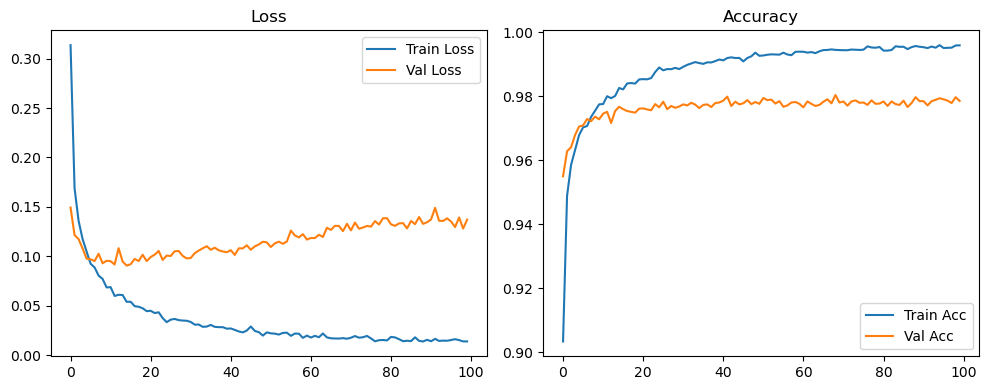

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2578, Acc: 0.9240 | Val Loss: 0.1808, Acc: 0.9486


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1248, Acc: 0.9623 | Val Loss: 0.1412, Acc: 0.9612


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0838, Acc: 0.9743 | Val Loss: 0.1231, Acc: 0.9647


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9807 | Val Loss: 0.1307, Acc: 0.9650


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9850 | Val Loss: 0.1139, Acc: 0.9698


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9865 | Val Loss: 0.1188, Acc: 0.9719


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9884 | Val Loss: 0.1243, Acc: 0.9678


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9906 | Val Loss: 0.1324, Acc: 0.9708


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9908 | Val Loss: 0.1416, Acc: 0.9698


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9927 | Val Loss: 0.1394, Acc: 0.9716


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9926 | Val Loss: 0.1472, Acc: 0.9696


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9929 | Val Loss: 0.1438, Acc: 0.9720


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9935 | Val Loss: 0.1458, Acc: 0.9723


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9948 | Val Loss: 0.1563, Acc: 0.9722


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9947 | Val Loss: 0.1626, Acc: 0.9732


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9942 | Val Loss: 0.1621, Acc: 0.9710


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9949 | Val Loss: 0.1553, Acc: 0.9743


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9952 | Val Loss: 0.1477, Acc: 0.9745


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.1439, Acc: 0.9760


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9964 | Val Loss: 0.1726, Acc: 0.9689


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9958 | Val Loss: 0.1694, Acc: 0.9726


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9956 | Val Loss: 0.1457, Acc: 0.9729


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9964 | Val Loss: 0.1387, Acc: 0.9759


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9969 | Val Loss: 0.1584, Acc: 0.9741


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.1477, Acc: 0.9742


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1743, Acc: 0.9721


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9962 | Val Loss: 0.1536, Acc: 0.9729


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.1605, Acc: 0.9739


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9971 | Val Loss: 0.1356, Acc: 0.9743


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9975 | Val Loss: 0.1362, Acc: 0.9758


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9968 | Val Loss: 0.1616, Acc: 0.9734


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9977 | Val Loss: 0.1395, Acc: 0.9768


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1453, Acc: 0.9776


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1663, Acc: 0.9760


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.1574, Acc: 0.9770


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9986 | Val Loss: 0.1639, Acc: 0.9757


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9971 | Val Loss: 0.1735, Acc: 0.9727


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1824, Acc: 0.9732


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9980 | Val Loss: 0.1602, Acc: 0.9756


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1707, Acc: 0.9734


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9979 | Val Loss: 0.1631, Acc: 0.9764


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1846, Acc: 0.9738


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1913, Acc: 0.9742


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.1647, Acc: 0.9747


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1610, Acc: 0.9769


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.1506, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1904, Acc: 0.9740


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9980 | Val Loss: 0.1473, Acc: 0.9761


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1669, Acc: 0.9769


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9985 | Val Loss: 0.1501, Acc: 0.9767


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9979 | Val Loss: 0.1785, Acc: 0.9726


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1441, Acc: 0.9767


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9992 | Val Loss: 0.1477, Acc: 0.9783


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9984 | Val Loss: 0.1679, Acc: 0.9747


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9977 | Val Loss: 0.1768, Acc: 0.9742


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9982 | Val Loss: 0.1536, Acc: 0.9762


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1560, Acc: 0.9759


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1570, Acc: 0.9772


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1785, Acc: 0.9762


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1717, Acc: 0.9770


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1847, Acc: 0.9751


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9986 | Val Loss: 0.1835, Acc: 0.9751


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9975 | Val Loss: 0.1895, Acc: 0.9744


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1421, Acc: 0.9788


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1526, Acc: 0.9780


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.1831, Acc: 0.9759


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.1418, Acc: 0.9786


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1470, Acc: 0.9788


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9993 | Val Loss: 0.1614, Acc: 0.9781


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1548, Acc: 0.9800


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1761, Acc: 0.9758


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.1851, Acc: 0.9758


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9987 | Val Loss: 0.1508, Acc: 0.9774


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9990 | Val Loss: 0.1602, Acc: 0.9781


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9983 | Val Loss: 0.1457, Acc: 0.9774


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.1462, Acc: 0.9789


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1465, Acc: 0.9797


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1639, Acc: 0.9766


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.1390, Acc: 0.9795


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1626, Acc: 0.9783


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1699, Acc: 0.9764


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1552, Acc: 0.9764


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1734, Acc: 0.9792


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.2083, Acc: 0.9768


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9985 | Val Loss: 0.1648, Acc: 0.9765


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1567, Acc: 0.9788


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1912, Acc: 0.9765


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9992 | Val Loss: 0.1623, Acc: 0.9782


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1759, Acc: 0.9752


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1669, Acc: 0.9786


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9986 | Val Loss: 0.1900, Acc: 0.9770


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1900, Acc: 0.9766


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9990 | Val Loss: 0.1817, Acc: 0.9761


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1845, Acc: 0.9769


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1800, Acc: 0.9793


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.1860, Acc: 0.9773


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1929, Acc: 0.9782


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1950, Acc: 0.9773


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1808, Acc: 0.9784


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1934, Acc: 0.9765


Final Test Loss: 0.1734 Accuracy: 0.9794


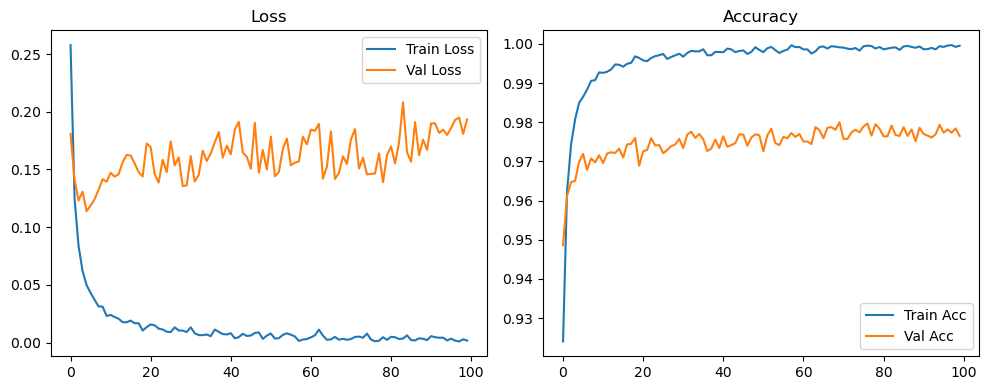

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2761, Acc: 0.9174 | Val Loss: 0.1677, Acc: 0.9513


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1416, Acc: 0.9582 | Val Loss: 0.1459, Acc: 0.9593


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1072, Acc: 0.9677 | Val Loss: 0.1328, Acc: 0.9627


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0836, Acc: 0.9746 | Val Loss: 0.1261, Acc: 0.9672


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0702, Acc: 0.9786 | Val Loss: 0.1167, Acc: 0.9669


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0594, Acc: 0.9819 | Val Loss: 0.1311, Acc: 0.9702


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0569, Acc: 0.9821 | Val Loss: 0.1171, Acc: 0.9685


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9851 | Val Loss: 0.1326, Acc: 0.9695


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9867 | Val Loss: 0.1267, Acc: 0.9723


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9871 | Val Loss: 0.1325, Acc: 0.9722


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9896 | Val Loss: 0.1416, Acc: 0.9715


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9907 | Val Loss: 0.1408, Acc: 0.9739


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9900 | Val Loss: 0.1426, Acc: 0.9704


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9911 | Val Loss: 0.1268, Acc: 0.9734


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9907 | Val Loss: 0.1350, Acc: 0.9738


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9920 | Val Loss: 0.1286, Acc: 0.9748


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9925 | Val Loss: 0.1364, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9924 | Val Loss: 0.1559, Acc: 0.9736


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9929 | Val Loss: 0.1552, Acc: 0.9747


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9937 | Val Loss: 0.1557, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9935 | Val Loss: 0.1589, Acc: 0.9746


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9936 | Val Loss: 0.1499, Acc: 0.9749


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9945 | Val Loss: 0.1650, Acc: 0.9750


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9943 | Val Loss: 0.1616, Acc: 0.9761


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9946 | Val Loss: 0.1906, Acc: 0.9725


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9942 | Val Loss: 0.1527, Acc: 0.9779


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9950 | Val Loss: 0.1431, Acc: 0.9773


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9950 | Val Loss: 0.1449, Acc: 0.9776


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9955 | Val Loss: 0.1558, Acc: 0.9742


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9949 | Val Loss: 0.1972, Acc: 0.9730


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9957 | Val Loss: 0.1884, Acc: 0.9763


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9955 | Val Loss: 0.1743, Acc: 0.9760


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9960 | Val Loss: 0.1741, Acc: 0.9762


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9960 | Val Loss: 0.1677, Acc: 0.9758


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9964 | Val Loss: 0.1912, Acc: 0.9759


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9956 | Val Loss: 0.1724, Acc: 0.9763


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9956 | Val Loss: 0.1943, Acc: 0.9751


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9947 | Val Loss: 0.1742, Acc: 0.9761


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9957 | Val Loss: 0.1599, Acc: 0.9789


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9967 | Val Loss: 0.1707, Acc: 0.9773


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9954 | Val Loss: 0.1949, Acc: 0.9766


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9964 | Val Loss: 0.1846, Acc: 0.9773


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9969 | Val Loss: 0.1982, Acc: 0.9761


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9958 | Val Loss: 0.1954, Acc: 0.9772


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9966 | Val Loss: 0.1843, Acc: 0.9778


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9973 | Val Loss: 0.2098, Acc: 0.9771


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9973 | Val Loss: 0.2200, Acc: 0.9774


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9969 | Val Loss: 0.1990, Acc: 0.9777


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9966 | Val Loss: 0.1853, Acc: 0.9794


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9973 | Val Loss: 0.2074, Acc: 0.9772


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9971 | Val Loss: 0.2399, Acc: 0.9782


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9967 | Val Loss: 0.1927, Acc: 0.9767


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9970 | Val Loss: 0.2242, Acc: 0.9759


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9968 | Val Loss: 0.1989, Acc: 0.9768


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9971 | Val Loss: 0.2113, Acc: 0.9772


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9969 | Val Loss: 0.2107, Acc: 0.9776


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9973 | Val Loss: 0.1884, Acc: 0.9792


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9974 | Val Loss: 0.2190, Acc: 0.9772


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9980 | Val Loss: 0.2237, Acc: 0.9767


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9979 | Val Loss: 0.2119, Acc: 0.9771


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9975 | Val Loss: 0.2355, Acc: 0.9767


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9968 | Val Loss: 0.2026, Acc: 0.9776


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9974 | Val Loss: 0.1924, Acc: 0.9778


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9970 | Val Loss: 0.2226, Acc: 0.9762


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9975 | Val Loss: 0.2101, Acc: 0.9785


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9979 | Val Loss: 0.2303, Acc: 0.9772


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9979 | Val Loss: 0.2395, Acc: 0.9777


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9976 | Val Loss: 0.2572, Acc: 0.9755


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9965 | Val Loss: 0.2320, Acc: 0.9748


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9973 | Val Loss: 0.2431, Acc: 0.9775


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9975 | Val Loss: 0.2303, Acc: 0.9786


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9978 | Val Loss: 0.2291, Acc: 0.9787


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9980 | Val Loss: 0.2736, Acc: 0.9775


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9980 | Val Loss: 0.2347, Acc: 0.9781


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9981 | Val Loss: 0.2486, Acc: 0.9786


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9973 | Val Loss: 0.2402, Acc: 0.9765


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9982 | Val Loss: 0.2448, Acc: 0.9790


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9980 | Val Loss: 0.2434, Acc: 0.9777


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9980 | Val Loss: 0.2817, Acc: 0.9768


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9973 | Val Loss: 0.2752, Acc: 0.9752


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9972 | Val Loss: 0.2369, Acc: 0.9779


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9980 | Val Loss: 0.2308, Acc: 0.9798


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9982 | Val Loss: 0.2288, Acc: 0.9793


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9983 | Val Loss: 0.2379, Acc: 0.9801


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9978 | Val Loss: 0.2436, Acc: 0.9788


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9983 | Val Loss: 0.2577, Acc: 0.9758


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9988 | Val Loss: 0.2560, Acc: 0.9778


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9979 | Val Loss: 0.2583, Acc: 0.9770


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9976 | Val Loss: 0.2735, Acc: 0.9782


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9982 | Val Loss: 0.2846, Acc: 0.9760


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9981 | Val Loss: 0.2675, Acc: 0.9788


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9986 | Val Loss: 0.2899, Acc: 0.9772


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9981 | Val Loss: 0.2797, Acc: 0.9784


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9980 | Val Loss: 0.2463, Acc: 0.9785


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9980 | Val Loss: 0.2523, Acc: 0.9782


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9986 | Val Loss: 0.2535, Acc: 0.9795


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9978 | Val Loss: 0.3099, Acc: 0.9779


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9984 | Val Loss: 0.2860, Acc: 0.9774


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9984 | Val Loss: 0.2615, Acc: 0.9790


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9985 | Val Loss: 0.2753, Acc: 0.9782


Final Test Loss: 0.2377 Accuracy: 0.9819


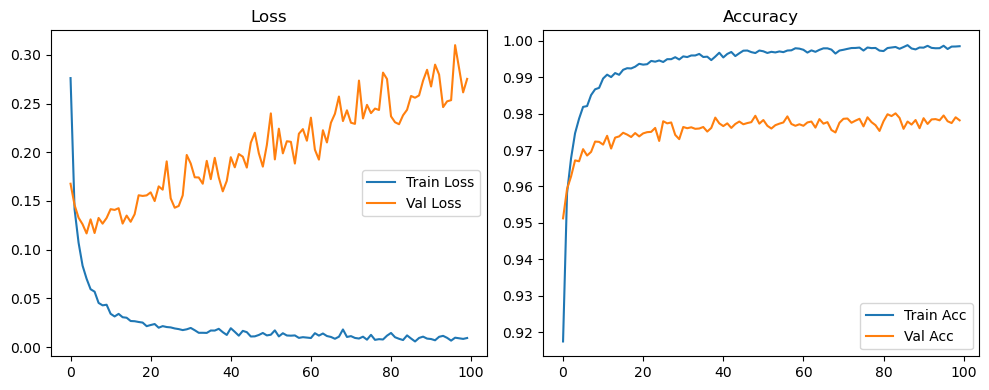

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3401, Acc: 0.8992 | Val Loss: 0.1701, Acc: 0.9517


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2060, Acc: 0.9407 | Val Loss: 0.1418, Acc: 0.9593


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1675, Acc: 0.9517 | Val Loss: 0.1396, Acc: 0.9607


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1425, Acc: 0.9577 | Val Loss: 0.1269, Acc: 0.9678


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1296, Acc: 0.9628 | Val Loss: 0.1216, Acc: 0.9660


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1136, Acc: 0.9662 | Val Loss: 0.1210, Acc: 0.9692


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1082, Acc: 0.9688 | Val Loss: 0.1136, Acc: 0.9722


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0964, Acc: 0.9716 | Val Loss: 0.1266, Acc: 0.9700


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0937, Acc: 0.9731 | Val Loss: 0.1182, Acc: 0.9738


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0875, Acc: 0.9753 | Val Loss: 0.1062, Acc: 0.9750


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0816, Acc: 0.9768 | Val Loss: 0.1267, Acc: 0.9742


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0814, Acc: 0.9772 | Val Loss: 0.1235, Acc: 0.9741


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9786 | Val Loss: 0.1261, Acc: 0.9724


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0741, Acc: 0.9796 | Val Loss: 0.1325, Acc: 0.9730


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0675, Acc: 0.9809 | Val Loss: 0.1363, Acc: 0.9748


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0726, Acc: 0.9799 | Val Loss: 0.1309, Acc: 0.9738


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9814 | Val Loss: 0.1353, Acc: 0.9762


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9824 | Val Loss: 0.1367, Acc: 0.9761


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9836 | Val Loss: 0.1284, Acc: 0.9768


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0590, Acc: 0.9835 | Val Loss: 0.1317, Acc: 0.9768


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9842 | Val Loss: 0.1539, Acc: 0.9748


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0619, Acc: 0.9838 | Val Loss: 0.1398, Acc: 0.9759


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9864 | Val Loss: 0.1395, Acc: 0.9768


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0490, Acc: 0.9869 | Val Loss: 0.1398, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9863 | Val Loss: 0.1571, Acc: 0.9760


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9865 | Val Loss: 0.1558, Acc: 0.9770


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9875 | Val Loss: 0.1509, Acc: 0.9753


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9883 | Val Loss: 0.1595, Acc: 0.9764


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9862 | Val Loss: 0.1621, Acc: 0.9762


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9885 | Val Loss: 0.1776, Acc: 0.9761


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9879 | Val Loss: 0.1767, Acc: 0.9775


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9868 | Val Loss: 0.1817, Acc: 0.9762


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9878 | Val Loss: 0.1557, Acc: 0.9777


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0530, Acc: 0.9879 | Val Loss: 0.1795, Acc: 0.9758


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9899 | Val Loss: 0.1738, Acc: 0.9781


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9893 | Val Loss: 0.1684, Acc: 0.9784


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9908 | Val Loss: 0.1733, Acc: 0.9785


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9899 | Val Loss: 0.1842, Acc: 0.9761


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9899 | Val Loss: 0.1862, Acc: 0.9782


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9905 | Val Loss: 0.2006, Acc: 0.9767


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9897 | Val Loss: 0.1617, Acc: 0.9792


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9915 | Val Loss: 0.1772, Acc: 0.9779


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9900 | Val Loss: 0.1735, Acc: 0.9785


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9916 | Val Loss: 0.1903, Acc: 0.9790


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9912 | Val Loss: 0.1810, Acc: 0.9796


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9929 | Val Loss: 0.2018, Acc: 0.9781


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9916 | Val Loss: 0.1899, Acc: 0.9781


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9916 | Val Loss: 0.1935, Acc: 0.9793


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9915 | Val Loss: 0.1952, Acc: 0.9792


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9916 | Val Loss: 0.2024, Acc: 0.9780


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9908 | Val Loss: 0.2090, Acc: 0.9788


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9917 | Val Loss: 0.2086, Acc: 0.9774


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9924 | Val Loss: 0.2345, Acc: 0.9793


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9923 | Val Loss: 0.2266, Acc: 0.9783


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9922 | Val Loss: 0.2185, Acc: 0.9774


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9931 | Val Loss: 0.2253, Acc: 0.9795


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9925 | Val Loss: 0.2229, Acc: 0.9787


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9925 | Val Loss: 0.2003, Acc: 0.9798


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9932 | Val Loss: 0.2086, Acc: 0.9772


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9935 | Val Loss: 0.2186, Acc: 0.9789


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9917 | Val Loss: 0.2217, Acc: 0.9782


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9926 | Val Loss: 0.2520, Acc: 0.9774


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9935 | Val Loss: 0.2254, Acc: 0.9776


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9927 | Val Loss: 0.2260, Acc: 0.9797


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9931 | Val Loss: 0.2542, Acc: 0.9771


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9935 | Val Loss: 0.2523, Acc: 0.9789


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9929 | Val Loss: 0.2318, Acc: 0.9791


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9937 | Val Loss: 0.2408, Acc: 0.9792


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9934 | Val Loss: 0.2273, Acc: 0.9794


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9933 | Val Loss: 0.2405, Acc: 0.9790


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9928 | Val Loss: 0.2266, Acc: 0.9793


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9946 | Val Loss: 0.2518, Acc: 0.9792


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9941 | Val Loss: 0.2682, Acc: 0.9788


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9947 | Val Loss: 0.2608, Acc: 0.9792


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9941 | Val Loss: 0.2749, Acc: 0.9802


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9948 | Val Loss: 0.2822, Acc: 0.9795


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9937 | Val Loss: 0.2723, Acc: 0.9787


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9944 | Val Loss: 0.2985, Acc: 0.9784


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9943 | Val Loss: 0.2793, Acc: 0.9799


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9950 | Val Loss: 0.2917, Acc: 0.9782


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9945 | Val Loss: 0.2930, Acc: 0.9794


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9942 | Val Loss: 0.2779, Acc: 0.9773


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9941 | Val Loss: 0.2575, Acc: 0.9800


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9946 | Val Loss: 0.2954, Acc: 0.9795


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9946 | Val Loss: 0.2543, Acc: 0.9791


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9939 | Val Loss: 0.2866, Acc: 0.9792


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9952 | Val Loss: 0.2522, Acc: 0.9789


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9944 | Val Loss: 0.2622, Acc: 0.9792


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9951 | Val Loss: 0.2908, Acc: 0.9783


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9946 | Val Loss: 0.2623, Acc: 0.9803


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9945 | Val Loss: 0.3020, Acc: 0.9788


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9947 | Val Loss: 0.2767, Acc: 0.9808


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9946 | Val Loss: 0.3178, Acc: 0.9803


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9949 | Val Loss: 0.2793, Acc: 0.9798


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9955 | Val Loss: 0.3083, Acc: 0.9814


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9953 | Val Loss: 0.3302, Acc: 0.9800


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9953 | Val Loss: 0.3154, Acc: 0.9797


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9950 | Val Loss: 0.2738, Acc: 0.9802


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9950 | Val Loss: 0.3046, Acc: 0.9805


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9958 | Val Loss: 0.2694, Acc: 0.9792


Final Test Loss: 0.2336 Accuracy: 0.9838


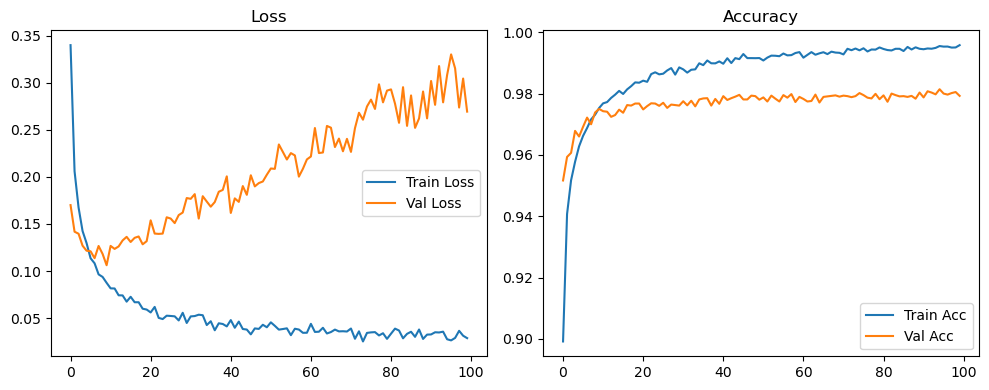

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2578, Acc: 0.9240 | Val Loss: 0.1808, Acc: 0.9486


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1248, Acc: 0.9623 | Val Loss: 0.1412, Acc: 0.9612


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0838, Acc: 0.9743 | Val Loss: 0.1231, Acc: 0.9647


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9807 | Val Loss: 0.1307, Acc: 0.9650


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9850 | Val Loss: 0.1139, Acc: 0.9698


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9865 | Val Loss: 0.1188, Acc: 0.9719


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9884 | Val Loss: 0.1243, Acc: 0.9678


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9906 | Val Loss: 0.1324, Acc: 0.9708


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9908 | Val Loss: 0.1416, Acc: 0.9698


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9927 | Val Loss: 0.1394, Acc: 0.9716


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9926 | Val Loss: 0.1472, Acc: 0.9696


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9929 | Val Loss: 0.1438, Acc: 0.9720


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9935 | Val Loss: 0.1458, Acc: 0.9723


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9948 | Val Loss: 0.1563, Acc: 0.9722


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9947 | Val Loss: 0.1626, Acc: 0.9732


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9942 | Val Loss: 0.1621, Acc: 0.9710


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9949 | Val Loss: 0.1553, Acc: 0.9743


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9952 | Val Loss: 0.1477, Acc: 0.9745


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.1439, Acc: 0.9760


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9964 | Val Loss: 0.1726, Acc: 0.9689


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9958 | Val Loss: 0.1694, Acc: 0.9726


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9956 | Val Loss: 0.1457, Acc: 0.9729


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9964 | Val Loss: 0.1387, Acc: 0.9759


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9969 | Val Loss: 0.1584, Acc: 0.9741


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.1477, Acc: 0.9742


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1743, Acc: 0.9721


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9962 | Val Loss: 0.1536, Acc: 0.9729


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.1605, Acc: 0.9739


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9971 | Val Loss: 0.1356, Acc: 0.9743


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9975 | Val Loss: 0.1362, Acc: 0.9758


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9968 | Val Loss: 0.1616, Acc: 0.9734


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9977 | Val Loss: 0.1395, Acc: 0.9768


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1453, Acc: 0.9776


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1663, Acc: 0.9760


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.1574, Acc: 0.9770


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9986 | Val Loss: 0.1639, Acc: 0.9757


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9971 | Val Loss: 0.1735, Acc: 0.9727


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1824, Acc: 0.9732


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9980 | Val Loss: 0.1602, Acc: 0.9756


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1707, Acc: 0.9734


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9979 | Val Loss: 0.1631, Acc: 0.9764


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1846, Acc: 0.9738


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1913, Acc: 0.9742


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.1647, Acc: 0.9747


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1610, Acc: 0.9769


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.1506, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1904, Acc: 0.9740


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9980 | Val Loss: 0.1473, Acc: 0.9761


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1669, Acc: 0.9769


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9985 | Val Loss: 0.1501, Acc: 0.9767


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1308, Acc: 0.9792


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1350, Acc: 0.9782


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1392, Acc: 0.9797


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1355, Acc: 0.9802


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1429, Acc: 0.9798


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1529, Acc: 0.9800


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.1481, Acc: 0.9793


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1469, Acc: 0.9807


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1526, Acc: 0.9797


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1669, Acc: 0.9790


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9999 | Val Loss: 0.1506, Acc: 0.9808


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1736, Acc: 0.9778


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1708, Acc: 0.9783


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1561, Acc: 0.9783


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1765, Acc: 0.9782


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1650, Acc: 0.9788


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1547, Acc: 0.9802


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1608, Acc: 0.9793


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9996 | Val Loss: 0.1565, Acc: 0.9799


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1537, Acc: 0.9801


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1645, Acc: 0.9781


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1665, Acc: 0.9779


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1735, Acc: 0.9788


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1715, Acc: 0.9796


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1778, Acc: 0.9785


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9993 | Val Loss: 0.1604, Acc: 0.9782


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1709, Acc: 0.9782


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1891, Acc: 0.9784


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1926, Acc: 0.9775


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1797, Acc: 0.9780


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1708, Acc: 0.9789


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1664, Acc: 0.9797


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1624, Acc: 0.9799


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1641, Acc: 0.9805


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1607, Acc: 0.9802


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1650, Acc: 0.9801


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1657, Acc: 0.9795


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1619, Acc: 0.9798


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1670, Acc: 0.9802


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1649, Acc: 0.9802


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1603, Acc: 0.9811


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1720, Acc: 0.9800


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1729, Acc: 0.9795


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1720, Acc: 0.9802


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1746, Acc: 0.9803


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1834, Acc: 0.9793


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1811, Acc: 0.9785


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1835, Acc: 0.9792


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1770, Acc: 0.9795


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1772, Acc: 0.9802


Final Test Loss: 0.1732 Accuracy: 0.9823


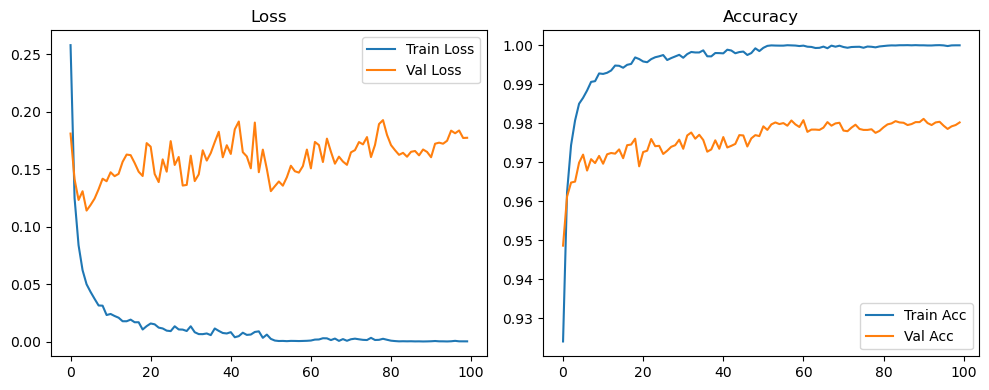

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2761, Acc: 0.9174 | Val Loss: 0.1677, Acc: 0.9513


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1416, Acc: 0.9582 | Val Loss: 0.1459, Acc: 0.9593


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1072, Acc: 0.9677 | Val Loss: 0.1328, Acc: 0.9627


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0836, Acc: 0.9746 | Val Loss: 0.1261, Acc: 0.9672


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0702, Acc: 0.9786 | Val Loss: 0.1167, Acc: 0.9669


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0594, Acc: 0.9819 | Val Loss: 0.1311, Acc: 0.9702


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0569, Acc: 0.9821 | Val Loss: 0.1171, Acc: 0.9685


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9851 | Val Loss: 0.1326, Acc: 0.9695


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9867 | Val Loss: 0.1267, Acc: 0.9723


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9871 | Val Loss: 0.1325, Acc: 0.9722


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9896 | Val Loss: 0.1416, Acc: 0.9715


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9907 | Val Loss: 0.1408, Acc: 0.9739


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9900 | Val Loss: 0.1426, Acc: 0.9704


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9911 | Val Loss: 0.1268, Acc: 0.9734


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9907 | Val Loss: 0.1350, Acc: 0.9738


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9920 | Val Loss: 0.1286, Acc: 0.9748


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9925 | Val Loss: 0.1364, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9924 | Val Loss: 0.1559, Acc: 0.9736


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9929 | Val Loss: 0.1552, Acc: 0.9747


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9937 | Val Loss: 0.1557, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9935 | Val Loss: 0.1589, Acc: 0.9746


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9936 | Val Loss: 0.1499, Acc: 0.9749


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9945 | Val Loss: 0.1650, Acc: 0.9750


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9943 | Val Loss: 0.1616, Acc: 0.9761


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9946 | Val Loss: 0.1906, Acc: 0.9725


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9942 | Val Loss: 0.1527, Acc: 0.9779


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9950 | Val Loss: 0.1431, Acc: 0.9773


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9950 | Val Loss: 0.1449, Acc: 0.9776


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9955 | Val Loss: 0.1558, Acc: 0.9742


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9949 | Val Loss: 0.1972, Acc: 0.9730


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9957 | Val Loss: 0.1884, Acc: 0.9763


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9955 | Val Loss: 0.1743, Acc: 0.9760


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9960 | Val Loss: 0.1741, Acc: 0.9762


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9960 | Val Loss: 0.1677, Acc: 0.9758


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9964 | Val Loss: 0.1912, Acc: 0.9759


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9956 | Val Loss: 0.1724, Acc: 0.9763


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9956 | Val Loss: 0.1943, Acc: 0.9751


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9947 | Val Loss: 0.1742, Acc: 0.9761


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9957 | Val Loss: 0.1599, Acc: 0.9789


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9967 | Val Loss: 0.1707, Acc: 0.9773


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9954 | Val Loss: 0.1949, Acc: 0.9766


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9964 | Val Loss: 0.1846, Acc: 0.9773


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9969 | Val Loss: 0.1982, Acc: 0.9761


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9958 | Val Loss: 0.1954, Acc: 0.9772


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9966 | Val Loss: 0.1843, Acc: 0.9778


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9973 | Val Loss: 0.2098, Acc: 0.9771


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9973 | Val Loss: 0.2200, Acc: 0.9774


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9969 | Val Loss: 0.1990, Acc: 0.9777


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9966 | Val Loss: 0.1853, Acc: 0.9794


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9973 | Val Loss: 0.2074, Acc: 0.9772


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.1913, Acc: 0.9796


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9989 | Val Loss: 0.1787, Acc: 0.9790


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1864, Acc: 0.9803


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1830, Acc: 0.9806


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1982, Acc: 0.9796


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.2032, Acc: 0.9798


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1893, Acc: 0.9808


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1918, Acc: 0.9802


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.2042, Acc: 0.9808


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.2357, Acc: 0.9796


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.2195, Acc: 0.9787


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9989 | Val Loss: 0.2210, Acc: 0.9808


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9990 | Val Loss: 0.1995, Acc: 0.9789


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9990 | Val Loss: 0.2048, Acc: 0.9791


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9990 | Val Loss: 0.2164, Acc: 0.9800


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.2188, Acc: 0.9781


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.2316, Acc: 0.9790


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.2454, Acc: 0.9793


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9989 | Val Loss: 0.2405, Acc: 0.9791


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.2159, Acc: 0.9802


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9991 | Val Loss: 0.2191, Acc: 0.9804


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.2394, Acc: 0.9798


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.2338, Acc: 0.9809


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9993 | Val Loss: 0.2324, Acc: 0.9804


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9991 | Val Loss: 0.2388, Acc: 0.9798


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9989 | Val Loss: 0.2459, Acc: 0.9788


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9991 | Val Loss: 0.2278, Acc: 0.9790


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9992 | Val Loss: 0.2218, Acc: 0.9808


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.2262, Acc: 0.9789


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.2242, Acc: 0.9804


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9994 | Val Loss: 0.2065, Acc: 0.9814


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.2168, Acc: 0.9818


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.2091, Acc: 0.9818


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.2057, Acc: 0.9819


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.2110, Acc: 0.9814


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.2191, Acc: 0.9799


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.2128, Acc: 0.9808


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.2193, Acc: 0.9810


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2224, Acc: 0.9808


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9998 | Val Loss: 0.2187, Acc: 0.9822


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.2152, Acc: 0.9812


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2184, Acc: 0.9808


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2196, Acc: 0.9817


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2210, Acc: 0.9820


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.2354, Acc: 0.9808


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2383, Acc: 0.9807


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.2416, Acc: 0.9805


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.2425, Acc: 0.9808


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.2484, Acc: 0.9804


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2404, Acc: 0.9810


Final Test Loss: 0.1908 Accuracy: 0.9833


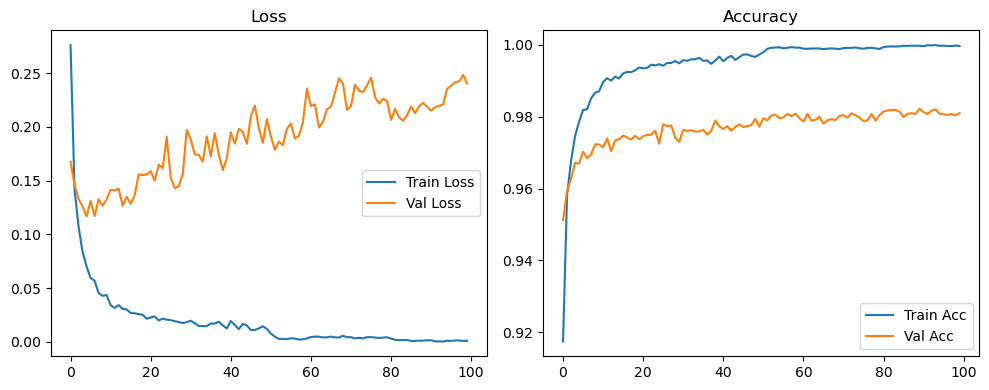

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3401, Acc: 0.8992 | Val Loss: 0.1701, Acc: 0.9517


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2060, Acc: 0.9407 | Val Loss: 0.1418, Acc: 0.9593


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1675, Acc: 0.9517 | Val Loss: 0.1396, Acc: 0.9607


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1425, Acc: 0.9577 | Val Loss: 0.1269, Acc: 0.9678


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1296, Acc: 0.9628 | Val Loss: 0.1216, Acc: 0.9660


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1136, Acc: 0.9662 | Val Loss: 0.1210, Acc: 0.9692


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1082, Acc: 0.9688 | Val Loss: 0.1136, Acc: 0.9722


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0964, Acc: 0.9716 | Val Loss: 0.1266, Acc: 0.9700


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0937, Acc: 0.9731 | Val Loss: 0.1182, Acc: 0.9738


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0875, Acc: 0.9753 | Val Loss: 0.1062, Acc: 0.9750


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0816, Acc: 0.9768 | Val Loss: 0.1267, Acc: 0.9742


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0814, Acc: 0.9772 | Val Loss: 0.1235, Acc: 0.9741


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9786 | Val Loss: 0.1261, Acc: 0.9724


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0741, Acc: 0.9796 | Val Loss: 0.1325, Acc: 0.9730


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0675, Acc: 0.9809 | Val Loss: 0.1363, Acc: 0.9748


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0726, Acc: 0.9799 | Val Loss: 0.1309, Acc: 0.9738


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9814 | Val Loss: 0.1353, Acc: 0.9762


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9824 | Val Loss: 0.1367, Acc: 0.9761


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9836 | Val Loss: 0.1284, Acc: 0.9768


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0590, Acc: 0.9835 | Val Loss: 0.1317, Acc: 0.9768


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9842 | Val Loss: 0.1539, Acc: 0.9748


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0619, Acc: 0.9838 | Val Loss: 0.1398, Acc: 0.9759


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9864 | Val Loss: 0.1395, Acc: 0.9768


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0490, Acc: 0.9869 | Val Loss: 0.1398, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9863 | Val Loss: 0.1571, Acc: 0.9760


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9865 | Val Loss: 0.1558, Acc: 0.9770


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9875 | Val Loss: 0.1509, Acc: 0.9753


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9883 | Val Loss: 0.1595, Acc: 0.9764


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9862 | Val Loss: 0.1621, Acc: 0.9762


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9885 | Val Loss: 0.1776, Acc: 0.9761


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9879 | Val Loss: 0.1767, Acc: 0.9775


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9868 | Val Loss: 0.1817, Acc: 0.9762


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9878 | Val Loss: 0.1557, Acc: 0.9777


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0530, Acc: 0.9879 | Val Loss: 0.1795, Acc: 0.9758


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9899 | Val Loss: 0.1738, Acc: 0.9781


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9893 | Val Loss: 0.1684, Acc: 0.9784


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9908 | Val Loss: 0.1733, Acc: 0.9785


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9899 | Val Loss: 0.1842, Acc: 0.9761


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9899 | Val Loss: 0.1862, Acc: 0.9782


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9905 | Val Loss: 0.2006, Acc: 0.9767


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9897 | Val Loss: 0.1617, Acc: 0.9792


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9915 | Val Loss: 0.1772, Acc: 0.9779


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9900 | Val Loss: 0.1735, Acc: 0.9785


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9916 | Val Loss: 0.1903, Acc: 0.9790


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9912 | Val Loss: 0.1810, Acc: 0.9796


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9929 | Val Loss: 0.2018, Acc: 0.9781


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9916 | Val Loss: 0.1899, Acc: 0.9781


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9916 | Val Loss: 0.1935, Acc: 0.9793


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9915 | Val Loss: 0.1952, Acc: 0.9792


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9916 | Val Loss: 0.2024, Acc: 0.9780


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9934 | Val Loss: 0.1723, Acc: 0.9806


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9951 | Val Loss: 0.1800, Acc: 0.9808


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9960 | Val Loss: 0.1798, Acc: 0.9820


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9959 | Val Loss: 0.1944, Acc: 0.9819


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9961 | Val Loss: 0.1907, Acc: 0.9798


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9965 | Val Loss: 0.1983, Acc: 0.9813


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9961 | Val Loss: 0.1810, Acc: 0.9813


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9970 | Val Loss: 0.1901, Acc: 0.9806


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9969 | Val Loss: 0.2060, Acc: 0.9789


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9966 | Val Loss: 0.2018, Acc: 0.9799


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9962 | Val Loss: 0.1964, Acc: 0.9798


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9962 | Val Loss: 0.1878, Acc: 0.9805


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9969 | Val Loss: 0.2024, Acc: 0.9808


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9968 | Val Loss: 0.2321, Acc: 0.9802


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9971 | Val Loss: 0.2254, Acc: 0.9802


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9965 | Val Loss: 0.2305, Acc: 0.9800


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9964 | Val Loss: 0.2027, Acc: 0.9801


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9962 | Val Loss: 0.2026, Acc: 0.9814


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9969 | Val Loss: 0.2175, Acc: 0.9797


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9968 | Val Loss: 0.2237, Acc: 0.9805


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9972 | Val Loss: 0.2162, Acc: 0.9799


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9972 | Val Loss: 0.2212, Acc: 0.9814


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9970 | Val Loss: 0.2368, Acc: 0.9804


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9970 | Val Loss: 0.2120, Acc: 0.9812


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9965 | Val Loss: 0.2374, Acc: 0.9792


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9968 | Val Loss: 0.2444, Acc: 0.9795


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9967 | Val Loss: 0.2512, Acc: 0.9805


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9968 | Val Loss: 0.2553, Acc: 0.9808


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9970 | Val Loss: 0.2354, Acc: 0.9807


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9965 | Val Loss: 0.2522, Acc: 0.9796


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9977 | Val Loss: 0.2343, Acc: 0.9805


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9979 | Val Loss: 0.2212, Acc: 0.9812


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9980 | Val Loss: 0.2281, Acc: 0.9821


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9979 | Val Loss: 0.2340, Acc: 0.9818


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9980 | Val Loss: 0.2441, Acc: 0.9810


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9979 | Val Loss: 0.2379, Acc: 0.9810


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9985 | Val Loss: 0.2345, Acc: 0.9818


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9982 | Val Loss: 0.2387, Acc: 0.9809


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9984 | Val Loss: 0.2317, Acc: 0.9814


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9983 | Val Loss: 0.2288, Acc: 0.9820


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9986 | Val Loss: 0.2255, Acc: 0.9812


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9987 | Val Loss: 0.2400, Acc: 0.9815


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9987 | Val Loss: 0.2284, Acc: 0.9813


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.2305, Acc: 0.9816


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9989 | Val Loss: 0.2355, Acc: 0.9810


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9988 | Val Loss: 0.2326, Acc: 0.9812


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9986 | Val Loss: 0.2436, Acc: 0.9807


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9986 | Val Loss: 0.2265, Acc: 0.9821


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9988 | Val Loss: 0.2263, Acc: 0.9818


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.2289, Acc: 0.9819


Final Test Loss: 0.2118 Accuracy: 0.9842


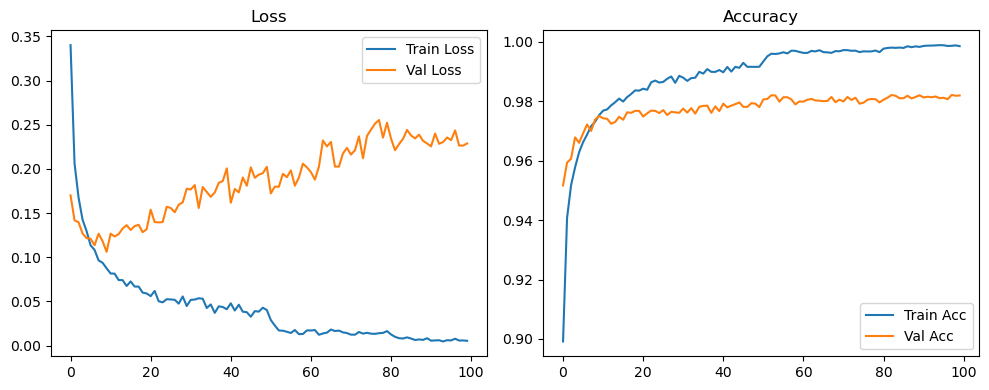

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2578, Acc: 0.9240 | Val Loss: 0.1808, Acc: 0.9486


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1248, Acc: 0.9623 | Val Loss: 0.1412, Acc: 0.9612


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0838, Acc: 0.9743 | Val Loss: 0.1231, Acc: 0.9647


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9807 | Val Loss: 0.1307, Acc: 0.9650


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9850 | Val Loss: 0.1139, Acc: 0.9698


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9865 | Val Loss: 0.1188, Acc: 0.9719


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9884 | Val Loss: 0.1243, Acc: 0.9678


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9906 | Val Loss: 0.1324, Acc: 0.9708


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9908 | Val Loss: 0.1416, Acc: 0.9698


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9927 | Val Loss: 0.1394, Acc: 0.9716


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9926 | Val Loss: 0.1472, Acc: 0.9696


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9929 | Val Loss: 0.1438, Acc: 0.9720


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9935 | Val Loss: 0.1458, Acc: 0.9723


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9948 | Val Loss: 0.1563, Acc: 0.9722


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9947 | Val Loss: 0.1626, Acc: 0.9732


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9942 | Val Loss: 0.1621, Acc: 0.9710


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9949 | Val Loss: 0.1553, Acc: 0.9743


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9952 | Val Loss: 0.1477, Acc: 0.9745


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.1439, Acc: 0.9760


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9964 | Val Loss: 0.1726, Acc: 0.9689


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9958 | Val Loss: 0.1694, Acc: 0.9726


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9956 | Val Loss: 0.1457, Acc: 0.9729


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9964 | Val Loss: 0.1387, Acc: 0.9759


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9969 | Val Loss: 0.1584, Acc: 0.9741


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.1477, Acc: 0.9742


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1743, Acc: 0.9721


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9962 | Val Loss: 0.1536, Acc: 0.9729


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.1605, Acc: 0.9739


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9971 | Val Loss: 0.1356, Acc: 0.9743


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9975 | Val Loss: 0.1362, Acc: 0.9758


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9968 | Val Loss: 0.1616, Acc: 0.9734


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9977 | Val Loss: 0.1395, Acc: 0.9768


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1453, Acc: 0.9776


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1663, Acc: 0.9760


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.1574, Acc: 0.9770


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9986 | Val Loss: 0.1639, Acc: 0.9757


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9971 | Val Loss: 0.1735, Acc: 0.9727


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1824, Acc: 0.9732


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9980 | Val Loss: 0.1602, Acc: 0.9756


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1707, Acc: 0.9734


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9979 | Val Loss: 0.1631, Acc: 0.9764


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1846, Acc: 0.9738


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1913, Acc: 0.9742


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.1647, Acc: 0.9747


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1610, Acc: 0.9769


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.1506, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1904, Acc: 0.9740


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9980 | Val Loss: 0.1473, Acc: 0.9761


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1669, Acc: 0.9769


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9985 | Val Loss: 0.1501, Acc: 0.9767


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1308, Acc: 0.9792


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1350, Acc: 0.9782


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1392, Acc: 0.9797


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1355, Acc: 0.9802


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1429, Acc: 0.9798


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1529, Acc: 0.9800


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.1481, Acc: 0.9793


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1469, Acc: 0.9807


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1526, Acc: 0.9797


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1669, Acc: 0.9790


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9999 | Val Loss: 0.1506, Acc: 0.9808


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1736, Acc: 0.9778


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1708, Acc: 0.9783


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1561, Acc: 0.9783


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1765, Acc: 0.9782


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1650, Acc: 0.9788


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1547, Acc: 0.9802


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1608, Acc: 0.9793


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9996 | Val Loss: 0.1565, Acc: 0.9799


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1537, Acc: 0.9801


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1645, Acc: 0.9781


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1665, Acc: 0.9779


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1735, Acc: 0.9788


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1715, Acc: 0.9796


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1778, Acc: 0.9785


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9993 | Val Loss: 0.1604, Acc: 0.9782


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1709, Acc: 0.9782


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1891, Acc: 0.9784


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1926, Acc: 0.9775


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1797, Acc: 0.9780


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1688, Acc: 0.9795


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1616, Acc: 0.9790


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1611, Acc: 0.9793


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1622, Acc: 0.9796


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1644, Acc: 0.9794


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1616, Acc: 0.9792


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1646, Acc: 0.9802


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1599, Acc: 0.9806


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1642, Acc: 0.9809


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1642, Acc: 0.9808


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1628, Acc: 0.9811


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1647, Acc: 0.9802


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1631, Acc: 0.9808


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1625, Acc: 0.9812


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1623, Acc: 0.9811


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1688, Acc: 0.9812


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1658, Acc: 0.9808


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1682, Acc: 0.9808


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1636, Acc: 0.9815


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1667, Acc: 0.9811


Final Test Loss: 0.1601 Accuracy: 0.9831


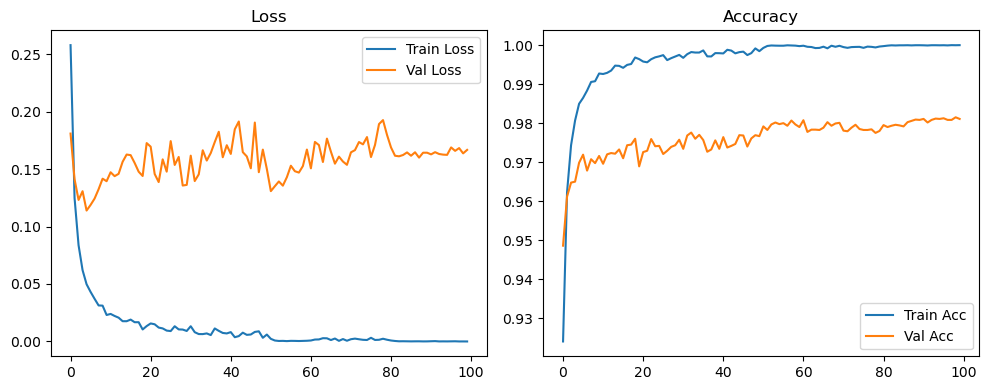

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2761, Acc: 0.9174 | Val Loss: 0.1677, Acc: 0.9513


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1416, Acc: 0.9582 | Val Loss: 0.1459, Acc: 0.9593


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1072, Acc: 0.9677 | Val Loss: 0.1328, Acc: 0.9627


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0836, Acc: 0.9746 | Val Loss: 0.1261, Acc: 0.9672


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0702, Acc: 0.9786 | Val Loss: 0.1167, Acc: 0.9669


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0594, Acc: 0.9819 | Val Loss: 0.1311, Acc: 0.9702


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0569, Acc: 0.9821 | Val Loss: 0.1171, Acc: 0.9685


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9851 | Val Loss: 0.1326, Acc: 0.9695


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9867 | Val Loss: 0.1267, Acc: 0.9723


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9871 | Val Loss: 0.1325, Acc: 0.9722


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9896 | Val Loss: 0.1416, Acc: 0.9715


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9907 | Val Loss: 0.1408, Acc: 0.9739


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9900 | Val Loss: 0.1426, Acc: 0.9704


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9911 | Val Loss: 0.1268, Acc: 0.9734


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9907 | Val Loss: 0.1350, Acc: 0.9738


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9920 | Val Loss: 0.1286, Acc: 0.9748


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9925 | Val Loss: 0.1364, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9924 | Val Loss: 0.1559, Acc: 0.9736


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9929 | Val Loss: 0.1552, Acc: 0.9747


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9937 | Val Loss: 0.1557, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9935 | Val Loss: 0.1589, Acc: 0.9746


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9936 | Val Loss: 0.1499, Acc: 0.9749


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9945 | Val Loss: 0.1650, Acc: 0.9750


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9943 | Val Loss: 0.1616, Acc: 0.9761


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9946 | Val Loss: 0.1906, Acc: 0.9725


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9942 | Val Loss: 0.1527, Acc: 0.9779


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9950 | Val Loss: 0.1431, Acc: 0.9773


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9950 | Val Loss: 0.1449, Acc: 0.9776


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9955 | Val Loss: 0.1558, Acc: 0.9742


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9949 | Val Loss: 0.1972, Acc: 0.9730


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9957 | Val Loss: 0.1884, Acc: 0.9763


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9955 | Val Loss: 0.1743, Acc: 0.9760


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9960 | Val Loss: 0.1741, Acc: 0.9762


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9960 | Val Loss: 0.1677, Acc: 0.9758


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9964 | Val Loss: 0.1912, Acc: 0.9759


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9956 | Val Loss: 0.1724, Acc: 0.9763


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9956 | Val Loss: 0.1943, Acc: 0.9751


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9947 | Val Loss: 0.1742, Acc: 0.9761


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9957 | Val Loss: 0.1599, Acc: 0.9789


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9967 | Val Loss: 0.1707, Acc: 0.9773


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9954 | Val Loss: 0.1949, Acc: 0.9766


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9964 | Val Loss: 0.1846, Acc: 0.9773


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9969 | Val Loss: 0.1982, Acc: 0.9761


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9958 | Val Loss: 0.1954, Acc: 0.9772


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9966 | Val Loss: 0.1843, Acc: 0.9778


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9973 | Val Loss: 0.2098, Acc: 0.9771


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9973 | Val Loss: 0.2200, Acc: 0.9774


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9969 | Val Loss: 0.1990, Acc: 0.9777


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9966 | Val Loss: 0.1853, Acc: 0.9794


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9973 | Val Loss: 0.2074, Acc: 0.9772


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.1913, Acc: 0.9796


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9989 | Val Loss: 0.1787, Acc: 0.9790


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1864, Acc: 0.9803


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1830, Acc: 0.9806


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1982, Acc: 0.9796


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.2032, Acc: 0.9798


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1893, Acc: 0.9808


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1918, Acc: 0.9802


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.2042, Acc: 0.9808


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.2357, Acc: 0.9796


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.2195, Acc: 0.9787


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9989 | Val Loss: 0.2210, Acc: 0.9808


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9990 | Val Loss: 0.1995, Acc: 0.9789


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9990 | Val Loss: 0.2048, Acc: 0.9791


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9990 | Val Loss: 0.2164, Acc: 0.9800


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.2188, Acc: 0.9781


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.2316, Acc: 0.9790


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.2454, Acc: 0.9793


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9989 | Val Loss: 0.2405, Acc: 0.9791


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.2159, Acc: 0.9802


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9991 | Val Loss: 0.2191, Acc: 0.9804


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.2394, Acc: 0.9798


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.2338, Acc: 0.9809


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9993 | Val Loss: 0.2324, Acc: 0.9804


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9991 | Val Loss: 0.2388, Acc: 0.9798


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9989 | Val Loss: 0.2459, Acc: 0.9788


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9991 | Val Loss: 0.2278, Acc: 0.9790


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9992 | Val Loss: 0.2218, Acc: 0.9808


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.2262, Acc: 0.9789


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.2242, Acc: 0.9804


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.2075, Acc: 0.9812


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.2085, Acc: 0.9812


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.2047, Acc: 0.9818


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.2005, Acc: 0.9823


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.2111, Acc: 0.9818


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2110, Acc: 0.9816


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.2070, Acc: 0.9821


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2062, Acc: 0.9827


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2162, Acc: 0.9821


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.2067, Acc: 0.9819


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.2064, Acc: 0.9827


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.2157, Acc: 0.9822


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.2085, Acc: 0.9830


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.2059, Acc: 0.9826


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2082, Acc: 0.9830


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2072, Acc: 0.9827


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2067, Acc: 0.9818


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2122, Acc: 0.9822


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2141, Acc: 0.9827


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2153, Acc: 0.9821


Final Test Loss: 0.1884 Accuracy: 0.9835


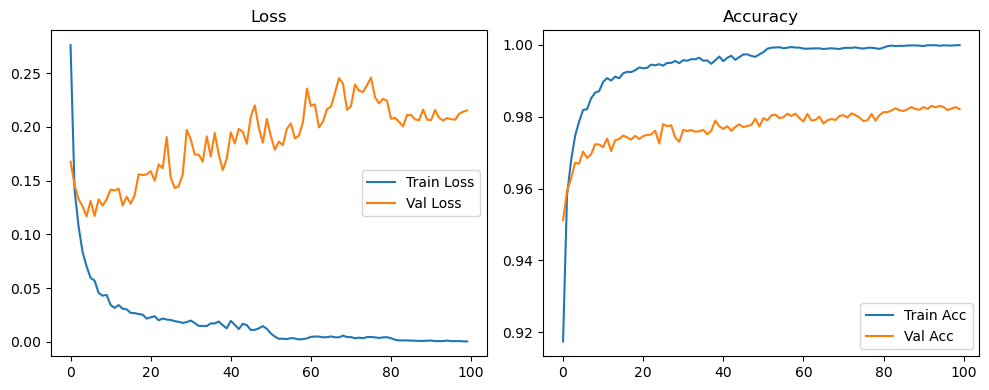

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3401, Acc: 0.8992 | Val Loss: 0.1701, Acc: 0.9517


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2060, Acc: 0.9407 | Val Loss: 0.1418, Acc: 0.9593


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1675, Acc: 0.9517 | Val Loss: 0.1396, Acc: 0.9607


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1425, Acc: 0.9577 | Val Loss: 0.1269, Acc: 0.9678


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1296, Acc: 0.9628 | Val Loss: 0.1216, Acc: 0.9660


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1136, Acc: 0.9662 | Val Loss: 0.1210, Acc: 0.9692


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1082, Acc: 0.9688 | Val Loss: 0.1136, Acc: 0.9722


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0964, Acc: 0.9716 | Val Loss: 0.1266, Acc: 0.9700


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0937, Acc: 0.9731 | Val Loss: 0.1182, Acc: 0.9738


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0875, Acc: 0.9753 | Val Loss: 0.1062, Acc: 0.9750


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0816, Acc: 0.9768 | Val Loss: 0.1267, Acc: 0.9742


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0814, Acc: 0.9772 | Val Loss: 0.1235, Acc: 0.9741


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9786 | Val Loss: 0.1261, Acc: 0.9724


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0741, Acc: 0.9796 | Val Loss: 0.1325, Acc: 0.9730


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0675, Acc: 0.9809 | Val Loss: 0.1363, Acc: 0.9748


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0726, Acc: 0.9799 | Val Loss: 0.1309, Acc: 0.9738


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9814 | Val Loss: 0.1353, Acc: 0.9762


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9824 | Val Loss: 0.1367, Acc: 0.9761


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9836 | Val Loss: 0.1284, Acc: 0.9768


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0590, Acc: 0.9835 | Val Loss: 0.1317, Acc: 0.9768


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9842 | Val Loss: 0.1539, Acc: 0.9748


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0619, Acc: 0.9838 | Val Loss: 0.1398, Acc: 0.9759


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9864 | Val Loss: 0.1395, Acc: 0.9768


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0490, Acc: 0.9869 | Val Loss: 0.1398, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9863 | Val Loss: 0.1571, Acc: 0.9760


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9865 | Val Loss: 0.1558, Acc: 0.9770


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9875 | Val Loss: 0.1509, Acc: 0.9753


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9883 | Val Loss: 0.1595, Acc: 0.9764


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9862 | Val Loss: 0.1621, Acc: 0.9762


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9885 | Val Loss: 0.1776, Acc: 0.9761


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9879 | Val Loss: 0.1767, Acc: 0.9775


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9868 | Val Loss: 0.1817, Acc: 0.9762


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9878 | Val Loss: 0.1557, Acc: 0.9777


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0530, Acc: 0.9879 | Val Loss: 0.1795, Acc: 0.9758


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9899 | Val Loss: 0.1738, Acc: 0.9781


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9893 | Val Loss: 0.1684, Acc: 0.9784


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9908 | Val Loss: 0.1733, Acc: 0.9785


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9899 | Val Loss: 0.1842, Acc: 0.9761


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9899 | Val Loss: 0.1862, Acc: 0.9782


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9905 | Val Loss: 0.2006, Acc: 0.9767


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9897 | Val Loss: 0.1617, Acc: 0.9792


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9915 | Val Loss: 0.1772, Acc: 0.9779


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9900 | Val Loss: 0.1735, Acc: 0.9785


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9916 | Val Loss: 0.1903, Acc: 0.9790


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9912 | Val Loss: 0.1810, Acc: 0.9796


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9929 | Val Loss: 0.2018, Acc: 0.9781


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9916 | Val Loss: 0.1899, Acc: 0.9781


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9916 | Val Loss: 0.1935, Acc: 0.9793


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9915 | Val Loss: 0.1952, Acc: 0.9792


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9916 | Val Loss: 0.2024, Acc: 0.9780


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9934 | Val Loss: 0.1723, Acc: 0.9806


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9951 | Val Loss: 0.1800, Acc: 0.9808


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9960 | Val Loss: 0.1798, Acc: 0.9820


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9959 | Val Loss: 0.1944, Acc: 0.9819


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9961 | Val Loss: 0.1907, Acc: 0.9798


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9965 | Val Loss: 0.1983, Acc: 0.9813


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9961 | Val Loss: 0.1810, Acc: 0.9813


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9970 | Val Loss: 0.1901, Acc: 0.9806


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9969 | Val Loss: 0.2060, Acc: 0.9789


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9966 | Val Loss: 0.2018, Acc: 0.9799


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9962 | Val Loss: 0.1964, Acc: 0.9798


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9962 | Val Loss: 0.1878, Acc: 0.9805


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9969 | Val Loss: 0.2024, Acc: 0.9808


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9968 | Val Loss: 0.2321, Acc: 0.9802


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9971 | Val Loss: 0.2254, Acc: 0.9802


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9965 | Val Loss: 0.2305, Acc: 0.9800


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9964 | Val Loss: 0.2027, Acc: 0.9801


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9962 | Val Loss: 0.2026, Acc: 0.9814


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9969 | Val Loss: 0.2175, Acc: 0.9797


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9968 | Val Loss: 0.2237, Acc: 0.9805


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9972 | Val Loss: 0.2162, Acc: 0.9799


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9972 | Val Loss: 0.2212, Acc: 0.9814


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9970 | Val Loss: 0.2368, Acc: 0.9804


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9970 | Val Loss: 0.2120, Acc: 0.9812


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9965 | Val Loss: 0.2374, Acc: 0.9792


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9968 | Val Loss: 0.2444, Acc: 0.9795


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9967 | Val Loss: 0.2512, Acc: 0.9805


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9968 | Val Loss: 0.2553, Acc: 0.9808


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9970 | Val Loss: 0.2354, Acc: 0.9807


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9965 | Val Loss: 0.2522, Acc: 0.9796


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9974 | Val Loss: 0.2310, Acc: 0.9807


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9978 | Val Loss: 0.2218, Acc: 0.9812


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9980 | Val Loss: 0.2263, Acc: 0.9815


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9980 | Val Loss: 0.2243, Acc: 0.9818


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9980 | Val Loss: 0.2336, Acc: 0.9812


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9982 | Val Loss: 0.2294, Acc: 0.9811


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9984 | Val Loss: 0.2323, Acc: 0.9813


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9983 | Val Loss: 0.2247, Acc: 0.9820


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9986 | Val Loss: 0.2251, Acc: 0.9817


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9983 | Val Loss: 0.2226, Acc: 0.9818


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9987 | Val Loss: 0.2183, Acc: 0.9821


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9985 | Val Loss: 0.2309, Acc: 0.9822


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9990 | Val Loss: 0.2192, Acc: 0.9822


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.2235, Acc: 0.9823


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9984 | Val Loss: 0.2294, Acc: 0.9818


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.2270, Acc: 0.9818


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9986 | Val Loss: 0.2299, Acc: 0.9820


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9986 | Val Loss: 0.2235, Acc: 0.9827


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9987 | Val Loss: 0.2254, Acc: 0.9819


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.2186, Acc: 0.9819


Final Test Loss: 0.2134 Accuracy: 0.9841


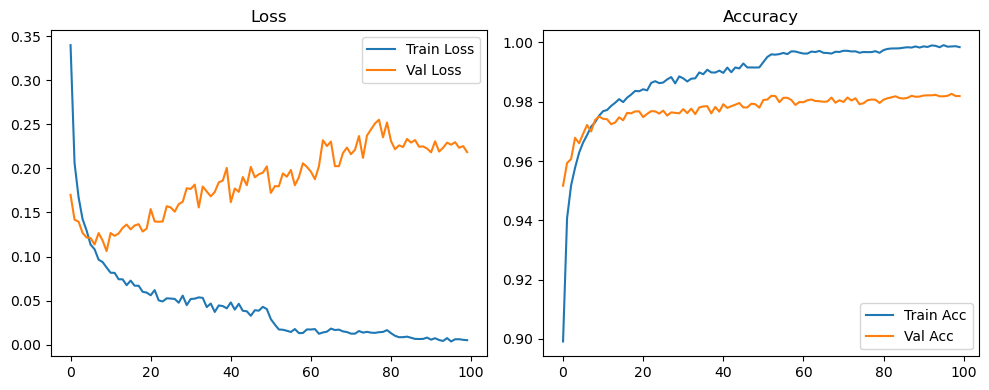

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2578, Acc: 0.9240 | Val Loss: 0.1808, Acc: 0.9486


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1248, Acc: 0.9623 | Val Loss: 0.1412, Acc: 0.9612


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0838, Acc: 0.9743 | Val Loss: 0.1231, Acc: 0.9647


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9807 | Val Loss: 0.1307, Acc: 0.9650


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9850 | Val Loss: 0.1139, Acc: 0.9698


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9865 | Val Loss: 0.1188, Acc: 0.9719


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9884 | Val Loss: 0.1243, Acc: 0.9678


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9906 | Val Loss: 0.1324, Acc: 0.9708


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9908 | Val Loss: 0.1416, Acc: 0.9698


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9927 | Val Loss: 0.1394, Acc: 0.9716


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9926 | Val Loss: 0.1472, Acc: 0.9696


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9929 | Val Loss: 0.1438, Acc: 0.9720


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9935 | Val Loss: 0.1458, Acc: 0.9723


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9948 | Val Loss: 0.1563, Acc: 0.9722


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9947 | Val Loss: 0.1626, Acc: 0.9732


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9942 | Val Loss: 0.1621, Acc: 0.9710


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9949 | Val Loss: 0.1553, Acc: 0.9743


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9952 | Val Loss: 0.1477, Acc: 0.9745


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.1439, Acc: 0.9760


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9964 | Val Loss: 0.1726, Acc: 0.9689


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9958 | Val Loss: 0.1694, Acc: 0.9726


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9956 | Val Loss: 0.1457, Acc: 0.9729


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9964 | Val Loss: 0.1387, Acc: 0.9759


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9969 | Val Loss: 0.1584, Acc: 0.9741


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.1477, Acc: 0.9742


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1743, Acc: 0.9721


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9962 | Val Loss: 0.1536, Acc: 0.9729


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.1605, Acc: 0.9739


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9971 | Val Loss: 0.1356, Acc: 0.9743


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9975 | Val Loss: 0.1362, Acc: 0.9758


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9968 | Val Loss: 0.1616, Acc: 0.9734


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9977 | Val Loss: 0.1395, Acc: 0.9768


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1453, Acc: 0.9776


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1663, Acc: 0.9760


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.1574, Acc: 0.9770


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9986 | Val Loss: 0.1639, Acc: 0.9757


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9971 | Val Loss: 0.1735, Acc: 0.9727


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1824, Acc: 0.9732


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9980 | Val Loss: 0.1602, Acc: 0.9756


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1707, Acc: 0.9734


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9979 | Val Loss: 0.1631, Acc: 0.9764


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1846, Acc: 0.9738


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1913, Acc: 0.9742


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.1647, Acc: 0.9747


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1610, Acc: 0.9769


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.1506, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1904, Acc: 0.9740


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9980 | Val Loss: 0.1473, Acc: 0.9761


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1669, Acc: 0.9769


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9985 | Val Loss: 0.1501, Acc: 0.9767


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1278, Acc: 0.9788


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1296, Acc: 0.9788


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1313, Acc: 0.9790


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1304, Acc: 0.9795


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1346, Acc: 0.9800


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1360, Acc: 0.9793


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1365, Acc: 0.9798


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1397, Acc: 0.9799


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1387, Acc: 0.9807


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1391, Acc: 0.9799


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1415, Acc: 0.9800


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1422, Acc: 0.9804


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1408, Acc: 0.9811


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1434, Acc: 0.9795


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1434, Acc: 0.9804


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1447, Acc: 0.9809


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1477, Acc: 0.9802


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1453, Acc: 0.9804


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1504, Acc: 0.9810


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1472, Acc: 0.9809


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1529, Acc: 0.9802


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1463, Acc: 0.9805


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1409, Acc: 0.9814


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1518, Acc: 0.9794


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1601, Acc: 0.9783


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1528, Acc: 0.9799


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1544, Acc: 0.9788


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1577, Acc: 0.9801


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1547, Acc: 0.9799


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1548, Acc: 0.9801


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1570, Acc: 0.9798


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1566, Acc: 0.9802


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1539, Acc: 0.9808


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1597, Acc: 0.9807


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1605, Acc: 0.9800


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1580, Acc: 0.9802


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1556, Acc: 0.9807


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1552, Acc: 0.9800


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1556, Acc: 0.9803


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1602, Acc: 0.9809


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1596, Acc: 0.9809


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1615, Acc: 0.9809


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1597, Acc: 0.9809


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1582, Acc: 0.9808


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1576, Acc: 0.9805


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1601, Acc: 0.9812


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1589, Acc: 0.9812


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1661, Acc: 0.9808


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1663, Acc: 0.9802


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1785, Acc: 0.9786


Final Test Loss: 0.1785 Accuracy: 0.9821


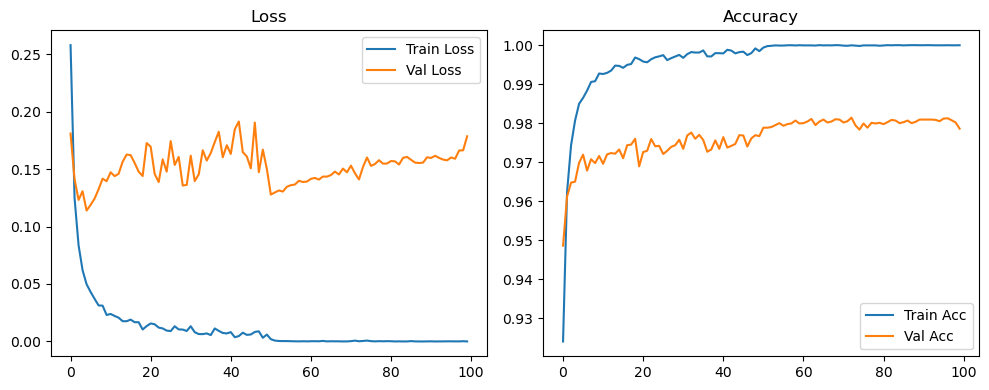

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2761, Acc: 0.9174 | Val Loss: 0.1677, Acc: 0.9513


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1416, Acc: 0.9582 | Val Loss: 0.1459, Acc: 0.9593


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1072, Acc: 0.9677 | Val Loss: 0.1328, Acc: 0.9627


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0836, Acc: 0.9746 | Val Loss: 0.1261, Acc: 0.9672


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0702, Acc: 0.9786 | Val Loss: 0.1167, Acc: 0.9669


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0594, Acc: 0.9819 | Val Loss: 0.1311, Acc: 0.9702


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0569, Acc: 0.9821 | Val Loss: 0.1171, Acc: 0.9685


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9851 | Val Loss: 0.1326, Acc: 0.9695


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9867 | Val Loss: 0.1267, Acc: 0.9723


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9871 | Val Loss: 0.1325, Acc: 0.9722


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9896 | Val Loss: 0.1416, Acc: 0.9715


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9907 | Val Loss: 0.1408, Acc: 0.9739


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9900 | Val Loss: 0.1426, Acc: 0.9704


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9911 | Val Loss: 0.1268, Acc: 0.9734


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9907 | Val Loss: 0.1350, Acc: 0.9738


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9920 | Val Loss: 0.1286, Acc: 0.9748


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9925 | Val Loss: 0.1364, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9924 | Val Loss: 0.1559, Acc: 0.9736


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9929 | Val Loss: 0.1552, Acc: 0.9747


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9937 | Val Loss: 0.1557, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9935 | Val Loss: 0.1589, Acc: 0.9746


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9936 | Val Loss: 0.1499, Acc: 0.9749


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9945 | Val Loss: 0.1650, Acc: 0.9750


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9943 | Val Loss: 0.1616, Acc: 0.9761


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9946 | Val Loss: 0.1906, Acc: 0.9725


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9942 | Val Loss: 0.1527, Acc: 0.9779


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9950 | Val Loss: 0.1431, Acc: 0.9773


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9950 | Val Loss: 0.1449, Acc: 0.9776


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9955 | Val Loss: 0.1558, Acc: 0.9742


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9949 | Val Loss: 0.1972, Acc: 0.9730


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9957 | Val Loss: 0.1884, Acc: 0.9763


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9955 | Val Loss: 0.1743, Acc: 0.9760


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9960 | Val Loss: 0.1741, Acc: 0.9762


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9960 | Val Loss: 0.1677, Acc: 0.9758


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9964 | Val Loss: 0.1912, Acc: 0.9759


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9956 | Val Loss: 0.1724, Acc: 0.9763


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9956 | Val Loss: 0.1943, Acc: 0.9751


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9947 | Val Loss: 0.1742, Acc: 0.9761


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9957 | Val Loss: 0.1599, Acc: 0.9789


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9967 | Val Loss: 0.1707, Acc: 0.9773


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9954 | Val Loss: 0.1949, Acc: 0.9766


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9964 | Val Loss: 0.1846, Acc: 0.9773


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9969 | Val Loss: 0.1982, Acc: 0.9761


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9958 | Val Loss: 0.1954, Acc: 0.9772


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9966 | Val Loss: 0.1843, Acc: 0.9778


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9973 | Val Loss: 0.2098, Acc: 0.9771


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9973 | Val Loss: 0.2200, Acc: 0.9774


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9969 | Val Loss: 0.1990, Acc: 0.9777


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9966 | Val Loss: 0.1853, Acc: 0.9794


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9973 | Val Loss: 0.2074, Acc: 0.9772


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9981 | Val Loss: 0.1838, Acc: 0.9799


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.1814, Acc: 0.9798


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.1749, Acc: 0.9801


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1793, Acc: 0.9802


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1827, Acc: 0.9804


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1833, Acc: 0.9806


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1804, Acc: 0.9809


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1806, Acc: 0.9814


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1881, Acc: 0.9811


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1827, Acc: 0.9818


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1923, Acc: 0.9810


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1897, Acc: 0.9818


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1898, Acc: 0.9813


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1808, Acc: 0.9816


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1905, Acc: 0.9818


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1920, Acc: 0.9807


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1983, Acc: 0.9819


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.2066, Acc: 0.9806


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2175, Acc: 0.9805


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.2062, Acc: 0.9813


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.2148, Acc: 0.9813


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.2160, Acc: 0.9812


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.2087, Acc: 0.9812


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2016, Acc: 0.9808


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2122, Acc: 0.9810


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.2225, Acc: 0.9819


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.2140, Acc: 0.9812


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2113, Acc: 0.9826


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.2244, Acc: 0.9808


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2114, Acc: 0.9818


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.2138, Acc: 0.9822


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.2117, Acc: 0.9828


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2079, Acc: 0.9824


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2099, Acc: 0.9822


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.2094, Acc: 0.9822


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2055, Acc: 0.9831


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2139, Acc: 0.9815


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2084, Acc: 0.9822


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2141, Acc: 0.9817


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2156, Acc: 0.9824


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2120, Acc: 0.9826


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2192, Acc: 0.9836


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.2156, Acc: 0.9832


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2118, Acc: 0.9829


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2183, Acc: 0.9829


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2099, Acc: 0.9828


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2106, Acc: 0.9824


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2163, Acc: 0.9828


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.2238, Acc: 0.9828


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2262, Acc: 0.9826


Final Test Loss: 0.1801 Accuracy: 0.9843


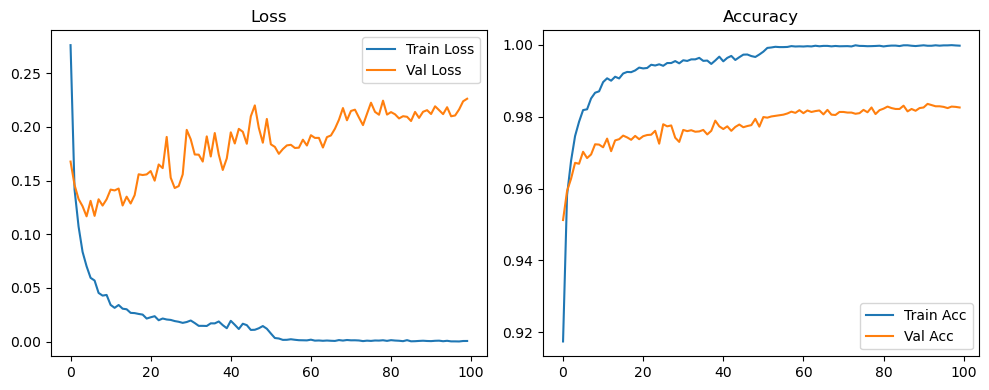

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3401, Acc: 0.8992 | Val Loss: 0.1701, Acc: 0.9517


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2060, Acc: 0.9407 | Val Loss: 0.1418, Acc: 0.9593


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1675, Acc: 0.9517 | Val Loss: 0.1396, Acc: 0.9607


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1425, Acc: 0.9577 | Val Loss: 0.1269, Acc: 0.9678


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1296, Acc: 0.9628 | Val Loss: 0.1216, Acc: 0.9660


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1136, Acc: 0.9662 | Val Loss: 0.1210, Acc: 0.9692


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1082, Acc: 0.9688 | Val Loss: 0.1136, Acc: 0.9722


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0964, Acc: 0.9716 | Val Loss: 0.1266, Acc: 0.9700


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0937, Acc: 0.9731 | Val Loss: 0.1182, Acc: 0.9738


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0875, Acc: 0.9753 | Val Loss: 0.1062, Acc: 0.9750


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0816, Acc: 0.9768 | Val Loss: 0.1267, Acc: 0.9742


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0814, Acc: 0.9772 | Val Loss: 0.1235, Acc: 0.9741


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9786 | Val Loss: 0.1261, Acc: 0.9724


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0741, Acc: 0.9796 | Val Loss: 0.1325, Acc: 0.9730


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0675, Acc: 0.9809 | Val Loss: 0.1363, Acc: 0.9748


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0726, Acc: 0.9799 | Val Loss: 0.1309, Acc: 0.9738


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9814 | Val Loss: 0.1353, Acc: 0.9762


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9824 | Val Loss: 0.1367, Acc: 0.9761


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9836 | Val Loss: 0.1284, Acc: 0.9768


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0590, Acc: 0.9835 | Val Loss: 0.1317, Acc: 0.9768


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9842 | Val Loss: 0.1539, Acc: 0.9748


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0619, Acc: 0.9838 | Val Loss: 0.1398, Acc: 0.9759


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9864 | Val Loss: 0.1395, Acc: 0.9768


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0490, Acc: 0.9869 | Val Loss: 0.1398, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9863 | Val Loss: 0.1571, Acc: 0.9760


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9865 | Val Loss: 0.1558, Acc: 0.9770


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9875 | Val Loss: 0.1509, Acc: 0.9753


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9883 | Val Loss: 0.1595, Acc: 0.9764


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9862 | Val Loss: 0.1621, Acc: 0.9762


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9885 | Val Loss: 0.1776, Acc: 0.9761


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9879 | Val Loss: 0.1767, Acc: 0.9775


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9868 | Val Loss: 0.1817, Acc: 0.9762


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9878 | Val Loss: 0.1557, Acc: 0.9777


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0530, Acc: 0.9879 | Val Loss: 0.1795, Acc: 0.9758


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9899 | Val Loss: 0.1738, Acc: 0.9781


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9893 | Val Loss: 0.1684, Acc: 0.9784


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9908 | Val Loss: 0.1733, Acc: 0.9785


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9899 | Val Loss: 0.1842, Acc: 0.9761


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9899 | Val Loss: 0.1862, Acc: 0.9782


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9905 | Val Loss: 0.2006, Acc: 0.9767


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9897 | Val Loss: 0.1617, Acc: 0.9792


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9915 | Val Loss: 0.1772, Acc: 0.9779


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9900 | Val Loss: 0.1735, Acc: 0.9785


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9916 | Val Loss: 0.1903, Acc: 0.9790


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9912 | Val Loss: 0.1810, Acc: 0.9796


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9929 | Val Loss: 0.2018, Acc: 0.9781


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9916 | Val Loss: 0.1899, Acc: 0.9781


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9916 | Val Loss: 0.1935, Acc: 0.9793


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9915 | Val Loss: 0.1952, Acc: 0.9792


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9916 | Val Loss: 0.2024, Acc: 0.9780


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9941 | Val Loss: 0.1762, Acc: 0.9807


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9948 | Val Loss: 0.1758, Acc: 0.9808


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9960 | Val Loss: 0.1698, Acc: 0.9812


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9965 | Val Loss: 0.1696, Acc: 0.9819


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9965 | Val Loss: 0.1665, Acc: 0.9812


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9968 | Val Loss: 0.1780, Acc: 0.9816


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9966 | Val Loss: 0.1779, Acc: 0.9816


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9971 | Val Loss: 0.1826, Acc: 0.9808


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9973 | Val Loss: 0.1825, Acc: 0.9808


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9974 | Val Loss: 0.1779, Acc: 0.9823


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9979 | Val Loss: 0.1764, Acc: 0.9818


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9973 | Val Loss: 0.1757, Acc: 0.9815


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9981 | Val Loss: 0.1756, Acc: 0.9820


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.1813, Acc: 0.9822


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9977 | Val Loss: 0.1780, Acc: 0.9820


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9980 | Val Loss: 0.1929, Acc: 0.9817


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.1843, Acc: 0.9818


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9978 | Val Loss: 0.1939, Acc: 0.9822


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9983 | Val Loss: 0.1959, Acc: 0.9814


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9984 | Val Loss: 0.1801, Acc: 0.9821


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9985 | Val Loss: 0.1957, Acc: 0.9822


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1968, Acc: 0.9816


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9981 | Val Loss: 0.1941, Acc: 0.9816


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9984 | Val Loss: 0.1867, Acc: 0.9819


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1900, Acc: 0.9811


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1964, Acc: 0.9822


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9985 | Val Loss: 0.1972, Acc: 0.9829


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9982 | Val Loss: 0.2078, Acc: 0.9822


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.2020, Acc: 0.9820


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9987 | Val Loss: 0.2004, Acc: 0.9824


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1972, Acc: 0.9819


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9988 | Val Loss: 0.1939, Acc: 0.9826


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.1980, Acc: 0.9822


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1992, Acc: 0.9823


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.2016, Acc: 0.9820


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9986 | Val Loss: 0.1936, Acc: 0.9822


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9990 | Val Loss: 0.1998, Acc: 0.9811


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.1994, Acc: 0.9819


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9989 | Val Loss: 0.1981, Acc: 0.9817


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9985 | Val Loss: 0.1944, Acc: 0.9818


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9989 | Val Loss: 0.1968, Acc: 0.9814


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.2039, Acc: 0.9815


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9988 | Val Loss: 0.1927, Acc: 0.9817


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1923, Acc: 0.9821


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.2026, Acc: 0.9817


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.2043, Acc: 0.9813


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.2050, Acc: 0.9816


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9989 | Val Loss: 0.2056, Acc: 0.9813


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9989 | Val Loss: 0.2066, Acc: 0.9806


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.2037, Acc: 0.9818


Final Test Loss: 0.1912 Accuracy: 0.9840


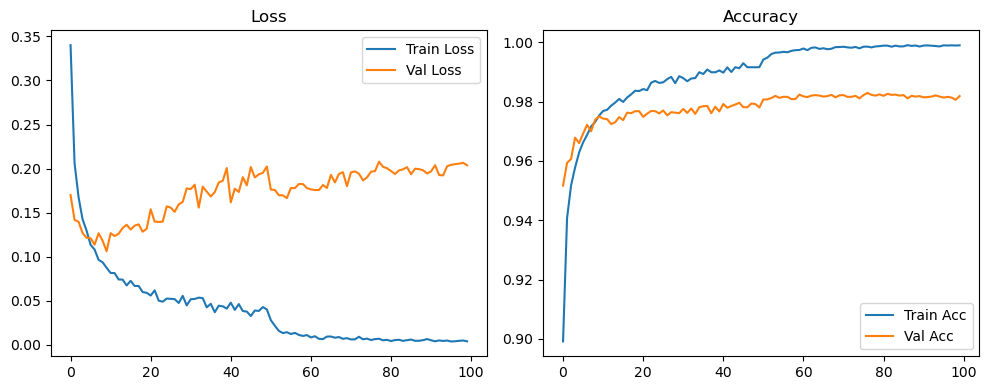

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2334, Acc: 0.9292 | Val Loss: 0.1519, Acc: 0.9556


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1116, Acc: 0.9660 | Val Loss: 0.1586, Acc: 0.9528


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0777, Acc: 0.9750 | Val Loss: 0.1293, Acc: 0.9657


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0596, Acc: 0.9810 | Val Loss: 0.1205, Acc: 0.9663


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9837 | Val Loss: 0.1185, Acc: 0.9684


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9879 | Val Loss: 0.1263, Acc: 0.9695


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0332, Acc: 0.9894 | Val Loss: 0.1436, Acc: 0.9662


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9909 | Val Loss: 0.1371, Acc: 0.9677


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9915 | Val Loss: 0.1133, Acc: 0.9736


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9931 | Val Loss: 0.1297, Acc: 0.9708


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.1296, Acc: 0.9718


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9942 | Val Loss: 0.1309, Acc: 0.9718


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9939 | Val Loss: 0.1523, Acc: 0.9705


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9946 | Val Loss: 0.1422, Acc: 0.9707


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.1371, Acc: 0.9722


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9956 | Val Loss: 0.1329, Acc: 0.9738


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9956 | Val Loss: 0.1508, Acc: 0.9741


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9953 | Val Loss: 0.1399, Acc: 0.9736


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9963 | Val Loss: 0.1568, Acc: 0.9718


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.1522, Acc: 0.9742


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9959 | Val Loss: 0.1306, Acc: 0.9741


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.1550, Acc: 0.9734


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.1457, Acc: 0.9752


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9960 | Val Loss: 0.1412, Acc: 0.9733


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1535, Acc: 0.9750


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1388, Acc: 0.9765


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9964 | Val Loss: 0.1408, Acc: 0.9762


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.1407, Acc: 0.9753


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9980 | Val Loss: 0.1323, Acc: 0.9760


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1589, Acc: 0.9739


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.1620, Acc: 0.9751


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9969 | Val Loss: 0.1628, Acc: 0.9762


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1630, Acc: 0.9745


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1712, Acc: 0.9741


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9977 | Val Loss: 0.1495, Acc: 0.9758


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1661, Acc: 0.9752


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1592, Acc: 0.9747


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9976 | Val Loss: 0.1629, Acc: 0.9745


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1571, Acc: 0.9749


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1608, Acc: 0.9772


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1619, Acc: 0.9750


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1659, Acc: 0.9751


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1730, Acc: 0.9743


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9985 | Val Loss: 0.1656, Acc: 0.9762


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1551, Acc: 0.9779


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9989 | Val Loss: 0.1867, Acc: 0.9752


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1750, Acc: 0.9746


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1579, Acc: 0.9759


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1737, Acc: 0.9741


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9973 | Val Loss: 0.1611, Acc: 0.9778


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.1438, Acc: 0.9789


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1775, Acc: 0.9739


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1529, Acc: 0.9775


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.1439, Acc: 0.9788


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1434, Acc: 0.9767


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1655, Acc: 0.9762


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1544, Acc: 0.9772


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1624, Acc: 0.9783


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1807, Acc: 0.9748


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1690, Acc: 0.9757


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.1560, Acc: 0.9776


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1512, Acc: 0.9781


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1514, Acc: 0.9766


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.1582, Acc: 0.9766


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1517, Acc: 0.9777


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1731, Acc: 0.9757


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1704, Acc: 0.9771


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1564, Acc: 0.9787


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1715, Acc: 0.9774


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1612, Acc: 0.9773


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1847, Acc: 0.9782


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1743, Acc: 0.9769


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1732, Acc: 0.9786


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1544, Acc: 0.9797


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1657, Acc: 0.9787


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9990 | Val Loss: 0.1709, Acc: 0.9773


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9978 | Val Loss: 0.1560, Acc: 0.9771


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1773, Acc: 0.9764


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1607, Acc: 0.9774


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1619, Acc: 0.9788


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9994 | Val Loss: 0.1623, Acc: 0.9758


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1699, Acc: 0.9767


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1670, Acc: 0.9773


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1558, Acc: 0.9774


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9997 | Val Loss: 0.1666, Acc: 0.9781


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1751, Acc: 0.9783


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.1871, Acc: 0.9758


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1634, Acc: 0.9762


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1831, Acc: 0.9755


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.1681, Acc: 0.9769


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1780, Acc: 0.9775


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1772, Acc: 0.9781


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1833, Acc: 0.9785


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1776, Acc: 0.9782


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9989 | Val Loss: 0.1830, Acc: 0.9769


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1782, Acc: 0.9743


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1966, Acc: 0.9758


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.2034, Acc: 0.9766


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1947, Acc: 0.9776


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1886, Acc: 0.9771


Final Test Loss: 0.1577 Accuracy: 0.9791


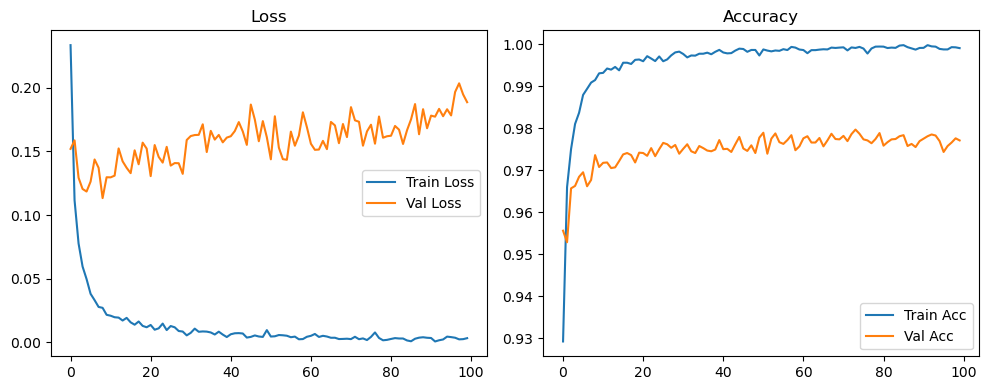

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2497, Acc: 0.9243 | Val Loss: 0.1514, Acc: 0.9557


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1285, Acc: 0.9613 | Val Loss: 0.1408, Acc: 0.9602


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0927, Acc: 0.9719 | Val Loss: 0.1279, Acc: 0.9636


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0759, Acc: 0.9765 | Val Loss: 0.1266, Acc: 0.9642


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0594, Acc: 0.9804 | Val Loss: 0.1096, Acc: 0.9694


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0572, Acc: 0.9821 | Val Loss: 0.1092, Acc: 0.9710


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9858 | Val Loss: 0.1285, Acc: 0.9683


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9857 | Val Loss: 0.1287, Acc: 0.9692


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9874 | Val Loss: 0.1130, Acc: 0.9731


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9894 | Val Loss: 0.1202, Acc: 0.9708


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9891 | Val Loss: 0.1342, Acc: 0.9722


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9905 | Val Loss: 0.1325, Acc: 0.9709


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9913 | Val Loss: 0.1301, Acc: 0.9728


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9917 | Val Loss: 0.1144, Acc: 0.9757


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9916 | Val Loss: 0.1192, Acc: 0.9743


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9932 | Val Loss: 0.1351, Acc: 0.9738


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9926 | Val Loss: 0.1212, Acc: 0.9760


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.1283, Acc: 0.9756


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9941 | Val Loss: 0.1434, Acc: 0.9737


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.1314, Acc: 0.9752


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.1512, Acc: 0.9721


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9937 | Val Loss: 0.1406, Acc: 0.9752


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9942 | Val Loss: 0.1483, Acc: 0.9752


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9948 | Val Loss: 0.1368, Acc: 0.9752


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9957 | Val Loss: 0.1500, Acc: 0.9761


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9939 | Val Loss: 0.1352, Acc: 0.9751


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9950 | Val Loss: 0.1648, Acc: 0.9744


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9947 | Val Loss: 0.1549, Acc: 0.9749


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9951 | Val Loss: 0.1366, Acc: 0.9765


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9950 | Val Loss: 0.1306, Acc: 0.9770


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.1457, Acc: 0.9773


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9955 | Val Loss: 0.1282, Acc: 0.9788


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 0.1369, Acc: 0.9792


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.1473, Acc: 0.9763


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9959 | Val Loss: 0.1518, Acc: 0.9758


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9966 | Val Loss: 0.1400, Acc: 0.9774


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.1582, Acc: 0.9768


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9964 | Val Loss: 0.1407, Acc: 0.9777


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9964 | Val Loss: 0.1565, Acc: 0.9770


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9970 | Val Loss: 0.1825, Acc: 0.9738


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9966 | Val Loss: 0.1603, Acc: 0.9754


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.1525, Acc: 0.9774


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9969 | Val Loss: 0.1758, Acc: 0.9766


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9967 | Val Loss: 0.1525, Acc: 0.9753


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9961 | Val Loss: 0.1388, Acc: 0.9774


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.1443, Acc: 0.9780


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9972 | Val Loss: 0.1463, Acc: 0.9784


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9978 | Val Loss: 0.1558, Acc: 0.9771


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1584, Acc: 0.9782


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9972 | Val Loss: 0.1636, Acc: 0.9778


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1857, Acc: 0.9781


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9973 | Val Loss: 0.1869, Acc: 0.9757


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9968 | Val Loss: 0.1734, Acc: 0.9778


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9975 | Val Loss: 0.1789, Acc: 0.9759


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9971 | Val Loss: 0.1746, Acc: 0.9768


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.1871, Acc: 0.9772


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9975 | Val Loss: 0.1697, Acc: 0.9771


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.1654, Acc: 0.9802


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.2074, Acc: 0.9748


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9975 | Val Loss: 0.1889, Acc: 0.9760


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.1672, Acc: 0.9778


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9981 | Val Loss: 0.1829, Acc: 0.9769


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.1751, Acc: 0.9781


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1709, Acc: 0.9774


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9974 | Val Loss: 0.1898, Acc: 0.9773


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9978 | Val Loss: 0.1896, Acc: 0.9772


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9976 | Val Loss: 0.1881, Acc: 0.9778


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.1696, Acc: 0.9788


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9981 | Val Loss: 0.1769, Acc: 0.9783


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.1611, Acc: 0.9780


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9978 | Val Loss: 0.1668, Acc: 0.9794


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1928, Acc: 0.9778


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9981 | Val Loss: 0.1916, Acc: 0.9792


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1842, Acc: 0.9788


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.2054, Acc: 0.9769


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9980 | Val Loss: 0.2033, Acc: 0.9793


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9979 | Val Loss: 0.2244, Acc: 0.9778


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9984 | Val Loss: 0.2054, Acc: 0.9789


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9981 | Val Loss: 0.2131, Acc: 0.9770


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1956, Acc: 0.9785


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9976 | Val Loss: 0.1870, Acc: 0.9782


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.1773, Acc: 0.9772


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9987 | Val Loss: 0.1841, Acc: 0.9785


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.1961, Acc: 0.9787


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.2005, Acc: 0.9791


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9983 | Val Loss: 0.2672, Acc: 0.9760


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9982 | Val Loss: 0.2212, Acc: 0.9772


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9979 | Val Loss: 0.2143, Acc: 0.9775


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1904, Acc: 0.9781


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.2158, Acc: 0.9772


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.2230, Acc: 0.9785


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9982 | Val Loss: 0.2207, Acc: 0.9774


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9986 | Val Loss: 0.2226, Acc: 0.9772


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.2263, Acc: 0.9777


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9981 | Val Loss: 0.2219, Acc: 0.9759


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9985 | Val Loss: 0.2100, Acc: 0.9777


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.2006, Acc: 0.9792


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9981 | Val Loss: 0.2294, Acc: 0.9783


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.2110, Acc: 0.9775


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9985 | Val Loss: 0.2084, Acc: 0.9800


Final Test Loss: 0.1979 Accuracy: 0.9812


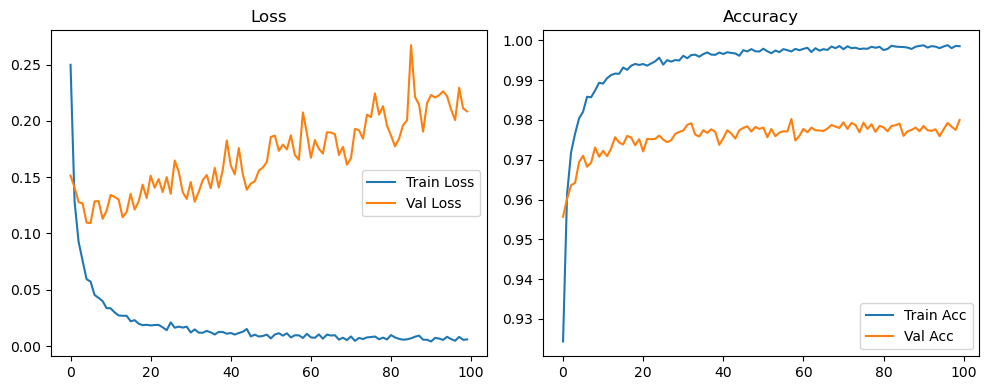

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3034, Acc: 0.9093 | Val Loss: 0.1634, Acc: 0.9534


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1817, Acc: 0.9459 | Val Loss: 0.1340, Acc: 0.9603


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1443, Acc: 0.9574 | Val Loss: 0.1249, Acc: 0.9627


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1240, Acc: 0.9618 | Val Loss: 0.1213, Acc: 0.9661


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1137, Acc: 0.9652 | Val Loss: 0.1062, Acc: 0.9691


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1021, Acc: 0.9686 | Val Loss: 0.1134, Acc: 0.9698


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0933, Acc: 0.9705 | Val Loss: 0.1041, Acc: 0.9708


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0869, Acc: 0.9727 | Val Loss: 0.1147, Acc: 0.9682


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0778, Acc: 0.9768 | Val Loss: 0.0992, Acc: 0.9747


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0758, Acc: 0.9760 | Val Loss: 0.0953, Acc: 0.9733


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0713, Acc: 0.9776 | Val Loss: 0.1040, Acc: 0.9730


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0649, Acc: 0.9795 | Val Loss: 0.1051, Acc: 0.9747


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0631, Acc: 0.9810 | Val Loss: 0.1078, Acc: 0.9728


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0623, Acc: 0.9810 | Val Loss: 0.1090, Acc: 0.9751


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0590, Acc: 0.9823 | Val Loss: 0.1198, Acc: 0.9737


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0560, Acc: 0.9827 | Val Loss: 0.1087, Acc: 0.9755


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0550, Acc: 0.9828 | Val Loss: 0.1242, Acc: 0.9723


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0497, Acc: 0.9843 | Val Loss: 0.1143, Acc: 0.9740


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9857 | Val Loss: 0.1098, Acc: 0.9743


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0489, Acc: 0.9853 | Val Loss: 0.1184, Acc: 0.9750


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9868 | Val Loss: 0.1304, Acc: 0.9753


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9868 | Val Loss: 0.1193, Acc: 0.9756


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9866 | Val Loss: 0.1205, Acc: 0.9766


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0438, Acc: 0.9865 | Val Loss: 0.1249, Acc: 0.9774


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0405, Acc: 0.9882 | Val Loss: 0.1340, Acc: 0.9757


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9878 | Val Loss: 0.1276, Acc: 0.9763


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9888 | Val Loss: 0.1211, Acc: 0.9763


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9879 | Val Loss: 0.1318, Acc: 0.9752


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9881 | Val Loss: 0.1248, Acc: 0.9757


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9895 | Val Loss: 0.1341, Acc: 0.9765


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9890 | Val Loss: 0.1357, Acc: 0.9758


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9908 | Val Loss: 0.1305, Acc: 0.9786


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9908 | Val Loss: 0.1392, Acc: 0.9768


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9904 | Val Loss: 0.1427, Acc: 0.9759


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9906 | Val Loss: 0.1423, Acc: 0.9763


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9907 | Val Loss: 0.1295, Acc: 0.9780


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9905 | Val Loss: 0.1393, Acc: 0.9758


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9904 | Val Loss: 0.1408, Acc: 0.9767


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9914 | Val Loss: 0.1353, Acc: 0.9785


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9920 | Val Loss: 0.1541, Acc: 0.9767


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9911 | Val Loss: 0.1528, Acc: 0.9779


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9921 | Val Loss: 0.1559, Acc: 0.9774


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9921 | Val Loss: 0.1626, Acc: 0.9762


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9920 | Val Loss: 0.1398, Acc: 0.9797


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9919 | Val Loss: 0.1486, Acc: 0.9785


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9930 | Val Loss: 0.1505, Acc: 0.9776


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9924 | Val Loss: 0.1590, Acc: 0.9762


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9933 | Val Loss: 0.1531, Acc: 0.9776


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9924 | Val Loss: 0.1723, Acc: 0.9775


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9924 | Val Loss: 0.1564, Acc: 0.9787


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9924 | Val Loss: 0.1537, Acc: 0.9800


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9935 | Val Loss: 0.1693, Acc: 0.9789


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9933 | Val Loss: 0.1496, Acc: 0.9777


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9938 | Val Loss: 0.1771, Acc: 0.9757


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9929 | Val Loss: 0.1559, Acc: 0.9792


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9943 | Val Loss: 0.1848, Acc: 0.9774


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9925 | Val Loss: 0.1765, Acc: 0.9758


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9933 | Val Loss: 0.1687, Acc: 0.9772


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9936 | Val Loss: 0.1698, Acc: 0.9776


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9936 | Val Loss: 0.1747, Acc: 0.9762


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9941 | Val Loss: 0.1787, Acc: 0.9782


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9941 | Val Loss: 0.1783, Acc: 0.9783


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9944 | Val Loss: 0.1688, Acc: 0.9786


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9945 | Val Loss: 0.1760, Acc: 0.9771


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9941 | Val Loss: 0.1869, Acc: 0.9762


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9939 | Val Loss: 0.1902, Acc: 0.9770


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9944 | Val Loss: 0.1895, Acc: 0.9774


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9941 | Val Loss: 0.1982, Acc: 0.9784


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9941 | Val Loss: 0.2014, Acc: 0.9793


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9950 | Val Loss: 0.1861, Acc: 0.9788


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9939 | Val Loss: 0.1801, Acc: 0.9788


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9942 | Val Loss: 0.2011, Acc: 0.9768


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9948 | Val Loss: 0.2063, Acc: 0.9782


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9944 | Val Loss: 0.1936, Acc: 0.9773


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9951 | Val Loss: 0.2040, Acc: 0.9788


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9952 | Val Loss: 0.2306, Acc: 0.9782


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9945 | Val Loss: 0.2056, Acc: 0.9777


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9947 | Val Loss: 0.1934, Acc: 0.9777


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9944 | Val Loss: 0.2154, Acc: 0.9763


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9941 | Val Loss: 0.1998, Acc: 0.9784


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9948 | Val Loss: 0.1929, Acc: 0.9781


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9949 | Val Loss: 0.1853, Acc: 0.9789


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9950 | Val Loss: 0.1995, Acc: 0.9788


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9953 | Val Loss: 0.2047, Acc: 0.9788


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9949 | Val Loss: 0.2072, Acc: 0.9779


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9946 | Val Loss: 0.2100, Acc: 0.9773


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9957 | Val Loss: 0.2143, Acc: 0.9777


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9958 | Val Loss: 0.2122, Acc: 0.9772


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9959 | Val Loss: 0.2170, Acc: 0.9780


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9957 | Val Loss: 0.2311, Acc: 0.9780


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9954 | Val Loss: 0.2327, Acc: 0.9782


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9956 | Val Loss: 0.2406, Acc: 0.9781


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9956 | Val Loss: 0.2413, Acc: 0.9778


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9954 | Val Loss: 0.2092, Acc: 0.9790


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9956 | Val Loss: 0.2166, Acc: 0.9789


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9962 | Val Loss: 0.2193, Acc: 0.9792


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9956 | Val Loss: 0.2272, Acc: 0.9788


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9956 | Val Loss: 0.2158, Acc: 0.9779


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9960 | Val Loss: 0.1942, Acc: 0.9808


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9959 | Val Loss: 0.2293, Acc: 0.9788


Final Test Loss: 0.1931 Accuracy: 0.9811


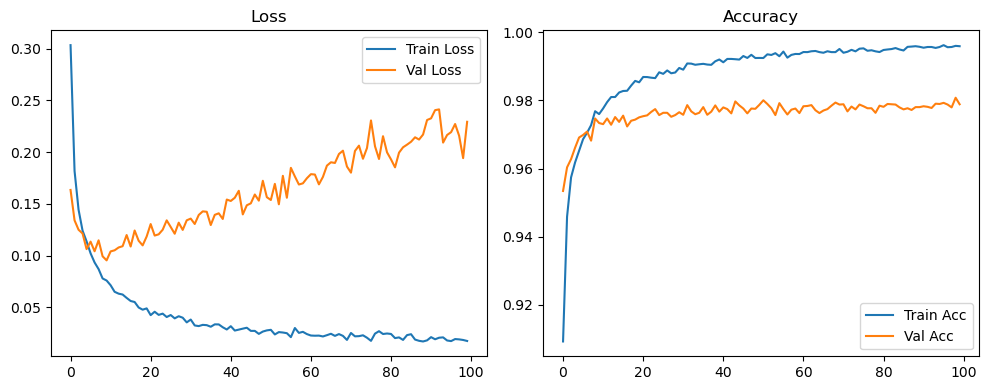

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2334, Acc: 0.9292 | Val Loss: 0.1519, Acc: 0.9556


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1116, Acc: 0.9660 | Val Loss: 0.1586, Acc: 0.9528


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0777, Acc: 0.9750 | Val Loss: 0.1293, Acc: 0.9657


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0596, Acc: 0.9810 | Val Loss: 0.1205, Acc: 0.9663


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9837 | Val Loss: 0.1185, Acc: 0.9684


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9879 | Val Loss: 0.1263, Acc: 0.9695


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0332, Acc: 0.9894 | Val Loss: 0.1436, Acc: 0.9662


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9909 | Val Loss: 0.1371, Acc: 0.9677


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9915 | Val Loss: 0.1133, Acc: 0.9736


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9931 | Val Loss: 0.1297, Acc: 0.9708


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.1296, Acc: 0.9718


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9942 | Val Loss: 0.1309, Acc: 0.9718


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9939 | Val Loss: 0.1523, Acc: 0.9705


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9946 | Val Loss: 0.1422, Acc: 0.9707


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.1371, Acc: 0.9722


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9956 | Val Loss: 0.1329, Acc: 0.9738


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9956 | Val Loss: 0.1508, Acc: 0.9741


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9953 | Val Loss: 0.1399, Acc: 0.9736


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9963 | Val Loss: 0.1568, Acc: 0.9718


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.1522, Acc: 0.9742


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9959 | Val Loss: 0.1306, Acc: 0.9741


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.1550, Acc: 0.9734


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.1457, Acc: 0.9752


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9960 | Val Loss: 0.1412, Acc: 0.9733


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1535, Acc: 0.9750


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1388, Acc: 0.9765


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9964 | Val Loss: 0.1408, Acc: 0.9762


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.1407, Acc: 0.9753


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9980 | Val Loss: 0.1323, Acc: 0.9760


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1589, Acc: 0.9739


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.1620, Acc: 0.9751


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9969 | Val Loss: 0.1628, Acc: 0.9762


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1630, Acc: 0.9745


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1712, Acc: 0.9741


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9977 | Val Loss: 0.1495, Acc: 0.9758


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1661, Acc: 0.9752


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1592, Acc: 0.9747


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9976 | Val Loss: 0.1629, Acc: 0.9745


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1571, Acc: 0.9749


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1608, Acc: 0.9772


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1619, Acc: 0.9750


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1659, Acc: 0.9751


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1730, Acc: 0.9743


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9985 | Val Loss: 0.1656, Acc: 0.9762


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1551, Acc: 0.9779


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9989 | Val Loss: 0.1867, Acc: 0.9752


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1750, Acc: 0.9746


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1579, Acc: 0.9759


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1737, Acc: 0.9741


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9973 | Val Loss: 0.1611, Acc: 0.9778


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.1449, Acc: 0.9789


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1429, Acc: 0.9793


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1440, Acc: 0.9792


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1407, Acc: 0.9790


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1431, Acc: 0.9797


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1429, Acc: 0.9798


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1538, Acc: 0.9800


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1544, Acc: 0.9798


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1625, Acc: 0.9795


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1652, Acc: 0.9795


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1706, Acc: 0.9798


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9998 | Val Loss: 0.1668, Acc: 0.9787


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1652, Acc: 0.9788


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1689, Acc: 0.9788


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1681, Acc: 0.9792


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9997 | Val Loss: 0.1705, Acc: 0.9787


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1815, Acc: 0.9782


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1720, Acc: 0.9788


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1745, Acc: 0.9775


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1770, Acc: 0.9775


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1711, Acc: 0.9789


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1819, Acc: 0.9771


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1703, Acc: 0.9778


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1837, Acc: 0.9773


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1776, Acc: 0.9772


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1833, Acc: 0.9775


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.1680, Acc: 0.9789


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1771, Acc: 0.9787


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1639, Acc: 0.9785


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1643, Acc: 0.9783


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1682, Acc: 0.9783


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1620, Acc: 0.9790


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1659, Acc: 0.9790


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1652, Acc: 0.9789


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1665, Acc: 0.9789


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1660, Acc: 0.9799


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1745, Acc: 0.9794


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1678, Acc: 0.9800


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1625, Acc: 0.9802


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1690, Acc: 0.9794


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1704, Acc: 0.9802


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1745, Acc: 0.9804


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1774, Acc: 0.9790


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1718, Acc: 0.9798


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1754, Acc: 0.9799


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1772, Acc: 0.9801


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1753, Acc: 0.9804


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1757, Acc: 0.9801


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1754, Acc: 0.9796


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1814, Acc: 0.9791


Final Test Loss: 0.1647 Accuracy: 0.9816


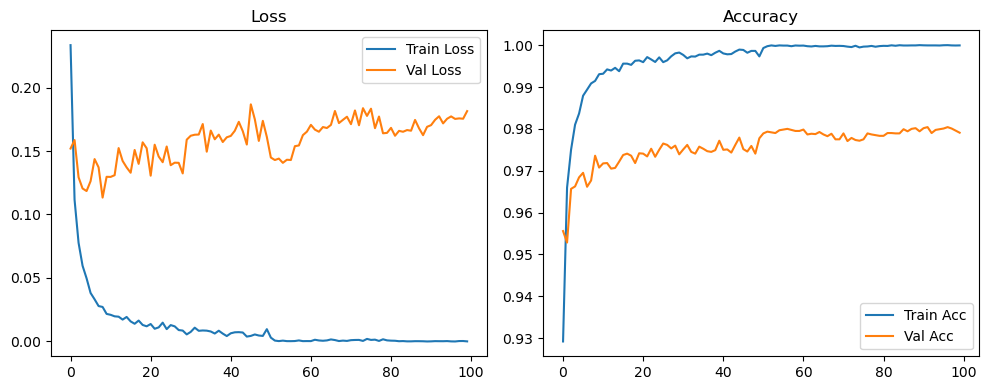

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2497, Acc: 0.9243 | Val Loss: 0.1514, Acc: 0.9557


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1285, Acc: 0.9613 | Val Loss: 0.1408, Acc: 0.9602


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0927, Acc: 0.9719 | Val Loss: 0.1279, Acc: 0.9636


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0759, Acc: 0.9765 | Val Loss: 0.1266, Acc: 0.9642


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0594, Acc: 0.9804 | Val Loss: 0.1096, Acc: 0.9694


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0572, Acc: 0.9821 | Val Loss: 0.1092, Acc: 0.9710


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9858 | Val Loss: 0.1285, Acc: 0.9683


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9857 | Val Loss: 0.1287, Acc: 0.9692


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9874 | Val Loss: 0.1130, Acc: 0.9731


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9894 | Val Loss: 0.1202, Acc: 0.9708


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9891 | Val Loss: 0.1342, Acc: 0.9722


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9905 | Val Loss: 0.1325, Acc: 0.9709


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9913 | Val Loss: 0.1301, Acc: 0.9728


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9917 | Val Loss: 0.1144, Acc: 0.9757


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9916 | Val Loss: 0.1192, Acc: 0.9743


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9932 | Val Loss: 0.1351, Acc: 0.9738


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9926 | Val Loss: 0.1212, Acc: 0.9760


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.1283, Acc: 0.9756


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9941 | Val Loss: 0.1434, Acc: 0.9737


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.1314, Acc: 0.9752


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.1512, Acc: 0.9721


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9937 | Val Loss: 0.1406, Acc: 0.9752


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9942 | Val Loss: 0.1483, Acc: 0.9752


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9948 | Val Loss: 0.1368, Acc: 0.9752


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9957 | Val Loss: 0.1500, Acc: 0.9761


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9939 | Val Loss: 0.1352, Acc: 0.9751


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9950 | Val Loss: 0.1648, Acc: 0.9744


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9947 | Val Loss: 0.1549, Acc: 0.9749


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9951 | Val Loss: 0.1366, Acc: 0.9765


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9950 | Val Loss: 0.1306, Acc: 0.9770


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.1457, Acc: 0.9773


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9955 | Val Loss: 0.1282, Acc: 0.9788


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 0.1369, Acc: 0.9792


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.1473, Acc: 0.9763


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9959 | Val Loss: 0.1518, Acc: 0.9758


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9966 | Val Loss: 0.1400, Acc: 0.9774


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.1582, Acc: 0.9768


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9964 | Val Loss: 0.1407, Acc: 0.9777


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9964 | Val Loss: 0.1565, Acc: 0.9770


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9970 | Val Loss: 0.1825, Acc: 0.9738


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9966 | Val Loss: 0.1603, Acc: 0.9754


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.1525, Acc: 0.9774


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9969 | Val Loss: 0.1758, Acc: 0.9766


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9967 | Val Loss: 0.1525, Acc: 0.9753


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9961 | Val Loss: 0.1388, Acc: 0.9774


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.1443, Acc: 0.9780


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9972 | Val Loss: 0.1463, Acc: 0.9784


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9978 | Val Loss: 0.1558, Acc: 0.9771


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1584, Acc: 0.9782


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9972 | Val Loss: 0.1636, Acc: 0.9778


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1422, Acc: 0.9802


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1475, Acc: 0.9805


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1431, Acc: 0.9802


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1525, Acc: 0.9814


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1481, Acc: 0.9808


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1503, Acc: 0.9821


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1504, Acc: 0.9811


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1536, Acc: 0.9802


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1619, Acc: 0.9805


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1651, Acc: 0.9809


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1680, Acc: 0.9814


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1678, Acc: 0.9806


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1643, Acc: 0.9800


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1750, Acc: 0.9801


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1749, Acc: 0.9798


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1731, Acc: 0.9798


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.1823, Acc: 0.9802


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1634, Acc: 0.9813


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1715, Acc: 0.9808


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1804, Acc: 0.9808


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1901, Acc: 0.9788


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1837, Acc: 0.9805


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1871, Acc: 0.9804


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1725, Acc: 0.9813


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1746, Acc: 0.9820


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1800, Acc: 0.9804


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.1925, Acc: 0.9792


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1853, Acc: 0.9812


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.1786, Acc: 0.9802


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1860, Acc: 0.9803


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1843, Acc: 0.9792


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1798, Acc: 0.9808


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1822, Acc: 0.9811


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1724, Acc: 0.9813


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1733, Acc: 0.9812


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1770, Acc: 0.9822


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1707, Acc: 0.9824


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1757, Acc: 0.9822


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.1738, Acc: 0.9813


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1811, Acc: 0.9812


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1824, Acc: 0.9815


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1794, Acc: 0.9809


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1767, Acc: 0.9816


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1750, Acc: 0.9821


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1848, Acc: 0.9818


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1821, Acc: 0.9812


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1795, Acc: 0.9815


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9999 | Val Loss: 0.1825, Acc: 0.9810


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1776, Acc: 0.9817


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1862, Acc: 0.9814


Final Test Loss: 0.1874 Accuracy: 0.9814


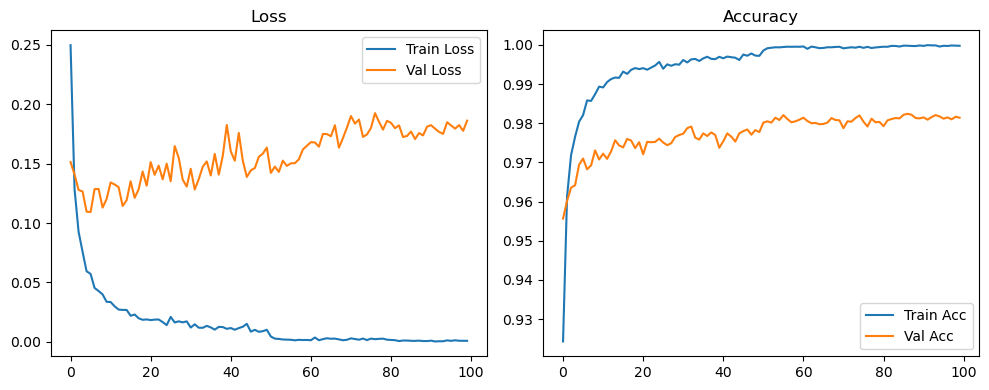

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3034, Acc: 0.9093 | Val Loss: 0.1634, Acc: 0.9534


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1817, Acc: 0.9459 | Val Loss: 0.1340, Acc: 0.9603


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1443, Acc: 0.9574 | Val Loss: 0.1249, Acc: 0.9627


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1240, Acc: 0.9618 | Val Loss: 0.1213, Acc: 0.9661


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1137, Acc: 0.9652 | Val Loss: 0.1062, Acc: 0.9691


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1021, Acc: 0.9686 | Val Loss: 0.1134, Acc: 0.9698


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0933, Acc: 0.9705 | Val Loss: 0.1041, Acc: 0.9708


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0869, Acc: 0.9727 | Val Loss: 0.1147, Acc: 0.9682


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0778, Acc: 0.9768 | Val Loss: 0.0992, Acc: 0.9747


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0758, Acc: 0.9760 | Val Loss: 0.0953, Acc: 0.9733


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0713, Acc: 0.9776 | Val Loss: 0.1040, Acc: 0.9730


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0649, Acc: 0.9795 | Val Loss: 0.1051, Acc: 0.9747


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0631, Acc: 0.9810 | Val Loss: 0.1078, Acc: 0.9728


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0623, Acc: 0.9810 | Val Loss: 0.1090, Acc: 0.9751


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0590, Acc: 0.9823 | Val Loss: 0.1198, Acc: 0.9737


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0560, Acc: 0.9827 | Val Loss: 0.1087, Acc: 0.9755


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0550, Acc: 0.9828 | Val Loss: 0.1242, Acc: 0.9723


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0497, Acc: 0.9843 | Val Loss: 0.1143, Acc: 0.9740


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9857 | Val Loss: 0.1098, Acc: 0.9743


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0489, Acc: 0.9853 | Val Loss: 0.1184, Acc: 0.9750


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9868 | Val Loss: 0.1304, Acc: 0.9753


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9868 | Val Loss: 0.1193, Acc: 0.9756


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9866 | Val Loss: 0.1205, Acc: 0.9766


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0438, Acc: 0.9865 | Val Loss: 0.1249, Acc: 0.9774


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0405, Acc: 0.9882 | Val Loss: 0.1340, Acc: 0.9757


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9878 | Val Loss: 0.1276, Acc: 0.9763


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9888 | Val Loss: 0.1211, Acc: 0.9763


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9879 | Val Loss: 0.1318, Acc: 0.9752


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9881 | Val Loss: 0.1248, Acc: 0.9757


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9895 | Val Loss: 0.1341, Acc: 0.9765


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9890 | Val Loss: 0.1357, Acc: 0.9758


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9908 | Val Loss: 0.1305, Acc: 0.9786


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9908 | Val Loss: 0.1392, Acc: 0.9768


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9904 | Val Loss: 0.1427, Acc: 0.9759


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9906 | Val Loss: 0.1423, Acc: 0.9763


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9907 | Val Loss: 0.1295, Acc: 0.9780


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9905 | Val Loss: 0.1393, Acc: 0.9758


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9904 | Val Loss: 0.1408, Acc: 0.9767


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9914 | Val Loss: 0.1353, Acc: 0.9785


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9920 | Val Loss: 0.1541, Acc: 0.9767


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9911 | Val Loss: 0.1528, Acc: 0.9779


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9921 | Val Loss: 0.1559, Acc: 0.9774


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9921 | Val Loss: 0.1626, Acc: 0.9762


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9920 | Val Loss: 0.1398, Acc: 0.9797


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9919 | Val Loss: 0.1486, Acc: 0.9785


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9930 | Val Loss: 0.1505, Acc: 0.9776


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9924 | Val Loss: 0.1590, Acc: 0.9762


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9933 | Val Loss: 0.1531, Acc: 0.9776


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9924 | Val Loss: 0.1723, Acc: 0.9775


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9924 | Val Loss: 0.1564, Acc: 0.9787


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9939 | Val Loss: 0.1473, Acc: 0.9811


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9960 | Val Loss: 0.1431, Acc: 0.9807


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9959 | Val Loss: 0.1482, Acc: 0.9808


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9968 | Val Loss: 0.1459, Acc: 0.9808


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1516, Acc: 0.9808


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.1606, Acc: 0.9803


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9972 | Val Loss: 0.1600, Acc: 0.9806


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1559, Acc: 0.9811


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.1575, Acc: 0.9810


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9969 | Val Loss: 0.1605, Acc: 0.9809


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9977 | Val Loss: 0.1722, Acc: 0.9802


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1628, Acc: 0.9802


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1737, Acc: 0.9799


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9976 | Val Loss: 0.1733, Acc: 0.9802


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9979 | Val Loss: 0.1723, Acc: 0.9816


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1837, Acc: 0.9797


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9978 | Val Loss: 0.1723, Acc: 0.9799


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9971 | Val Loss: 0.1700, Acc: 0.9822


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9980 | Val Loss: 0.1618, Acc: 0.9812


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9981 | Val Loss: 0.1662, Acc: 0.9812


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9975 | Val Loss: 0.1626, Acc: 0.9822


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9974 | Val Loss: 0.1622, Acc: 0.9807


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.1707, Acc: 0.9804


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.1632, Acc: 0.9812


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9977 | Val Loss: 0.1653, Acc: 0.9809


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.1751, Acc: 0.9804


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.1752, Acc: 0.9806


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9980 | Val Loss: 0.1840, Acc: 0.9805


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9979 | Val Loss: 0.1740, Acc: 0.9802


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.1847, Acc: 0.9800


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1770, Acc: 0.9819


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9981 | Val Loss: 0.1743, Acc: 0.9803


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9979 | Val Loss: 0.1792, Acc: 0.9802


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1754, Acc: 0.9800


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1753, Acc: 0.9797


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1683, Acc: 0.9808


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1721, Acc: 0.9800


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1752, Acc: 0.9806


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.1770, Acc: 0.9803


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1747, Acc: 0.9811


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1759, Acc: 0.9810


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9987 | Val Loss: 0.1823, Acc: 0.9805


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1782, Acc: 0.9807


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1768, Acc: 0.9819


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1826, Acc: 0.9812


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1865, Acc: 0.9814


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1815, Acc: 0.9808


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.1854, Acc: 0.9810


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1862, Acc: 0.9802


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.1851, Acc: 0.9803


Final Test Loss: 0.1640 Accuracy: 0.9832


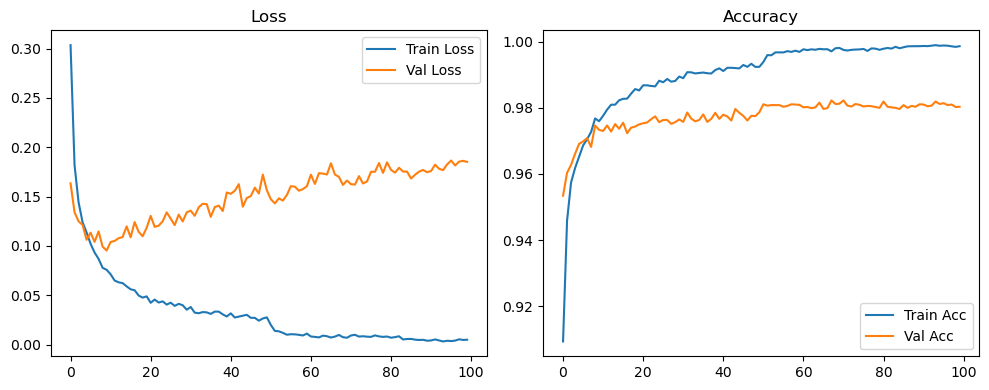

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2092, Acc: 0.9349 | Val Loss: 0.1426, Acc: 0.9569


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0945, Acc: 0.9700 | Val Loss: 0.1643, Acc: 0.9507


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0644, Acc: 0.9795 | Val Loss: 0.1180, Acc: 0.9657


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0453, Acc: 0.9852 | Val Loss: 0.1125, Acc: 0.9701


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0383, Acc: 0.9875 | Val Loss: 0.1162, Acc: 0.9700


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0320, Acc: 0.9899 | Val Loss: 0.1301, Acc: 0.9696


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9902 | Val Loss: 0.1126, Acc: 0.9714


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9921 | Val Loss: 0.1267, Acc: 0.9703


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9928 | Val Loss: 0.1117, Acc: 0.9738


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9935 | Val Loss: 0.1187, Acc: 0.9714


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9941 | Val Loss: 0.1255, Acc: 0.9729


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.1232, Acc: 0.9724


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.1356, Acc: 0.9723


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9938 | Val Loss: 0.1192, Acc: 0.9747


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9941 | Val Loss: 0.1297, Acc: 0.9733


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.1385, Acc: 0.9723


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9953 | Val Loss: 0.1287, Acc: 0.9742


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1195, Acc: 0.9755


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.1325, Acc: 0.9743


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9961 | Val Loss: 0.1403, Acc: 0.9732


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9972 | Val Loss: 0.1406, Acc: 0.9740


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9949 | Val Loss: 0.1321, Acc: 0.9741


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1344, Acc: 0.9740


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1438, Acc: 0.9746


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.1411, Acc: 0.9715


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.1208, Acc: 0.9771


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1403, Acc: 0.9747


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1366, Acc: 0.9722


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.1352, Acc: 0.9753


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1466, Acc: 0.9722


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9967 | Val Loss: 0.1316, Acc: 0.9749


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1263, Acc: 0.9757


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1435, Acc: 0.9739


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1346, Acc: 0.9762


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9981 | Val Loss: 0.1434, Acc: 0.9749


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1422, Acc: 0.9748


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.1265, Acc: 0.9760


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1506, Acc: 0.9732


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1436, Acc: 0.9744


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1340, Acc: 0.9756


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1326, Acc: 0.9773


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1429, Acc: 0.9768


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1350, Acc: 0.9774


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1391, Acc: 0.9768


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1587, Acc: 0.9758


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1421, Acc: 0.9757


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1462, Acc: 0.9765


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.1447, Acc: 0.9760


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1287, Acc: 0.9789


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1443, Acc: 0.9769


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9979 | Val Loss: 0.1430, Acc: 0.9754


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1614, Acc: 0.9762


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9984 | Val Loss: 0.1410, Acc: 0.9761


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1283, Acc: 0.9803


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1499, Acc: 0.9761


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1466, Acc: 0.9772


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.1385, Acc: 0.9776


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1410, Acc: 0.9786


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1595, Acc: 0.9752


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9981 | Val Loss: 0.1539, Acc: 0.9749


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1528, Acc: 0.9759


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1422, Acc: 0.9774


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1383, Acc: 0.9775


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1456, Acc: 0.9786


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1605, Acc: 0.9758


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1596, Acc: 0.9751


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1444, Acc: 0.9782


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1586, Acc: 0.9769


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1628, Acc: 0.9765


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.1681, Acc: 0.9749


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1348, Acc: 0.9786


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1562, Acc: 0.9761


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1558, Acc: 0.9777


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9984 | Val Loss: 0.1546, Acc: 0.9766


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1677, Acc: 0.9762


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1651, Acc: 0.9774


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1607, Acc: 0.9772


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1719, Acc: 0.9760


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1833, Acc: 0.9747


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1750, Acc: 0.9759


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1819, Acc: 0.9740


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1699, Acc: 0.9771


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1691, Acc: 0.9754


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1711, Acc: 0.9772


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1811, Acc: 0.9758


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1843, Acc: 0.9752


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1797, Acc: 0.9762


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1634, Acc: 0.9758


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1640, Acc: 0.9768


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1946, Acc: 0.9746


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1779, Acc: 0.9753


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1992, Acc: 0.9748


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9986 | Val Loss: 0.1707, Acc: 0.9751


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1669, Acc: 0.9762


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1542, Acc: 0.9788


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1728, Acc: 0.9758


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1618, Acc: 0.9775


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1701, Acc: 0.9767


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1683, Acc: 0.9771


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1794, Acc: 0.9764


Final Test Loss: 0.1578 Accuracy: 0.9800


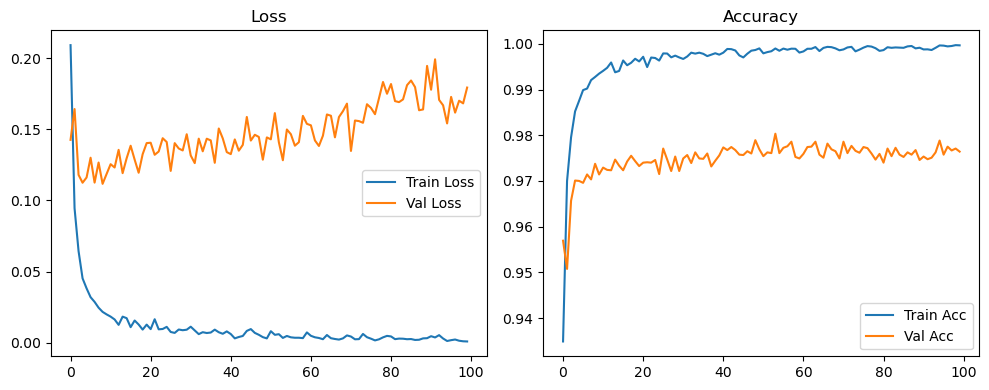

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2299, Acc: 0.9291 | Val Loss: 0.1460, Acc: 0.9551


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1145, Acc: 0.9637 | Val Loss: 0.1356, Acc: 0.9598


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0789, Acc: 0.9737 | Val Loss: 0.1124, Acc: 0.9680


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0663, Acc: 0.9790 | Val Loss: 0.1148, Acc: 0.9665


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0511, Acc: 0.9828 | Val Loss: 0.1065, Acc: 0.9700


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0452, Acc: 0.9853 | Val Loss: 0.1133, Acc: 0.9700


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9881 | Val Loss: 0.1128, Acc: 0.9716


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0377, Acc: 0.9873 | Val Loss: 0.1080, Acc: 0.9718


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0355, Acc: 0.9883 | Val Loss: 0.1053, Acc: 0.9731


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9902 | Val Loss: 0.1057, Acc: 0.9727


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9904 | Val Loss: 0.1061, Acc: 0.9741


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9915 | Val Loss: 0.1171, Acc: 0.9731


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9919 | Val Loss: 0.1175, Acc: 0.9735


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9924 | Val Loss: 0.1120, Acc: 0.9742


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9933 | Val Loss: 0.1204, Acc: 0.9742


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.1342, Acc: 0.9728


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9932 | Val Loss: 0.1183, Acc: 0.9740


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9936 | Val Loss: 0.1323, Acc: 0.9718


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0175, Acc: 0.9942 | Val Loss: 0.1204, Acc: 0.9747


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9947 | Val Loss: 0.1231, Acc: 0.9738


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9937 | Val Loss: 0.1282, Acc: 0.9722


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9942 | Val Loss: 0.1229, Acc: 0.9743


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9948 | Val Loss: 0.1274, Acc: 0.9749


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.1181, Acc: 0.9758


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9951 | Val Loss: 0.1320, Acc: 0.9761


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9948 | Val Loss: 0.1278, Acc: 0.9760


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.1306, Acc: 0.9751


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.1419, Acc: 0.9728


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.1171, Acc: 0.9761


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9964 | Val Loss: 0.1211, Acc: 0.9771


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1373, Acc: 0.9743


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9960 | Val Loss: 0.1213, Acc: 0.9756


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1272, Acc: 0.9752


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1176, Acc: 0.9783


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.1263, Acc: 0.9768


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.1380, Acc: 0.9763


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1276, Acc: 0.9778


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9966 | Val Loss: 0.1306, Acc: 0.9764


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.1205, Acc: 0.9776


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1270, Acc: 0.9792


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1378, Acc: 0.9762


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.1392, Acc: 0.9763


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.1409, Acc: 0.9768


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.1461, Acc: 0.9765


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1451, Acc: 0.9758


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.1356, Acc: 0.9775


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9973 | Val Loss: 0.1500, Acc: 0.9768


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9971 | Val Loss: 0.1334, Acc: 0.9772


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1368, Acc: 0.9786


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.1500, Acc: 0.9753


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1447, Acc: 0.9771


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.1323, Acc: 0.9785


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1406, Acc: 0.9765


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1501, Acc: 0.9775


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1625, Acc: 0.9769


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9971 | Val Loss: 0.1361, Acc: 0.9782


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1367, Acc: 0.9773


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1400, Acc: 0.9773


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1414, Acc: 0.9782


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1423, Acc: 0.9782


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1444, Acc: 0.9788


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1620, Acc: 0.9774


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1615, Acc: 0.9768


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1547, Acc: 0.9761


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1463, Acc: 0.9775


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1497, Acc: 0.9774


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1450, Acc: 0.9792


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.1425, Acc: 0.9794


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1603, Acc: 0.9782


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1507, Acc: 0.9788


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1677, Acc: 0.9757


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9980 | Val Loss: 0.1646, Acc: 0.9785


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1584, Acc: 0.9786


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1497, Acc: 0.9788


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9979 | Val Loss: 0.1539, Acc: 0.9788


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9978 | Val Loss: 0.1596, Acc: 0.9763


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.1418, Acc: 0.9786


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1544, Acc: 0.9799


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1648, Acc: 0.9780


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1596, Acc: 0.9790


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1651, Acc: 0.9783


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.1656, Acc: 0.9772


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1600, Acc: 0.9784


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1594, Acc: 0.9771


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1668, Acc: 0.9782


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1606, Acc: 0.9780


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1603, Acc: 0.9791


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.1755, Acc: 0.9776


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1658, Acc: 0.9788


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1696, Acc: 0.9763


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1840, Acc: 0.9776


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.1797, Acc: 0.9768


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9983 | Val Loss: 0.1661, Acc: 0.9783


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1601, Acc: 0.9796


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.1602, Acc: 0.9788


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1638, Acc: 0.9779


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1810, Acc: 0.9772


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9988 | Val Loss: 0.1629, Acc: 0.9782


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1606, Acc: 0.9798


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1793, Acc: 0.9785


Final Test Loss: 0.1480 Accuracy: 0.9800


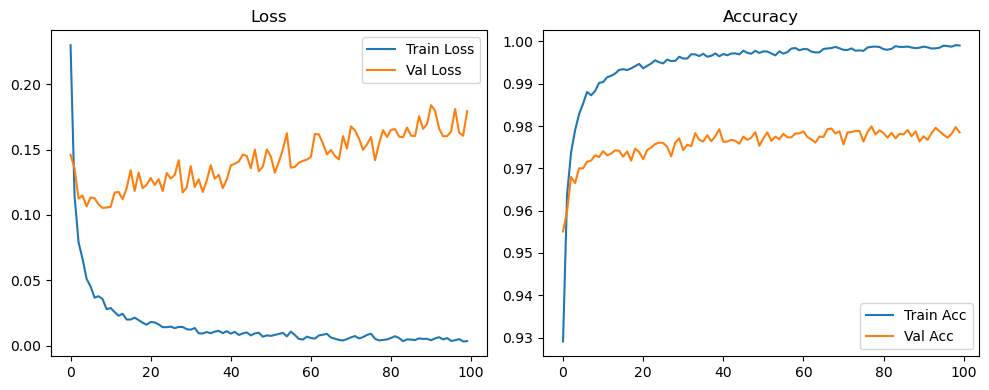

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3004, Acc: 0.9085 | Val Loss: 0.1508, Acc: 0.9555


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1630, Acc: 0.9499 | Val Loss: 0.1274, Acc: 0.9587


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1298, Acc: 0.9602 | Val Loss: 0.1050, Acc: 0.9685


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1073, Acc: 0.9665 | Val Loss: 0.1151, Acc: 0.9660


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0984, Acc: 0.9692 | Val Loss: 0.1017, Acc: 0.9697


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0893, Acc: 0.9710 | Val Loss: 0.1040, Acc: 0.9705


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0817, Acc: 0.9738 | Val Loss: 0.1028, Acc: 0.9702


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0753, Acc: 0.9763 | Val Loss: 0.1013, Acc: 0.9699


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0690, Acc: 0.9774 | Val Loss: 0.0967, Acc: 0.9722


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0673, Acc: 0.9779 | Val Loss: 0.1030, Acc: 0.9712


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0642, Acc: 0.9794 | Val Loss: 0.1055, Acc: 0.9720


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0602, Acc: 0.9805 | Val Loss: 0.0966, Acc: 0.9737


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0558, Acc: 0.9816 | Val Loss: 0.0957, Acc: 0.9742


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0501, Acc: 0.9832 | Val Loss: 0.1010, Acc: 0.9747


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0492, Acc: 0.9835 | Val Loss: 0.0998, Acc: 0.9762


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0487, Acc: 0.9844 | Val Loss: 0.0986, Acc: 0.9764


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0451, Acc: 0.9851 | Val Loss: 0.0984, Acc: 0.9766


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0457, Acc: 0.9845 | Val Loss: 0.0948, Acc: 0.9766


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0422, Acc: 0.9855 | Val Loss: 0.1022, Acc: 0.9756


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9874 | Val Loss: 0.0983, Acc: 0.9756


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0388, Acc: 0.9873 | Val Loss: 0.1032, Acc: 0.9758


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0405, Acc: 0.9873 | Val Loss: 0.1085, Acc: 0.9749


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0403, Acc: 0.9866 | Val Loss: 0.1054, Acc: 0.9747


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0360, Acc: 0.9880 | Val Loss: 0.1136, Acc: 0.9747


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0346, Acc: 0.9887 | Val Loss: 0.1153, Acc: 0.9753


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0354, Acc: 0.9884 | Val Loss: 0.1136, Acc: 0.9740


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9902 | Val Loss: 0.1026, Acc: 0.9769


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9894 | Val Loss: 0.1151, Acc: 0.9746


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9893 | Val Loss: 0.1132, Acc: 0.9766


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9898 | Val Loss: 0.1003, Acc: 0.9768


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9909 | Val Loss: 0.1067, Acc: 0.9757


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9912 | Val Loss: 0.1103, Acc: 0.9775


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9899 | Val Loss: 0.1077, Acc: 0.9777


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9913 | Val Loss: 0.1170, Acc: 0.9768


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9912 | Val Loss: 0.1156, Acc: 0.9749


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9909 | Val Loss: 0.1108, Acc: 0.9773


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9915 | Val Loss: 0.1215, Acc: 0.9761


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9915 | Val Loss: 0.1154, Acc: 0.9767


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.1100, Acc: 0.9781


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9919 | Val Loss: 0.1028, Acc: 0.9781


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9918 | Val Loss: 0.1110, Acc: 0.9768


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.1199, Acc: 0.9761


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9924 | Val Loss: 0.1180, Acc: 0.9767


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9929 | Val Loss: 0.1148, Acc: 0.9772


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9922 | Val Loss: 0.1164, Acc: 0.9767


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9928 | Val Loss: 0.1103, Acc: 0.9775


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9928 | Val Loss: 0.1208, Acc: 0.9777


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.1225, Acc: 0.9778


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.1226, Acc: 0.9785


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9928 | Val Loss: 0.1265, Acc: 0.9760


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9931 | Val Loss: 0.1185, Acc: 0.9794


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9933 | Val Loss: 0.1122, Acc: 0.9791


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9941 | Val Loss: 0.1187, Acc: 0.9788


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.1132, Acc: 0.9797


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9948 | Val Loss: 0.1287, Acc: 0.9784


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9936 | Val Loss: 0.1235, Acc: 0.9775


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9940 | Val Loss: 0.1245, Acc: 0.9762


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9944 | Val Loss: 0.1236, Acc: 0.9779


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9936 | Val Loss: 0.1300, Acc: 0.9759


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9954 | Val Loss: 0.1303, Acc: 0.9779


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9942 | Val Loss: 0.1227, Acc: 0.9785


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9946 | Val Loss: 0.1142, Acc: 0.9793


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9949 | Val Loss: 0.1183, Acc: 0.9785


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.1217, Acc: 0.9784


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.1341, Acc: 0.9774


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9956 | Val Loss: 0.1334, Acc: 0.9795


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9947 | Val Loss: 0.1285, Acc: 0.9782


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9953 | Val Loss: 0.1316, Acc: 0.9785


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9949 | Val Loss: 0.1371, Acc: 0.9778


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.1391, Acc: 0.9784


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9954 | Val Loss: 0.1435, Acc: 0.9788


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9953 | Val Loss: 0.1396, Acc: 0.9789


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9952 | Val Loss: 0.1380, Acc: 0.9788


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1386, Acc: 0.9787


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.1412, Acc: 0.9792


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9950 | Val Loss: 0.1397, Acc: 0.9773


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9954 | Val Loss: 0.1323, Acc: 0.9785


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9956 | Val Loss: 0.1379, Acc: 0.9796


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9955 | Val Loss: 0.1383, Acc: 0.9782


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9953 | Val Loss: 0.1399, Acc: 0.9786


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9951 | Val Loss: 0.1388, Acc: 0.9789


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9952 | Val Loss: 0.1378, Acc: 0.9778


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9958 | Val Loss: 0.1391, Acc: 0.9777


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9963 | Val Loss: 0.1374, Acc: 0.9793


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9954 | Val Loss: 0.1422, Acc: 0.9776


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9956 | Val Loss: 0.1483, Acc: 0.9783


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9956 | Val Loss: 0.1554, Acc: 0.9793


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.1405, Acc: 0.9785


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9956 | Val Loss: 0.1419, Acc: 0.9792


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9962 | Val Loss: 0.1421, Acc: 0.9796


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9958 | Val Loss: 0.1530, Acc: 0.9792


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9957 | Val Loss: 0.1498, Acc: 0.9789


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9959 | Val Loss: 0.1569, Acc: 0.9779


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9963 | Val Loss: 0.1538, Acc: 0.9787


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9958 | Val Loss: 0.1548, Acc: 0.9795


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.1543, Acc: 0.9777


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9964 | Val Loss: 0.1499, Acc: 0.9792


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9967 | Val Loss: 0.1518, Acc: 0.9799


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9964 | Val Loss: 0.1571, Acc: 0.9799


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9960 | Val Loss: 0.1680, Acc: 0.9768


Final Test Loss: 0.1621 Accuracy: 0.9798


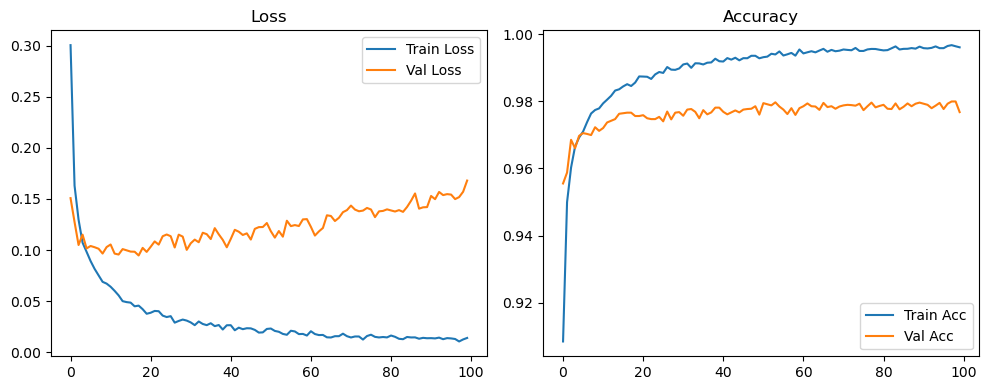

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2067, Acc: 0.9364 | Val Loss: 0.1256, Acc: 0.9600


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0843, Acc: 0.9734 | Val Loss: 0.1325, Acc: 0.9593


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0563, Acc: 0.9818 | Val Loss: 0.1088, Acc: 0.9683


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0385, Acc: 0.9877 | Val Loss: 0.1315, Acc: 0.9631


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0335, Acc: 0.9883 | Val Loss: 0.1054, Acc: 0.9714


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9909 | Val Loss: 0.1150, Acc: 0.9725


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.1060, Acc: 0.9725


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9937 | Val Loss: 0.1107, Acc: 0.9707


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9931 | Val Loss: 0.1141, Acc: 0.9714


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.1067, Acc: 0.9744


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9941 | Val Loss: 0.1185, Acc: 0.9742


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.1136, Acc: 0.9742


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.1333, Acc: 0.9715


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.1243, Acc: 0.9714


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.1275, Acc: 0.9735


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1266, Acc: 0.9740


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1318, Acc: 0.9724


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1264, Acc: 0.9748


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1318, Acc: 0.9722


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.1384, Acc: 0.9705


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1132, Acc: 0.9754


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1108, Acc: 0.9765


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1242, Acc: 0.9750


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9961 | Val Loss: 0.1248, Acc: 0.9731


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1474, Acc: 0.9708


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1259, Acc: 0.9752


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1110, Acc: 0.9772


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1367, Acc: 0.9736


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.1421, Acc: 0.9732


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1359, Acc: 0.9754


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1319, Acc: 0.9759


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1205, Acc: 0.9766


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1204, Acc: 0.9758


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1267, Acc: 0.9750


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1268, Acc: 0.9779


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1258, Acc: 0.9760


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1555, Acc: 0.9742


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1403, Acc: 0.9745


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1344, Acc: 0.9746


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1372, Acc: 0.9747


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1280, Acc: 0.9764


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9983 | Val Loss: 0.1317, Acc: 0.9759


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1348, Acc: 0.9754


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1334, Acc: 0.9758


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1333, Acc: 0.9774


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9985 | Val Loss: 0.1322, Acc: 0.9752


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1305, Acc: 0.9772


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1482, Acc: 0.9762


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.1386, Acc: 0.9752


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1324, Acc: 0.9765


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.1473, Acc: 0.9748


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1265, Acc: 0.9762


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1354, Acc: 0.9768


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1322, Acc: 0.9778


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1379, Acc: 0.9753


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1405, Acc: 0.9762


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1398, Acc: 0.9754


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1355, Acc: 0.9777


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1381, Acc: 0.9770


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1417, Acc: 0.9767


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1488, Acc: 0.9774


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1422, Acc: 0.9763


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1532, Acc: 0.9752


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1478, Acc: 0.9759


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1431, Acc: 0.9764


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1676, Acc: 0.9749


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1519, Acc: 0.9757


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1748, Acc: 0.9739


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1606, Acc: 0.9749


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1436, Acc: 0.9768


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1334, Acc: 0.9778


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1431, Acc: 0.9778


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1450, Acc: 0.9774


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.1574, Acc: 0.9747


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1578, Acc: 0.9759


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1579, Acc: 0.9749


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1399, Acc: 0.9767


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1478, Acc: 0.9782


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1526, Acc: 0.9773


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1689, Acc: 0.9763


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1561, Acc: 0.9768


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1494, Acc: 0.9780


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1446, Acc: 0.9779


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1499, Acc: 0.9782


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1633, Acc: 0.9770


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9988 | Val Loss: 0.1603, Acc: 0.9751


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1610, Acc: 0.9755


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1552, Acc: 0.9766


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1720, Acc: 0.9761


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1558, Acc: 0.9770


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1515, Acc: 0.9782


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1396, Acc: 0.9790


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1370, Acc: 0.9782


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1221, Acc: 0.9805


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1305, Acc: 0.9801


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1416, Acc: 0.9795


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1544, Acc: 0.9770


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1569, Acc: 0.9759


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1483, Acc: 0.9781


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1612, Acc: 0.9766


Final Test Loss: 0.1436 Accuracy: 0.9766


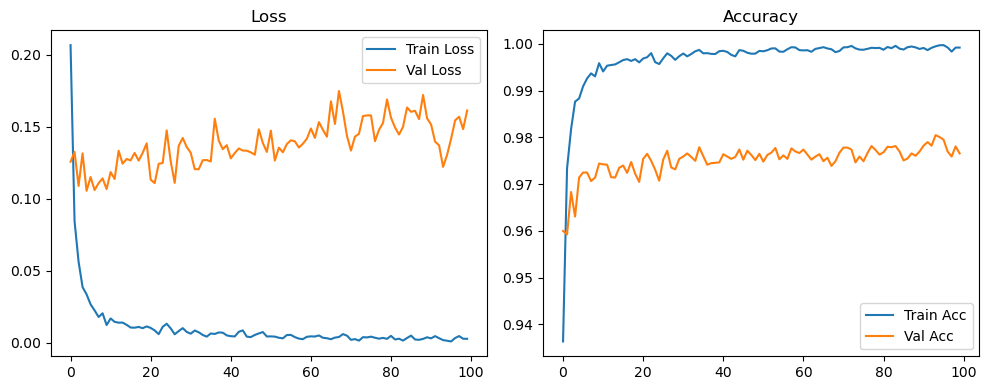

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2354, Acc: 0.9273 | Val Loss: 0.1340, Acc: 0.9580


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1043, Acc: 0.9679 | Val Loss: 0.1276, Acc: 0.9627


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0735, Acc: 0.9764 | Val Loss: 0.1068, Acc: 0.9674


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0568, Acc: 0.9816 | Val Loss: 0.1110, Acc: 0.9676


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9847 | Val Loss: 0.1010, Acc: 0.9722


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0400, Acc: 0.9866 | Val Loss: 0.1069, Acc: 0.9698


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0360, Acc: 0.9871 | Val Loss: 0.0999, Acc: 0.9717


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0310, Acc: 0.9897 | Val Loss: 0.1173, Acc: 0.9692


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0301, Acc: 0.9895 | Val Loss: 0.1089, Acc: 0.9723


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9907 | Val Loss: 0.1027, Acc: 0.9741


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9927 | Val Loss: 0.1126, Acc: 0.9717


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9924 | Val Loss: 0.1075, Acc: 0.9745


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9940 | Val Loss: 0.1122, Acc: 0.9716


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9930 | Val Loss: 0.0983, Acc: 0.9742


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9928 | Val Loss: 0.1103, Acc: 0.9731


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.1215, Acc: 0.9722


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9941 | Val Loss: 0.1178, Acc: 0.9724


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.1081, Acc: 0.9757


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0156, Acc: 0.9947 | Val Loss: 0.1162, Acc: 0.9742


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.1270, Acc: 0.9705


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9941 | Val Loss: 0.1208, Acc: 0.9738


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.1129, Acc: 0.9762


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.1272, Acc: 0.9743


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.1121, Acc: 0.9751


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1217, Acc: 0.9763


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.1094, Acc: 0.9752


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9963 | Val Loss: 0.1175, Acc: 0.9753


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.1228, Acc: 0.9729


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.1259, Acc: 0.9734


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.1302, Acc: 0.9752


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.1259, Acc: 0.9741


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1285, Acc: 0.9742


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1223, Acc: 0.9758


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.1177, Acc: 0.9762


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1241, Acc: 0.9755


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9963 | Val Loss: 0.1353, Acc: 0.9733


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.1164, Acc: 0.9759


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1224, Acc: 0.9752


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1183, Acc: 0.9768


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.1183, Acc: 0.9768


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1185, Acc: 0.9769


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1402, Acc: 0.9751


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.1325, Acc: 0.9742


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1281, Acc: 0.9747


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.1392, Acc: 0.9740


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1199, Acc: 0.9768


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.1177, Acc: 0.9770


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1159, Acc: 0.9774


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1255, Acc: 0.9758


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1194, Acc: 0.9774


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1229, Acc: 0.9778


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9975 | Val Loss: 0.1188, Acc: 0.9782


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1225, Acc: 0.9783


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.1291, Acc: 0.9777


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1198, Acc: 0.9801


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.1292, Acc: 0.9767


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1252, Acc: 0.9773


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1297, Acc: 0.9773


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1201, Acc: 0.9772


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.1339, Acc: 0.9766


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1308, Acc: 0.9775


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1358, Acc: 0.9768


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1230, Acc: 0.9777


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1387, Acc: 0.9773


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1482, Acc: 0.9758


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1347, Acc: 0.9768


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1341, Acc: 0.9772


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1354, Acc: 0.9765


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1428, Acc: 0.9765


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1413, Acc: 0.9773


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1452, Acc: 0.9765


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1529, Acc: 0.9768


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1479, Acc: 0.9763


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1342, Acc: 0.9787


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1390, Acc: 0.9773


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1540, Acc: 0.9759


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1369, Acc: 0.9776


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1478, Acc: 0.9762


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1430, Acc: 0.9779


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1497, Acc: 0.9762


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1448, Acc: 0.9774


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1416, Acc: 0.9768


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1382, Acc: 0.9781


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1492, Acc: 0.9765


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1421, Acc: 0.9779


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1512, Acc: 0.9758


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1455, Acc: 0.9771


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1491, Acc: 0.9762


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1435, Acc: 0.9775


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1455, Acc: 0.9772


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1610, Acc: 0.9759


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1539, Acc: 0.9753


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1370, Acc: 0.9786


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1560, Acc: 0.9762


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1441, Acc: 0.9772


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1323, Acc: 0.9797


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1446, Acc: 0.9765


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1392, Acc: 0.9766


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1526, Acc: 0.9764


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1537, Acc: 0.9766


Final Test Loss: 0.1381 Accuracy: 0.9795


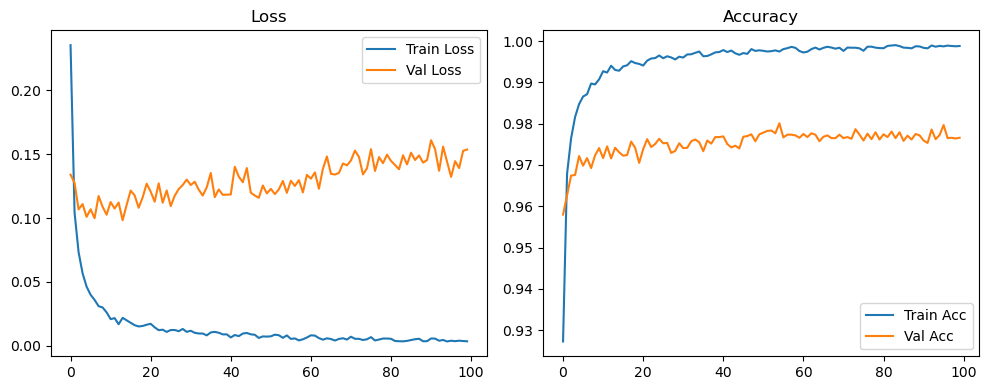

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3355, Acc: 0.8975 | Val Loss: 0.1495, Acc: 0.9534


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1603, Acc: 0.9504 | Val Loss: 0.1213, Acc: 0.9618


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1224, Acc: 0.9618 | Val Loss: 0.1103, Acc: 0.9667


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1059, Acc: 0.9656 | Val Loss: 0.1098, Acc: 0.9663


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0942, Acc: 0.9698 | Val Loss: 0.0956, Acc: 0.9724


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0821, Acc: 0.9730 | Val Loss: 0.0929, Acc: 0.9721


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0756, Acc: 0.9754 | Val Loss: 0.0966, Acc: 0.9723


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0692, Acc: 0.9775 | Val Loss: 0.0981, Acc: 0.9716


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0637, Acc: 0.9792 | Val Loss: 0.0963, Acc: 0.9742


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0633, Acc: 0.9795 | Val Loss: 0.0971, Acc: 0.9730


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0577, Acc: 0.9805 | Val Loss: 0.1022, Acc: 0.9726


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0564, Acc: 0.9821 | Val Loss: 0.0980, Acc: 0.9728


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0477, Acc: 0.9842 | Val Loss: 0.1001, Acc: 0.9724


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0486, Acc: 0.9838 | Val Loss: 0.1006, Acc: 0.9732


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0458, Acc: 0.9846 | Val Loss: 0.0992, Acc: 0.9746


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0465, Acc: 0.9849 | Val Loss: 0.0964, Acc: 0.9764


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0415, Acc: 0.9856 | Val Loss: 0.0991, Acc: 0.9745


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0434, Acc: 0.9859 | Val Loss: 0.0919, Acc: 0.9768


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0373, Acc: 0.9871 | Val Loss: 0.0980, Acc: 0.9755


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0366, Acc: 0.9876 | Val Loss: 0.0952, Acc: 0.9758


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0387, Acc: 0.9868 | Val Loss: 0.0989, Acc: 0.9767


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0380, Acc: 0.9870 | Val Loss: 0.0984, Acc: 0.9760


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9883 | Val Loss: 0.0982, Acc: 0.9765


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0342, Acc: 0.9889 | Val Loss: 0.1091, Acc: 0.9749


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0327, Acc: 0.9890 | Val Loss: 0.0988, Acc: 0.9756


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0333, Acc: 0.9889 | Val Loss: 0.1023, Acc: 0.9755


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9898 | Val Loss: 0.0991, Acc: 0.9756


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9902 | Val Loss: 0.1037, Acc: 0.9753


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9899 | Val Loss: 0.0964, Acc: 0.9768


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0294, Acc: 0.9905 | Val Loss: 0.0990, Acc: 0.9768


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9903 | Val Loss: 0.1025, Acc: 0.9763


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9911 | Val Loss: 0.1018, Acc: 0.9767


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9910 | Val Loss: 0.1009, Acc: 0.9758


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9910 | Val Loss: 0.1023, Acc: 0.9761


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9916 | Val Loss: 0.1035, Acc: 0.9764


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0257, Acc: 0.9912 | Val Loss: 0.1034, Acc: 0.9752


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0241, Acc: 0.9922 | Val Loss: 0.1075, Acc: 0.9766


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9917 | Val Loss: 0.1024, Acc: 0.9772


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9921 | Val Loss: 0.1072, Acc: 0.9775


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.1046, Acc: 0.9767


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9926 | Val Loss: 0.1067, Acc: 0.9768


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9929 | Val Loss: 0.1048, Acc: 0.9765


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9929 | Val Loss: 0.1097, Acc: 0.9772


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9927 | Val Loss: 0.1073, Acc: 0.9775


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9934 | Val Loss: 0.1041, Acc: 0.9777


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.1032, Acc: 0.9778


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9923 | Val Loss: 0.1066, Acc: 0.9777


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9932 | Val Loss: 0.1062, Acc: 0.9778


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9932 | Val Loss: 0.1041, Acc: 0.9782


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9939 | Val Loss: 0.1067, Acc: 0.9788


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9935 | Val Loss: 0.1084, Acc: 0.9782


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9940 | Val Loss: 0.1084, Acc: 0.9769


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.1182, Acc: 0.9758


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.1171, Acc: 0.9772


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.1098, Acc: 0.9781


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.1143, Acc: 0.9780


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9943 | Val Loss: 0.1124, Acc: 0.9786


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9947 | Val Loss: 0.1250, Acc: 0.9773


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.1237, Acc: 0.9774


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9951 | Val Loss: 0.1254, Acc: 0.9762


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9940 | Val Loss: 0.1216, Acc: 0.9767


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9945 | Val Loss: 0.1205, Acc: 0.9764


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.1242, Acc: 0.9764


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9946 | Val Loss: 0.1187, Acc: 0.9772


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.1209, Acc: 0.9770


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.1292, Acc: 0.9768


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.1242, Acc: 0.9773


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.1208, Acc: 0.9775


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9947 | Val Loss: 0.1131, Acc: 0.9790


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.1202, Acc: 0.9782


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.1204, Acc: 0.9773


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.1251, Acc: 0.9769


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9942 | Val Loss: 0.1217, Acc: 0.9782


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9955 | Val Loss: 0.1121, Acc: 0.9783


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9952 | Val Loss: 0.1164, Acc: 0.9781


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.1214, Acc: 0.9772


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.1225, Acc: 0.9770


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.1234, Acc: 0.9782


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.1300, Acc: 0.9773


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9957 | Val Loss: 0.1290, Acc: 0.9772


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9955 | Val Loss: 0.1246, Acc: 0.9778


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.1261, Acc: 0.9772


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.1232, Acc: 0.9781


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.1233, Acc: 0.9781


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1248, Acc: 0.9777


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9959 | Val Loss: 0.1284, Acc: 0.9792


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.1359, Acc: 0.9751


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1245, Acc: 0.9788


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.1242, Acc: 0.9774


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1191, Acc: 0.9792


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.1301, Acc: 0.9793


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.1195, Acc: 0.9798


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9958 | Val Loss: 0.1249, Acc: 0.9787


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1271, Acc: 0.9784


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9961 | Val Loss: 0.1208, Acc: 0.9779


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1279, Acc: 0.9774


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.1226, Acc: 0.9780


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1291, Acc: 0.9782


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1295, Acc: 0.9787


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.1268, Acc: 0.9782


Final Test Loss: 0.1152 Accuracy: 0.9803


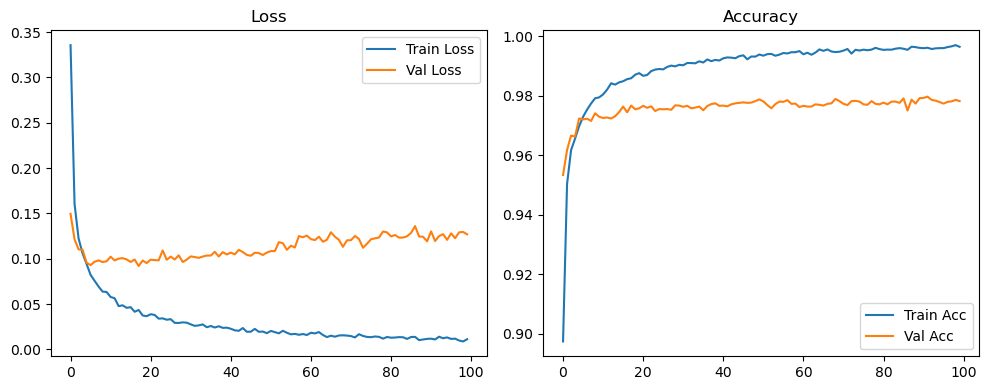

🏆 Best Config: batch128_lr0.01_0.002_0.001_dp0.5 Accuracy: 0.9846


In [8]:
root_path = "MLP_1024_8bit_regular_SiLU"

epochs = 100
batch_sizes = [64, 128, 256]
dropout_rates = [0.0, 0.2, 0.5]
lr_pool = [0.01, 0.005, 0.002, 0.001]

Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates)